In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import gym
# 動画の描画関数の宣言
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):

    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)

    anim.save('movie_cartpolereal.mp4')
    display(display_animation(anim, default_mode='loop'))


Bad key "text.kerning_factor" on line 4 in
C:\Users\Kota\Anaconda3\envs\rl_env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# 定数の設定
ENV = 'CartPole-v0'  # 使用する課題名
NUM_DIZITIZED = 6    # 各状態の離散値への分割数
GAMMA = 0.99  # 時間割引率
ETA = 0.5  # 学習係数
MAX_STEPS = 2000  # 1試行のstep数
NUM_EPISODES = 10000  # 最大試行回数

In [3]:
class Agent:
    '''CartPoleのエージェントクラスです，棒付き台車そのものになります'''
    
    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)
        # エージェントが行動を決定するための頭脳を生成
        
    def update_Q_function(self, observation, action, reward, observation_next):
        '''Q関数の更新'''
        self.brain.update_Q_table(
            observation, action, reward, observation_next)
    
    def get_action(self, observation, step):
        '''行動の決定'''
        action = self.brain.decide_action(observation, step)
        return action

In [4]:
class Brain:
    '''エージェントが持つ脳となるクラスです，Q学習を実行します'''
    
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # CartPoleの行動（右に左に押す）の2を取得
        
        # Qテーブルを作成．行数は状態を分割数^(4変数)にデジタル変換した値，列数は行動数を示す
        self.q_table = np.random.uniform(low=0, high=1, size=(NUM_DIZITIZED**num_states, num_actions))
        
    def bins(self, clip_min, clip_max, num):
        '''観測した状態（連続値）を離散値にデジタル変換する閾値を求める'''
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]
    
    def digitize_state(self, observation):
        '''観測したobservation状態を，離散値に変換する'''
        pole_angle, pole_v = observation
        digitized = [
            #np.digitize(cart_pos, bins=self.bins(-2.4, 2.4, NUM_DIZITIZED)),
            #np.digitize(cart_v, bins=self.bins(-3.0, 3.0, NUM_DIZITIZED)),
            np.digitize(pole_angle, bins=self.bins(-0.5, 0.5, NUM_DIZITIZED)),
            np.digitize(pole_v, bins=self.bins(-2.0, 2.0, NUM_DIZITIZED))]
        return sum([x * (NUM_DIZITIZED**i) for i, x in enumerate(digitized)])
    
    def update_Q_table(self, observation, action, reward, observation_next):
        '''QテーブルをQ学習により更新'''
        state = self.digitize_state(observation)  # 状態を離散化
        state_next = self.digitize_state(observation_next)  # 次の状態を離散化
        Max_Q_next = max(self.q_table[state_next][:])
        self.q_table[state, action] = self.q_table[state, action] + \
            ETA * (reward + GAMMA * Max_Q_next - self.q_table[state, action])
    
    def decide_action(self, observation, episode):
        '''ε-greedy法で徐々に最適行動のみを採用する'''
        state = self.digitize_state(observation)
        epsilon = 0.5 * (1 / (episode + 1))
        
        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(self.q_table[state][:])
        else:
            action = np.random.choice(self.num_actions)  # 0, 1の行動をランダムに返す
        return action
    
    

In [5]:
class Environment:
    '''CartPoleを実行する環境のクラスです'''
    
    def __init__(self):
        self.env = gym.make(ENV).unwrapped# 実行する課題を設定
        self.env._max_episode_steps = 1000
        self.env._reward_threshold = 995.0
        self.env.masscart = 0.08
        self.env.masspole = 0.01
        self.env.total_mass = self.env.masscart + self.env.masspole
        self.env.length = 0.035
        self.env.polemass_length = (self.env.masspole * self.env.length)
        self.env.force_mag = 0.2
        #self.theta_threshold_radians = 24 * 2 * math.pi / 360
        num_states = 2 #self.env.observation_space.shape[0]  # 課題の状態の数４を取得
        num_actions = self.env.action_space.n  # CartPoleの行動（右に左に押す）の２を取得
        self.agent = Agent(num_states, num_actions)  # 環境内で行動するAgentを生成
    
    def run(self):
        '''実行'''
        complete_episodes = 0  # 195step以上連続で立ち続けた試行数
        is_episode_final = False  # 最終試行フラグ
        frames = []  # 動画用に画像を格納する変数
        
        for episode in range(NUM_EPISODES):  # 試行数分繰り返す
            observation = self.env.reset()  # 環境の初期化
            
            for step in range(MAX_STEPS):  # １エピソードのループ
                
                if is_episode_final is True:  # 最終試行ではframesに各時刻の画像を追加していく
                    frames.append(self.env.render(mode='rgb_array'))
                
                # 行動を求める
                action = self.agent.get_action(observation[2:], episode)
                
                # 行動a_tの実行により，s_{t+1}, r_{t+1}を求める
                observation_next, _, done, _ = self.env.step(action)  # rewardとinfoは使わないので_にする
                
                # 報酬を与える
                if done:  # ステップ数が200経過するか，一定角度に傾くとdoneはtrueになる
                    if step < 995:
                        reward = -1  # 途中でこけたら罰則として報酬-1を与える
                        complete_episodes = 0  # 195step以上連続で立ち続けた試行数をリセット
                    else:
                        reward = 1  # 立ったまま終了時は報酬を１与える
                        complete_episodes += 1  # 連続記録を更新
                else:
                    reward = 0  # 途中の報酬は０
                
                # step+1の状態observation_nextを用いて，Q関数を更新する
                self.agent.update_Q_function(observation[2:], action, reward, observation_next[2:])
                
                # 観測の更新
                observation = observation_next
                
                # 終了時の処理
                if done:
                    print('{0} Episode: Finished after {1} time steps'.format(episode, step + 1))
                    break
                
            if is_episode_final is True:  # 最終試行では動画を保存と描画
                display_frames_as_gif(frames)
                break
                
            if complete_episodes >= 10:  # 10連続成功なら
                print('10回連続成功')
                is_episode_final = True  # 次の試行を描画を行う最終試行とする
            

C:\Users\Kota\Anaconda3\envs\rl_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0 Episode: Finished after 6 time steps
1 Episode: Finished after 29 time steps
2 Episode: Finished after 17 time steps
3 Episode: Finished after 8 time steps
4 Episode: Finished after 8 time steps
5 Episode: Finished after 59 time steps
6 Episode: Finished after 47 time steps
7 Episode: Finished after 100 time steps
8 Episode: Finished after 19 time steps
9 Episode: Finished after 66 time steps
10 Episode: Finished after 26 time steps
11 Episode: Finished after 57 time steps
12 Episode: Finished after 21 time steps
13 Episode: Finished after 18 time steps
14 Episode: Finished after 23 time steps
15 Episode: Finished after 27 time steps
16 Episode: Finished after 9 time steps
17 Episode: Finished after 59 time steps
18 Episode: Finished after 20 time steps
19 Episode: Finished after 11 time steps
20 Episode: Finished after 13 time steps
21 Episode: Finished after 22 time steps
22 Episode: Finished after 95 time steps
23 Episode: Finished after 22 time steps
24 Episode: Finished after 16

218 Episode: Finished after 38 time steps
219 Episode: Finished after 27 time steps
220 Episode: Finished after 26 time steps
221 Episode: Finished after 24 time steps
222 Episode: Finished after 106 time steps
223 Episode: Finished after 1728 time steps
224 Episode: Finished after 757 time steps
225 Episode: Finished after 1793 time steps
226 Episode: Finished after 447 time steps
227 Episode: Finished after 728 time steps
228 Episode: Finished after 757 time steps
230 Episode: Finished after 1385 time steps
231 Episode: Finished after 1768 time steps
232 Episode: Finished after 771 time steps
233 Episode: Finished after 1048 time steps
234 Episode: Finished after 935 time steps
235 Episode: Finished after 19 time steps
236 Episode: Finished after 862 time steps
238 Episode: Finished after 1206 time steps
239 Episode: Finished after 682 time steps
240 Episode: Finished after 1344 time steps
242 Episode: Finished after 1133 time steps
245 Episode: Finished after 1137 time steps
247 Epi

422 Episode: Finished after 505 time steps
423 Episode: Finished after 546 time steps
424 Episode: Finished after 1309 time steps
425 Episode: Finished after 624 time steps
426 Episode: Finished after 1092 time steps
427 Episode: Finished after 832 time steps
428 Episode: Finished after 122 time steps
429 Episode: Finished after 967 time steps
430 Episode: Finished after 221 time steps
431 Episode: Finished after 193 time steps
432 Episode: Finished after 248 time steps
433 Episode: Finished after 448 time steps
434 Episode: Finished after 510 time steps
435 Episode: Finished after 25 time steps
436 Episode: Finished after 66 time steps
437 Episode: Finished after 167 time steps
438 Episode: Finished after 28 time steps
439 Episode: Finished after 163 time steps
440 Episode: Finished after 680 time steps
441 Episode: Finished after 733 time steps
442 Episode: Finished after 775 time steps
443 Episode: Finished after 592 time steps
444 Episode: Finished after 1077 time steps
445 Episode

660 Episode: Finished after 24 time steps
661 Episode: Finished after 72 time steps
662 Episode: Finished after 43 time steps
663 Episode: Finished after 29 time steps
664 Episode: Finished after 24 time steps
665 Episode: Finished after 59 time steps
666 Episode: Finished after 1061 time steps
668 Episode: Finished after 1251 time steps
669 Episode: Finished after 972 time steps
671 Episode: Finished after 828 time steps
673 Episode: Finished after 1538 time steps
674 Episode: Finished after 1502 time steps
675 Episode: Finished after 1474 time steps
676 Episode: Finished after 1212 time steps
678 Episode: Finished after 873 time steps
680 Episode: Finished after 1430 time steps
681 Episode: Finished after 1757 time steps
682 Episode: Finished after 679 time steps
683 Episode: Finished after 1363 time steps
685 Episode: Finished after 1439 time steps
686 Episode: Finished after 1439 time steps
687 Episode: Finished after 850 time steps
688 Episode: Finished after 60 time steps
689 Epi


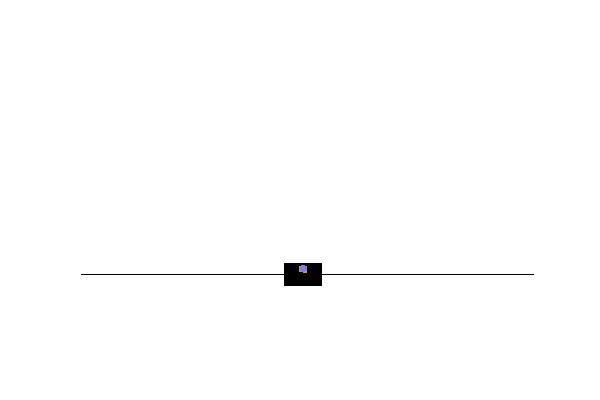
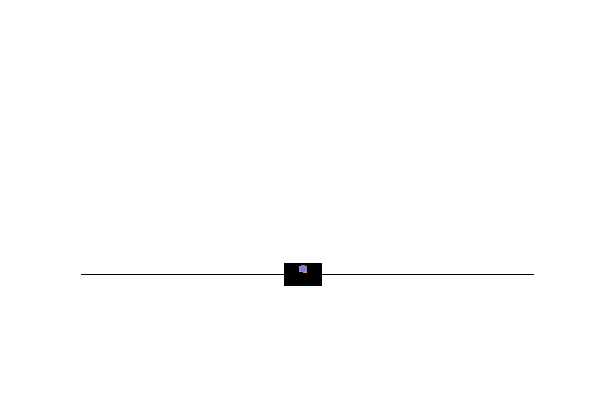
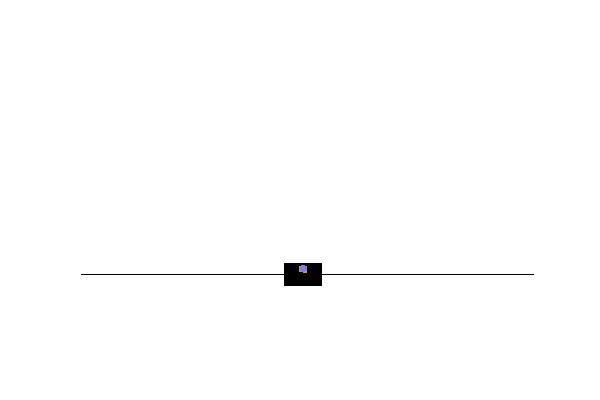
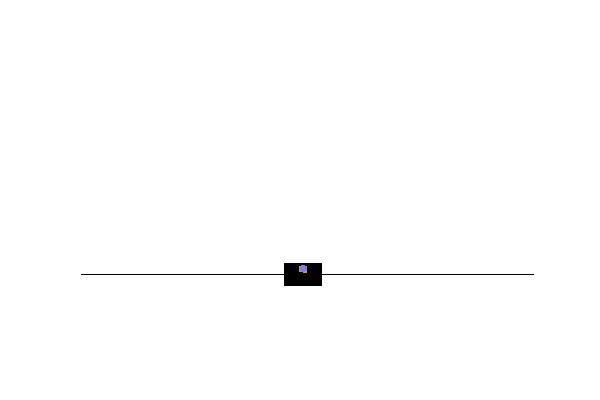
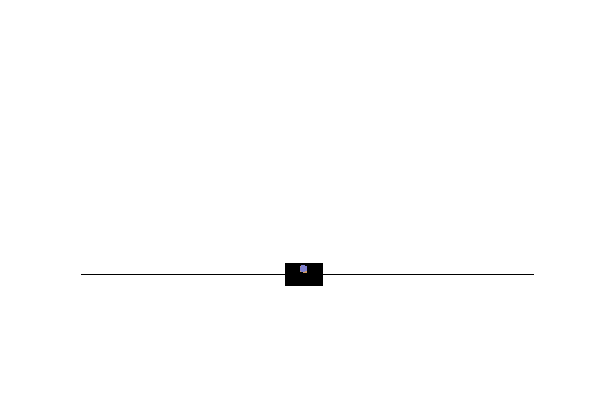
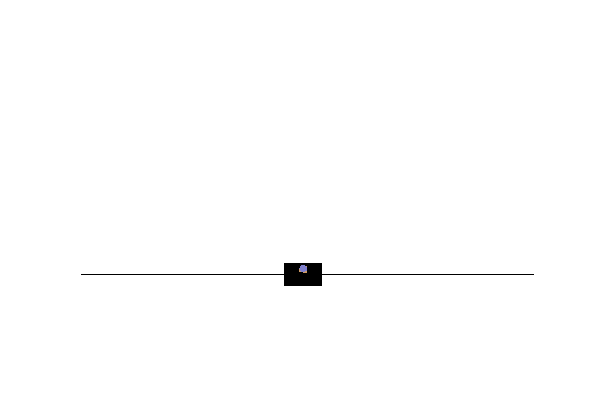
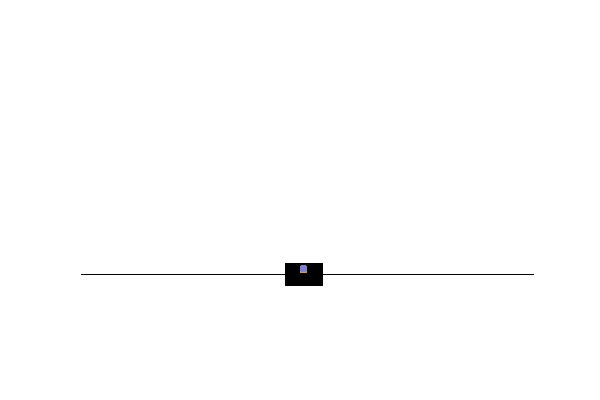
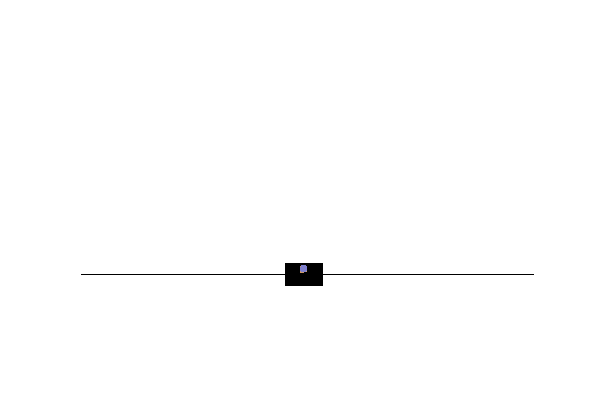
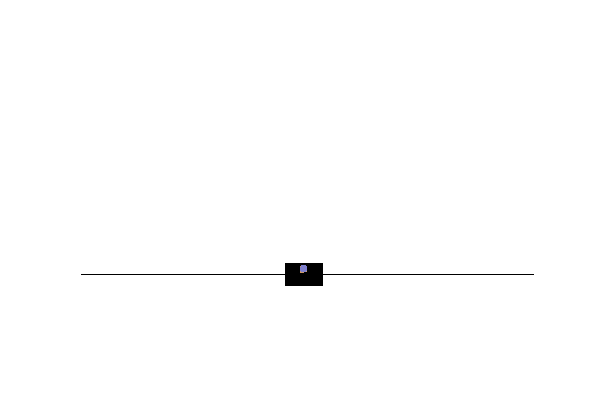
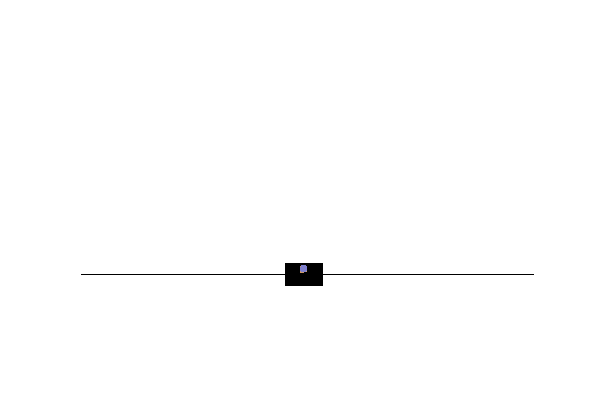
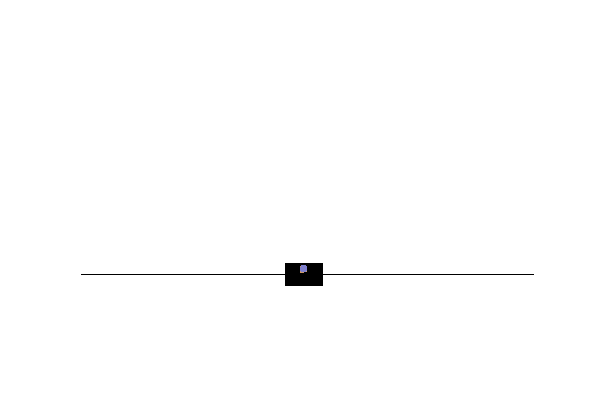
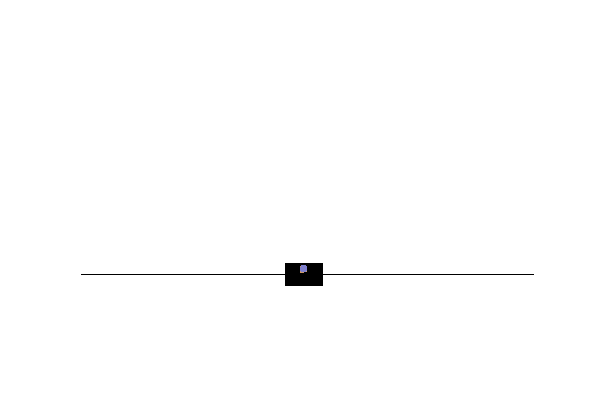
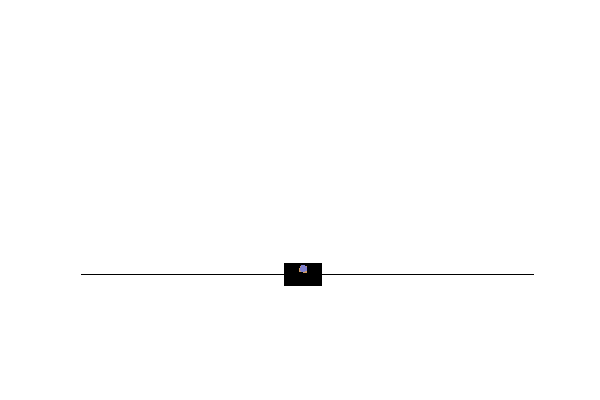
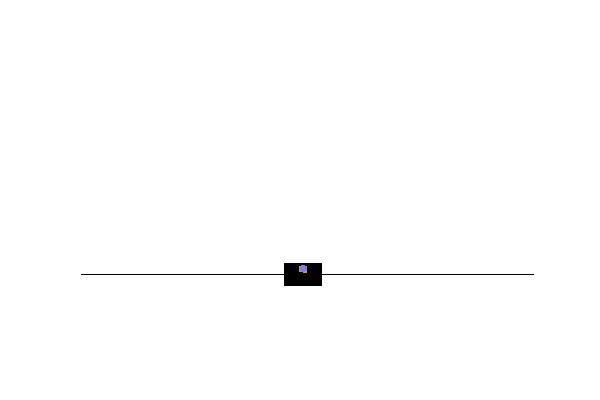
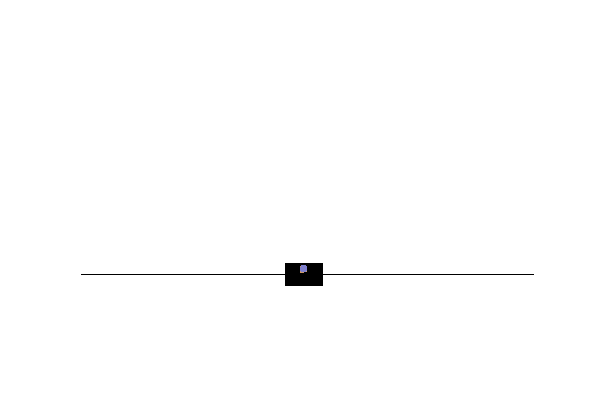
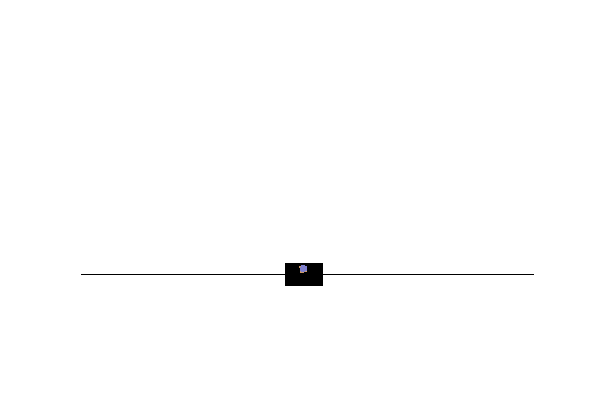
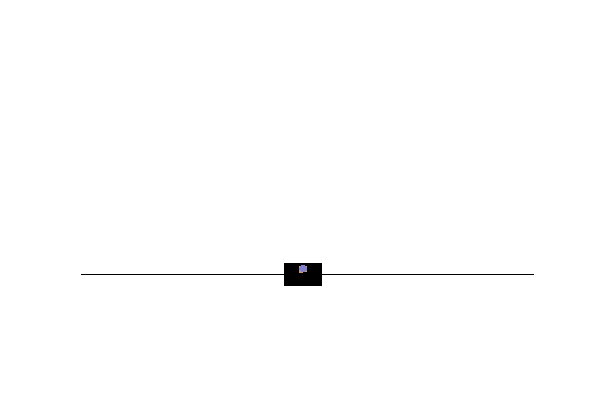
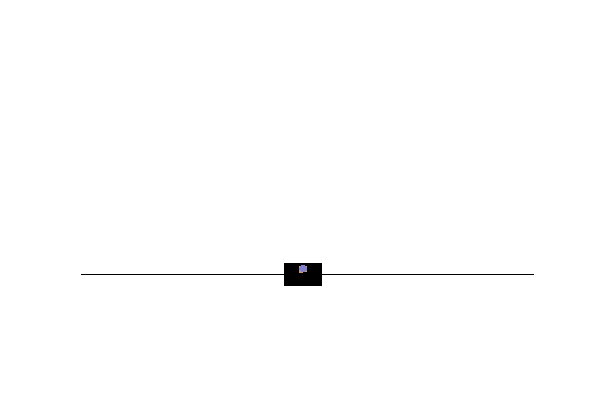
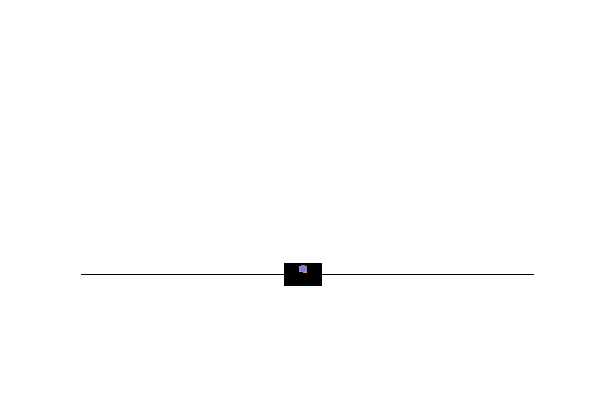
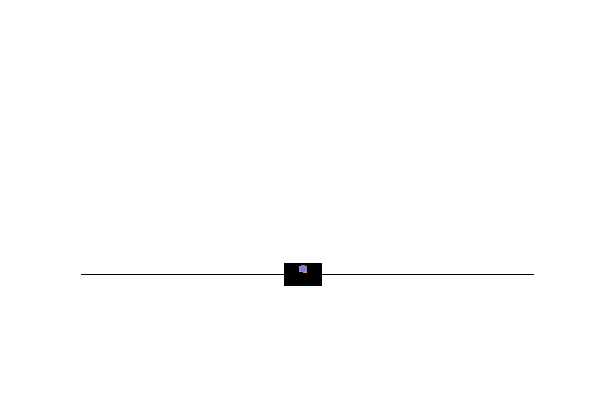
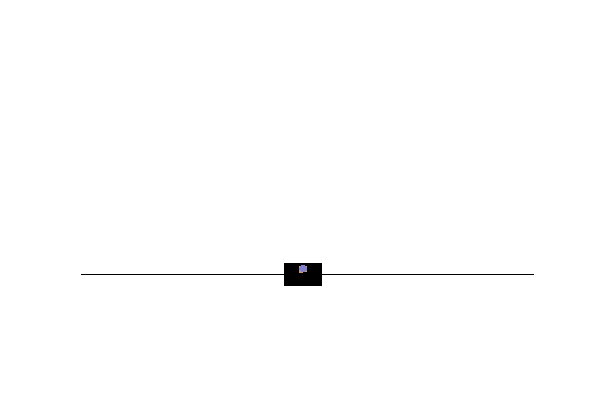
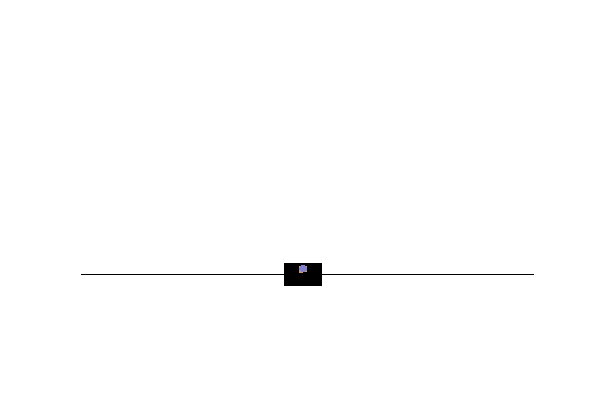
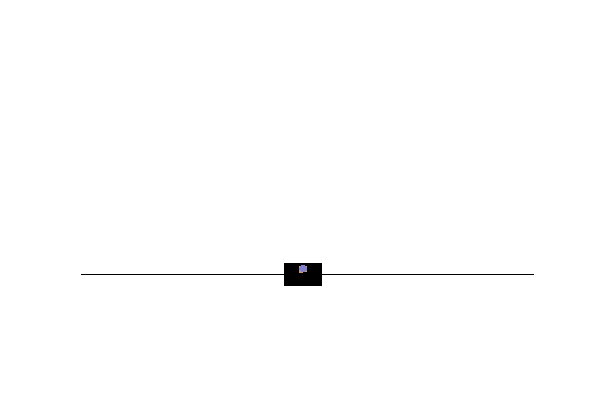
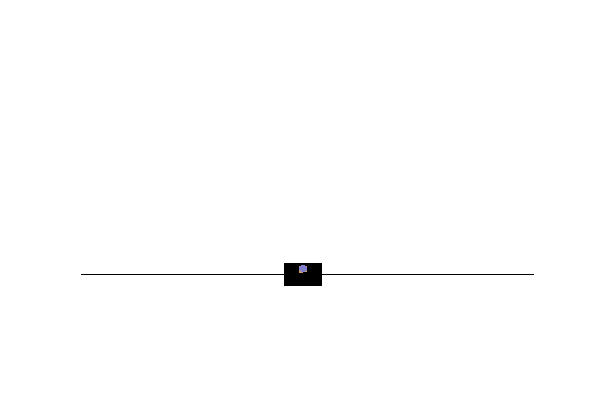
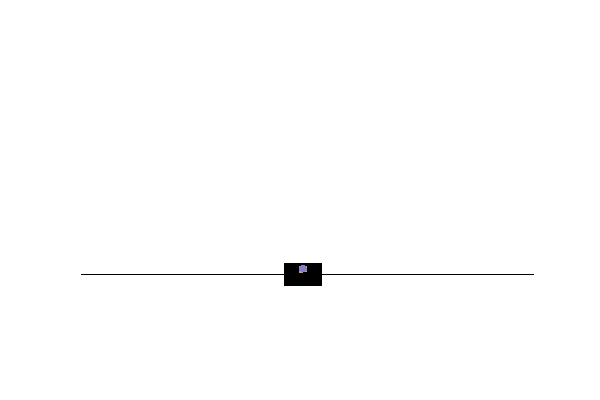
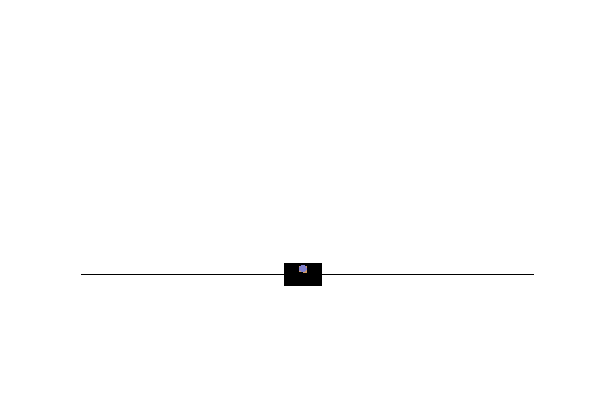
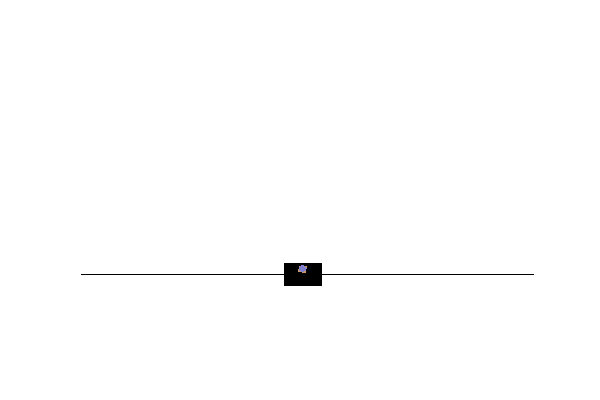
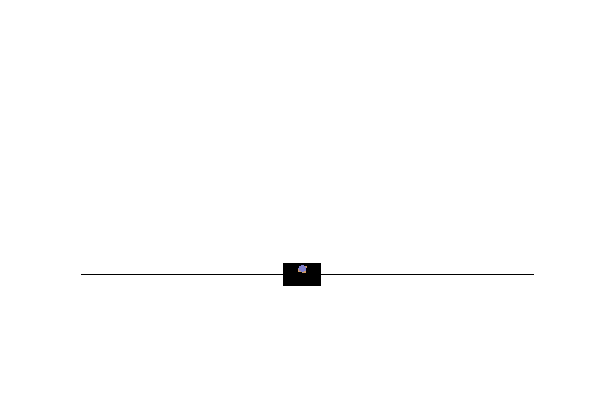
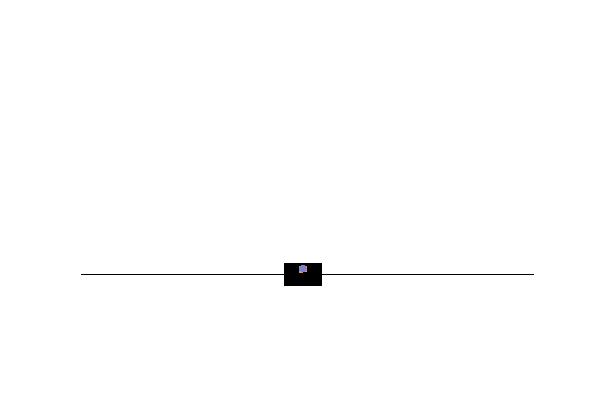
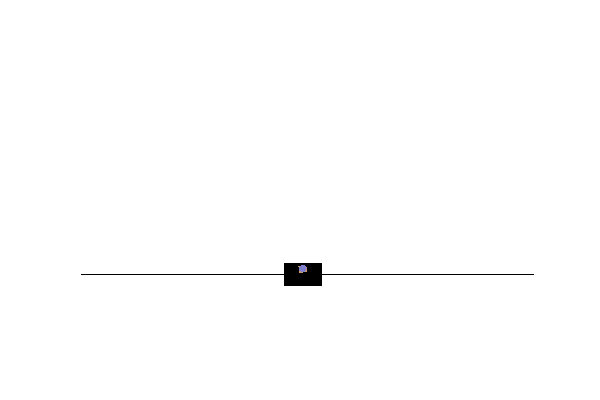
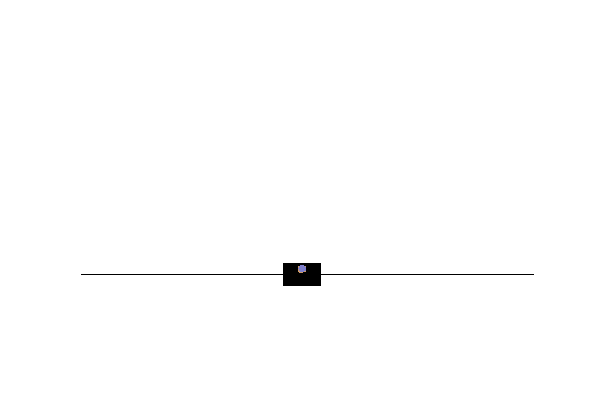
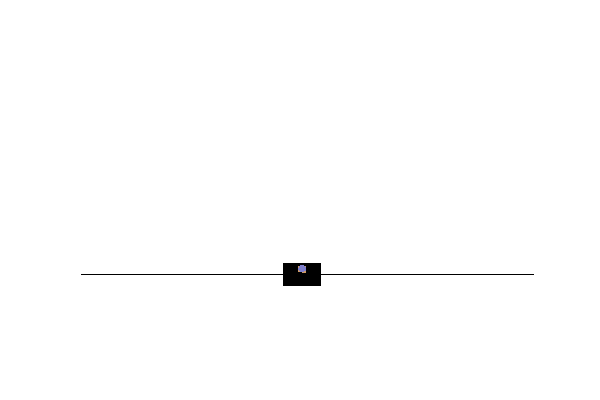
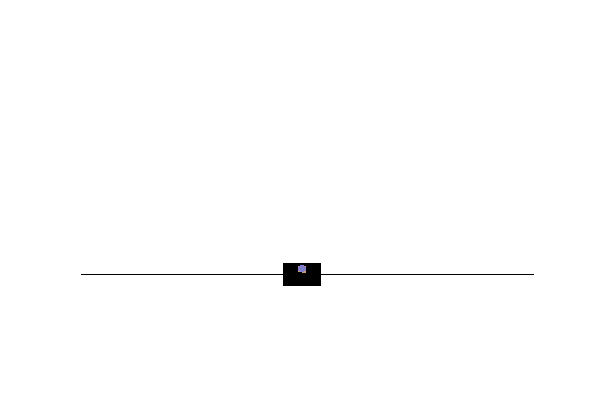
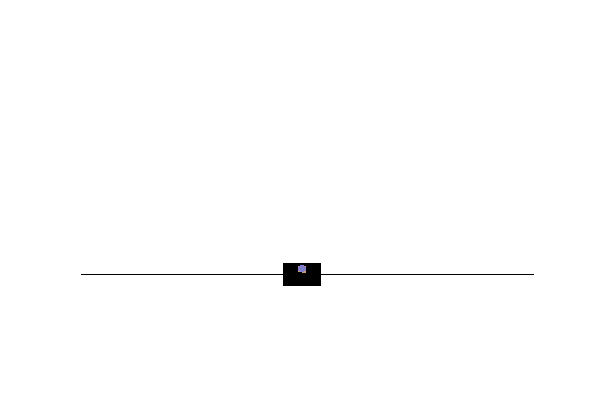
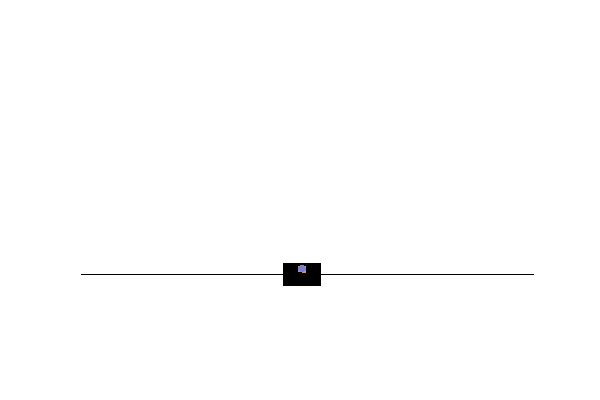
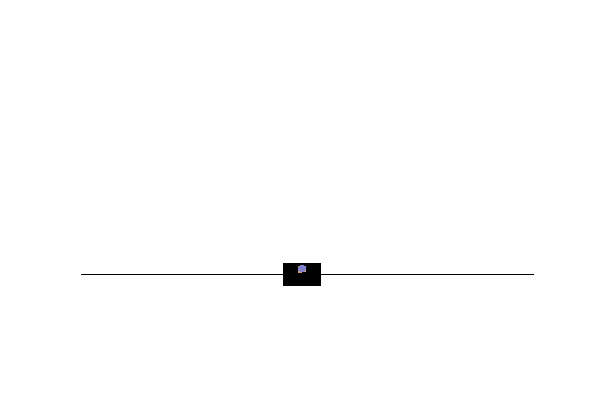
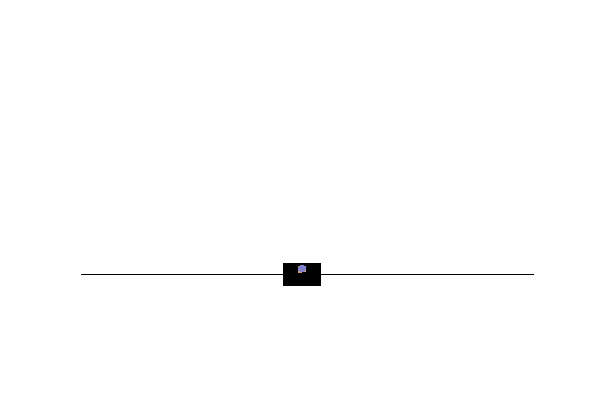
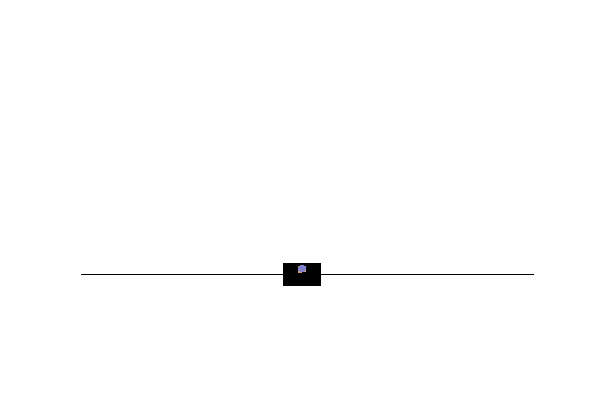
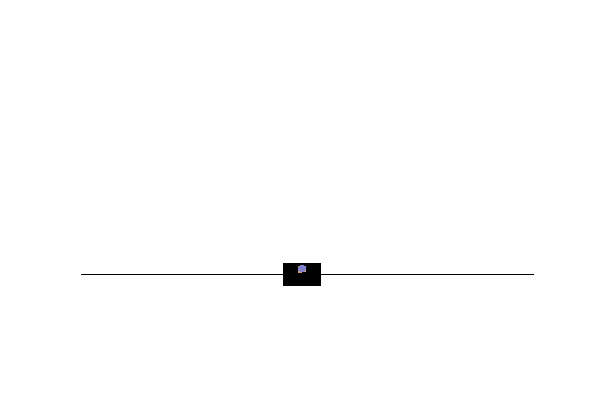
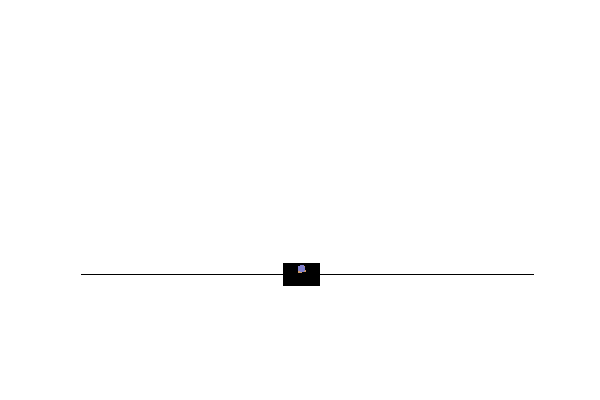
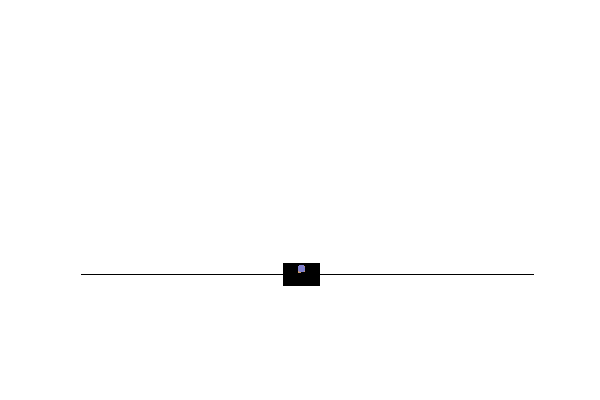
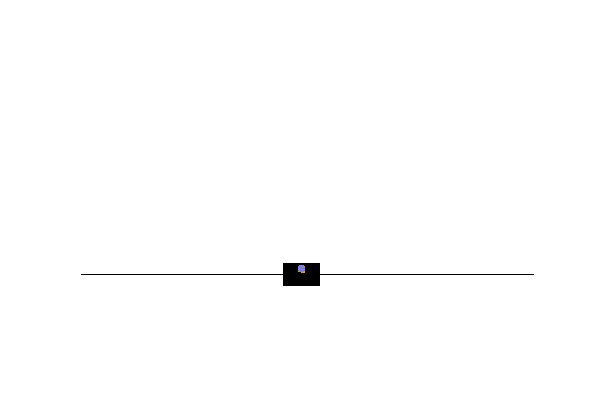
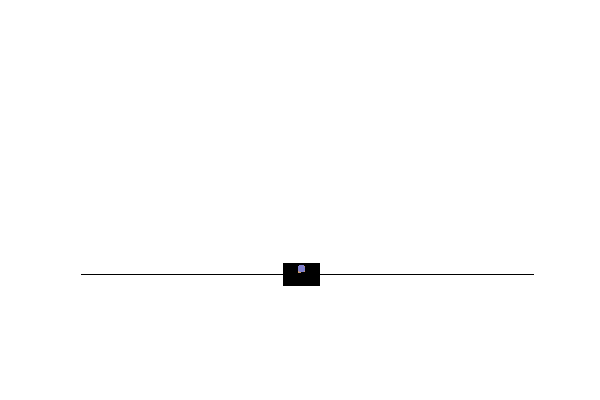
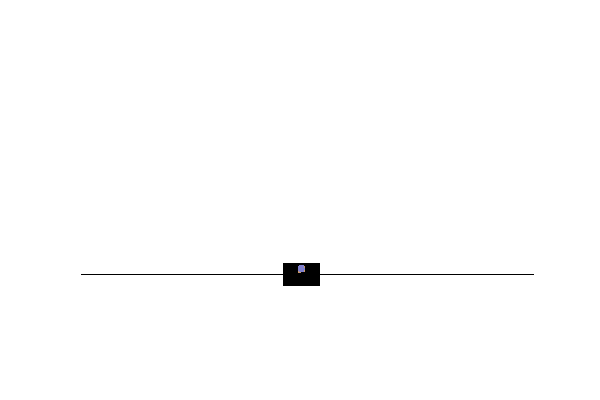
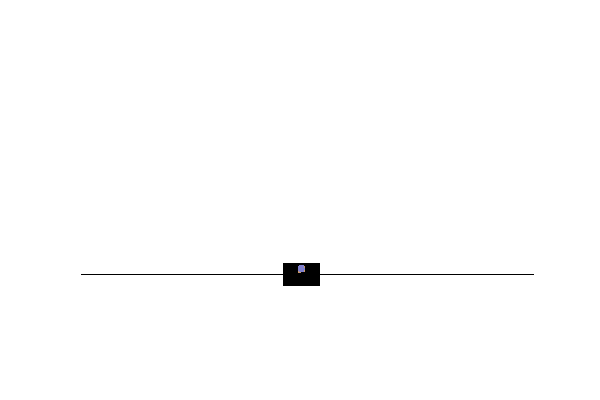
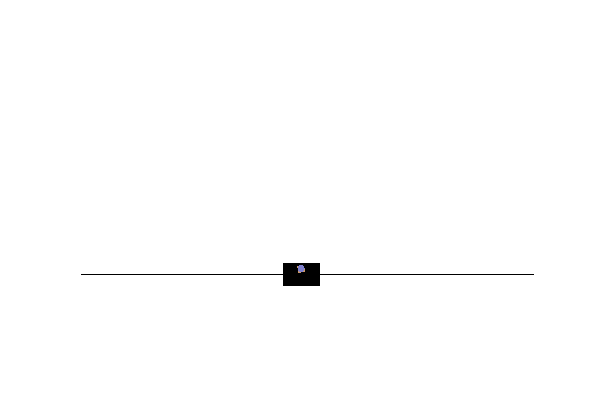
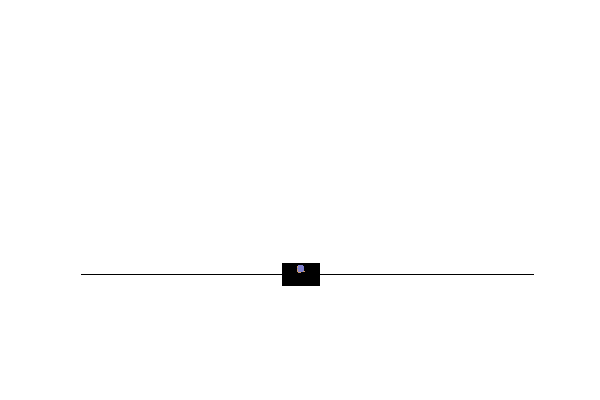
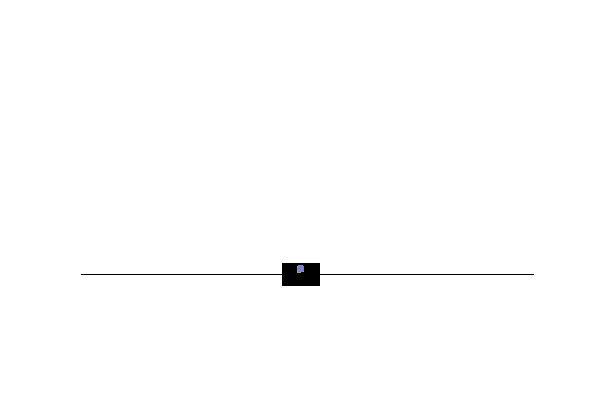
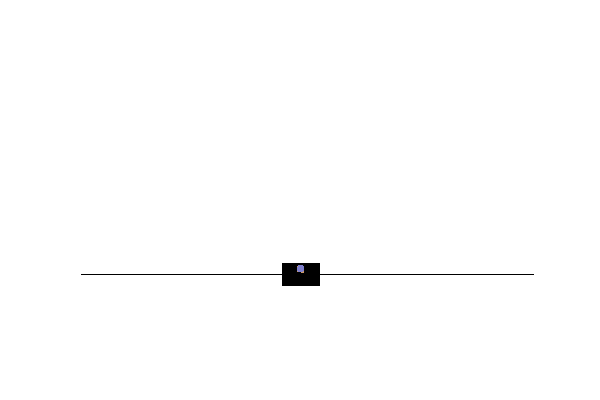
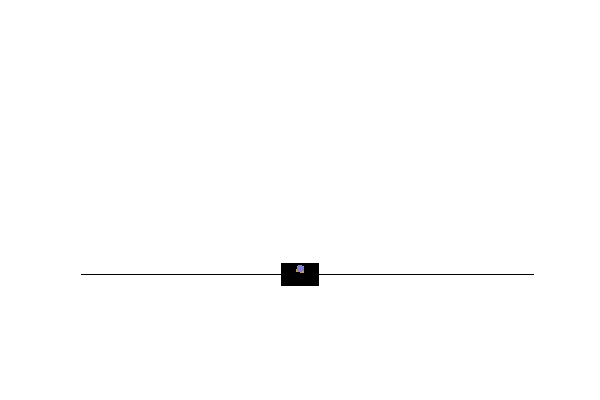
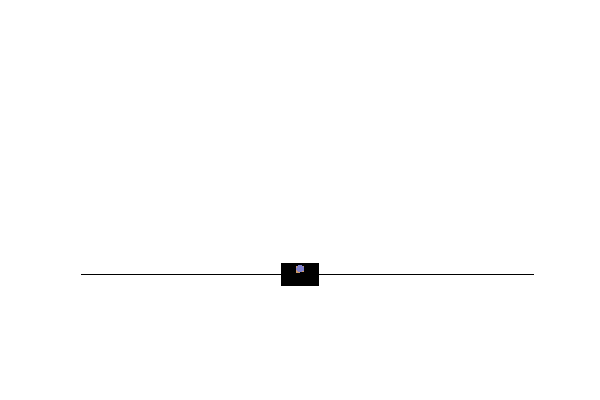
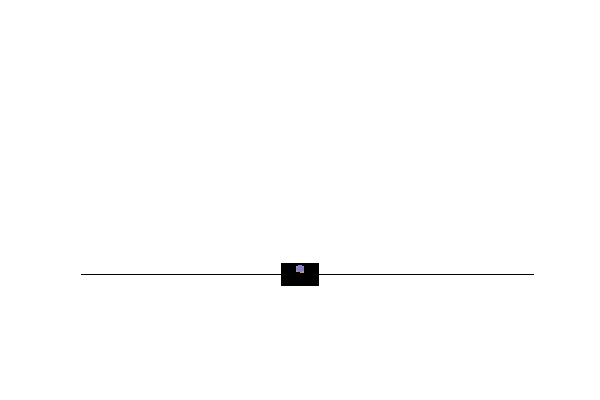
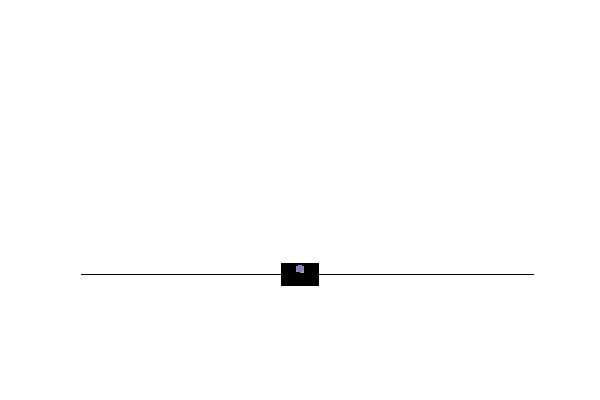
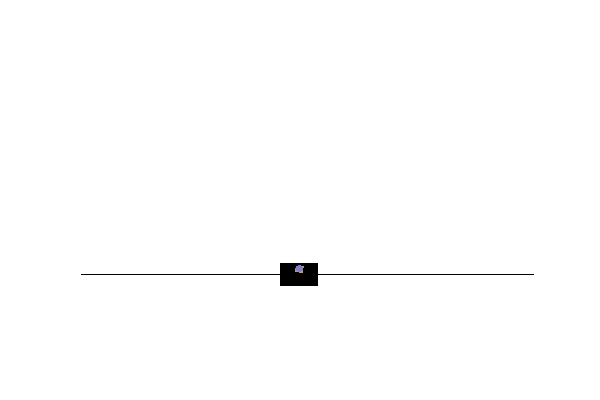
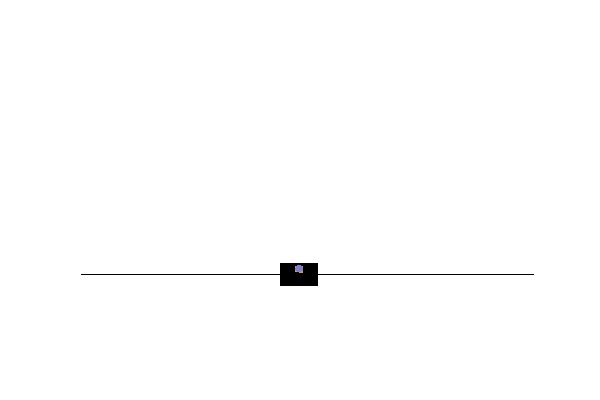
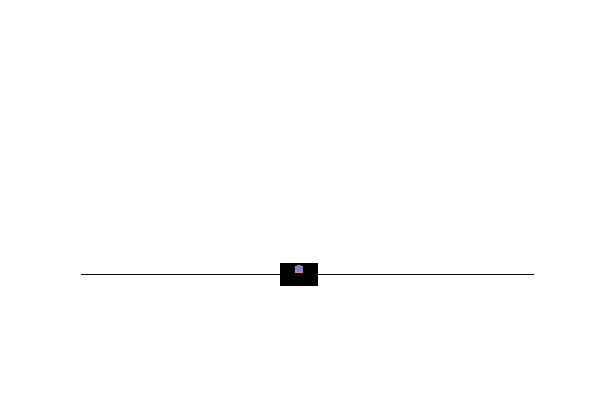
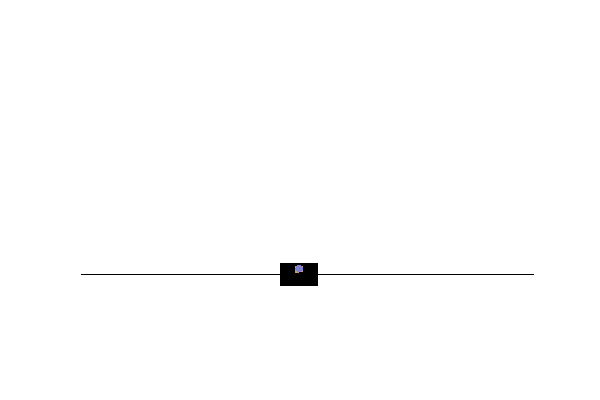
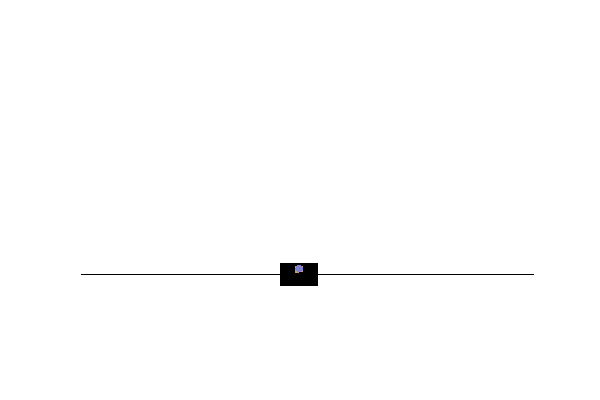
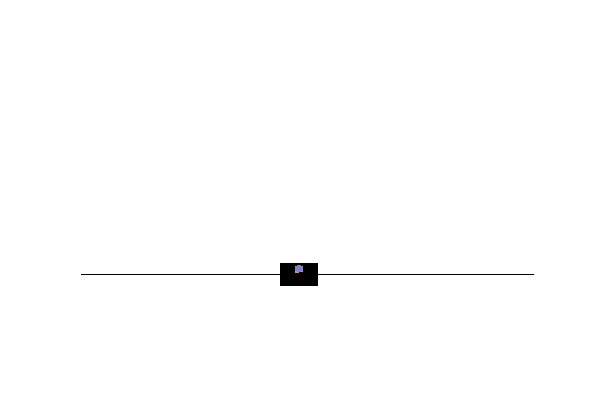
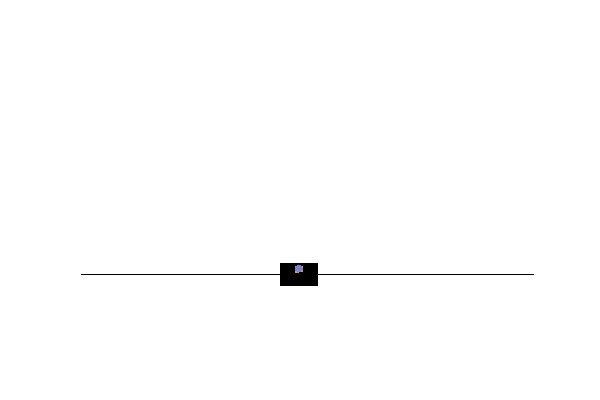
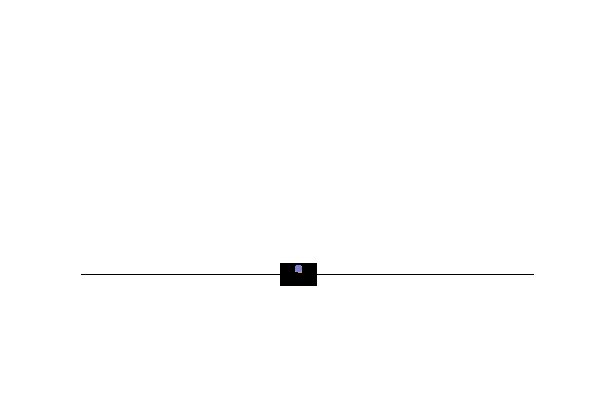
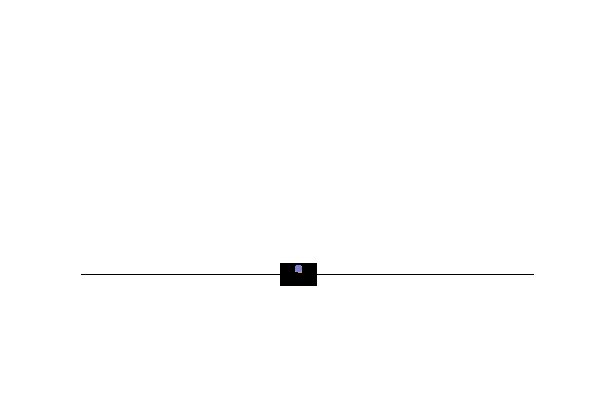
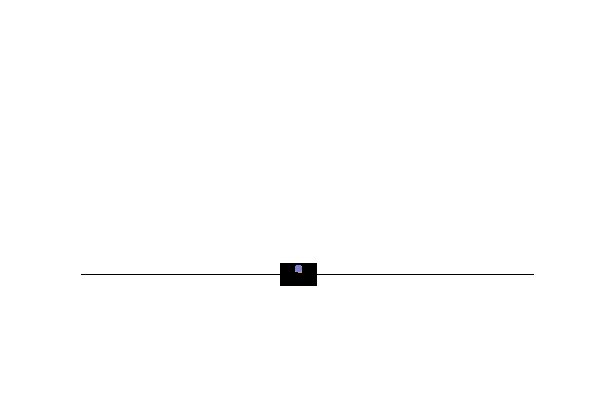
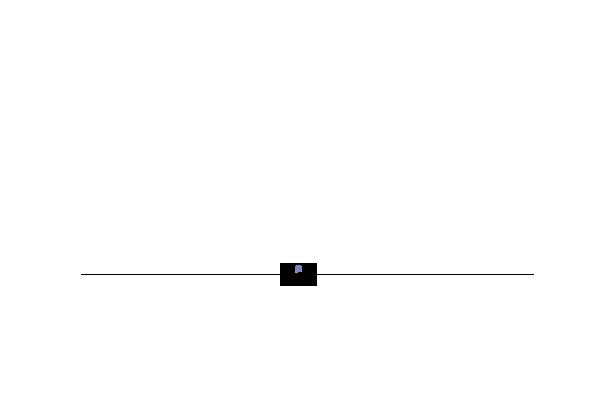
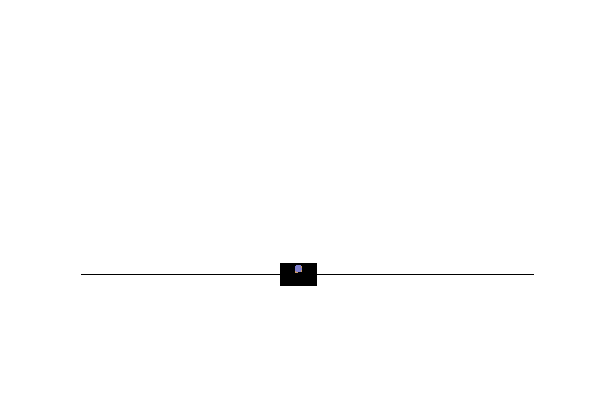
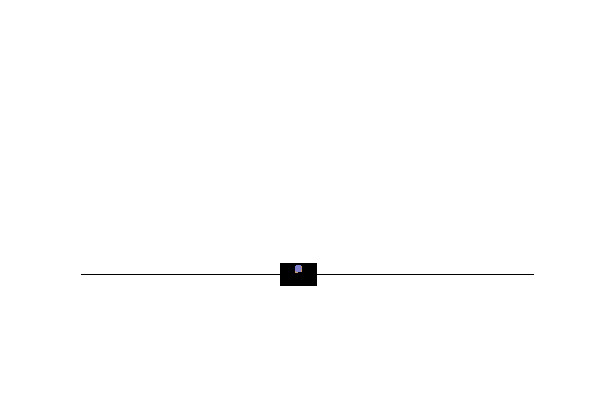
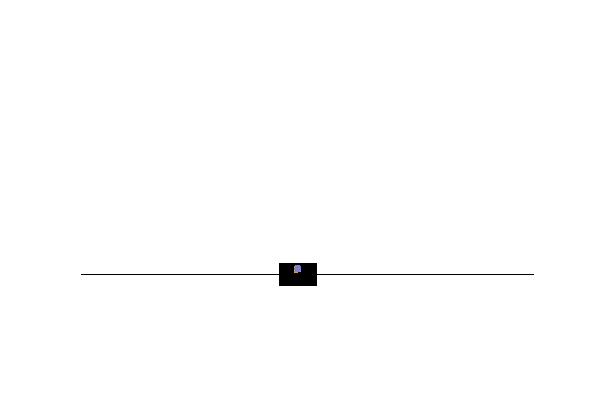
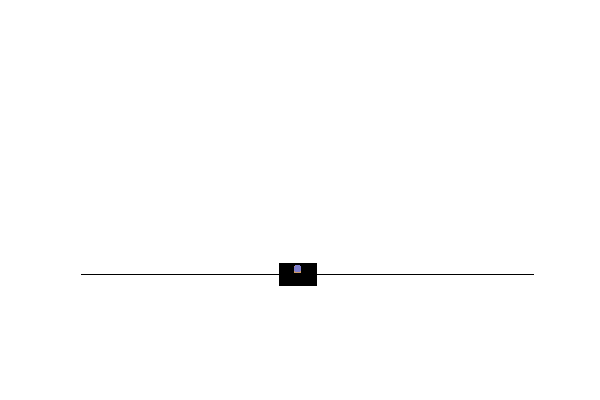
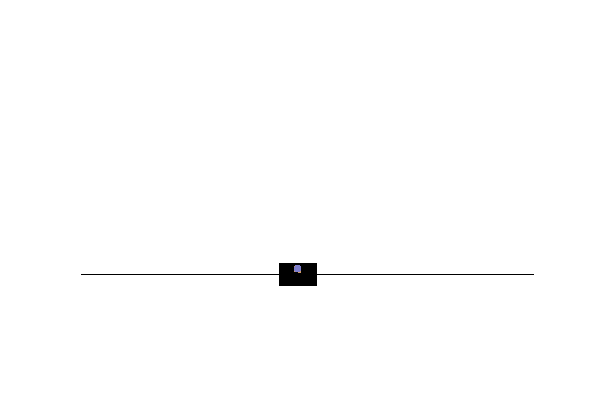
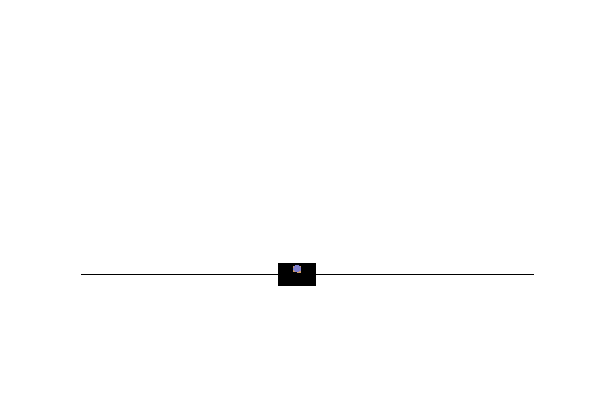
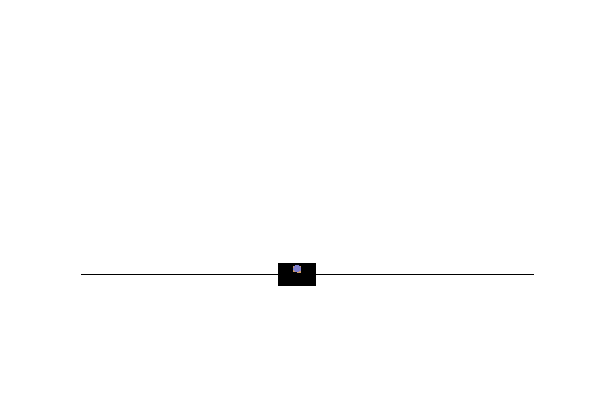
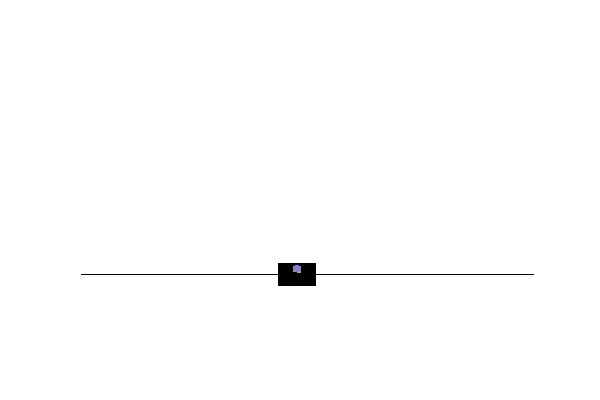
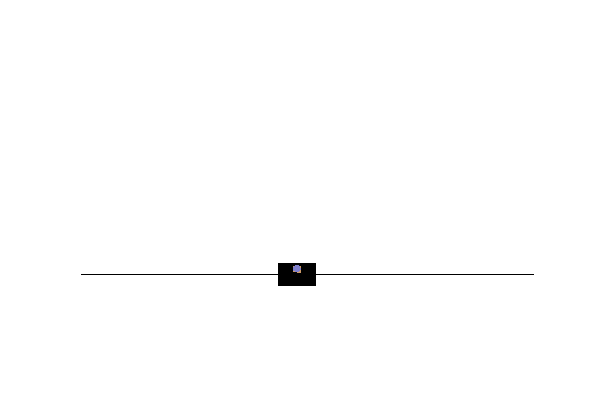
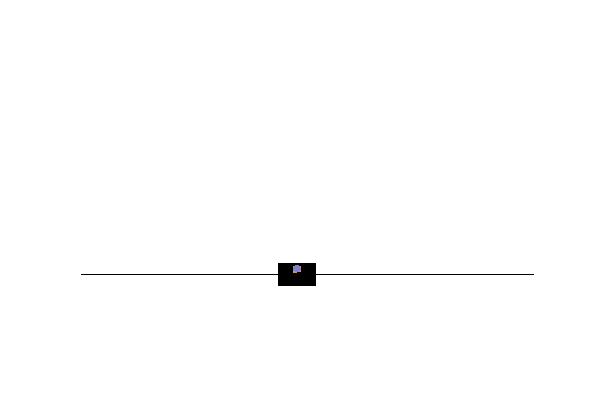
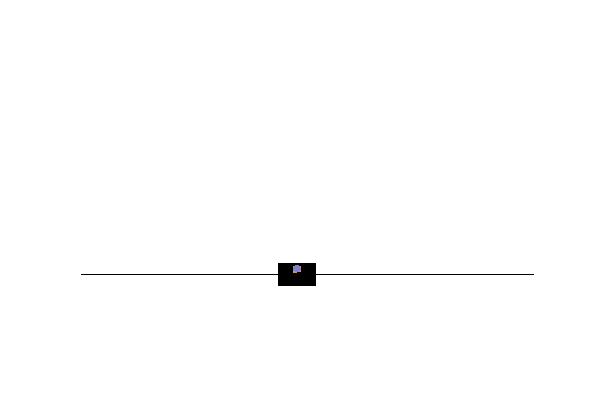
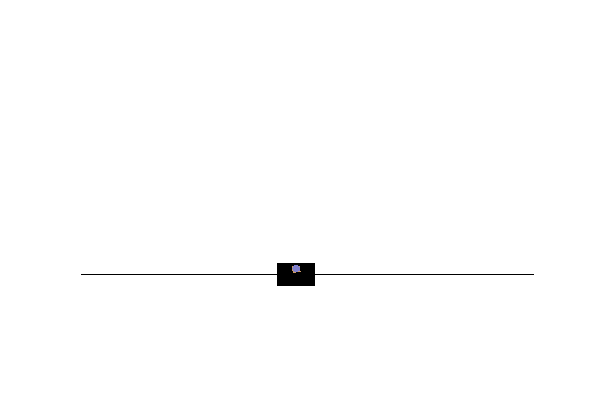
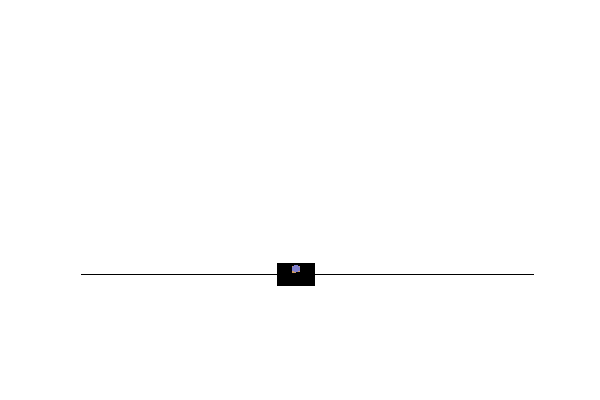
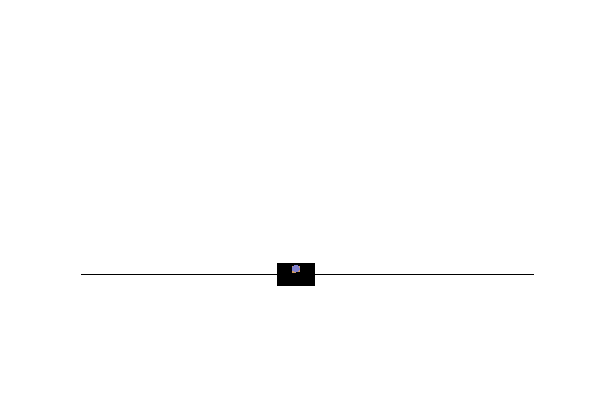
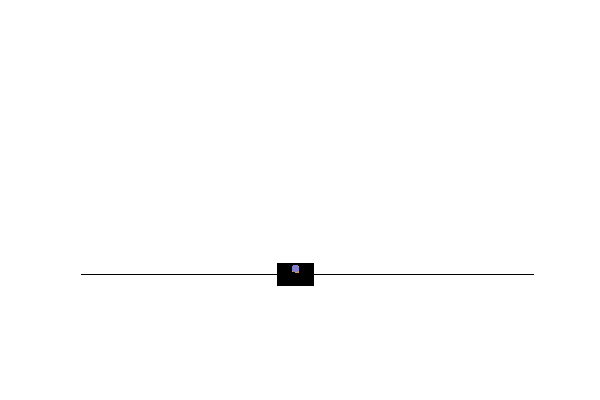
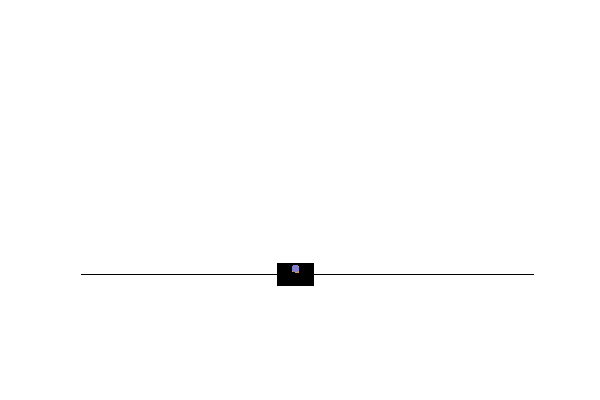
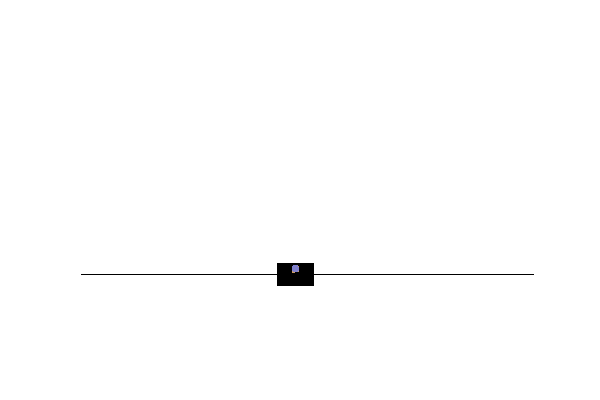
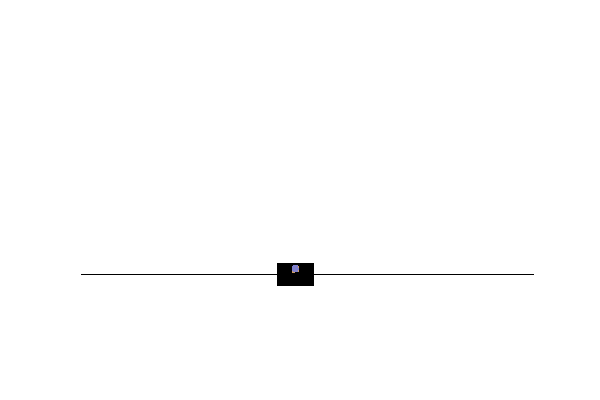
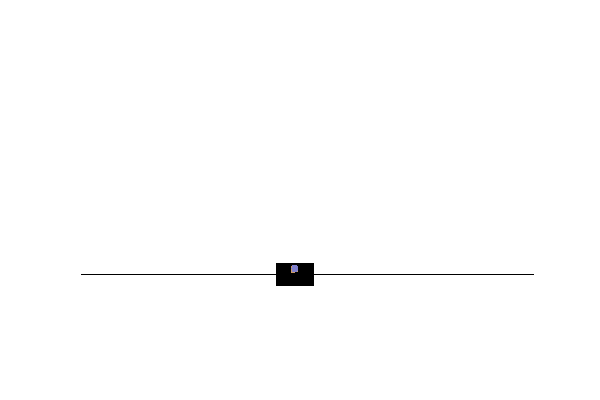
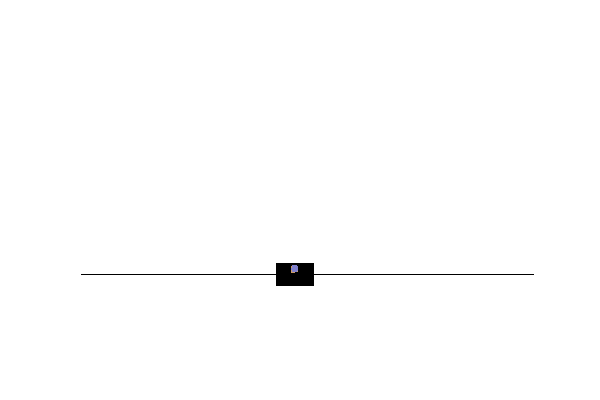
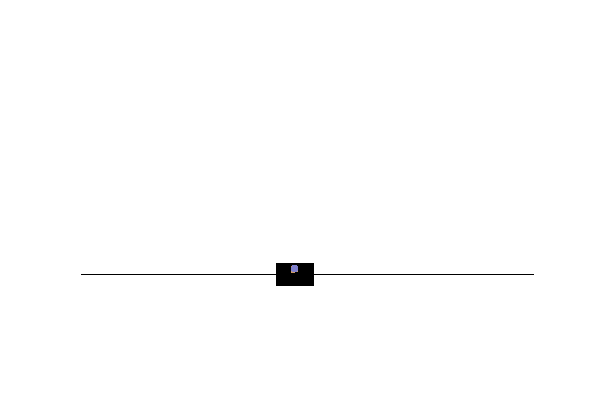
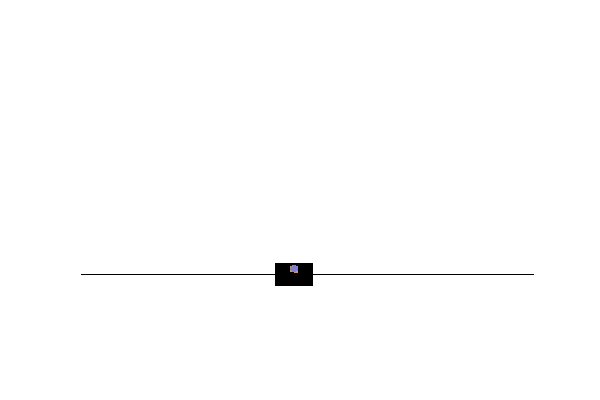
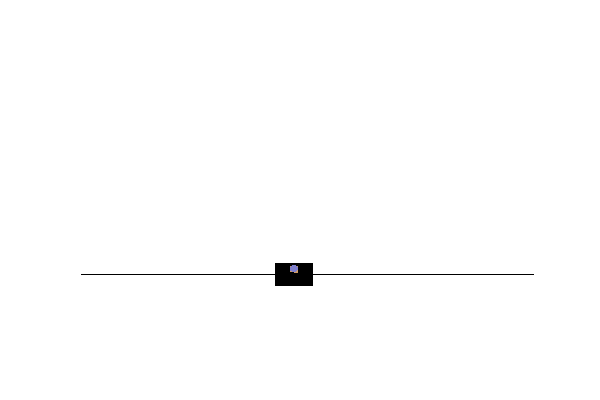
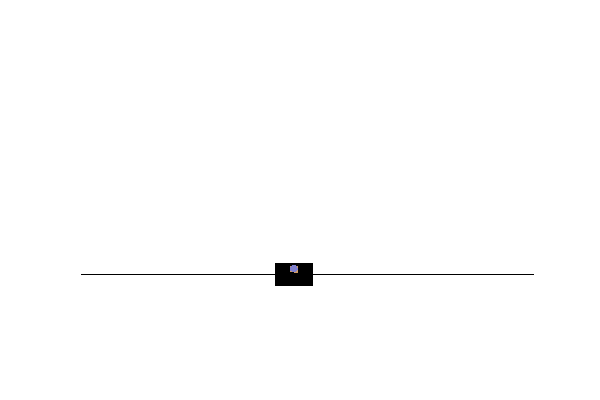
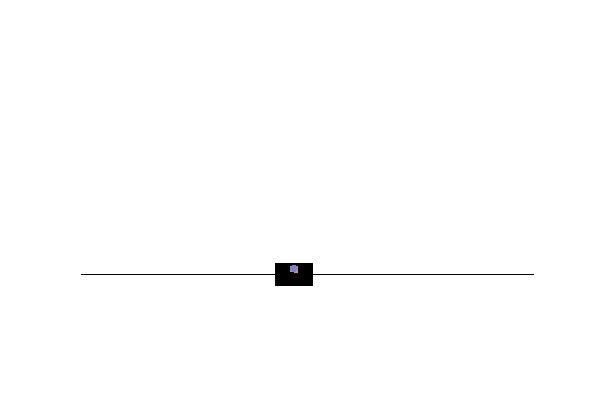
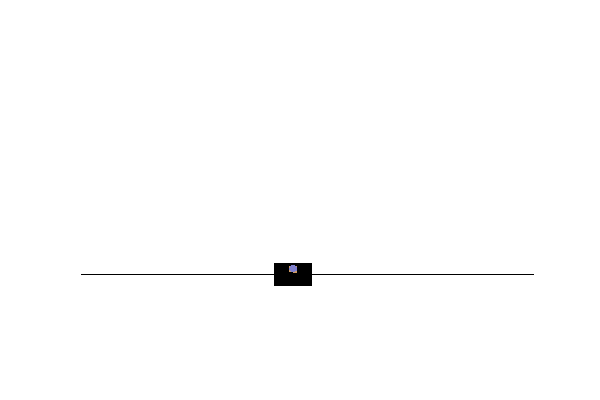
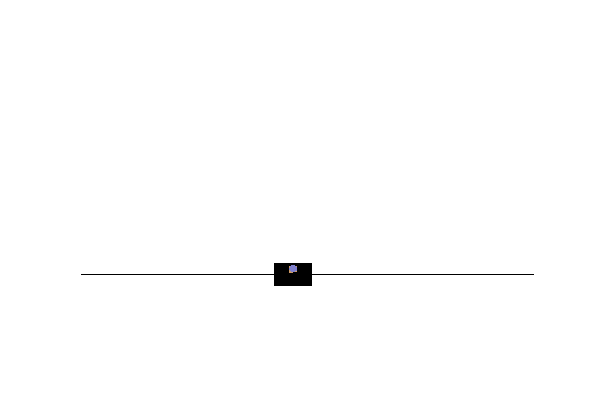
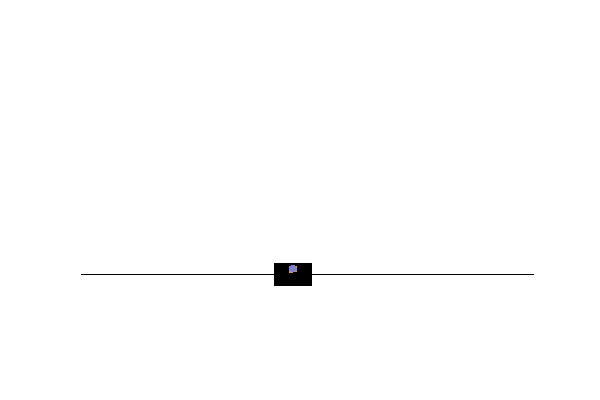
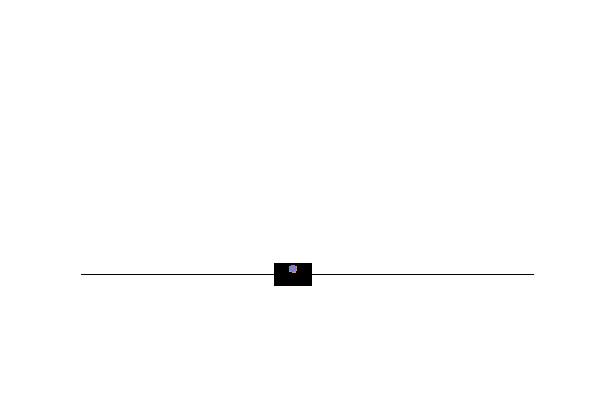
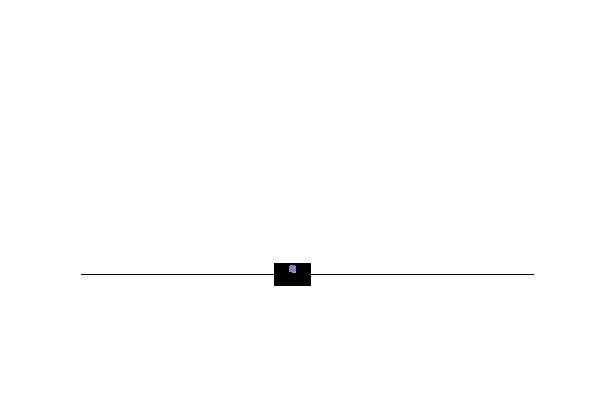
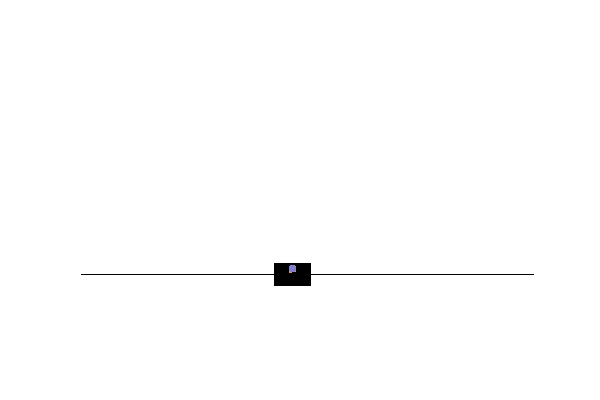
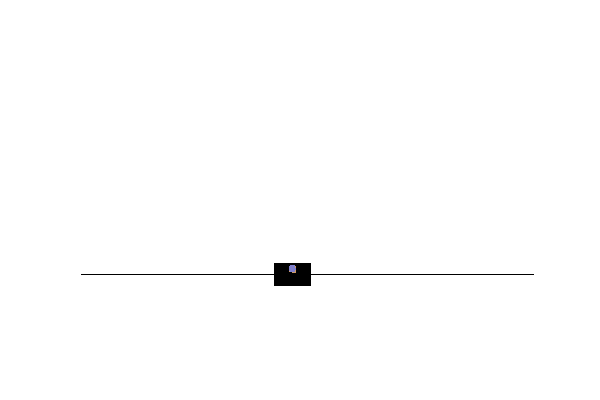
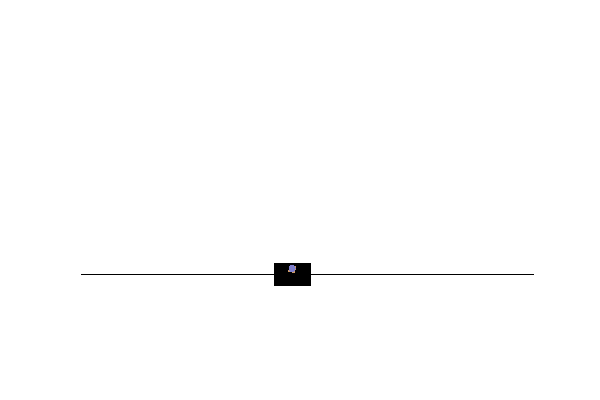
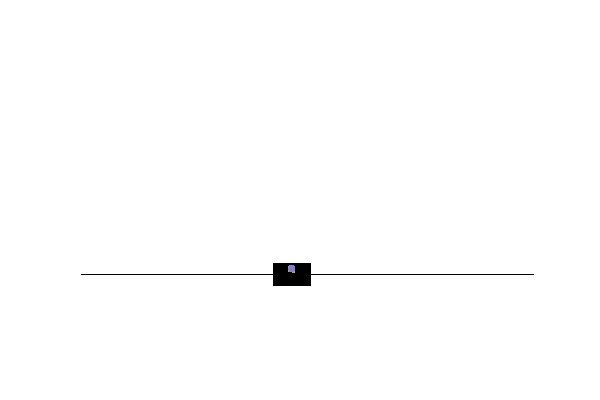
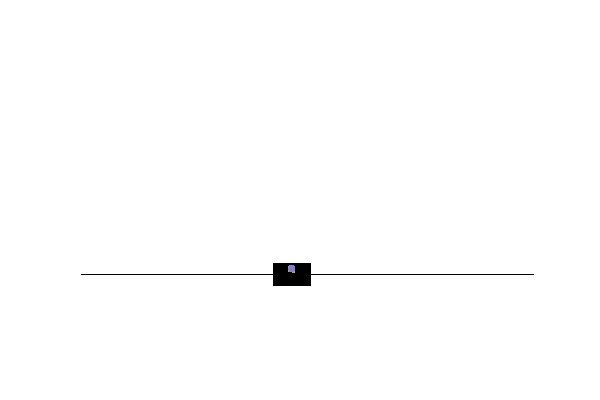
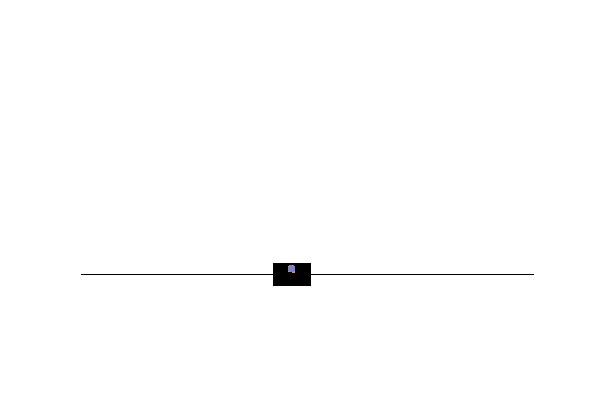
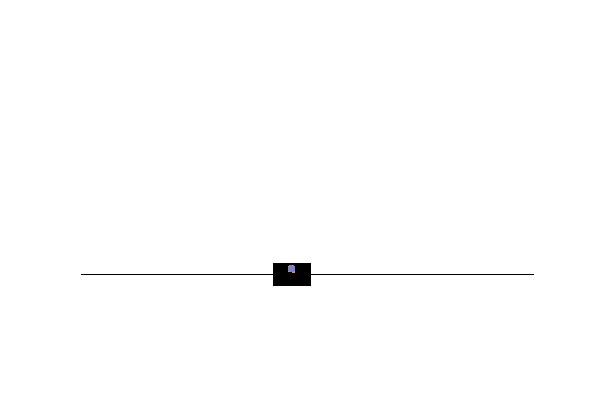
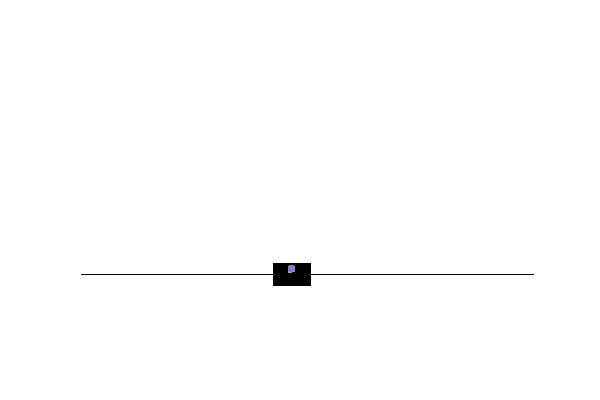
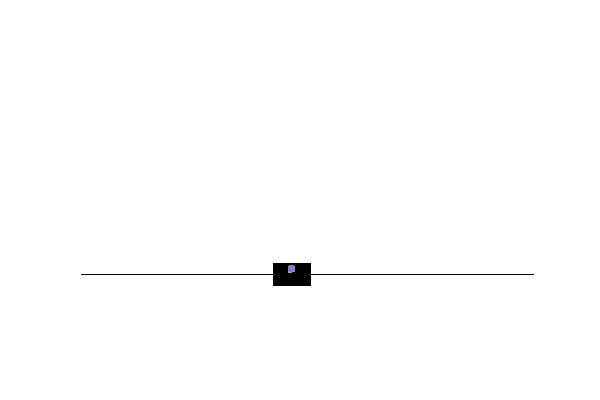
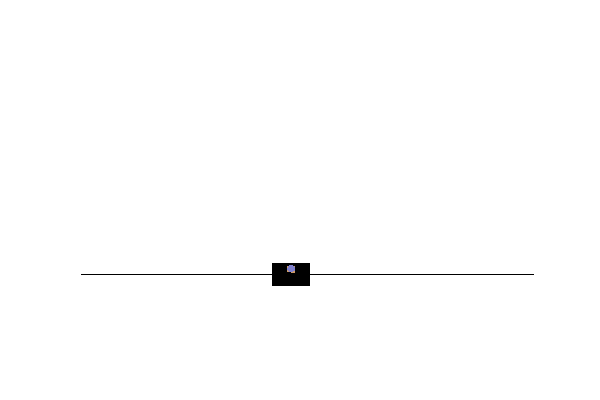
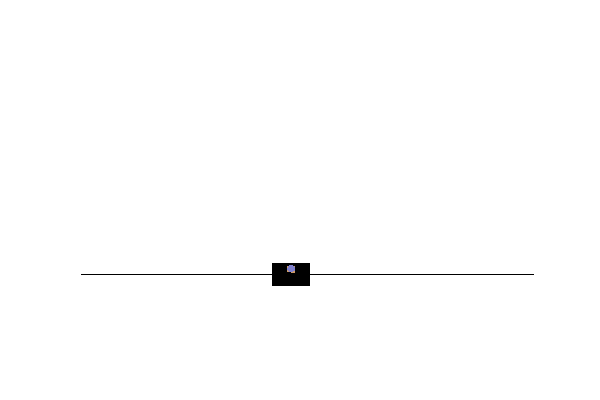
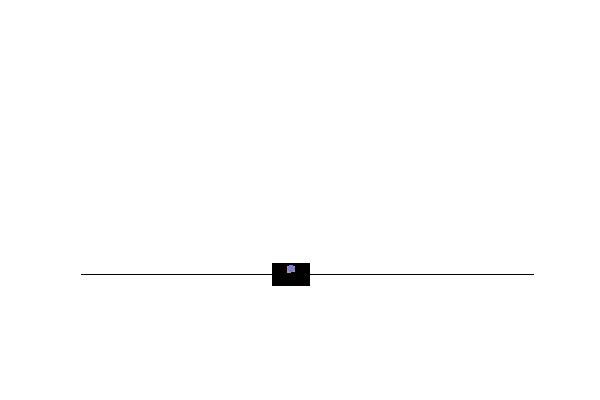
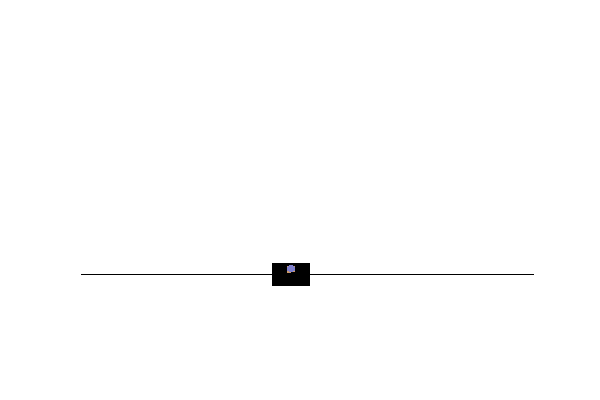
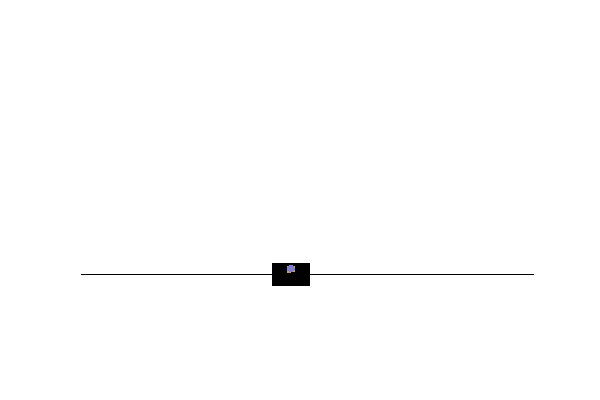
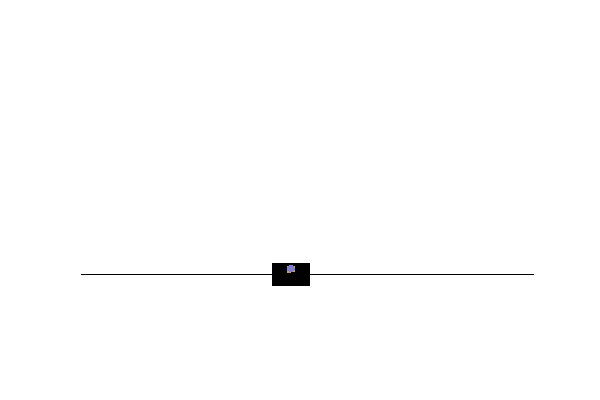
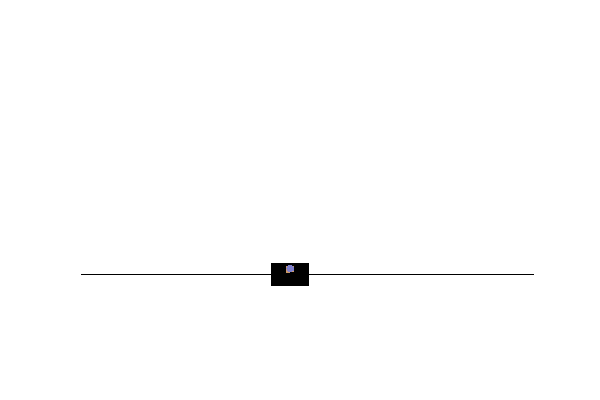
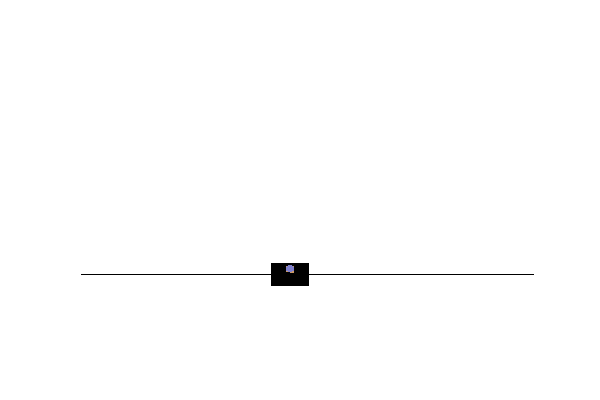
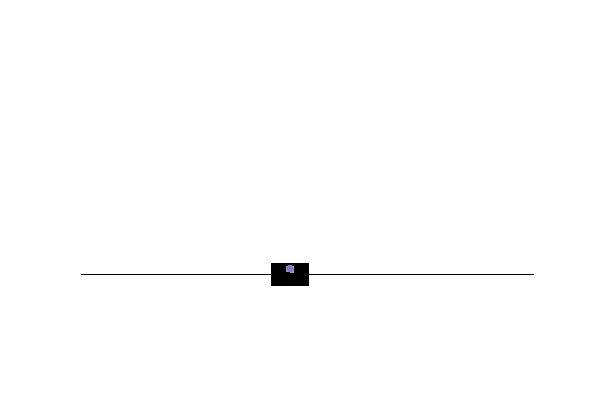
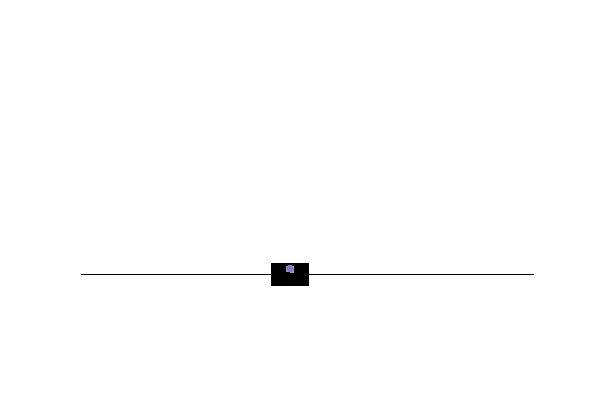
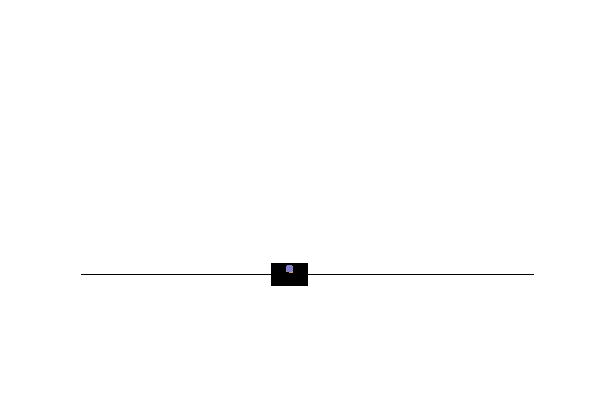
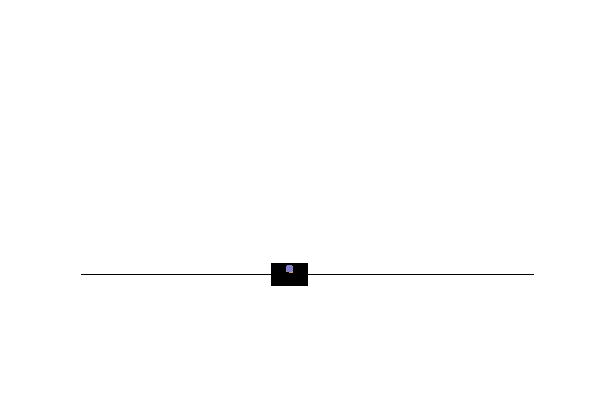
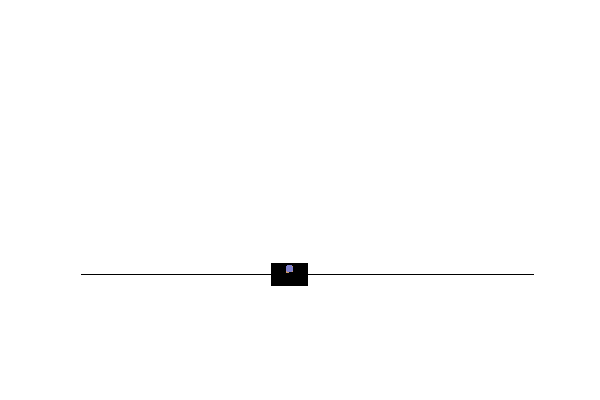
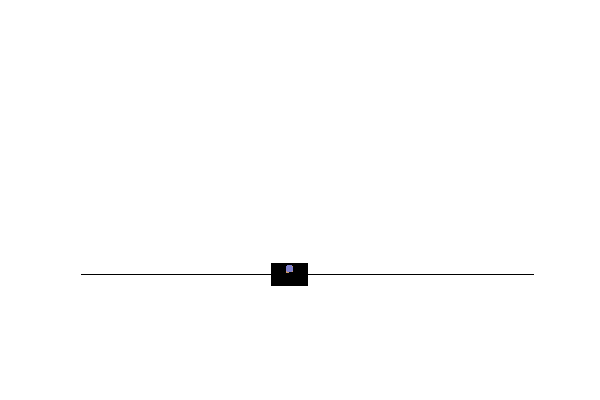
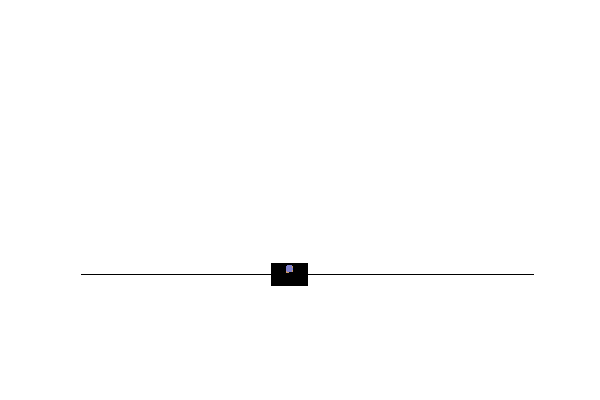
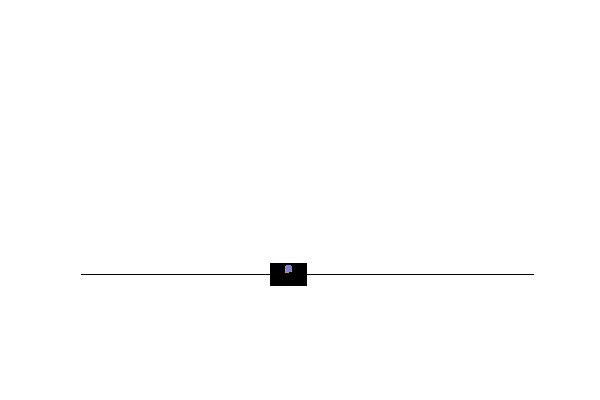
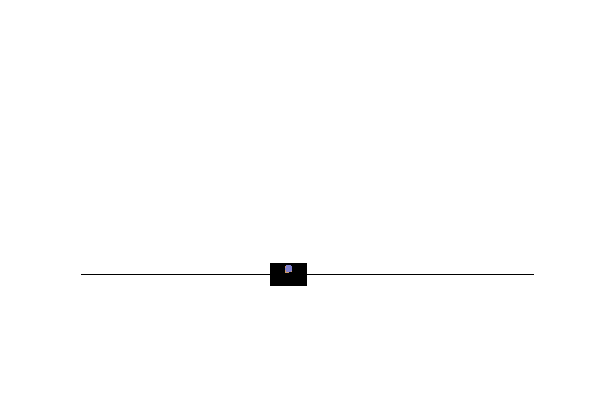
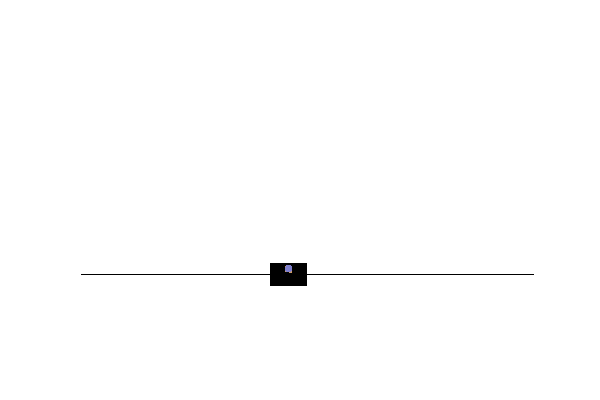
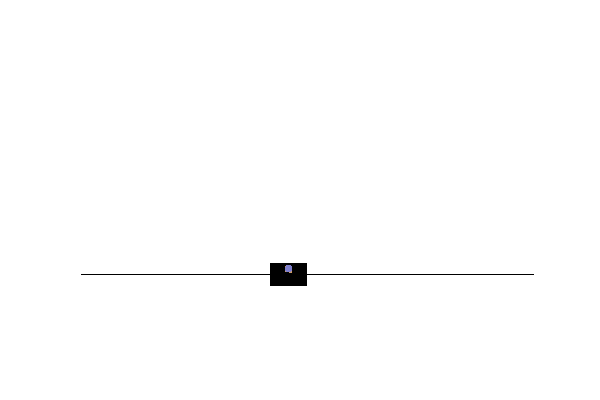
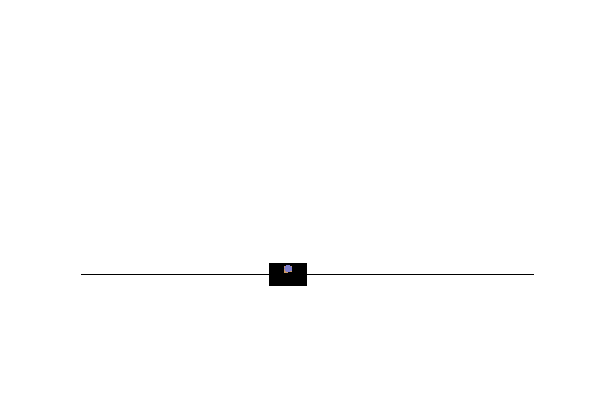
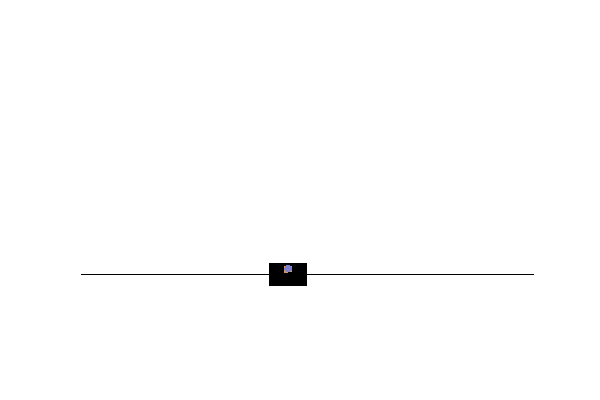
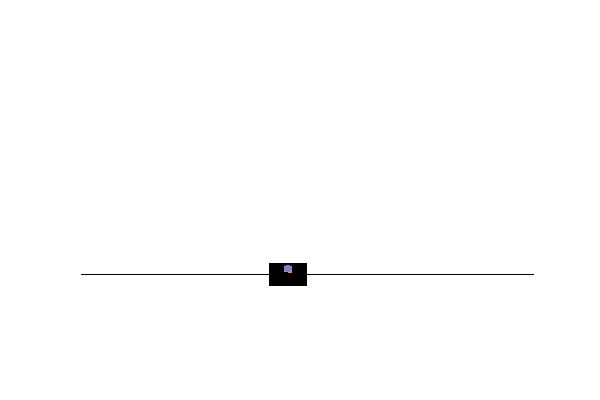
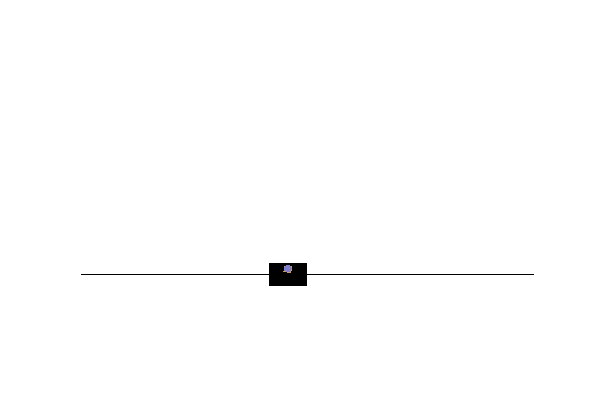
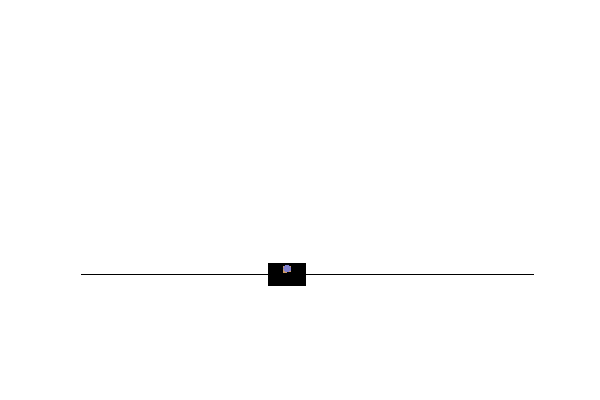
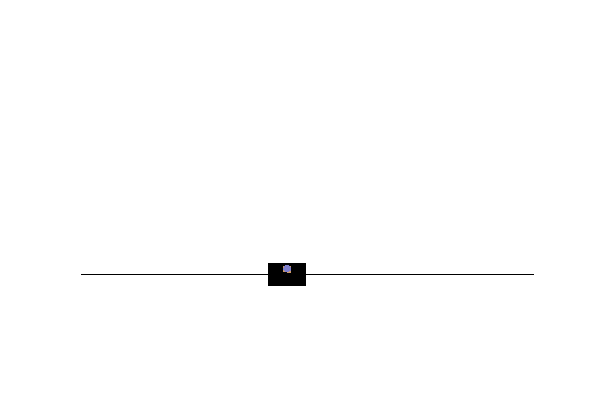
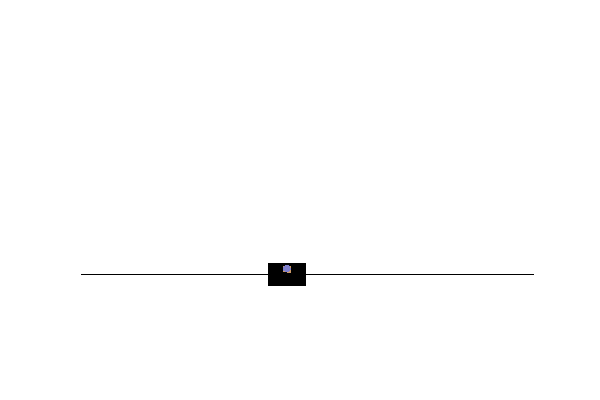
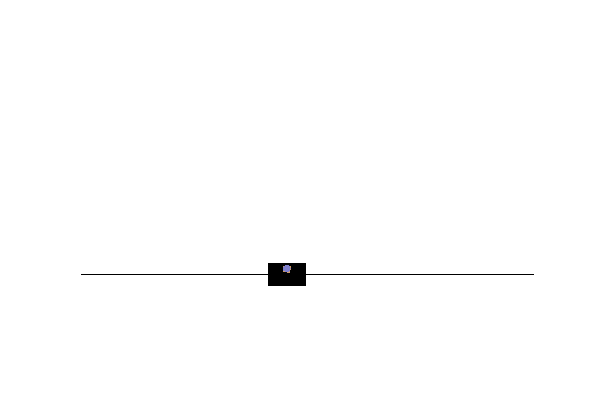
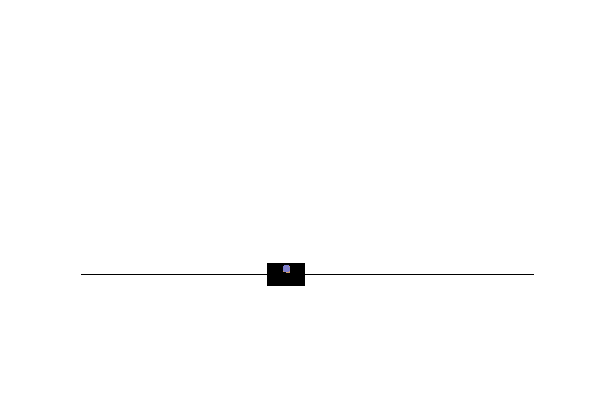
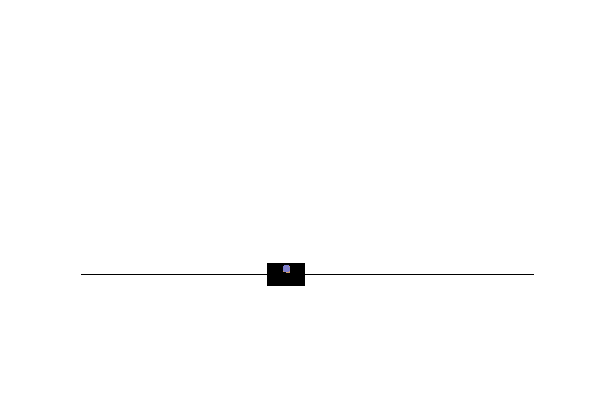
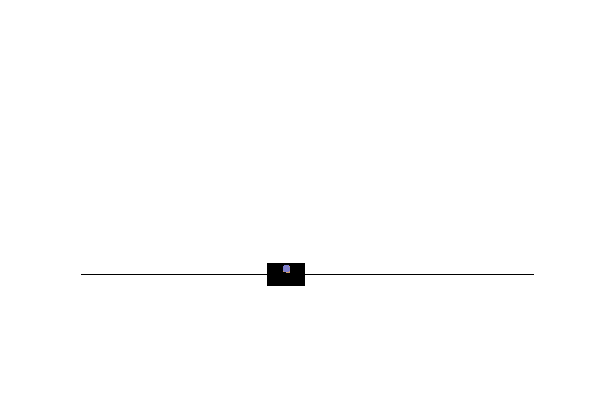
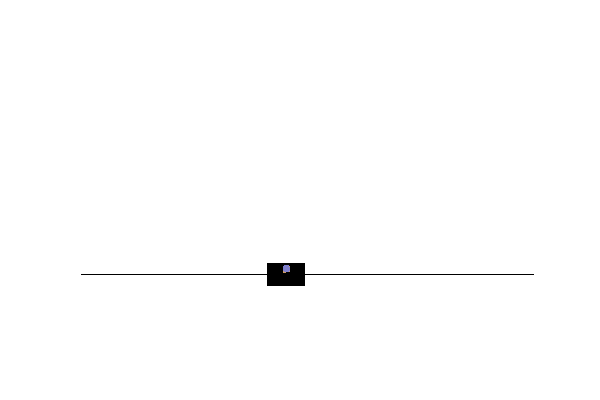
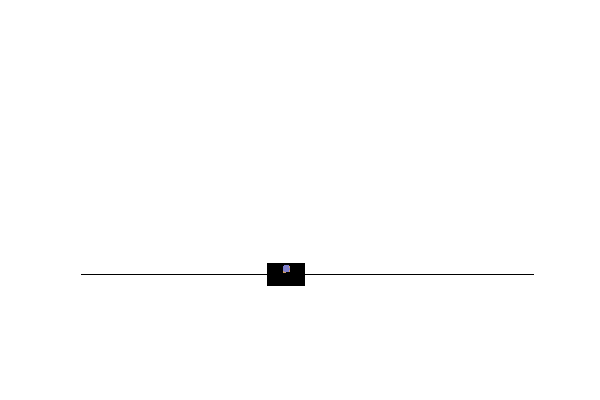
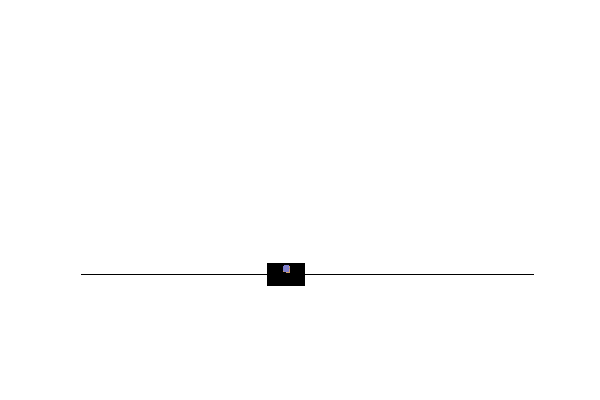
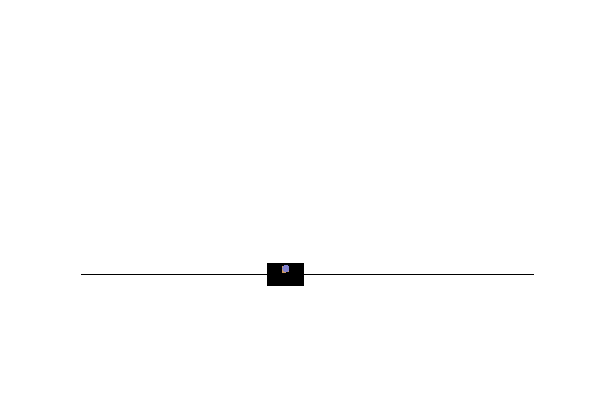
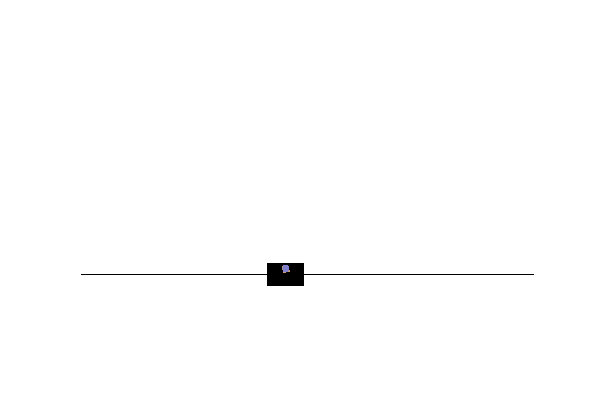
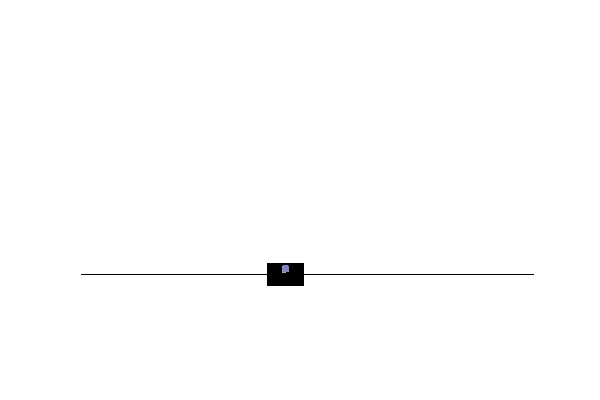
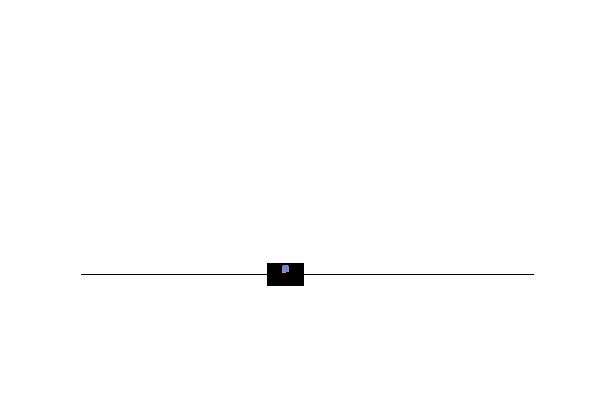
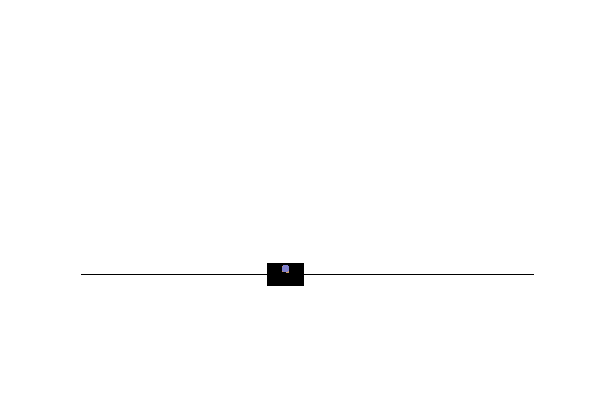
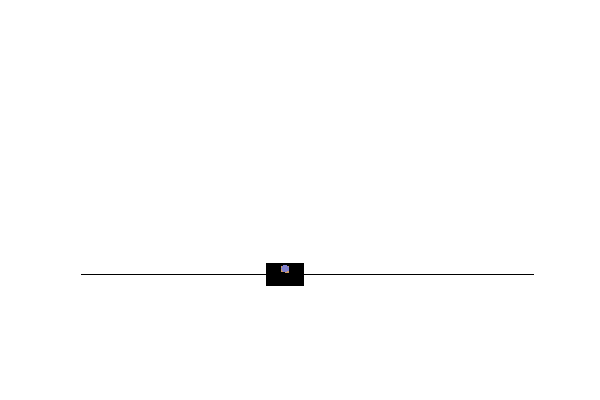
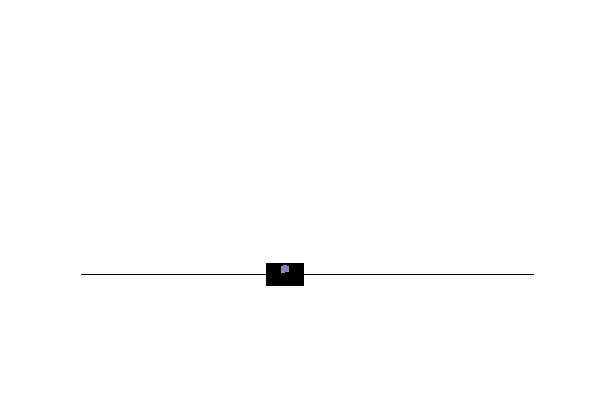
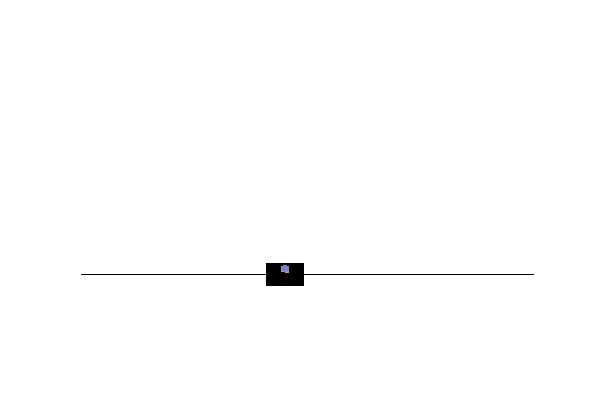
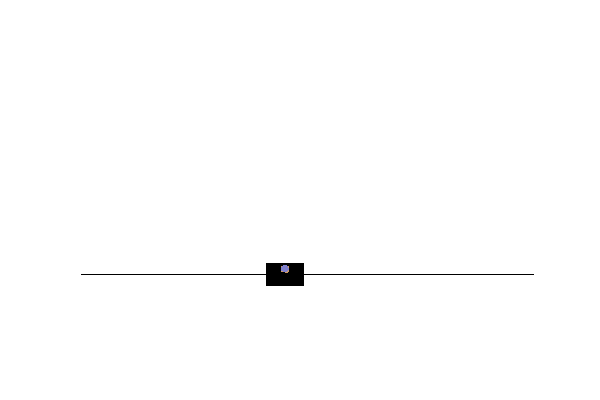
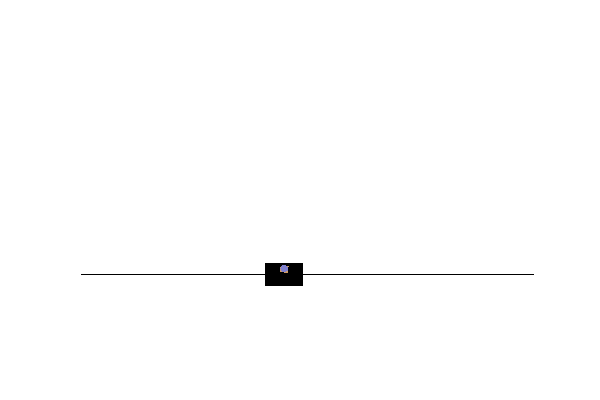
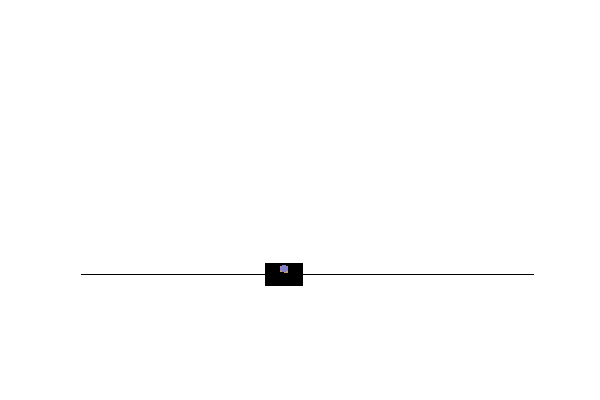
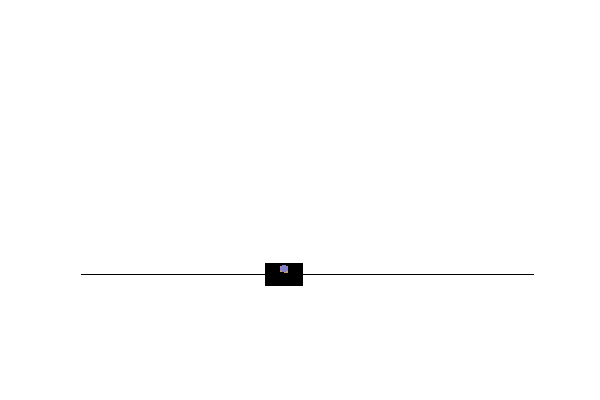
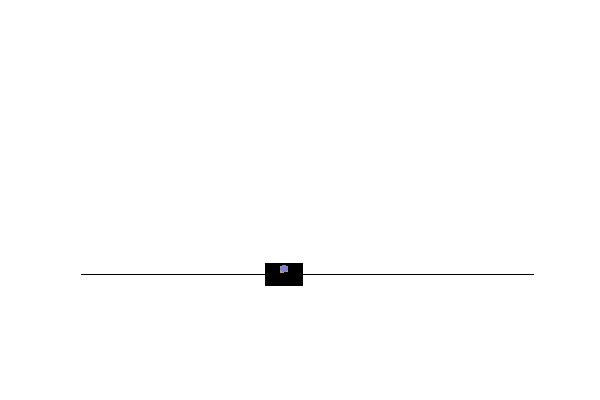
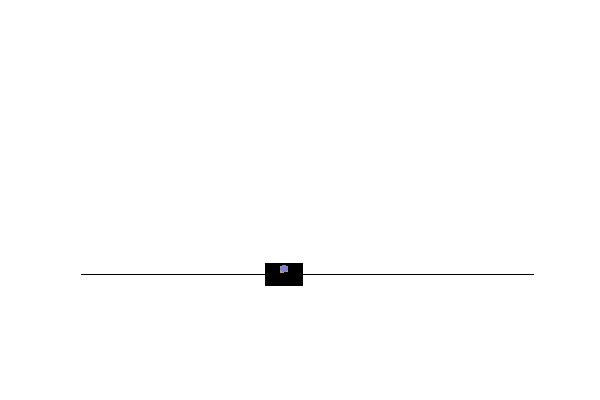
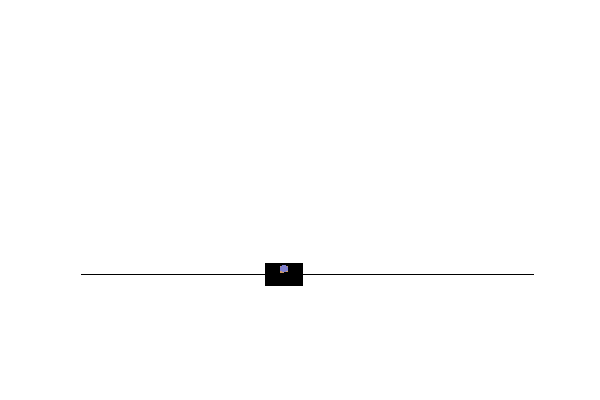
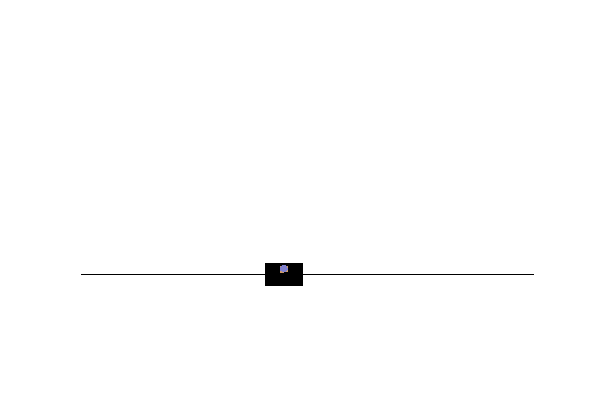
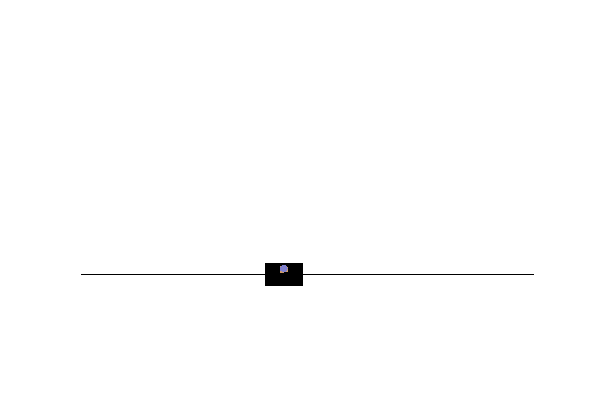
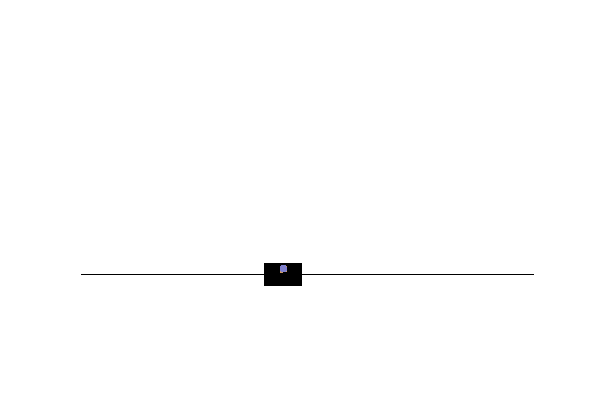
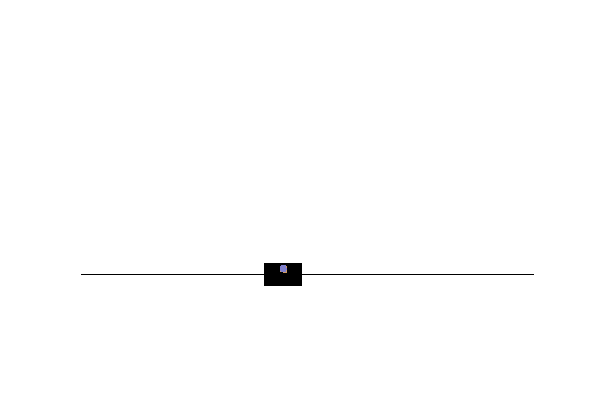
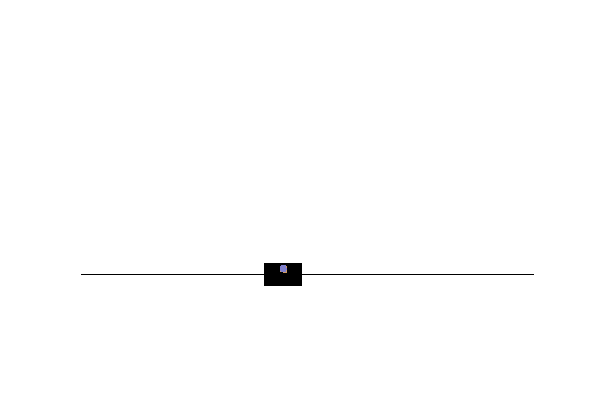
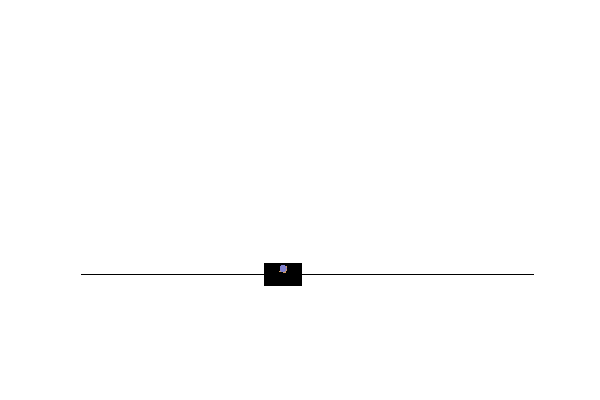
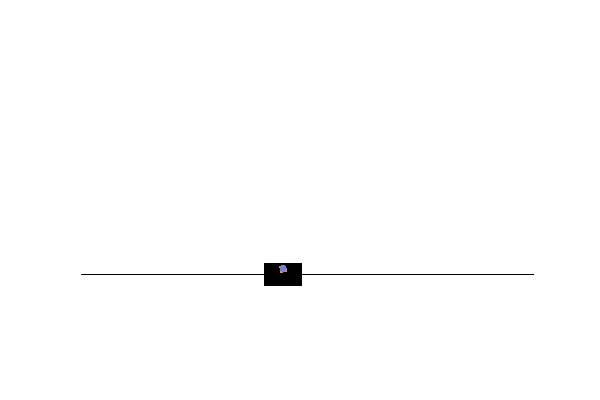
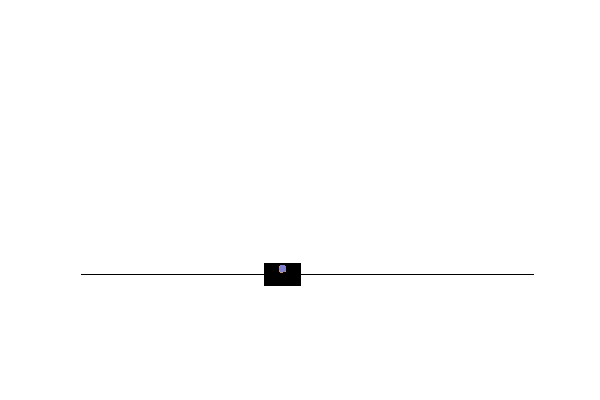
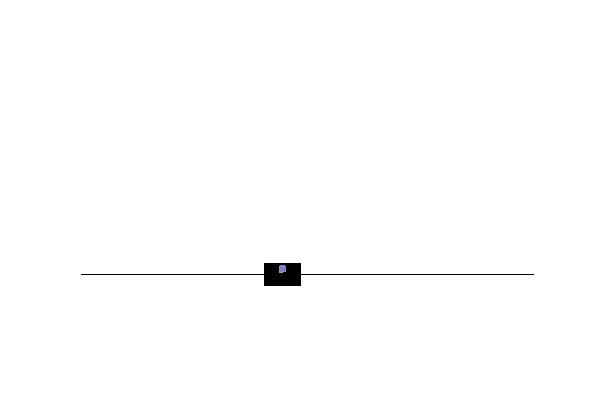
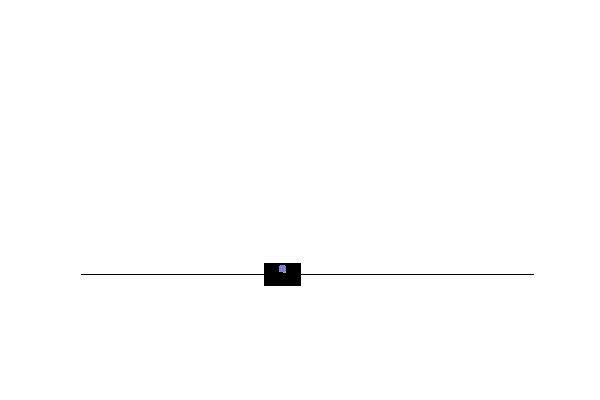
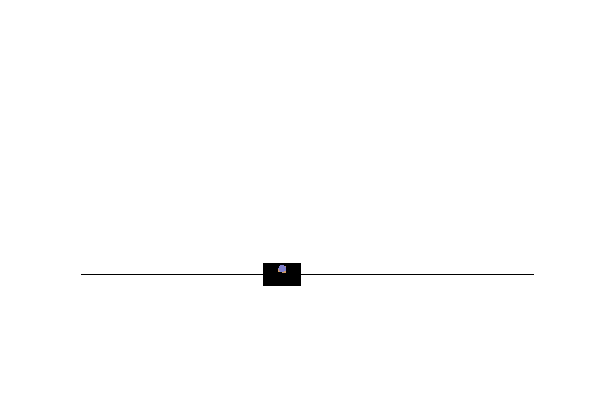
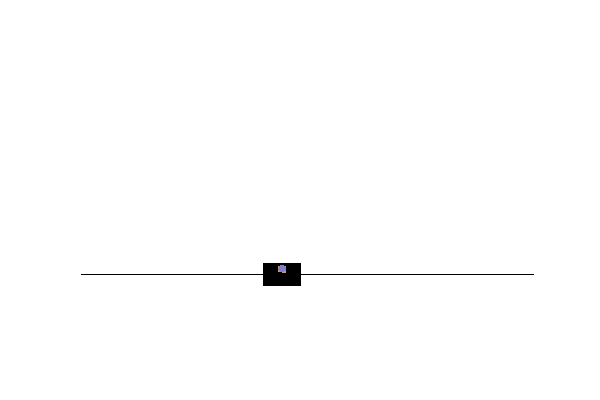
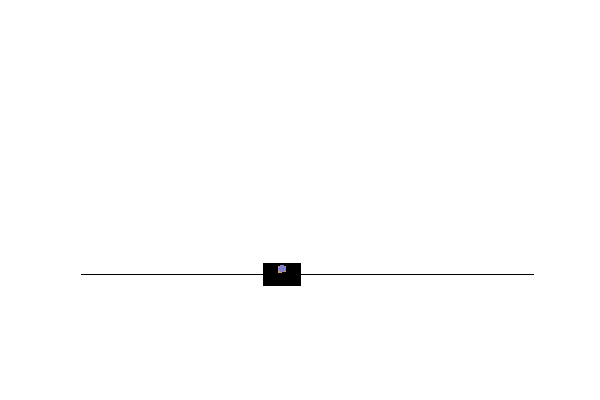
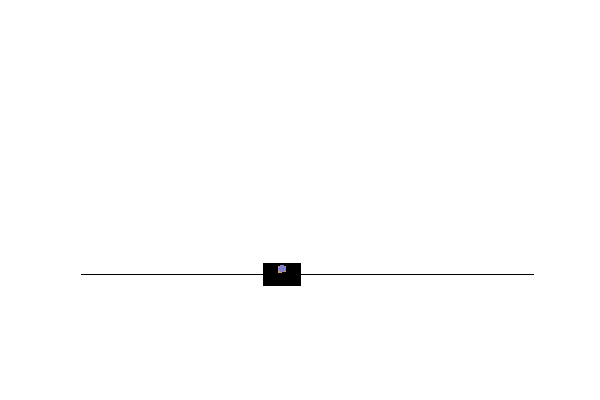
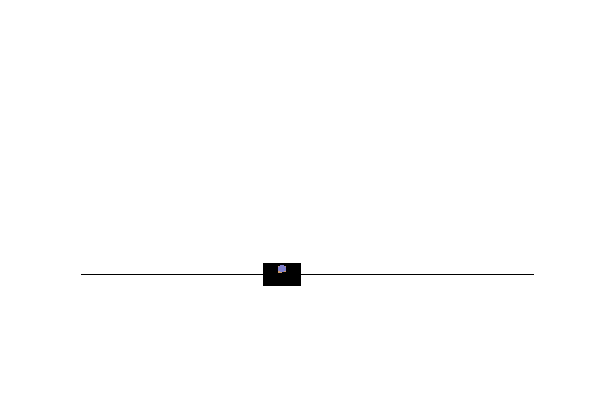
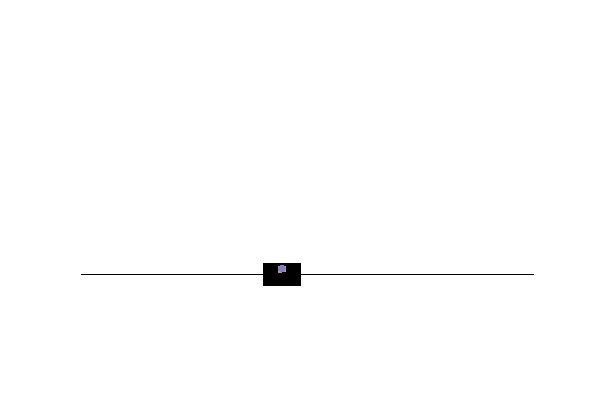
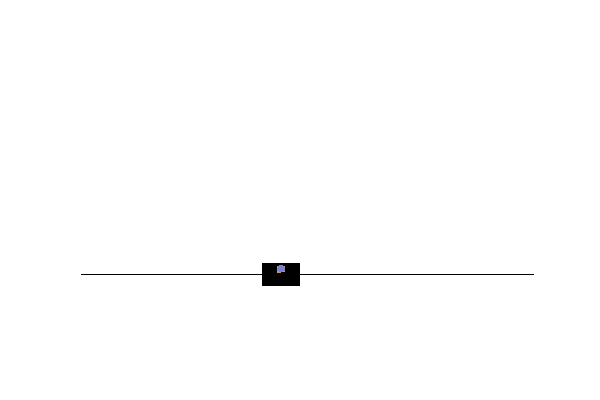
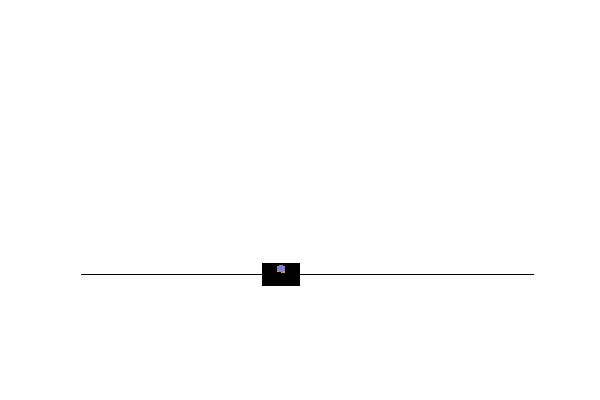
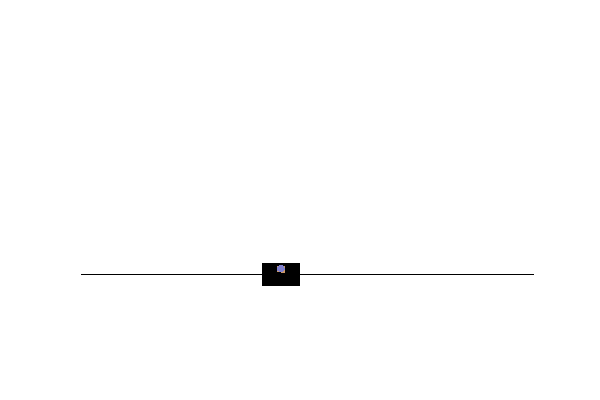
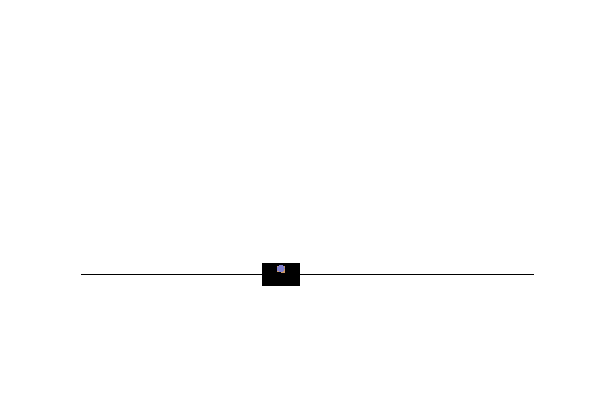
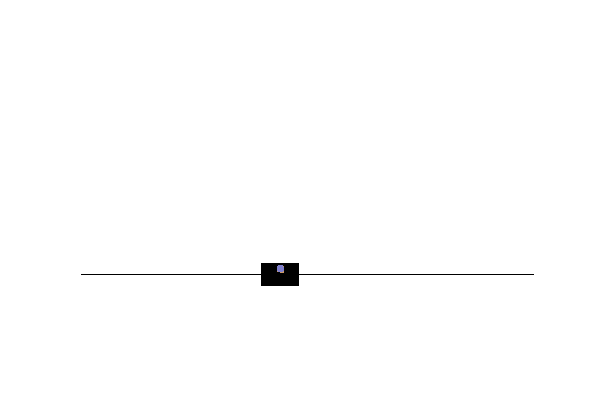
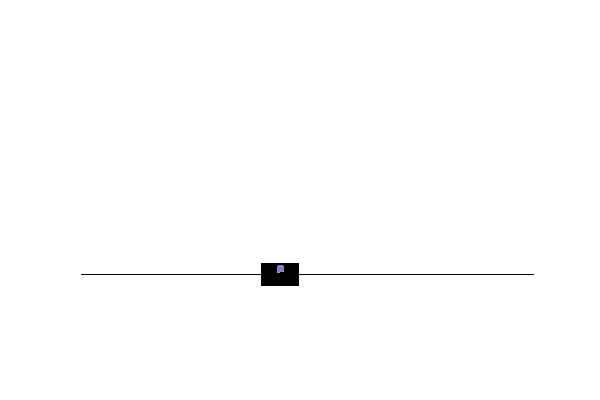
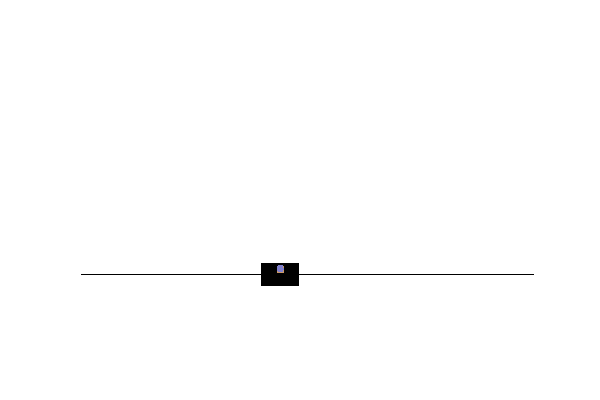
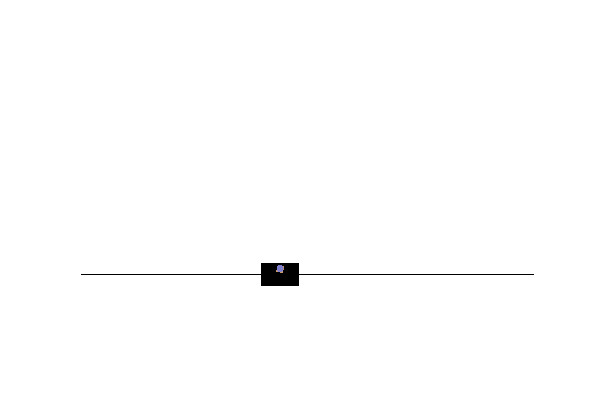
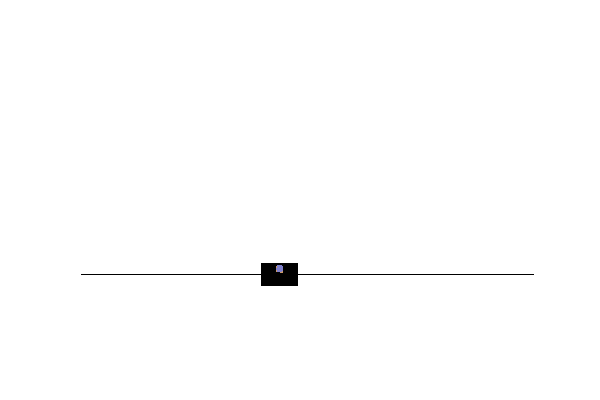
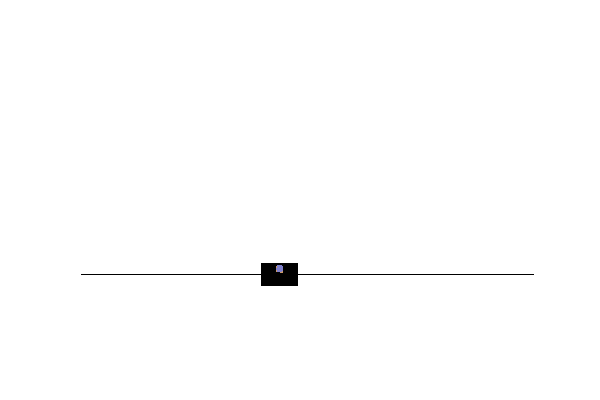
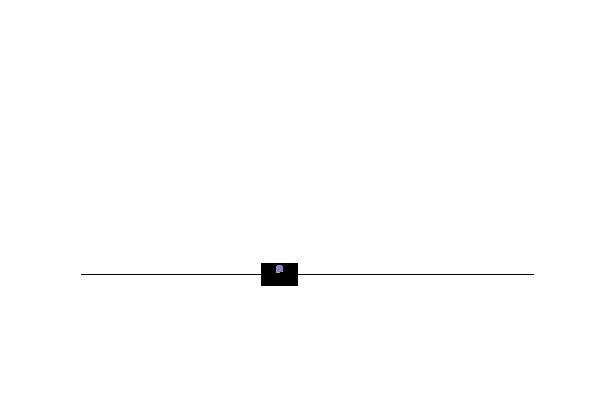
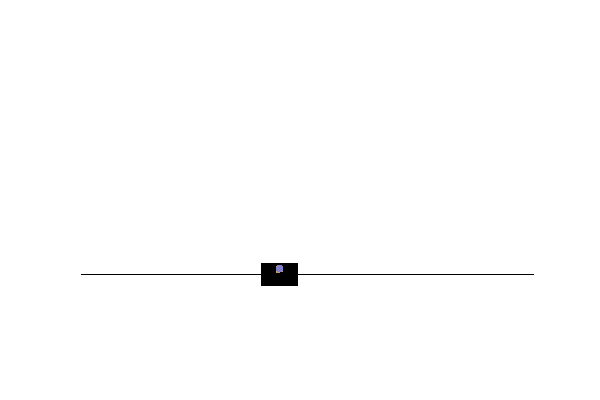
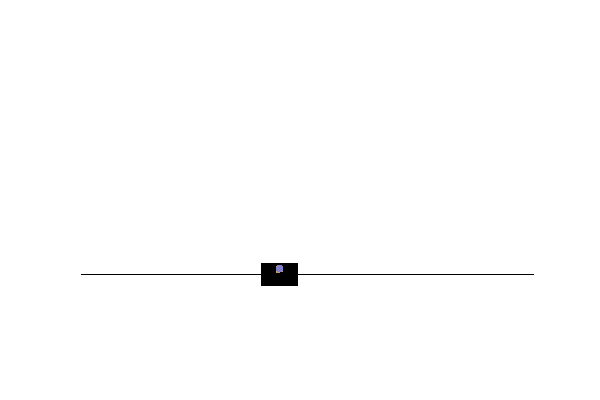
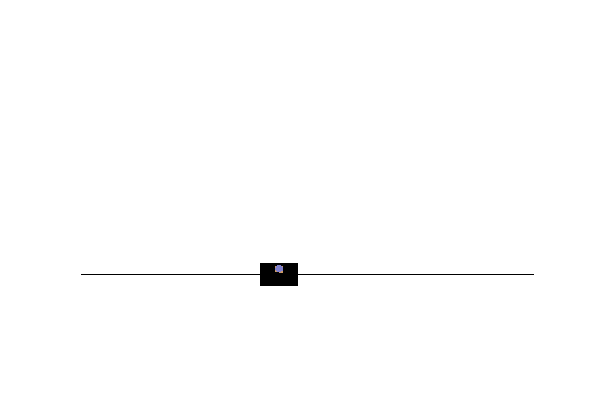
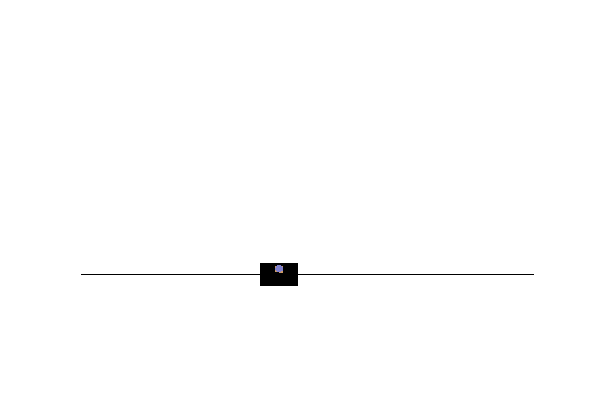
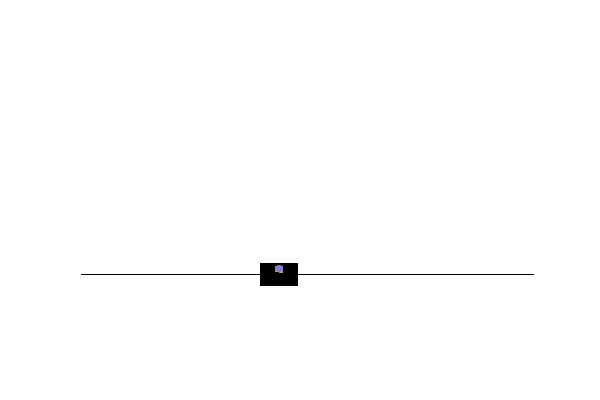
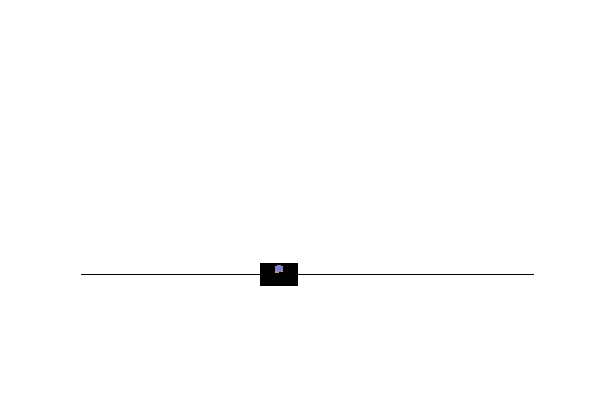
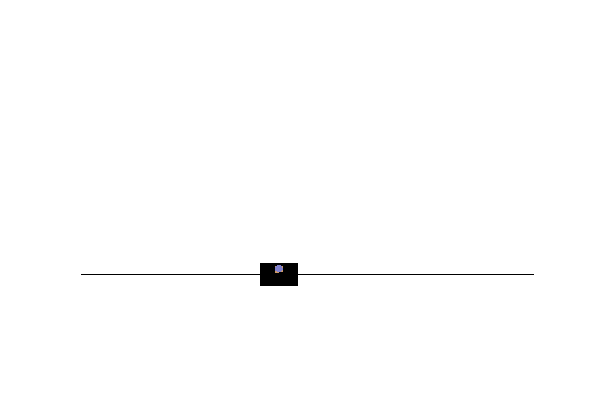
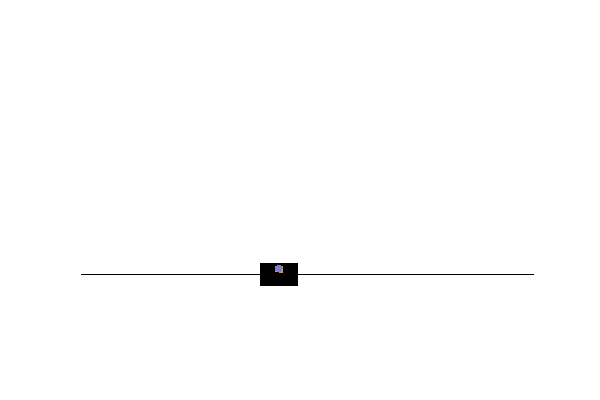
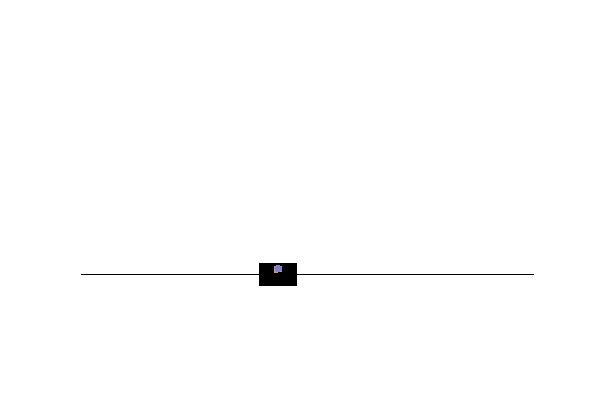
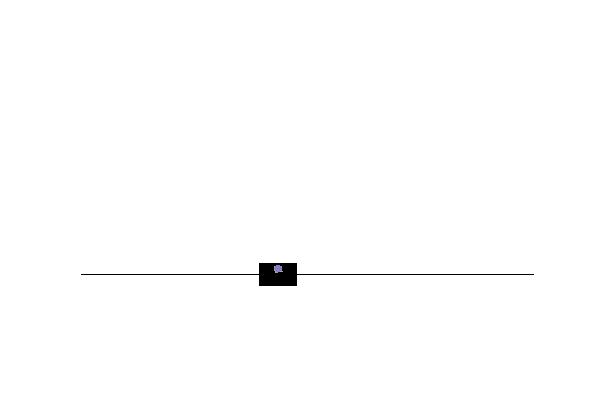
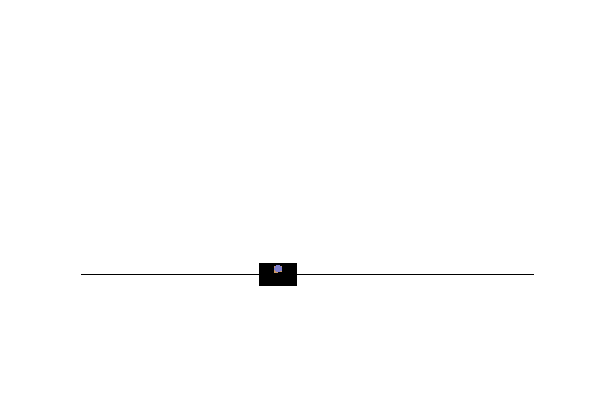
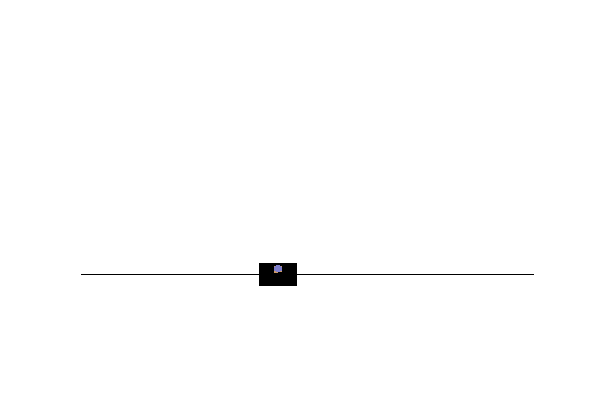
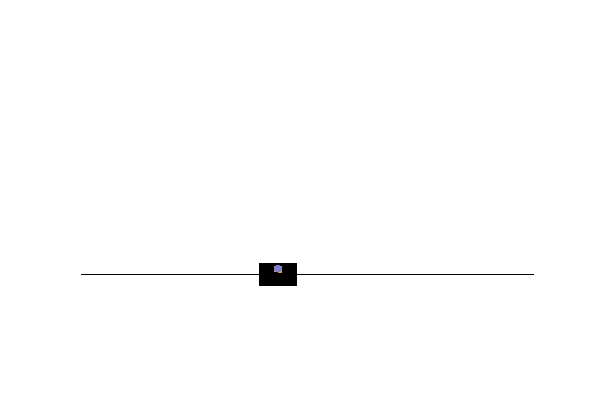
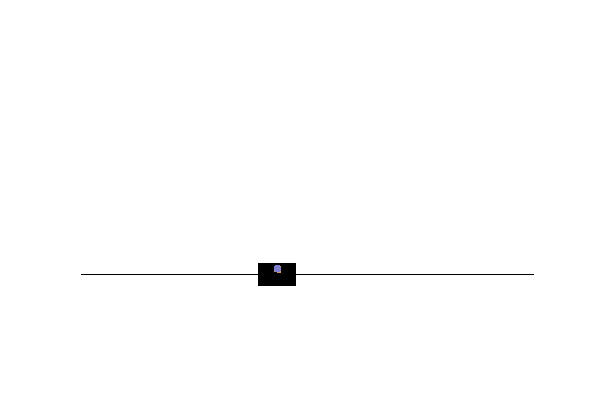
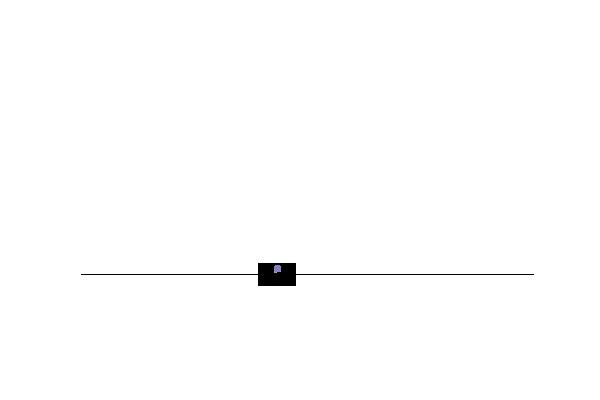
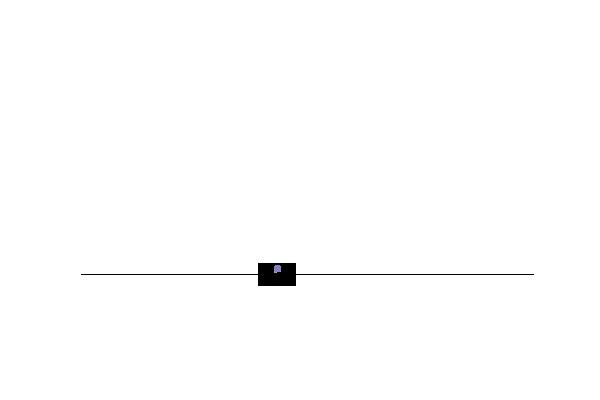
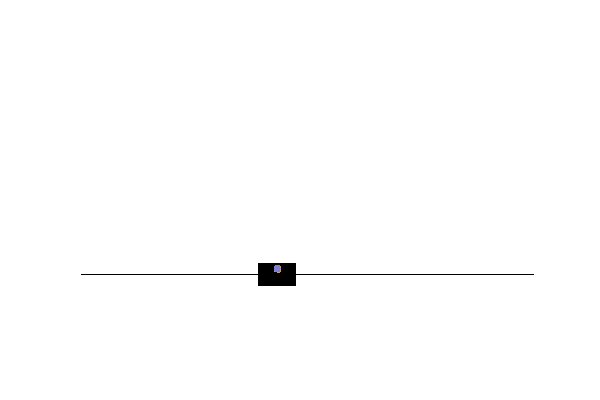
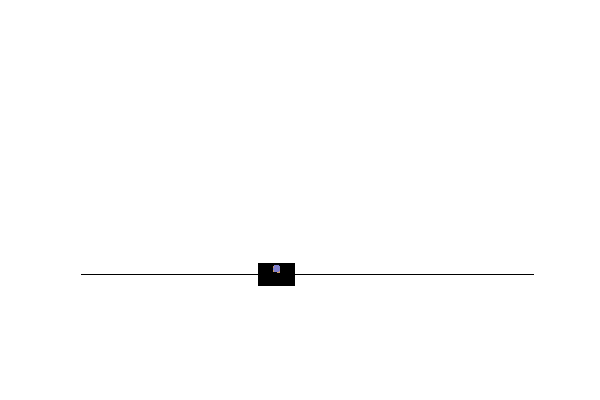
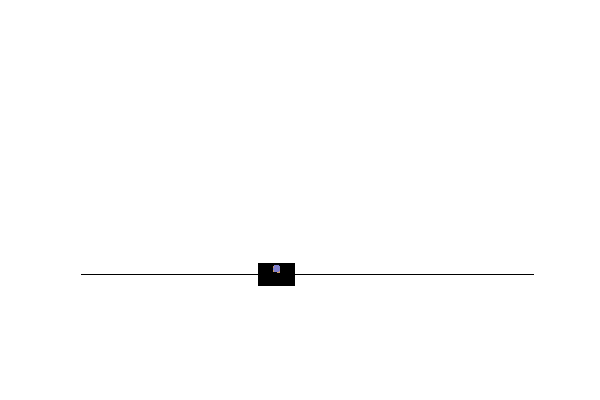
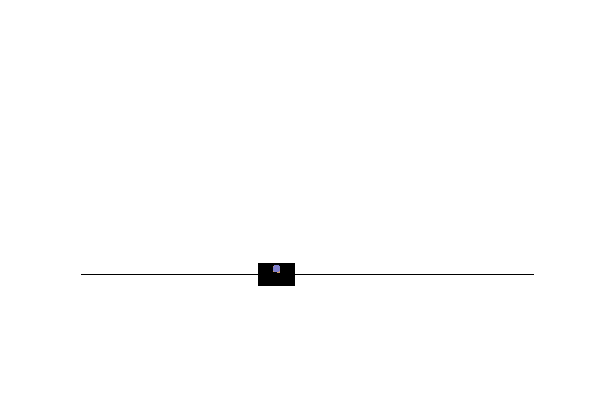
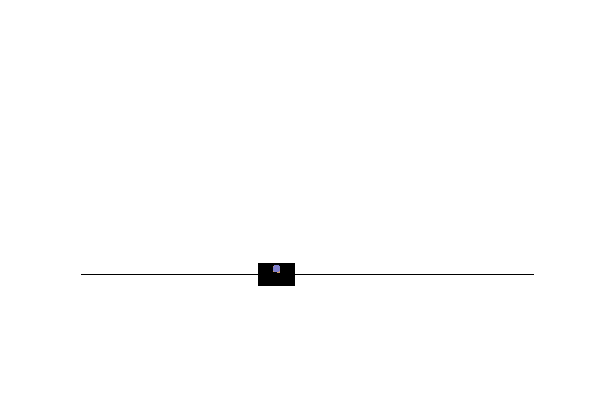
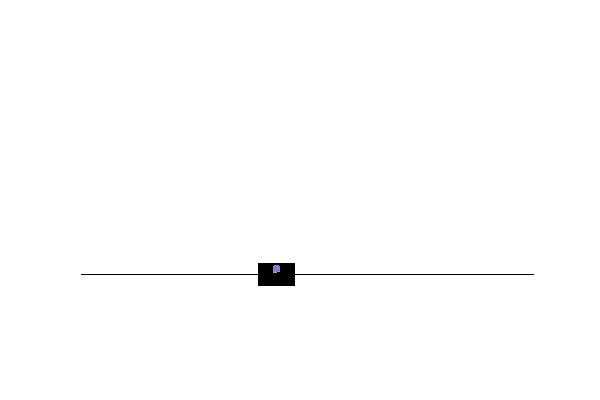
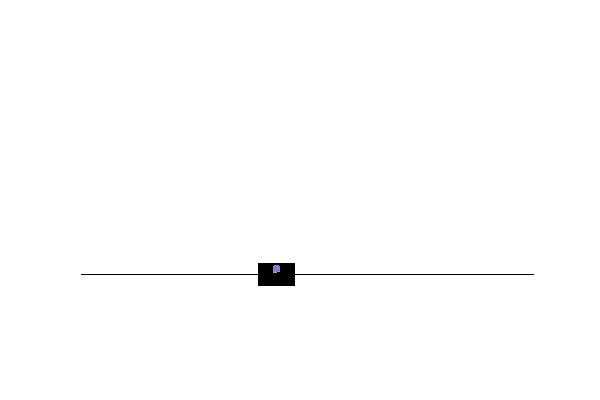
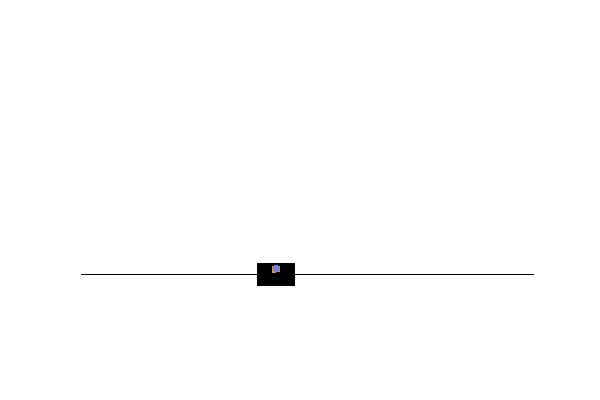
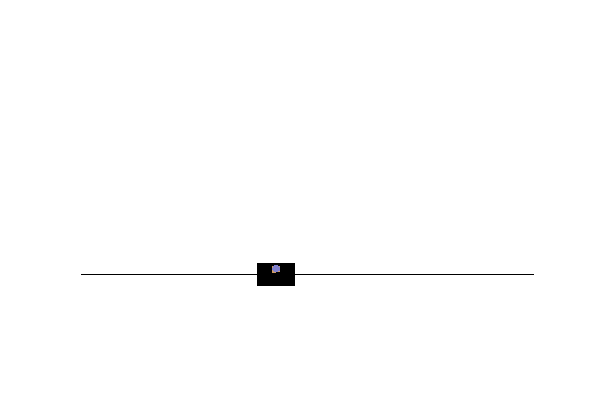
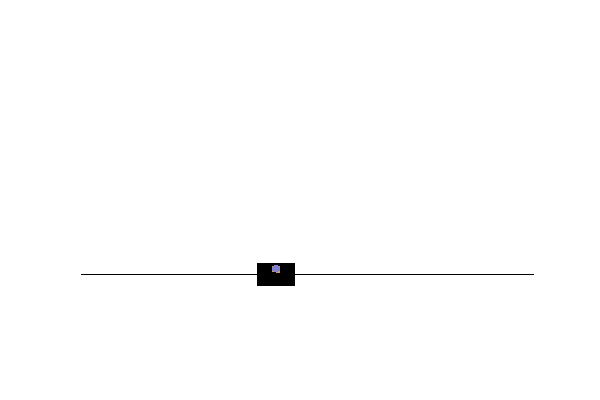
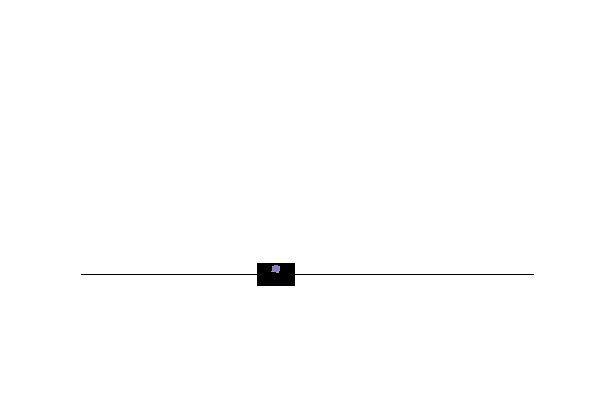
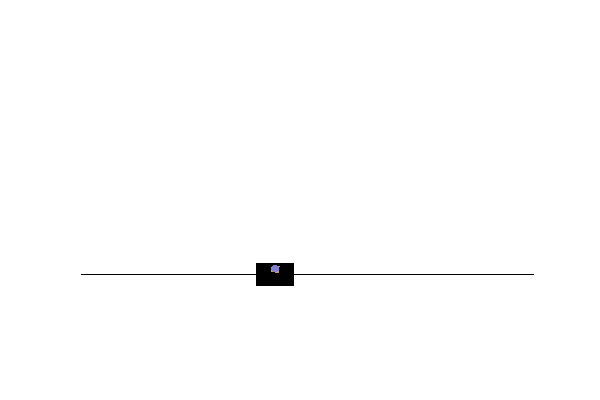
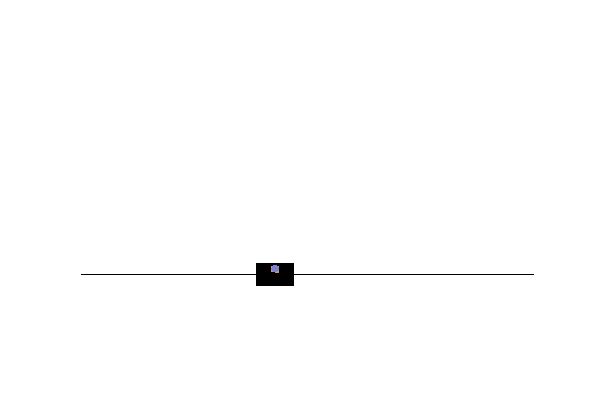
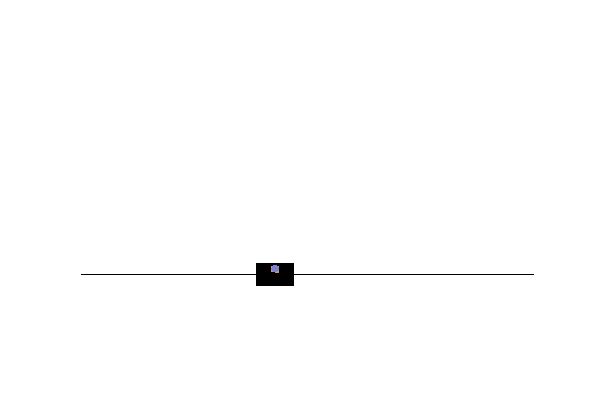
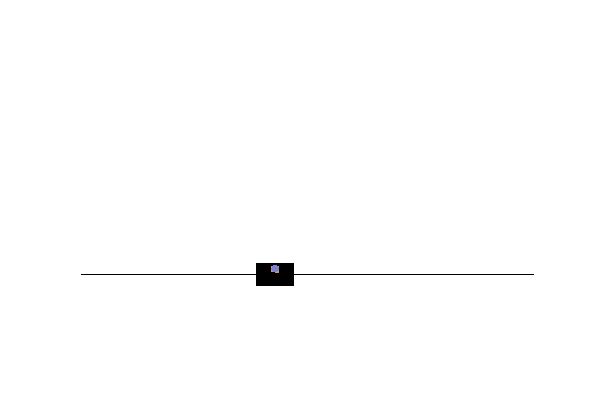
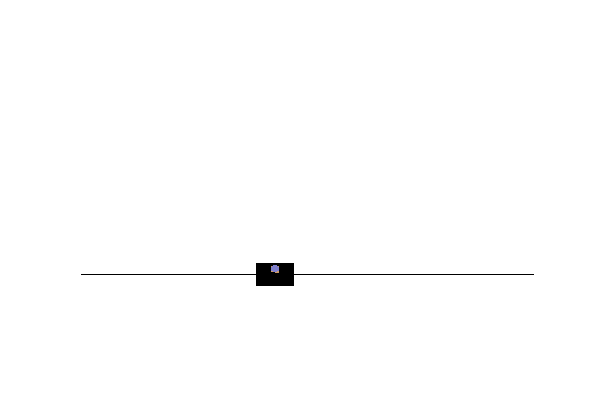
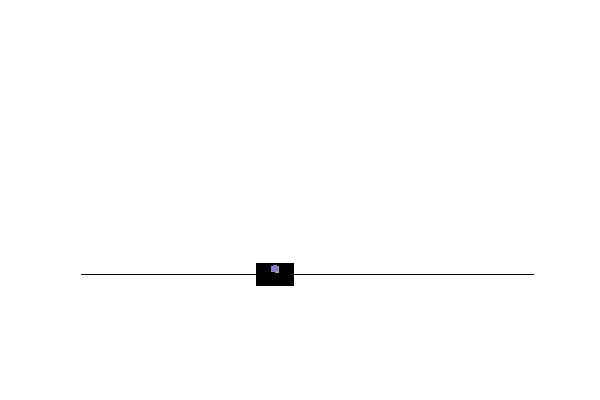
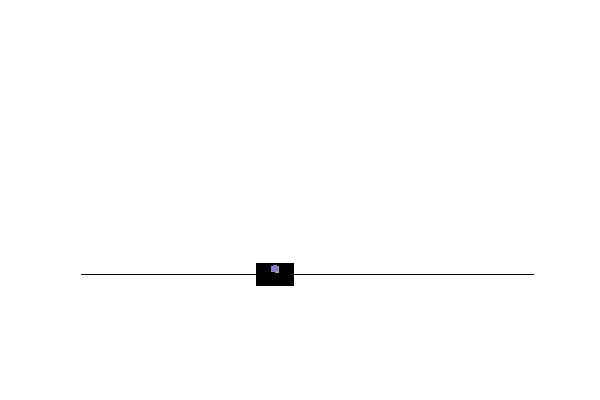
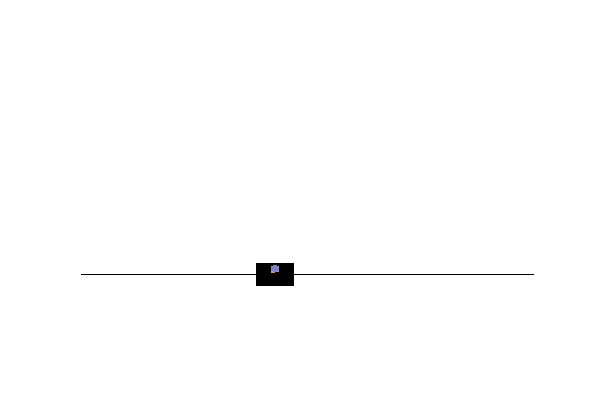
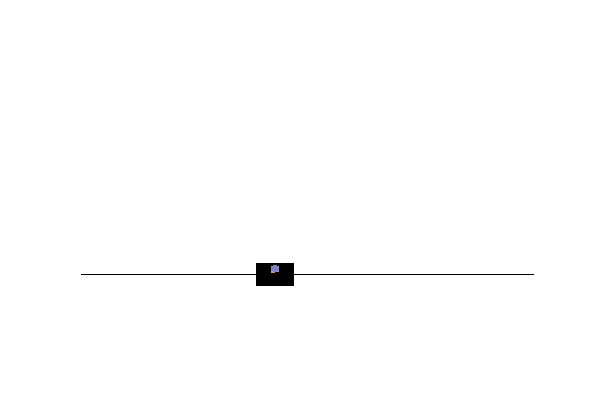
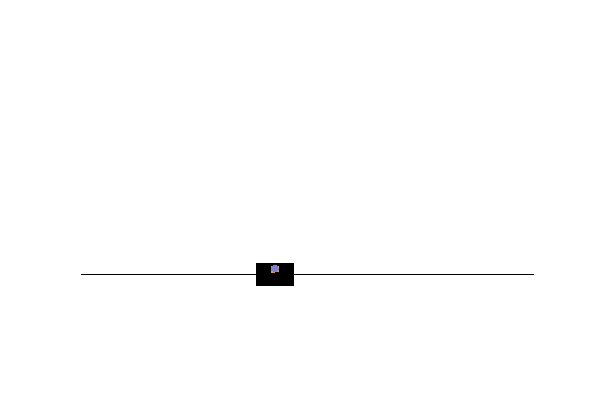
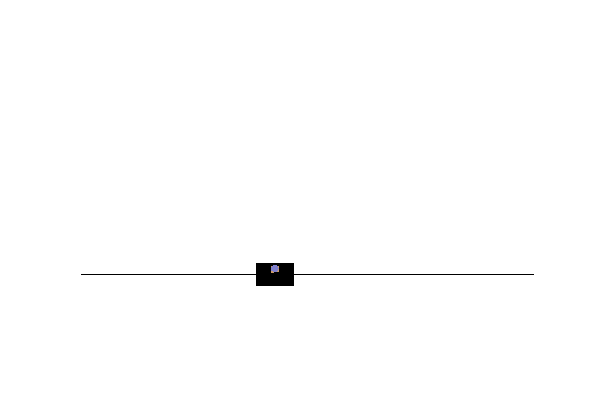
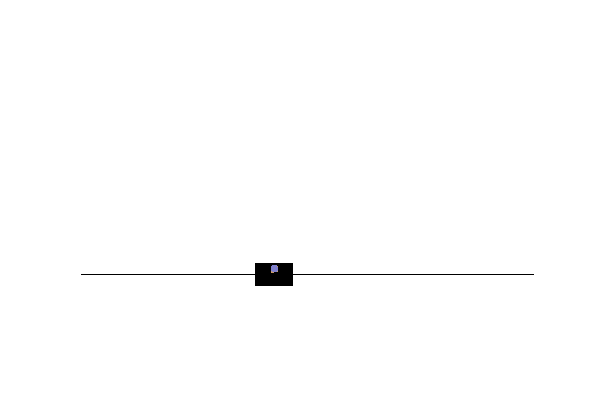
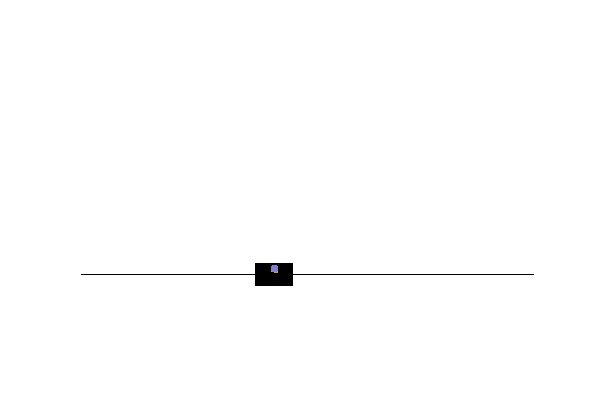
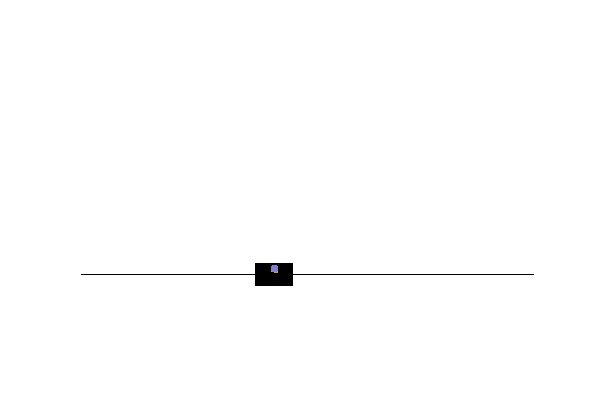
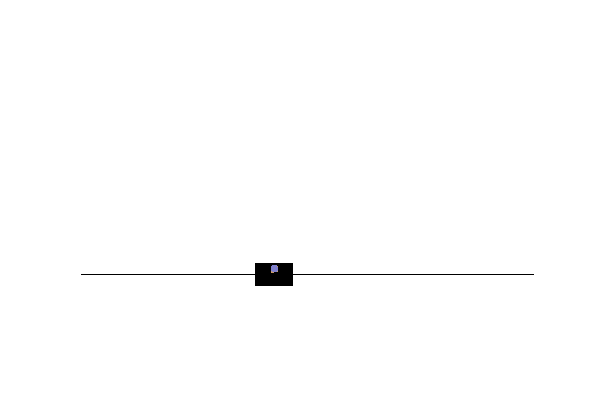
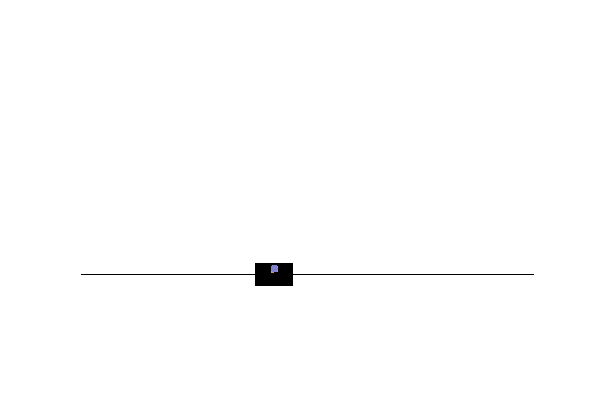
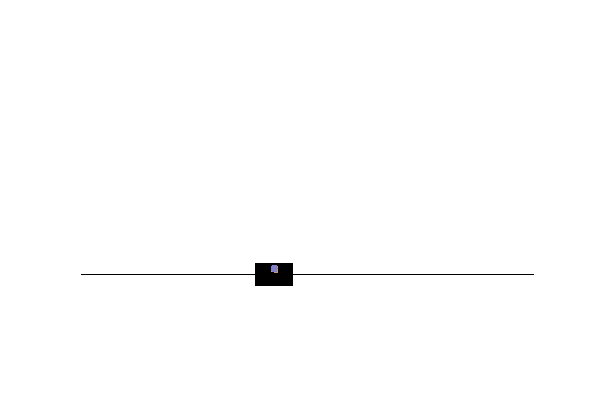
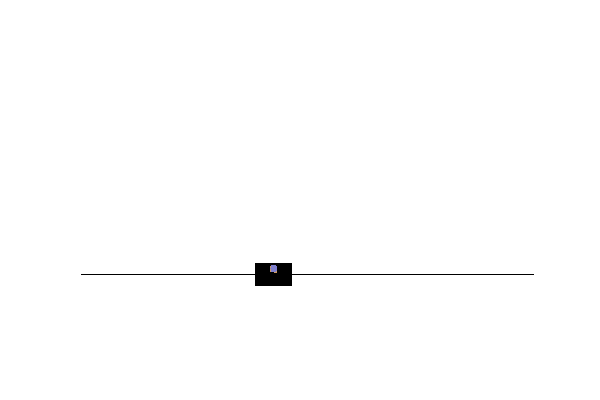
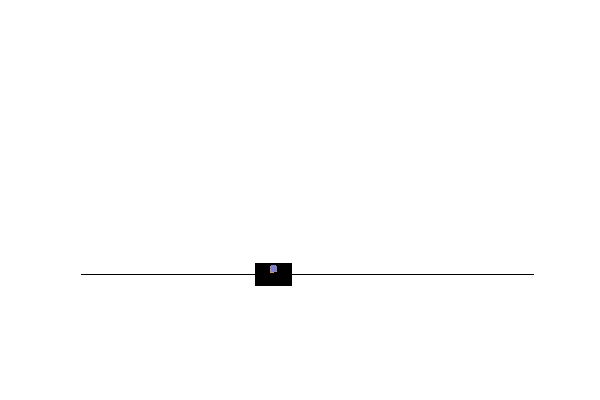
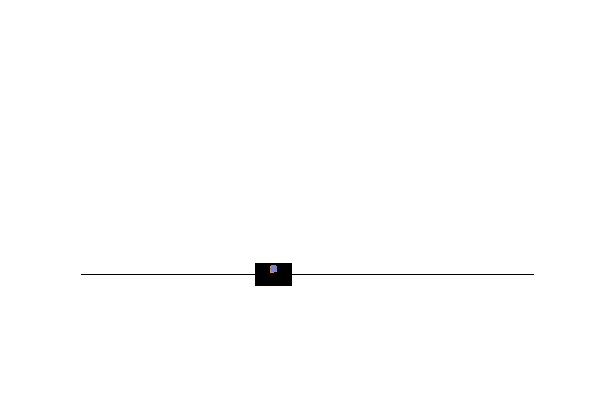
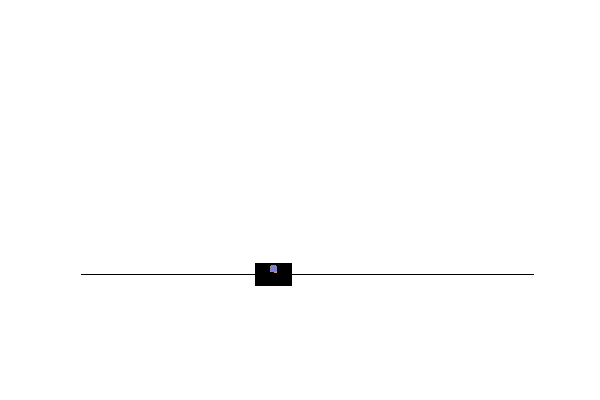
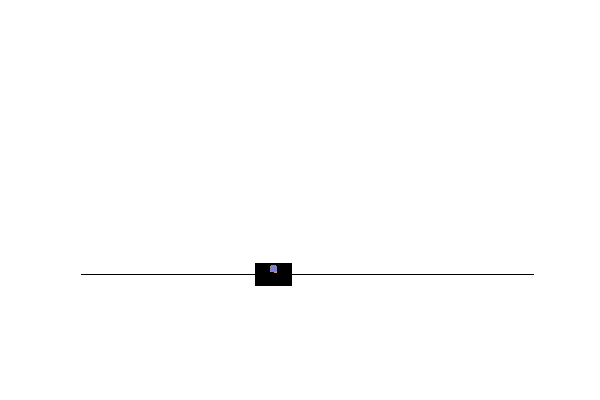
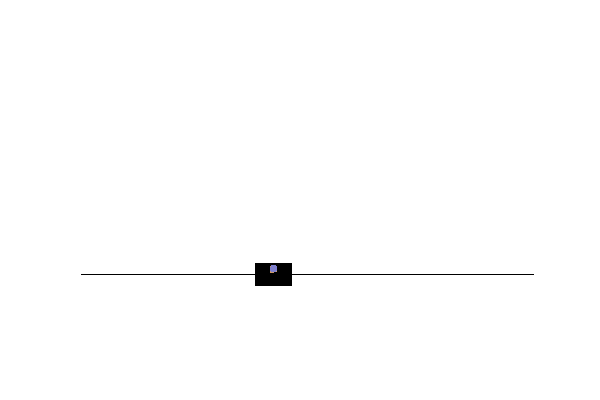
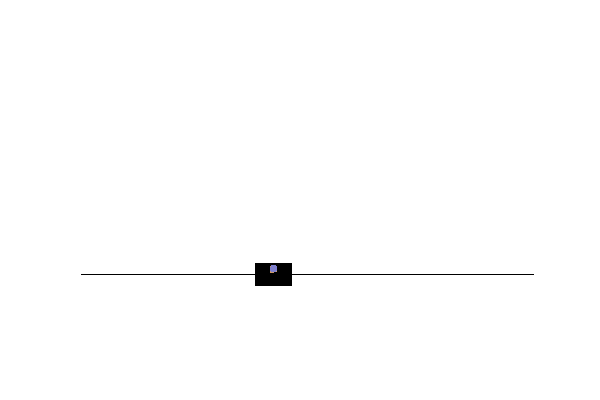
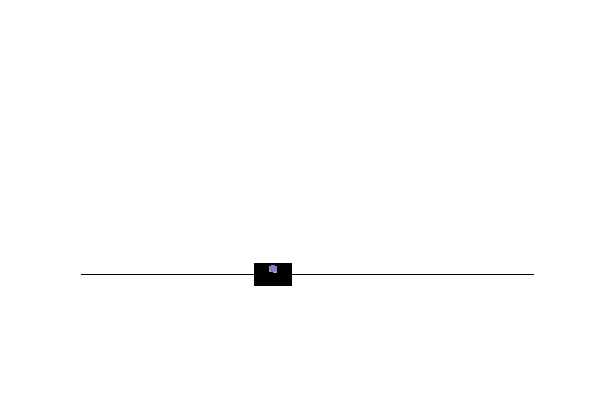
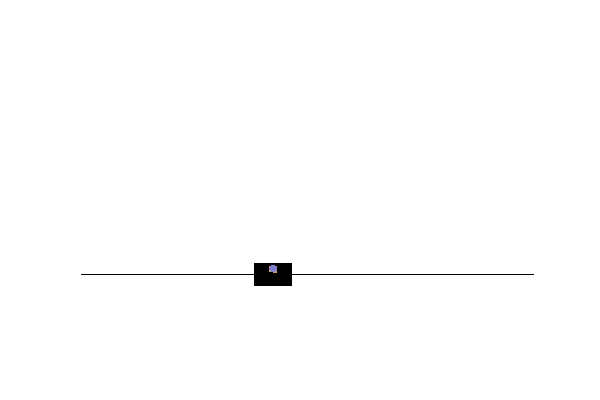
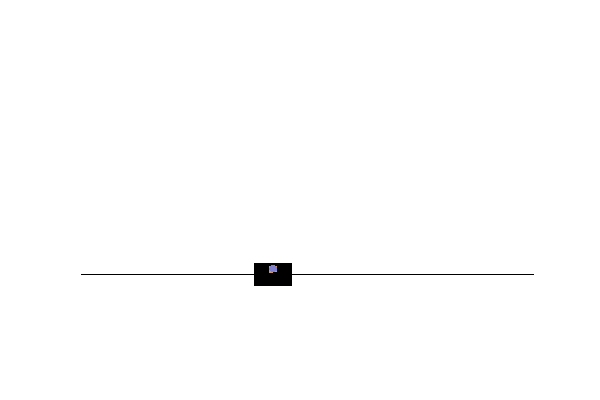
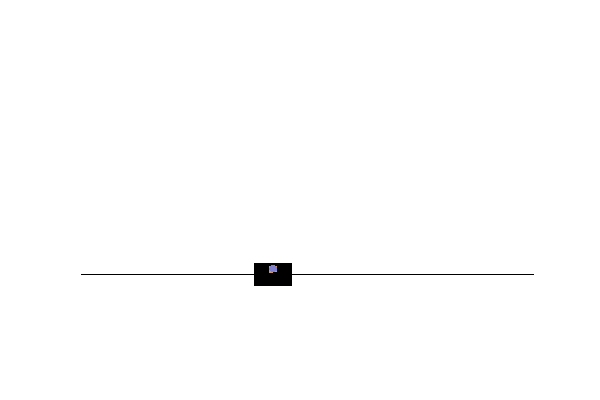
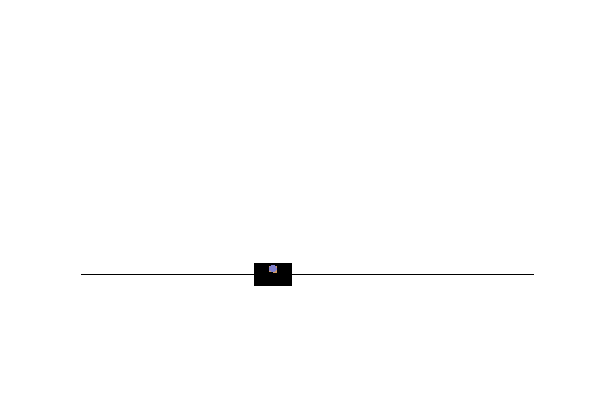
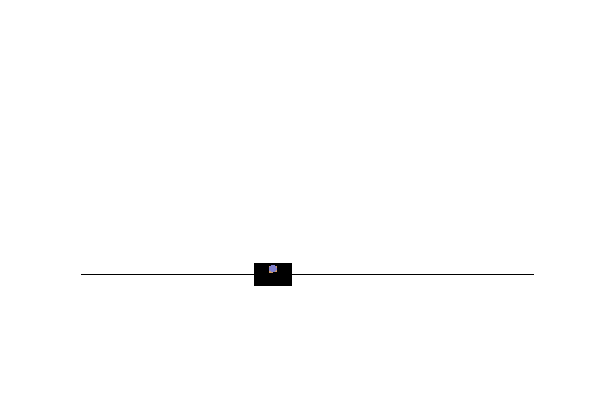
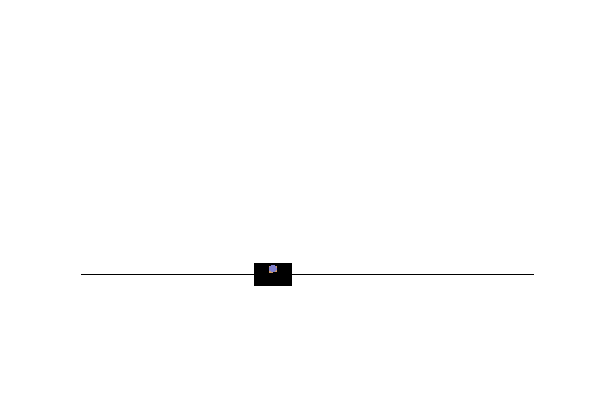
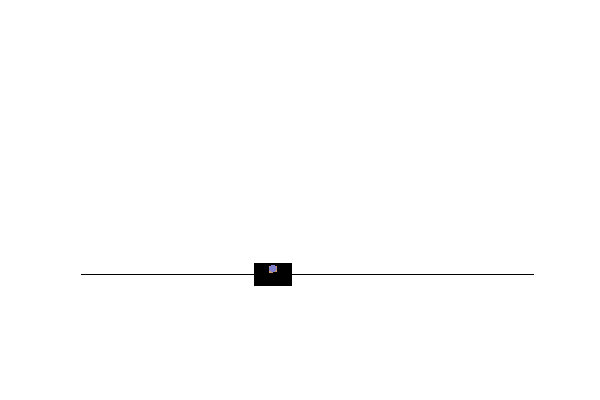
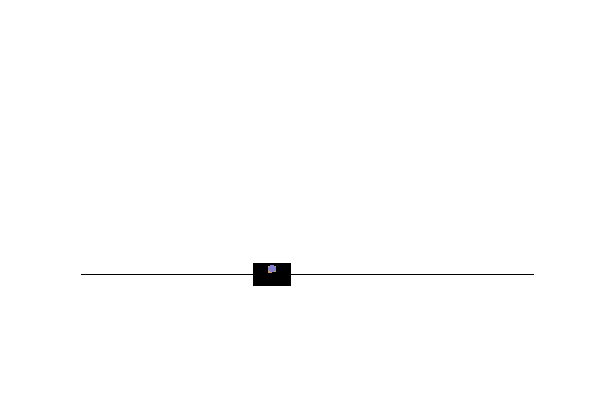
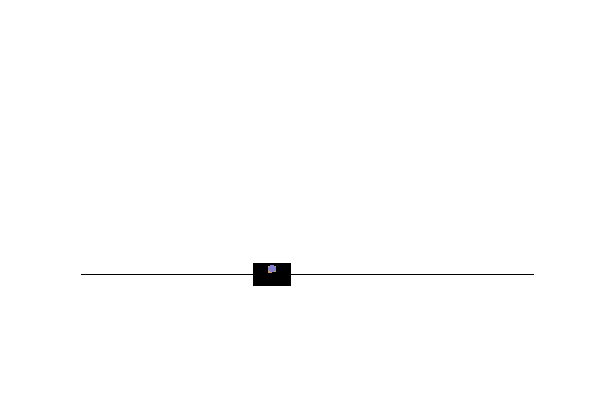
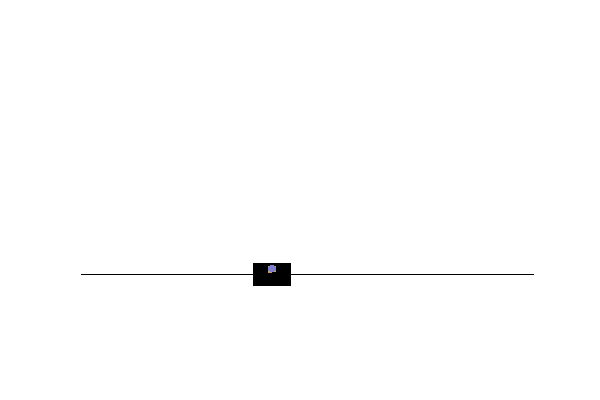
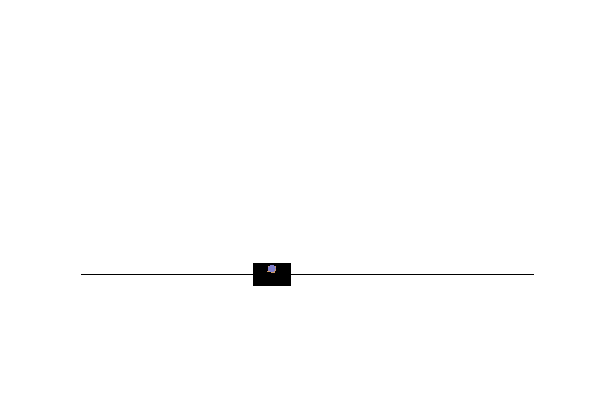
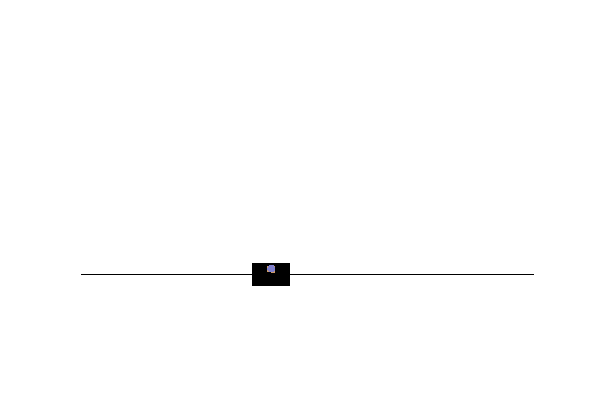
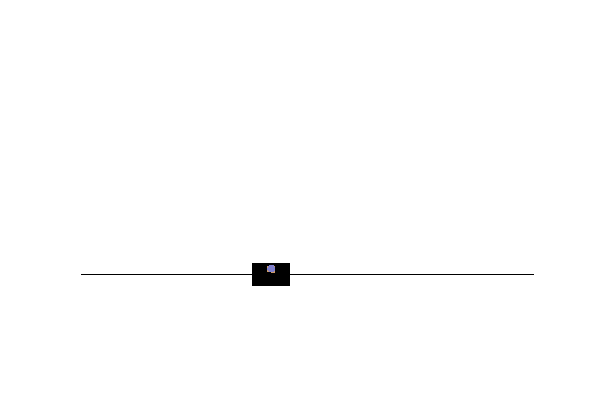
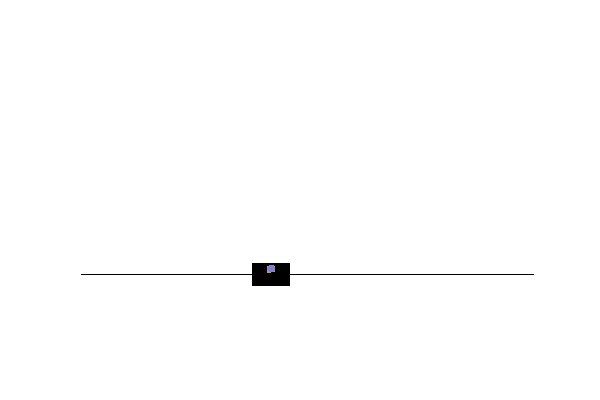
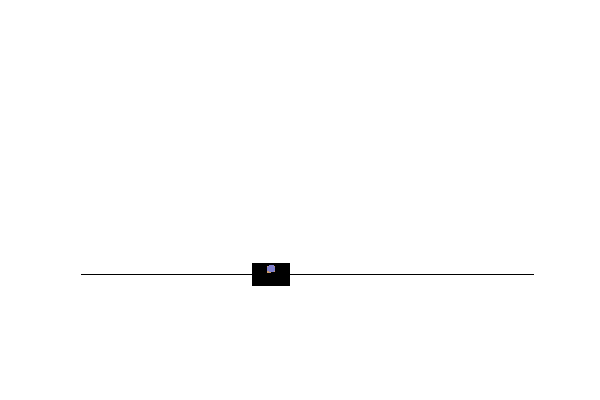
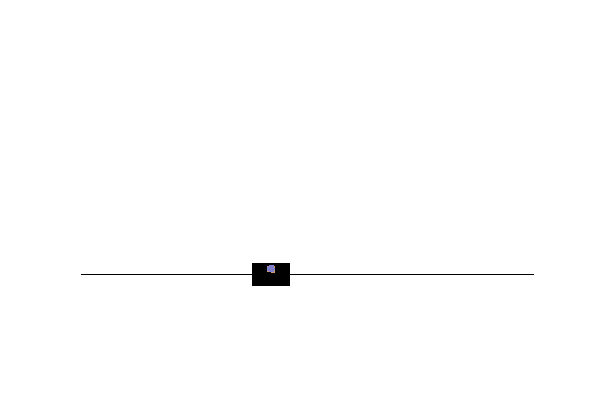
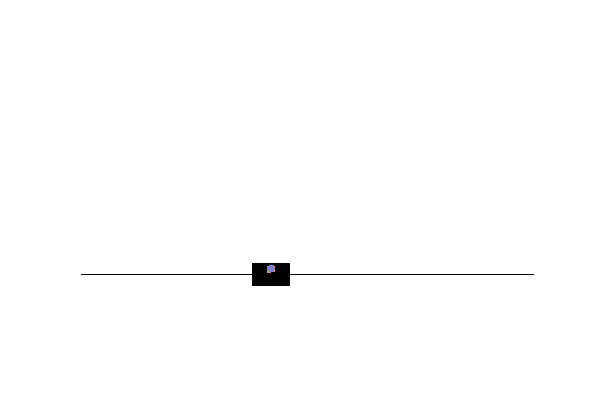
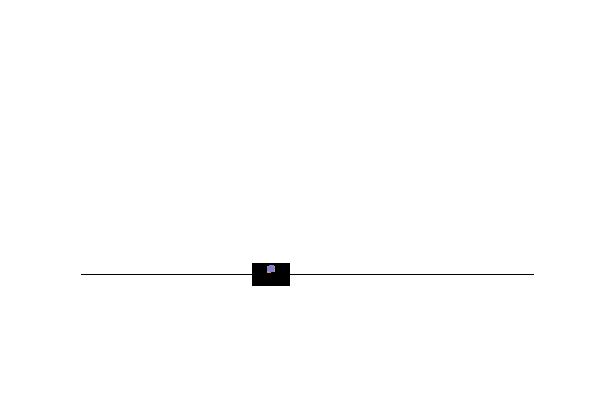
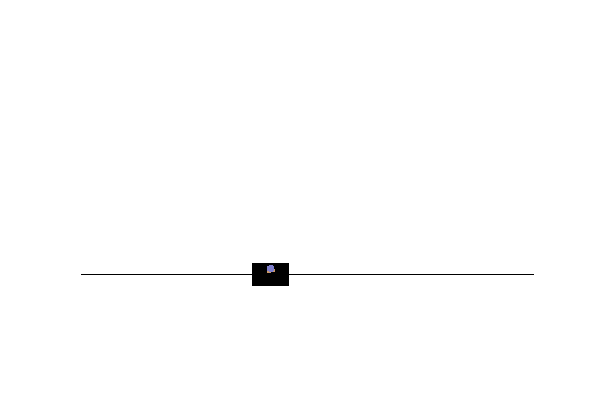
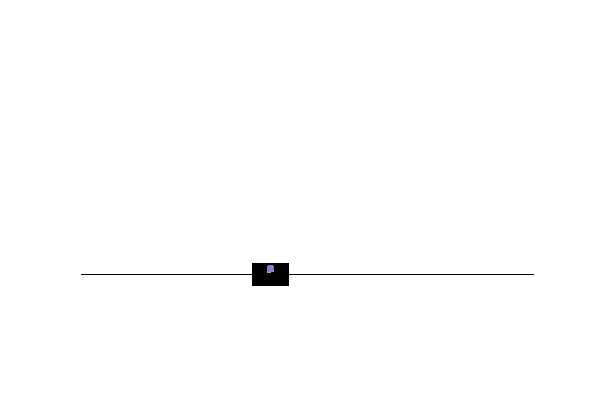
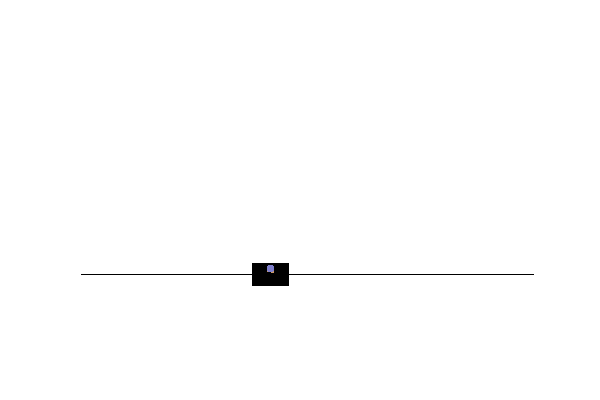
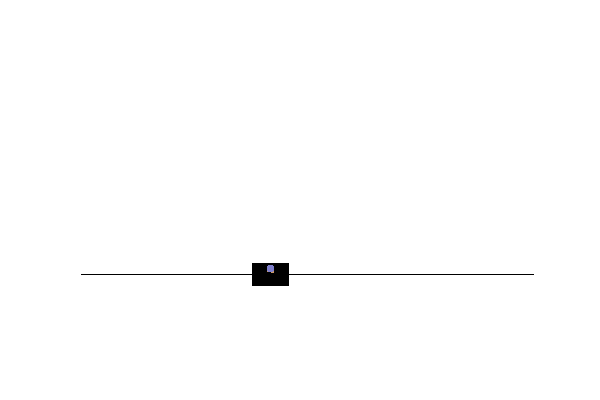
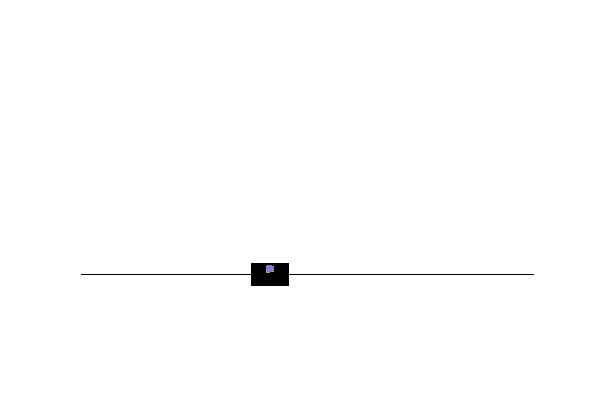
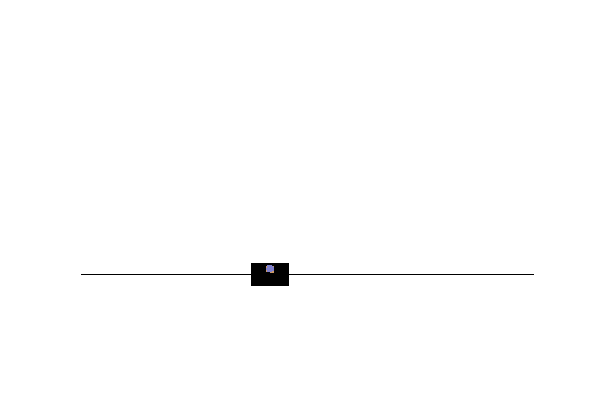
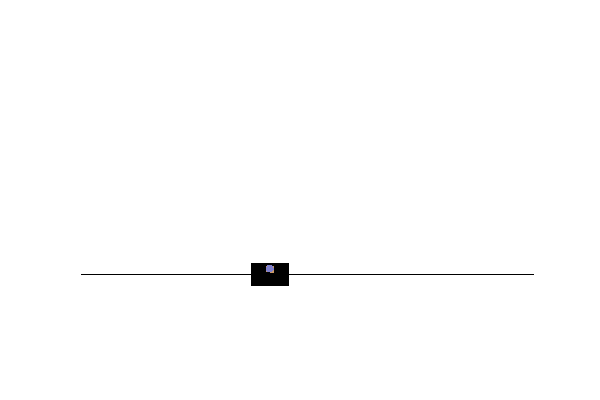
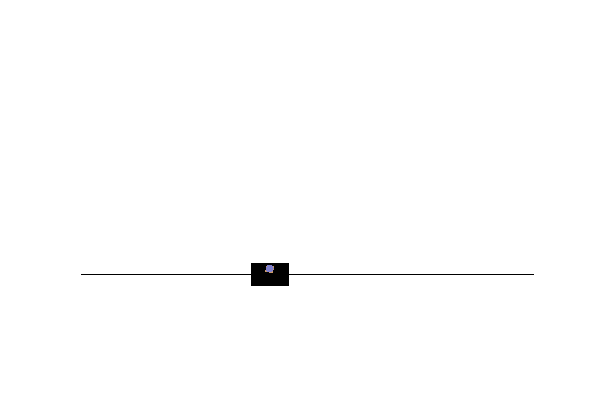
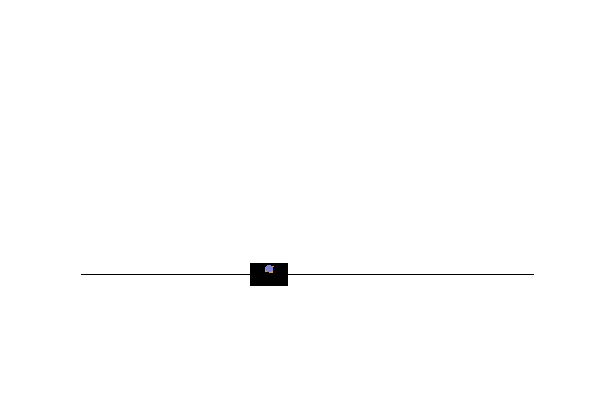
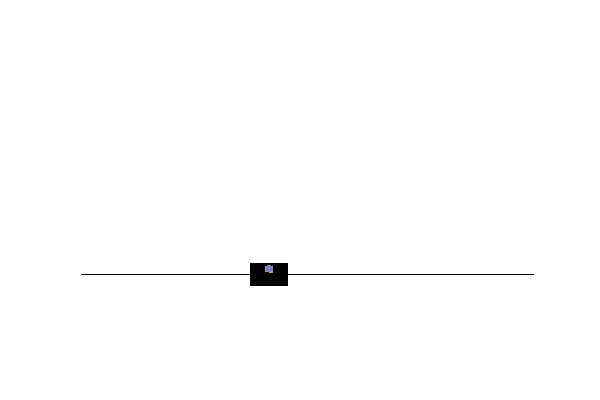
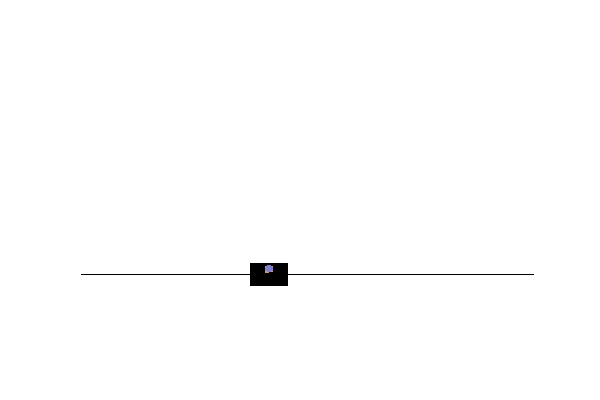
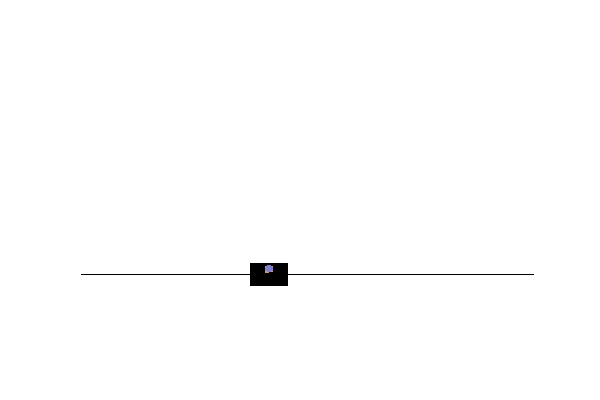
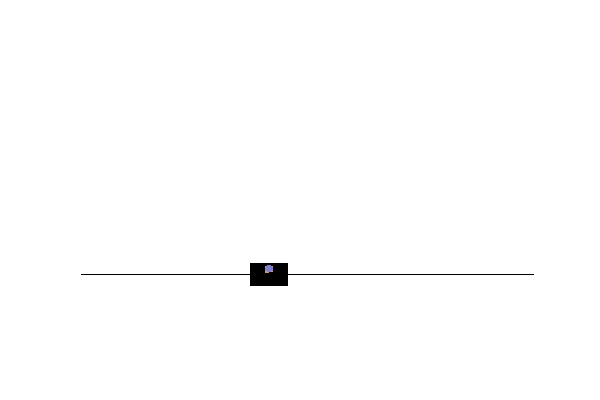
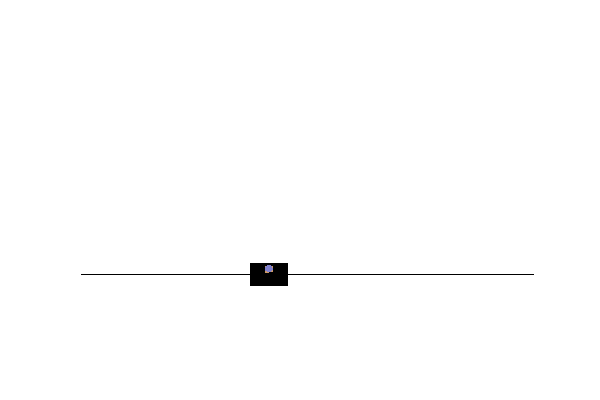
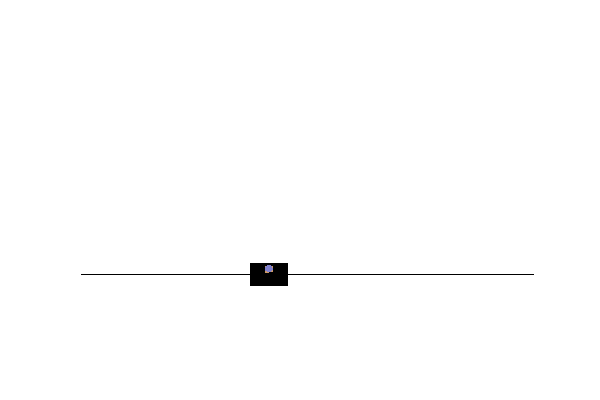
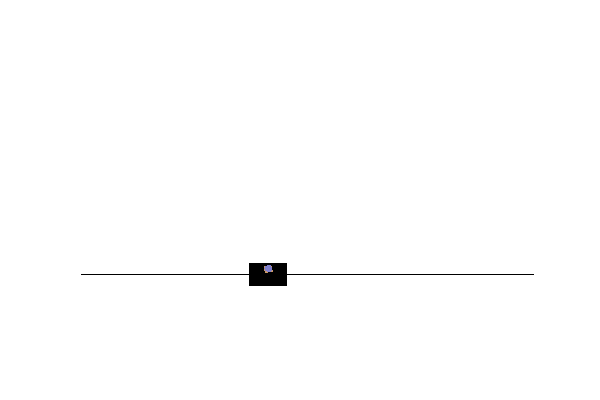
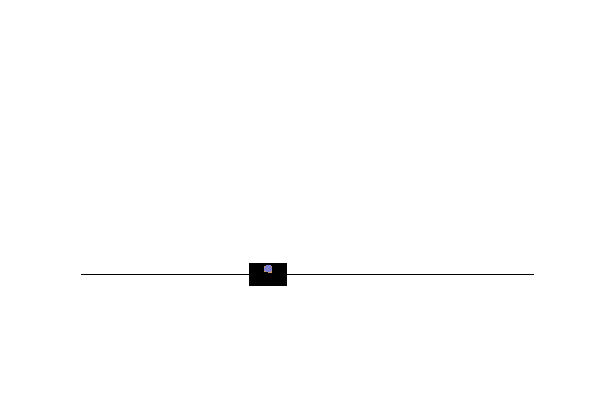
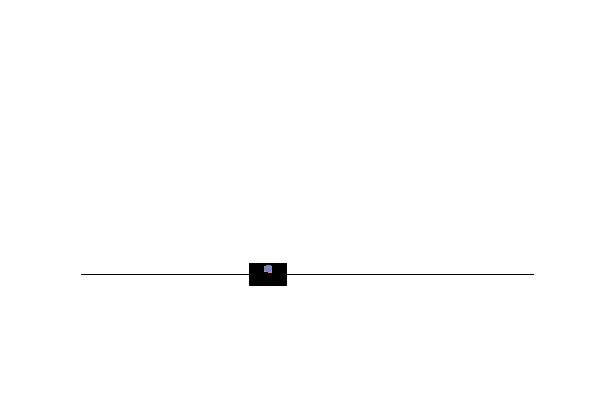
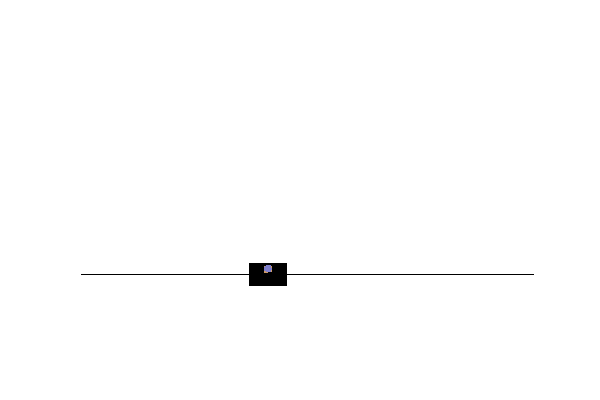
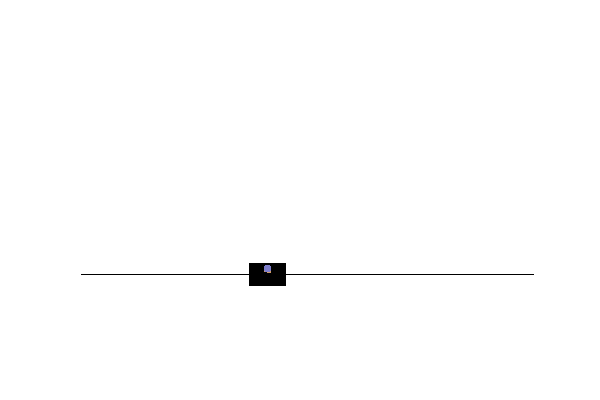
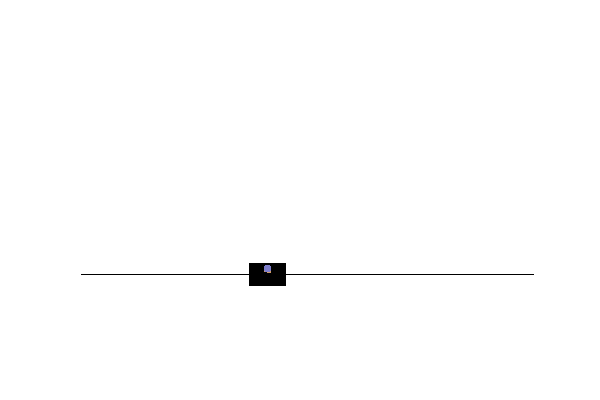
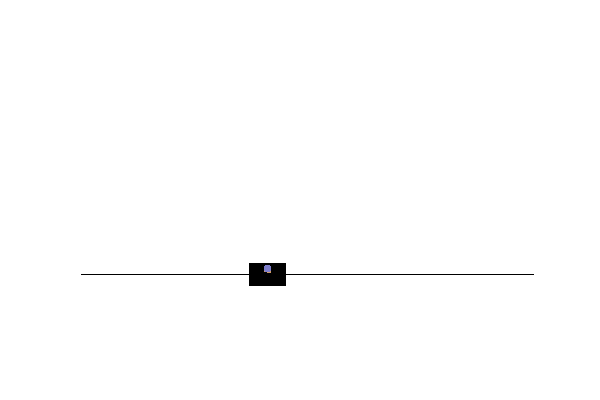
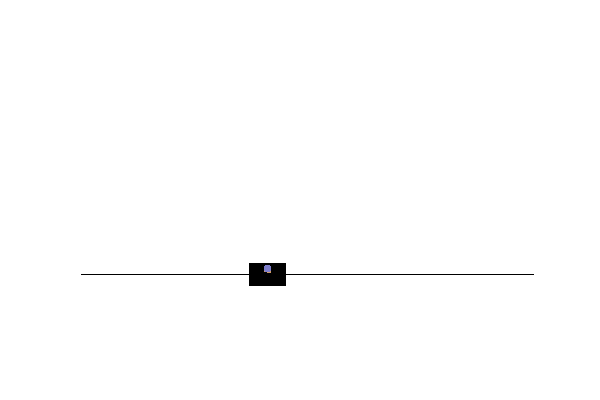
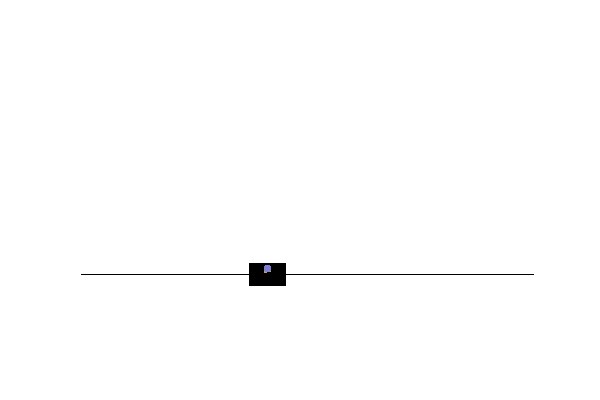
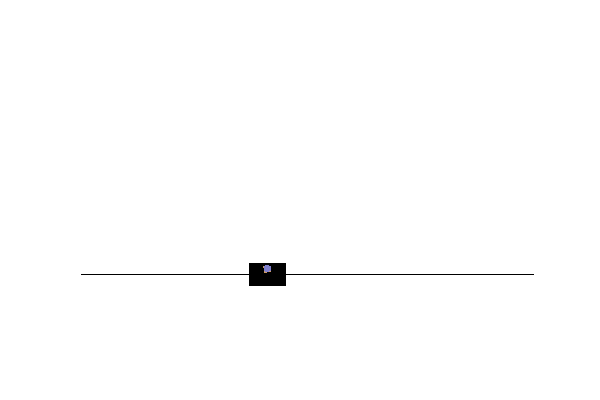
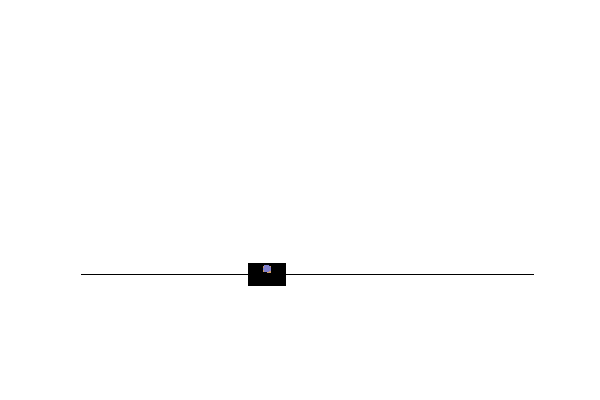
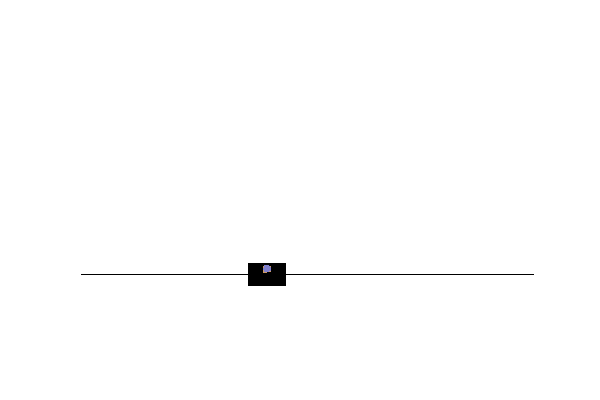
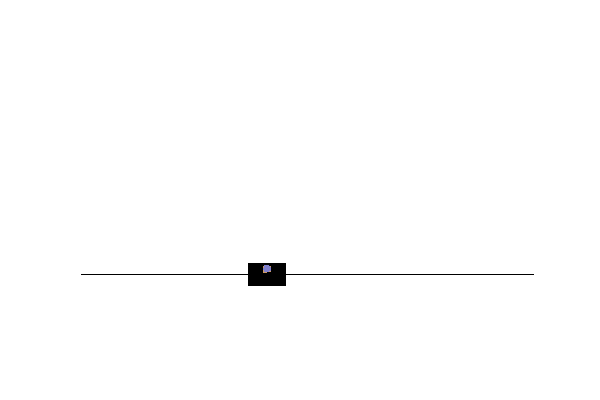
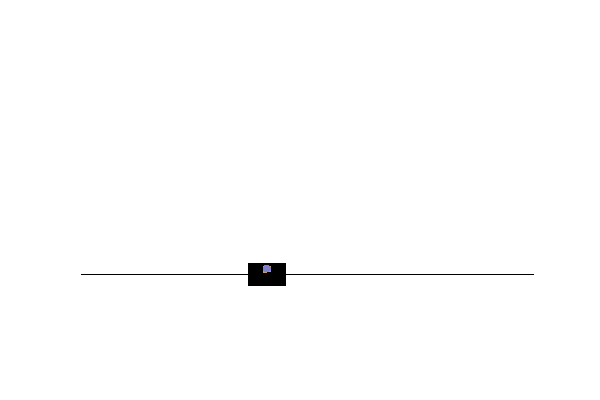
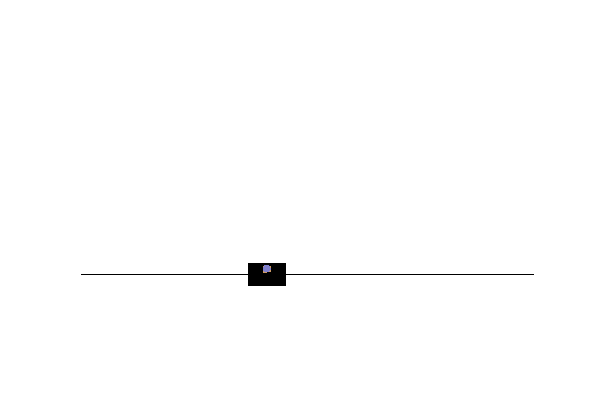
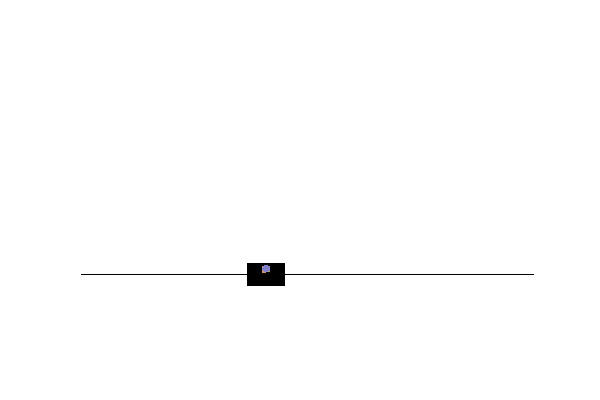
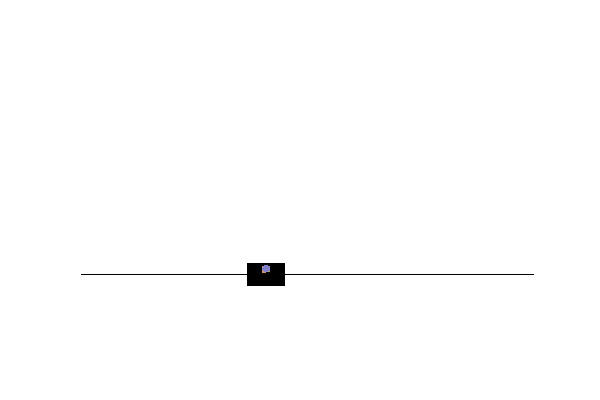
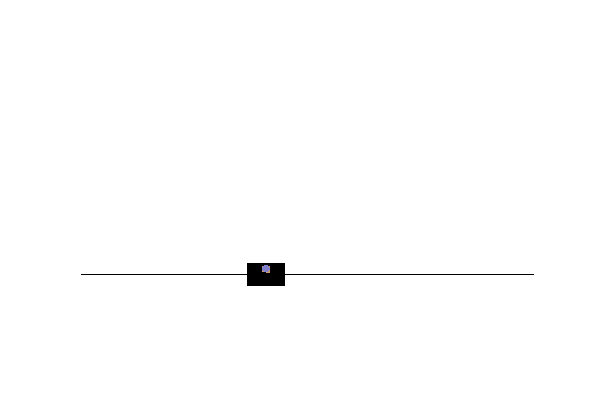
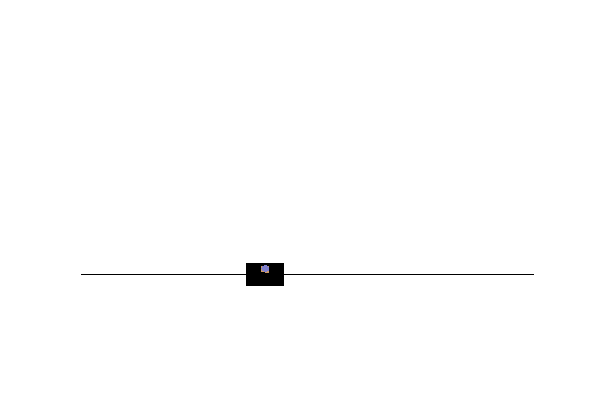
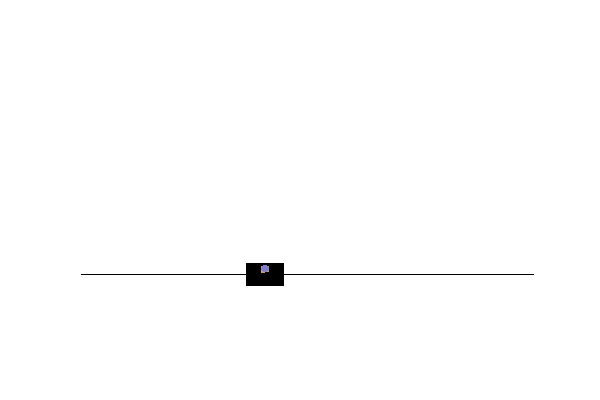
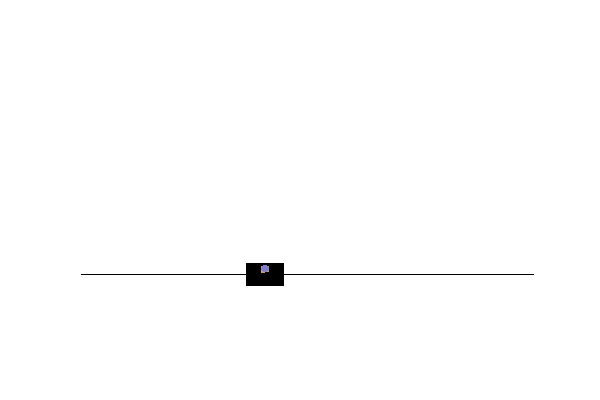
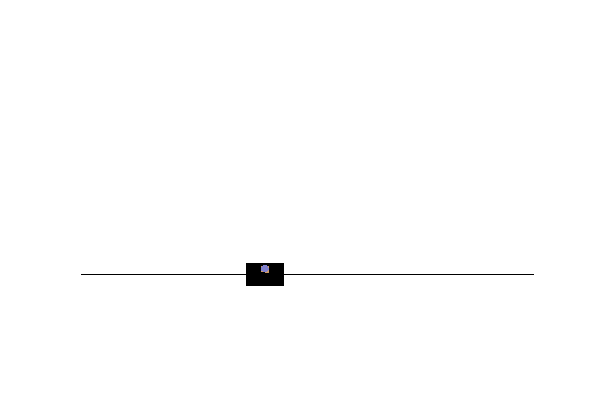
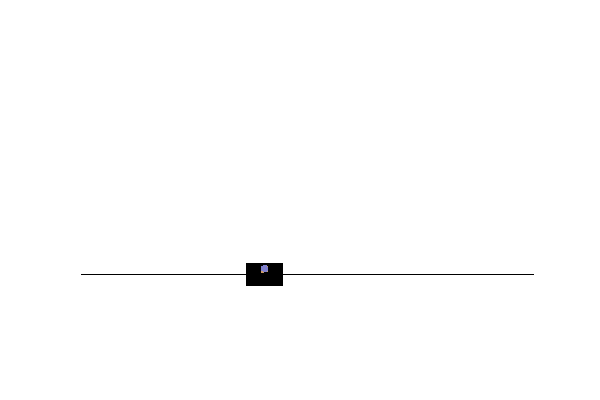
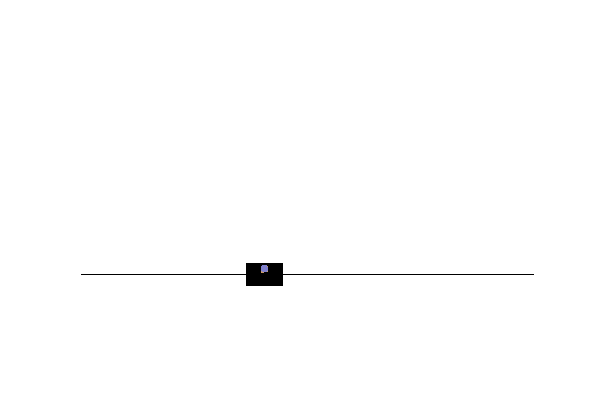
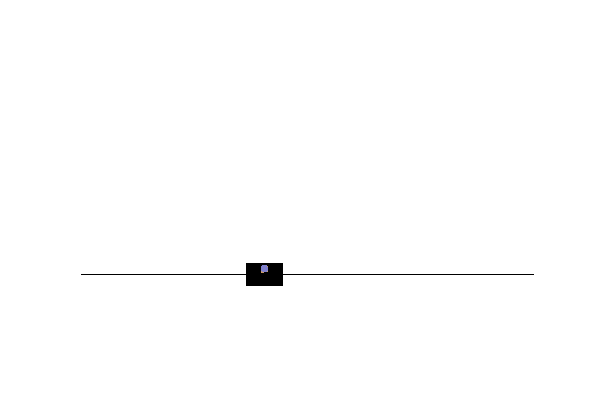
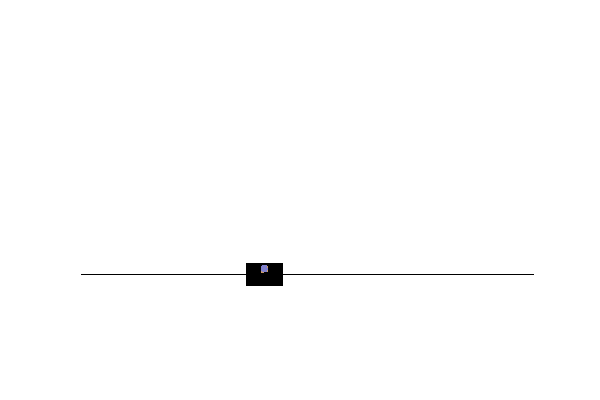
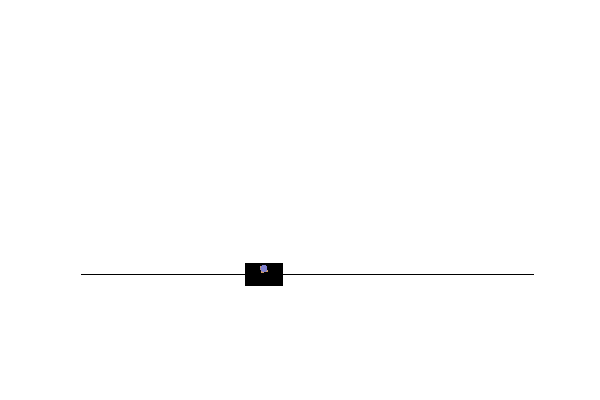
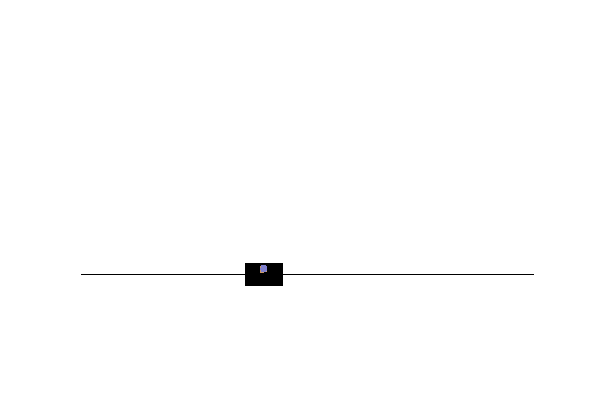
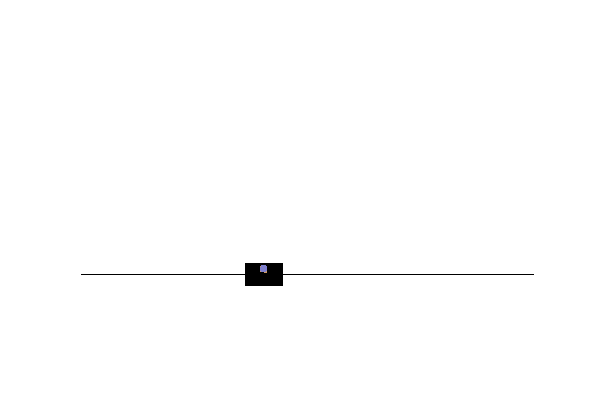
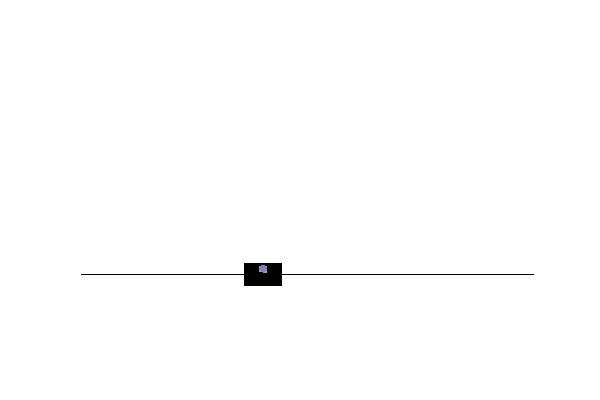
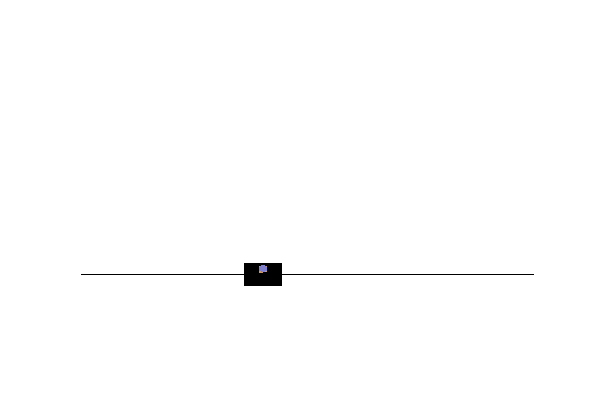
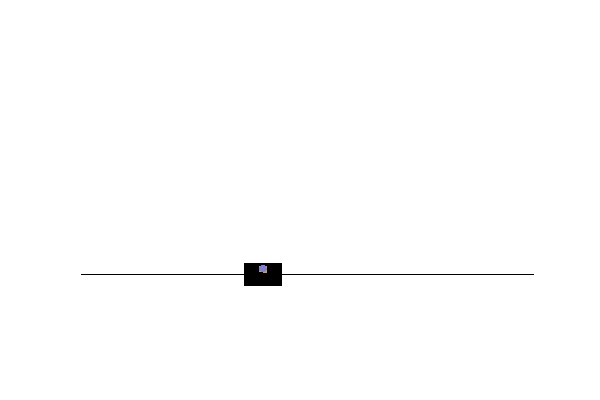
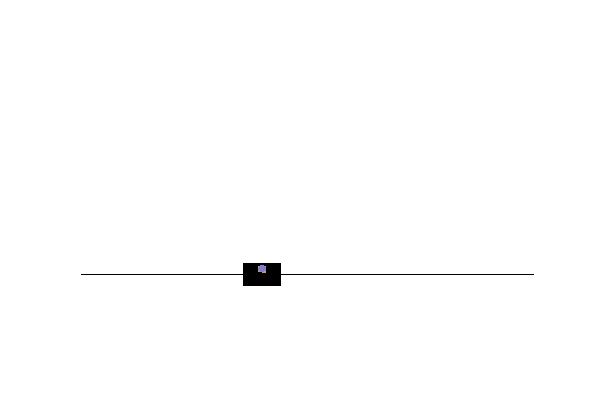
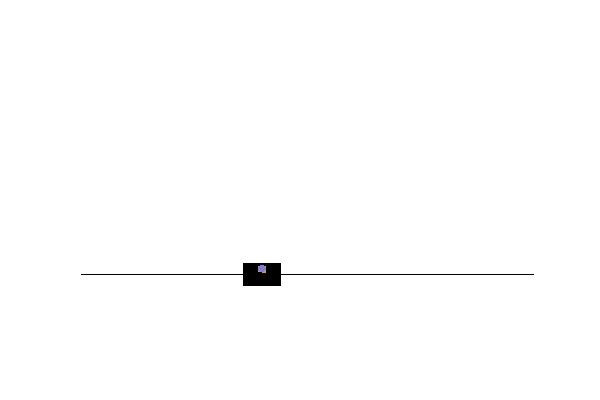
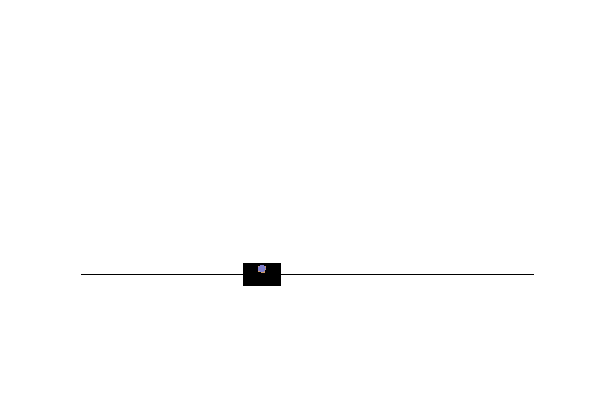
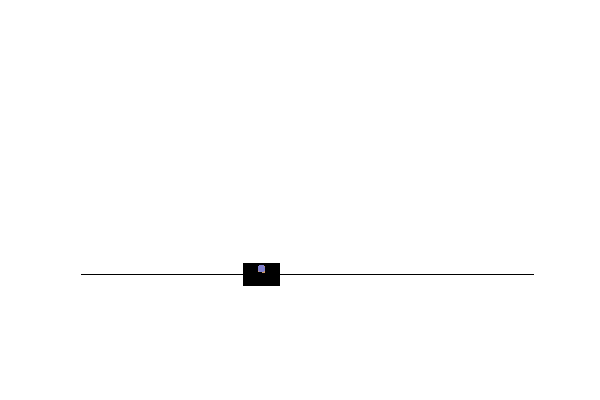
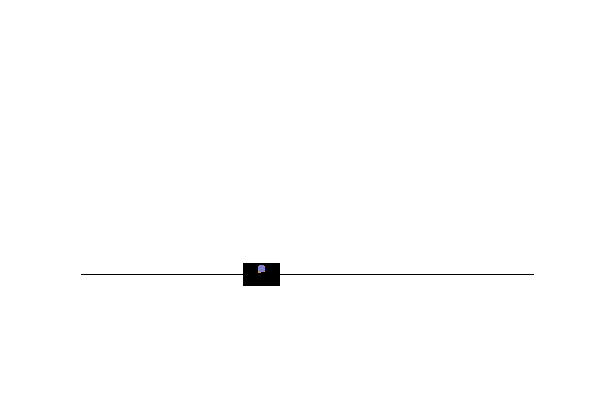
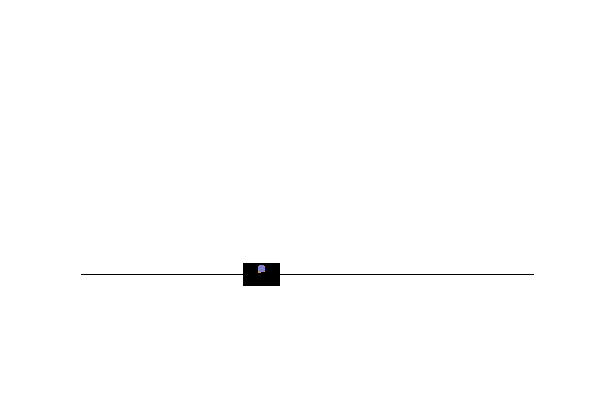
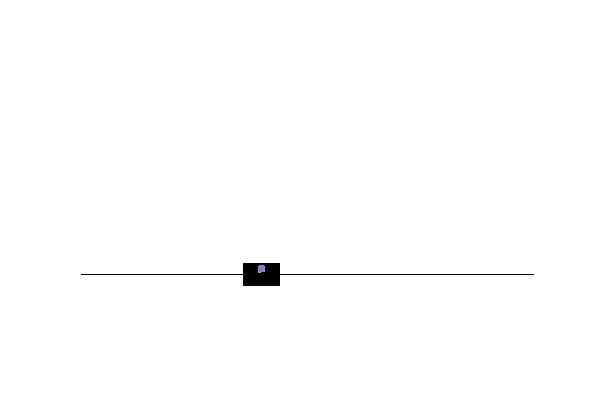
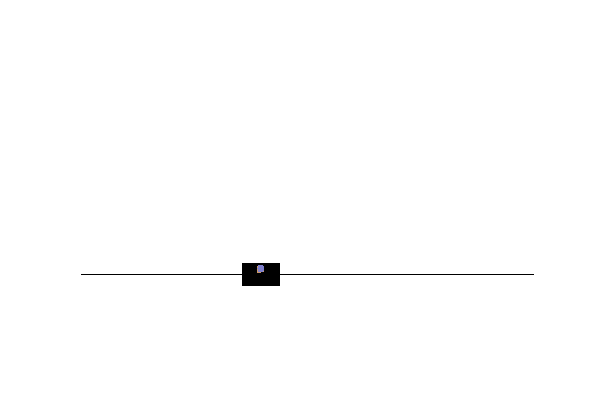
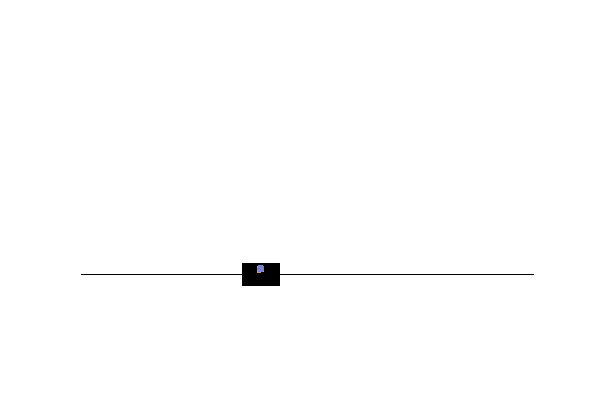
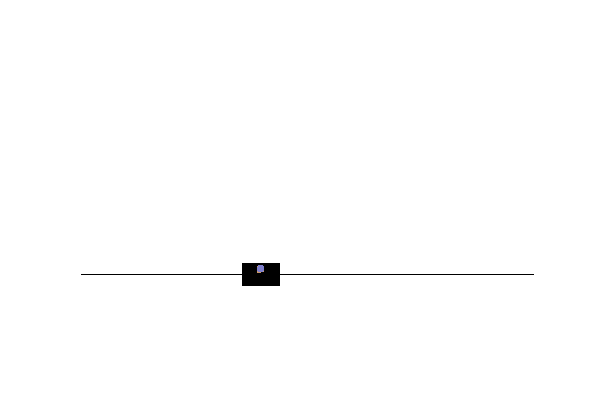
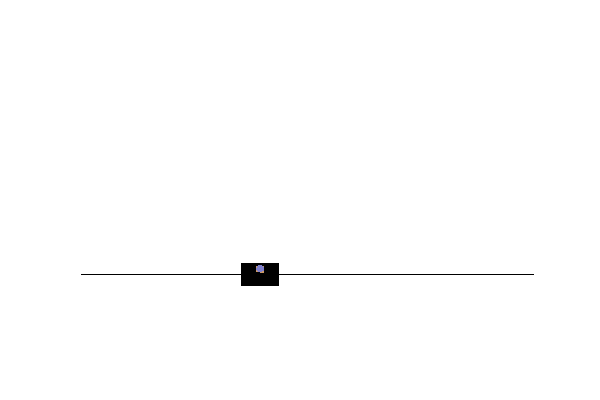
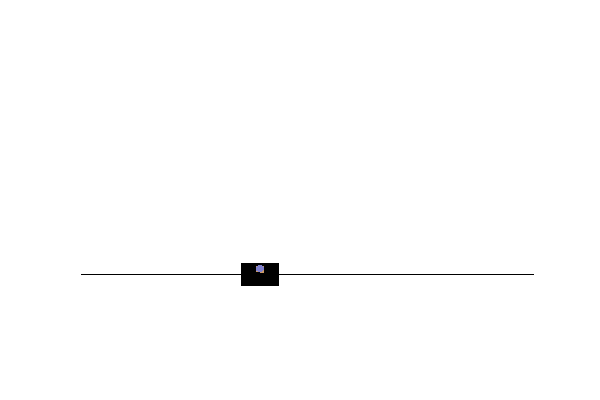
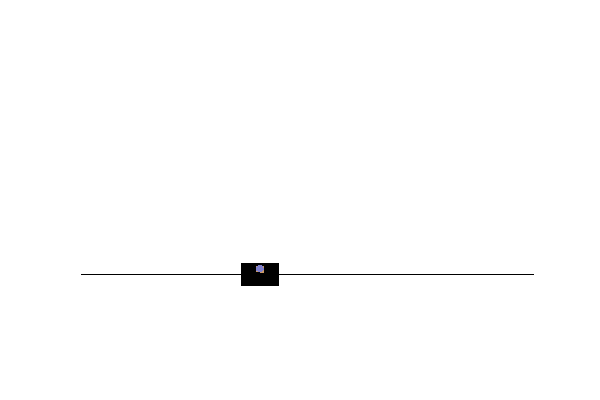
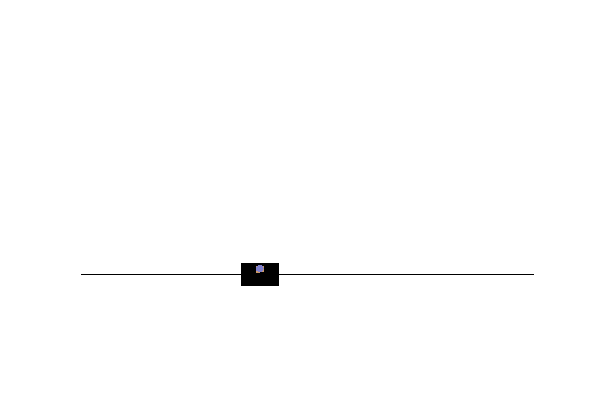
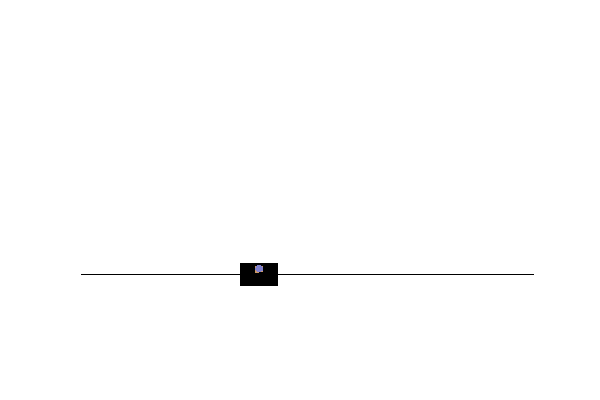
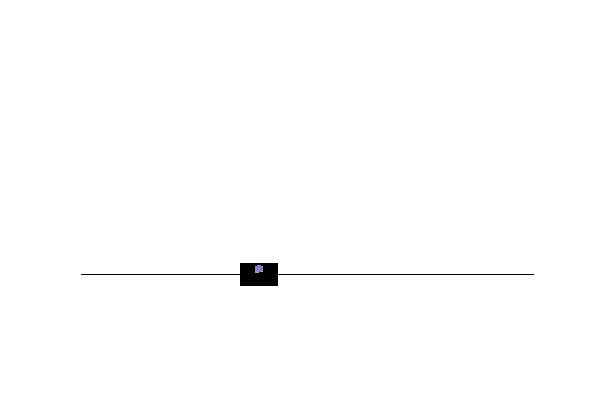
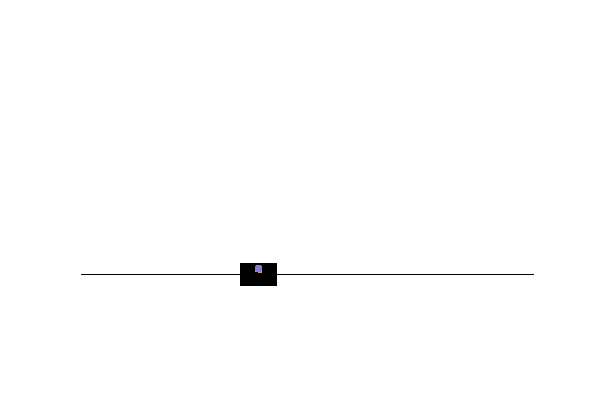
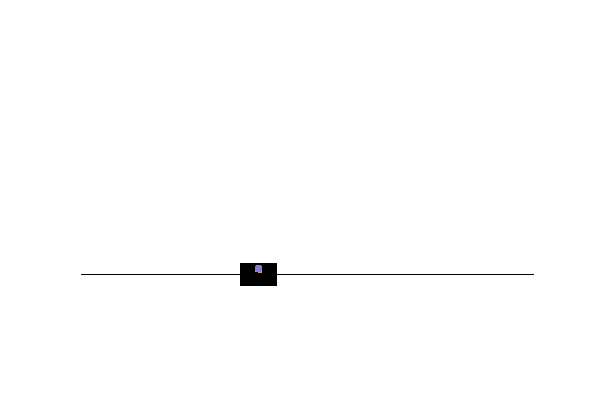
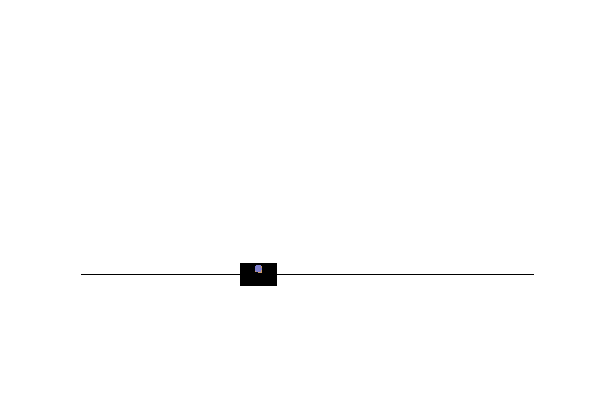
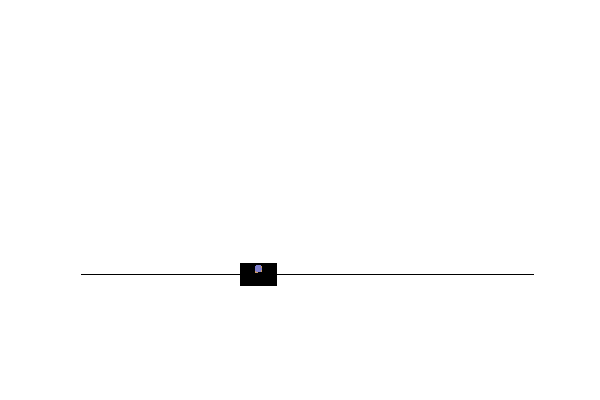
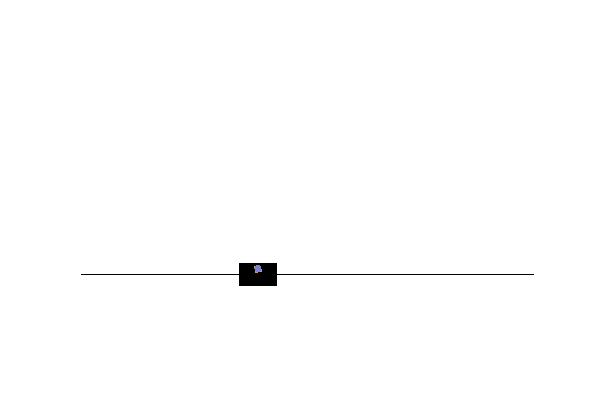
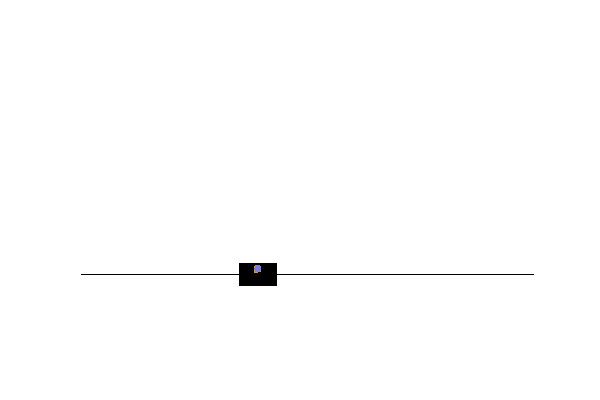
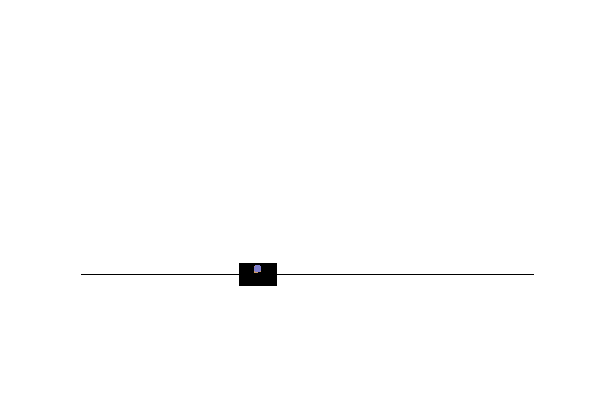
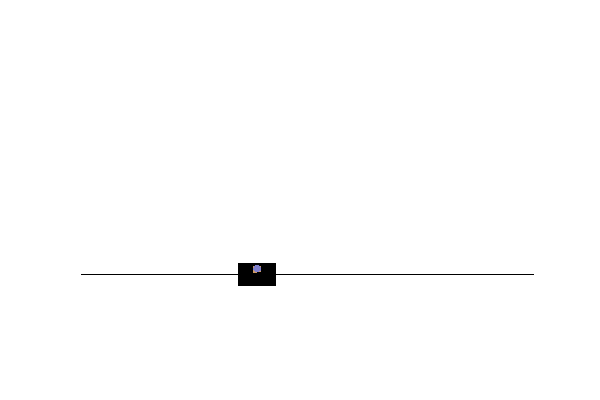
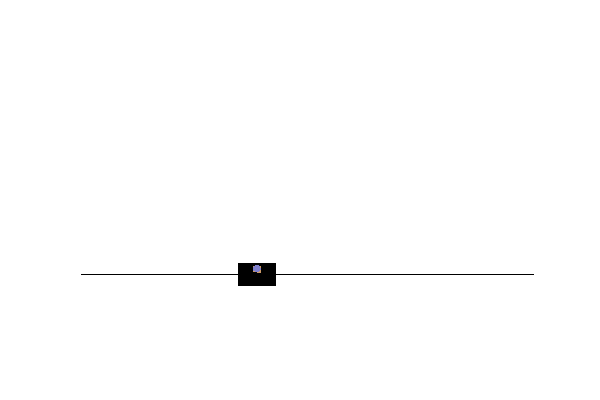
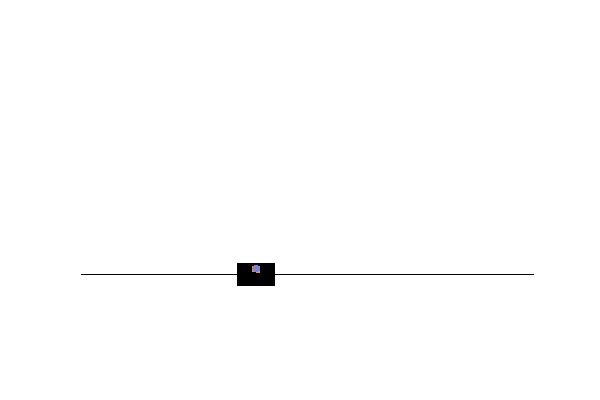
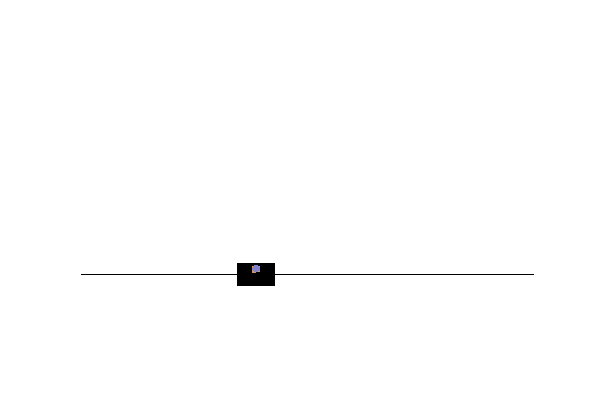
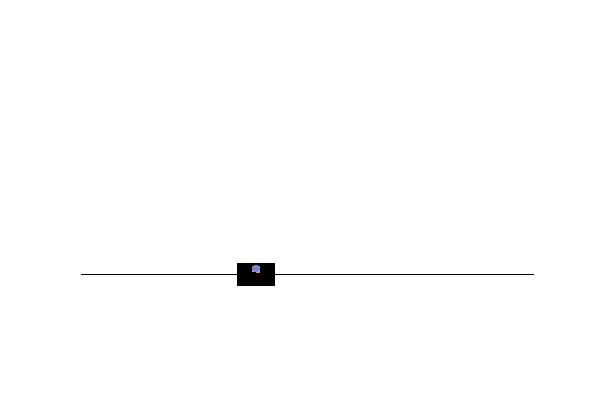
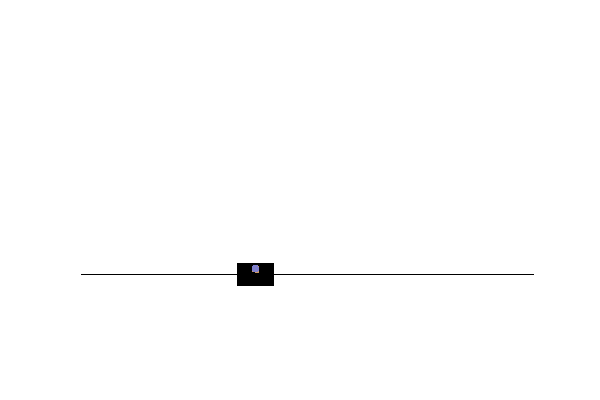
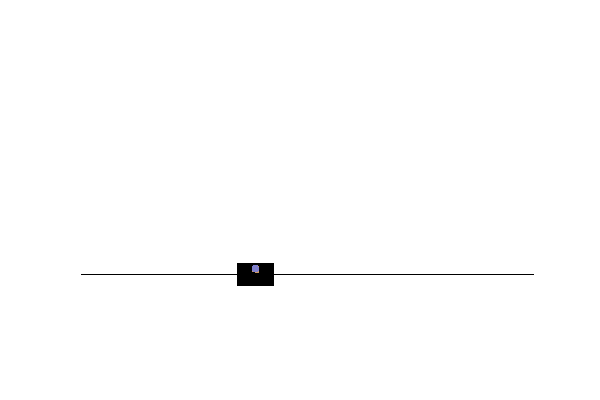
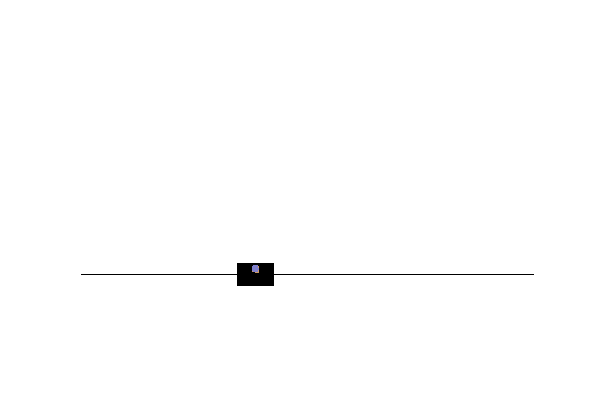
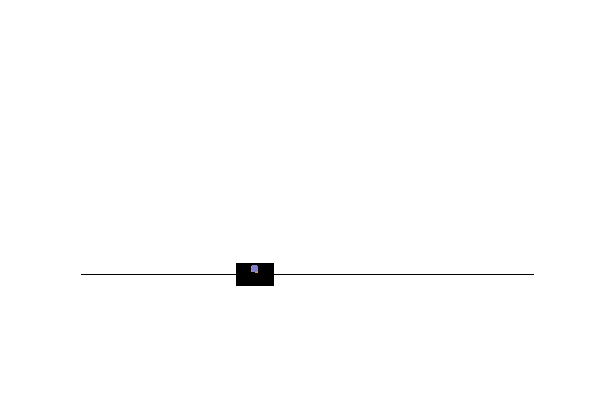
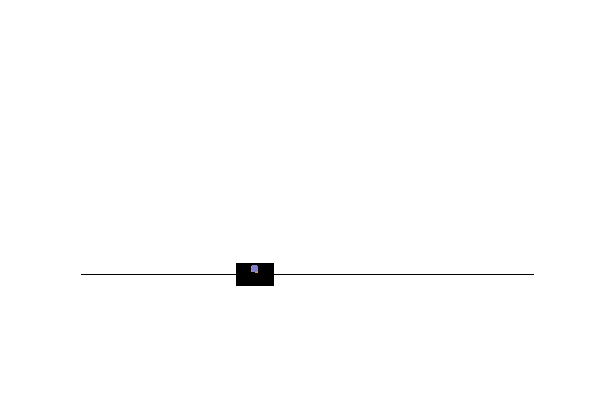
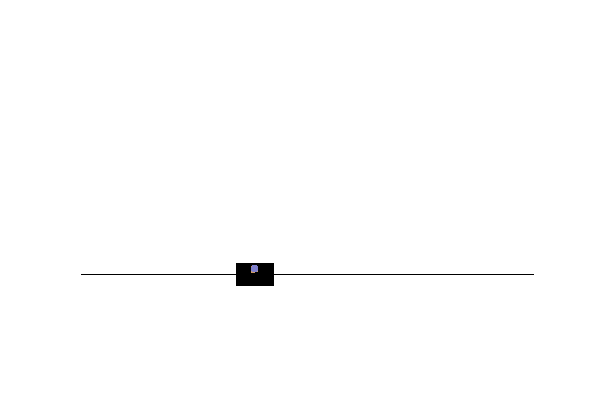
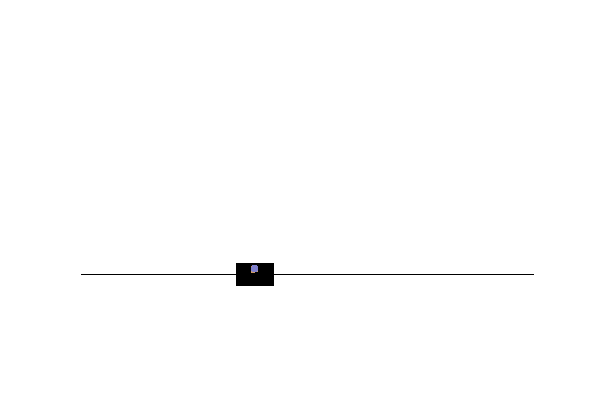
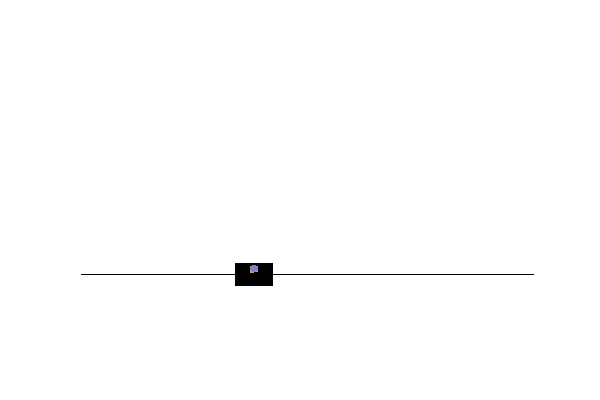
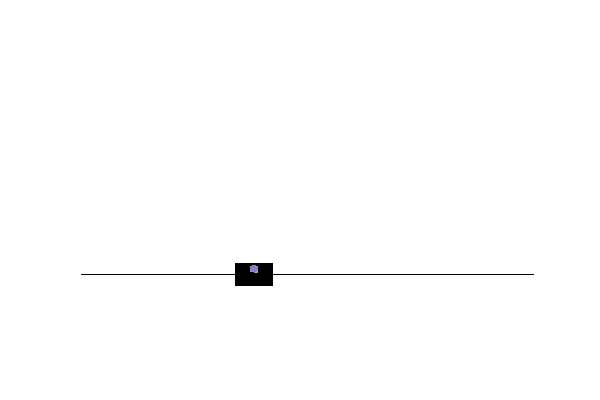
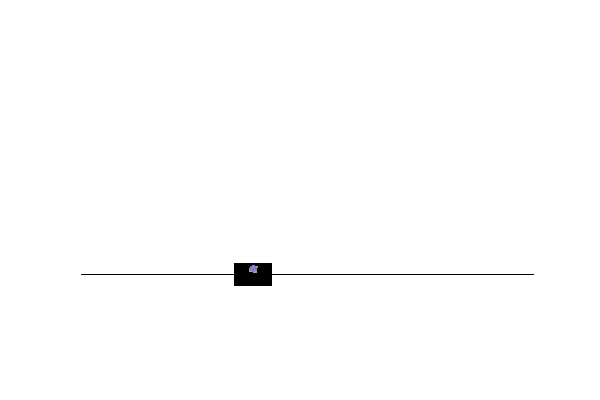
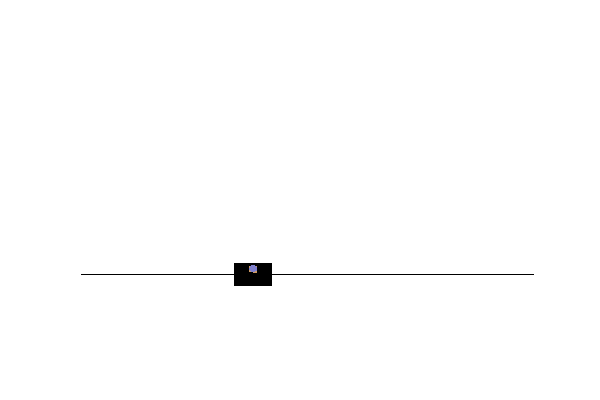
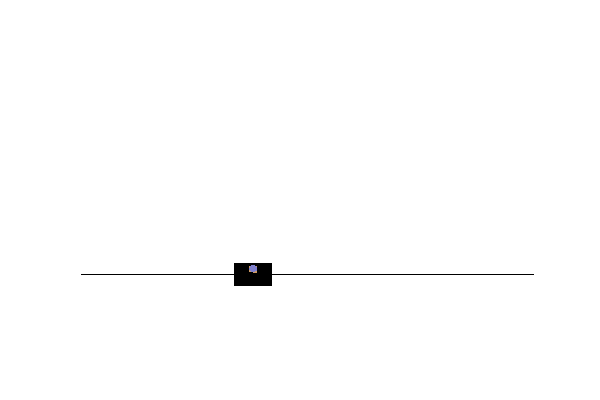
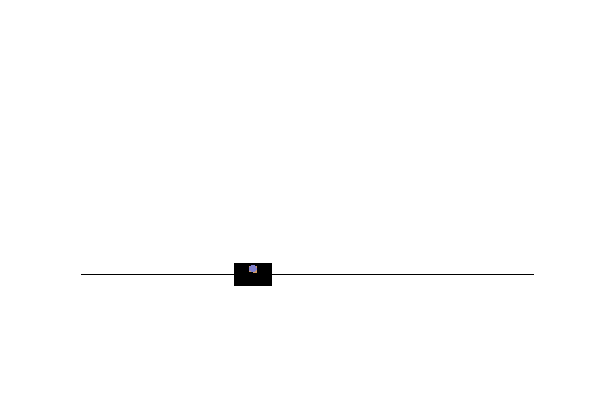
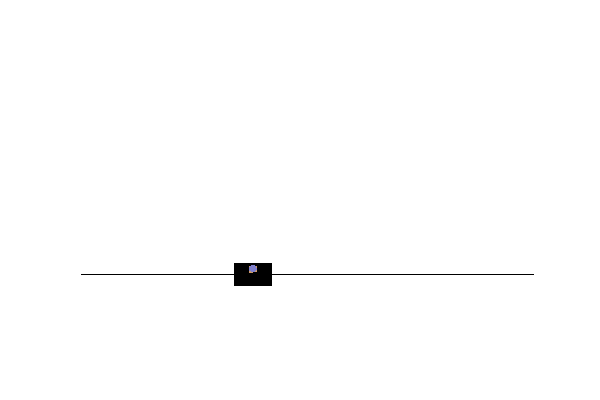
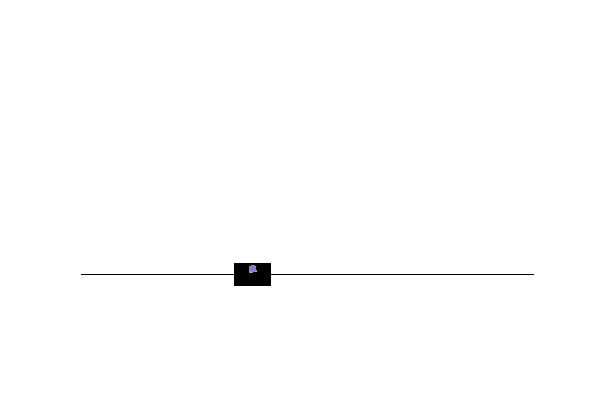
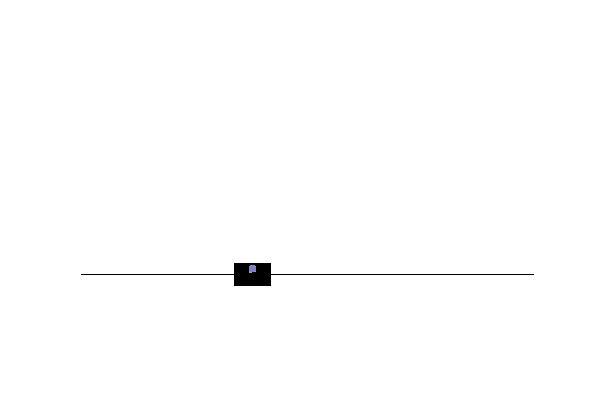
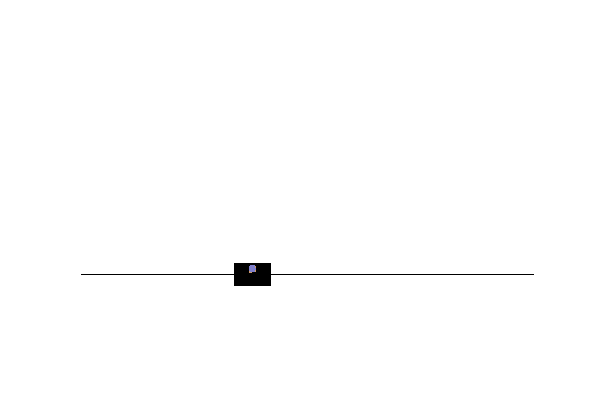
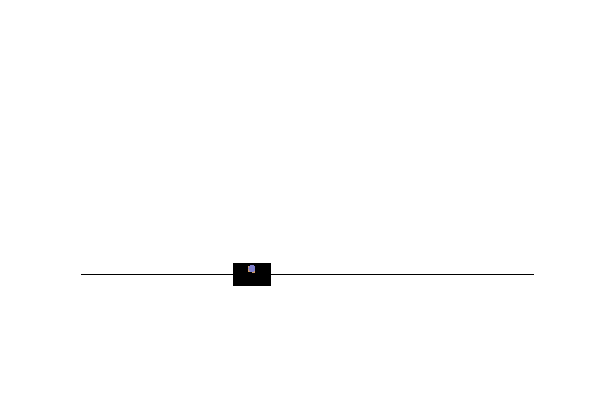
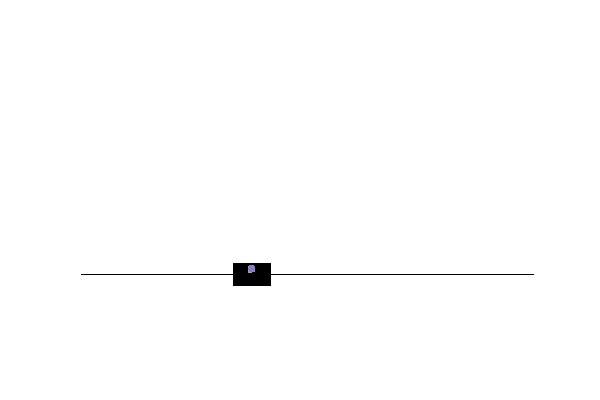
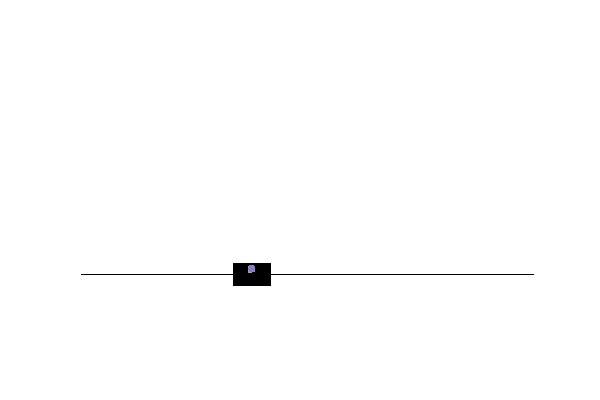
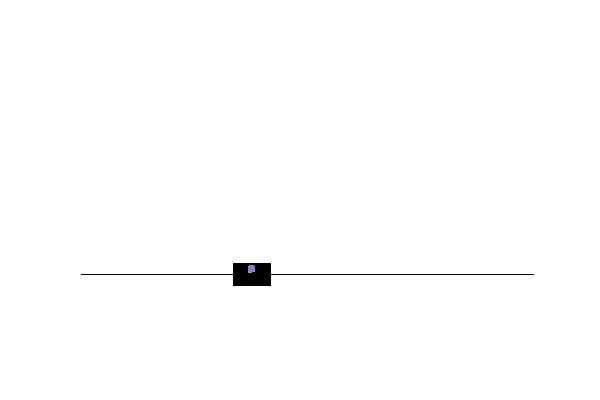
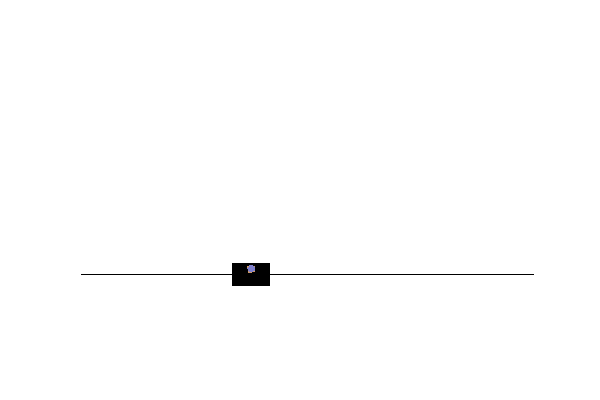
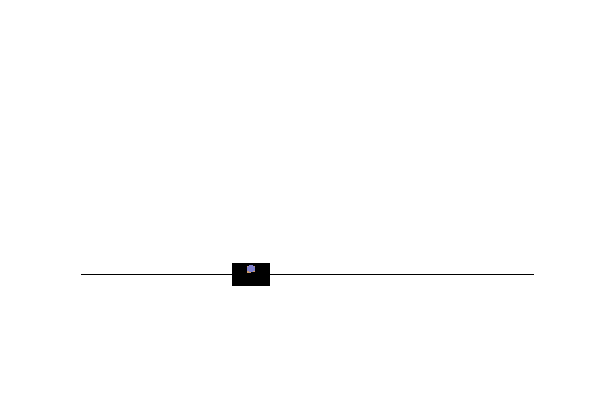
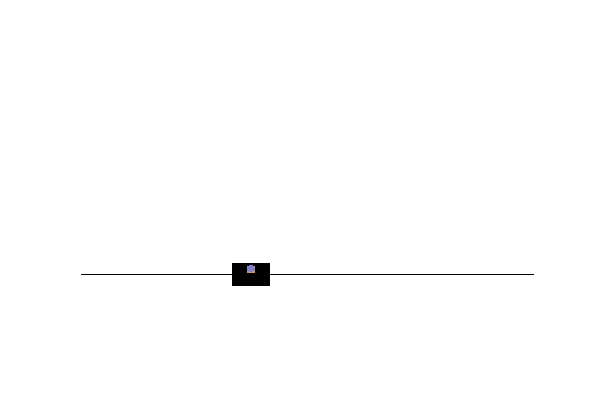
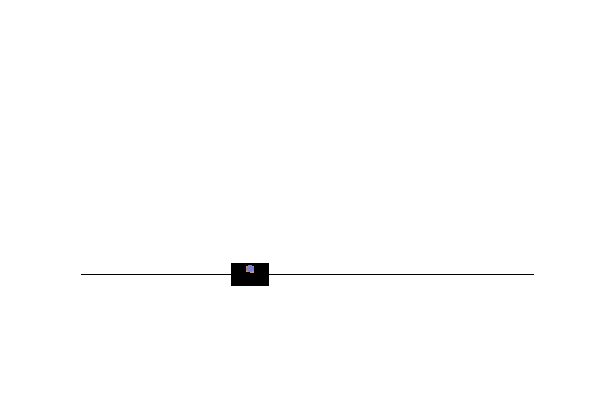
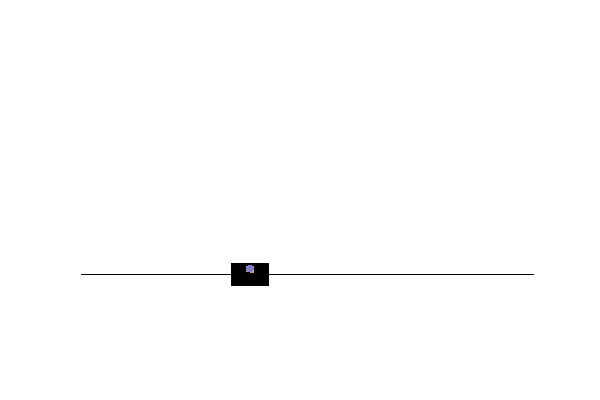
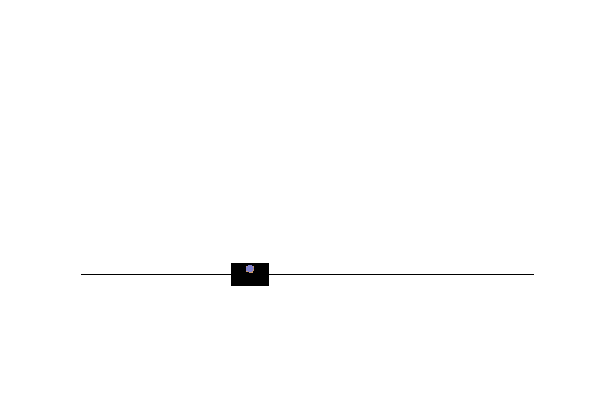
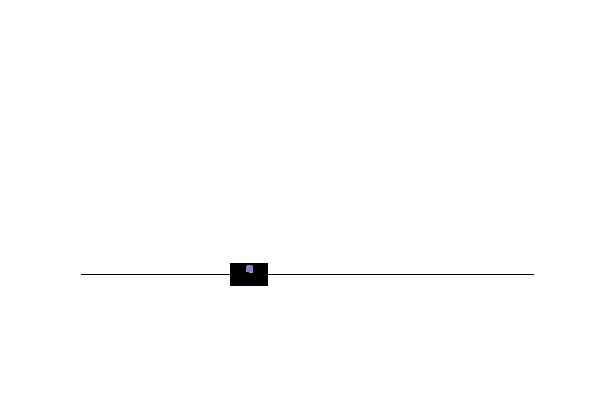
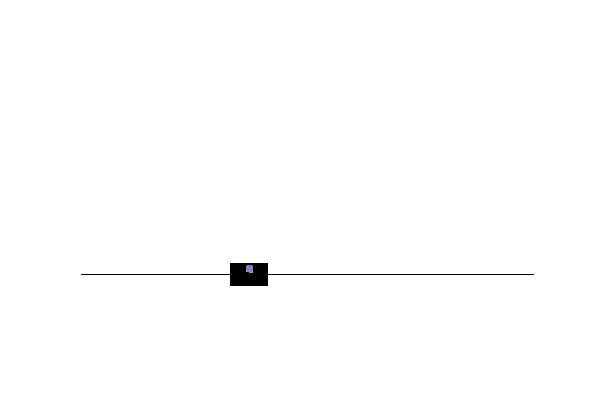
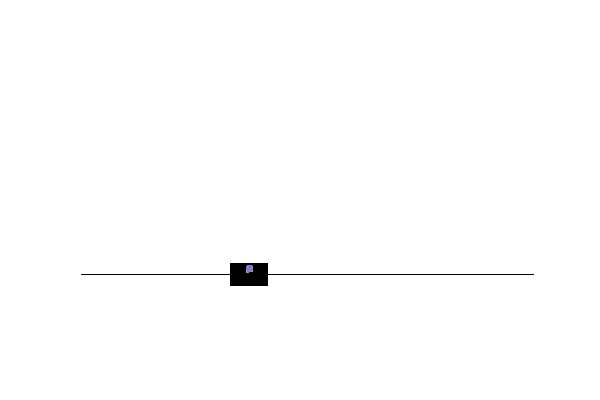
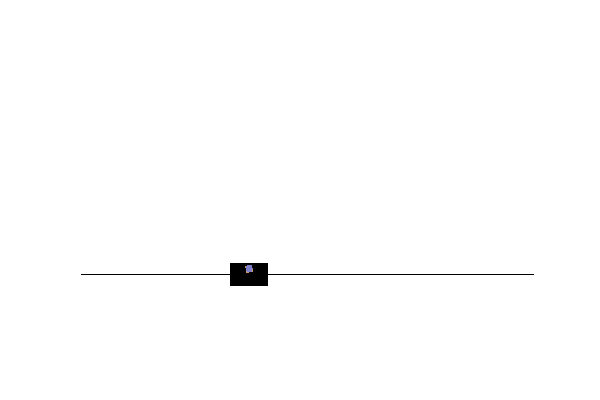
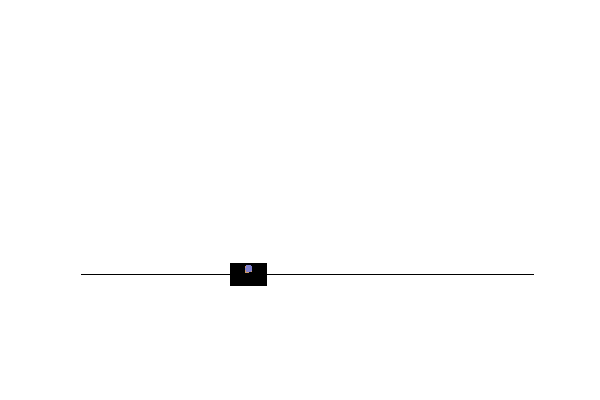
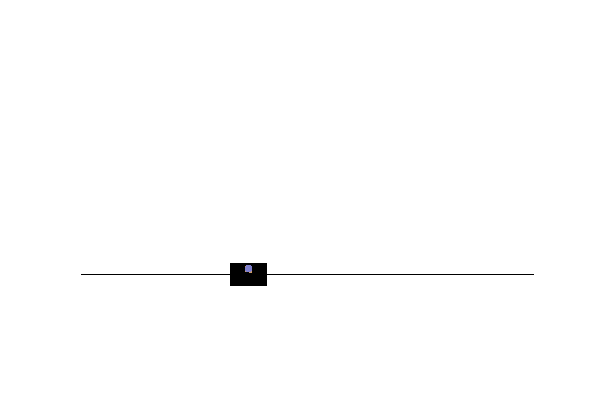
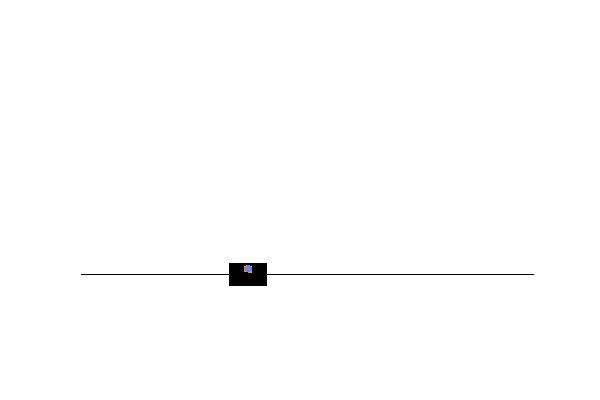
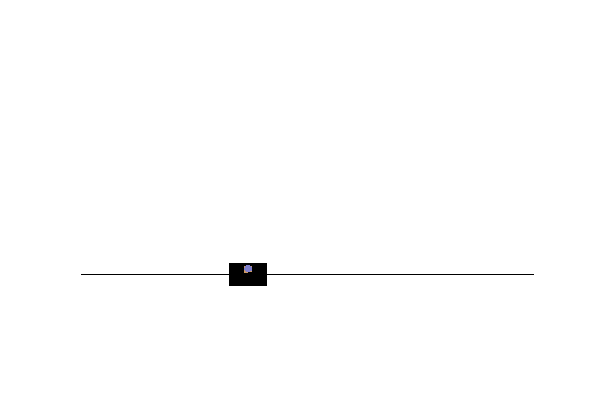
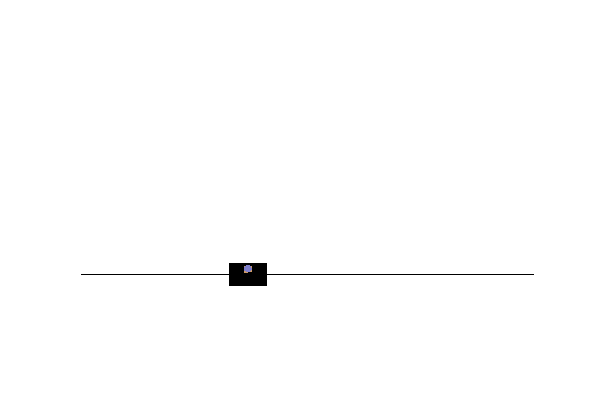
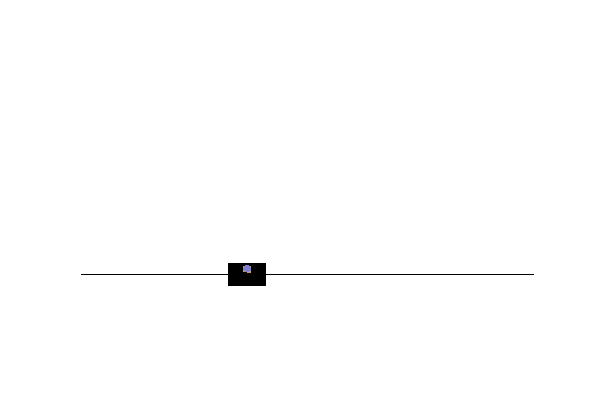
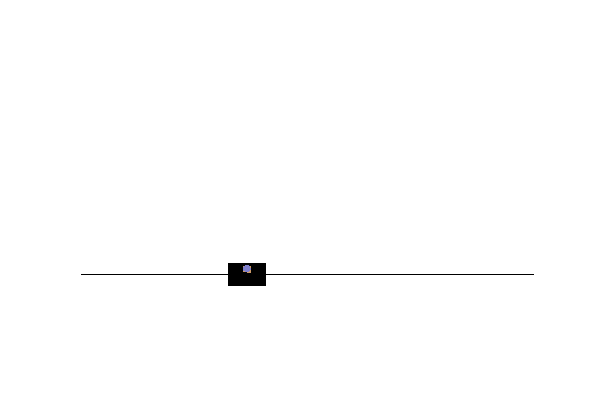
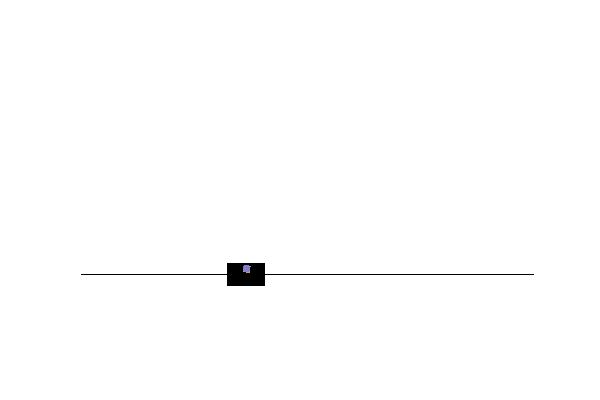
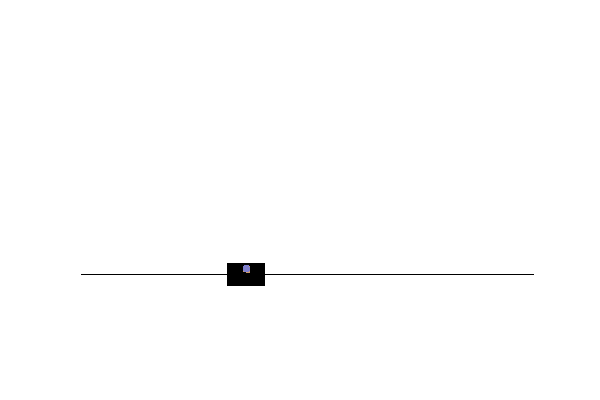
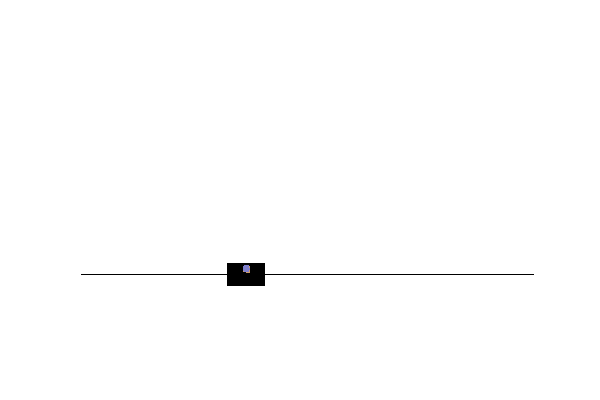
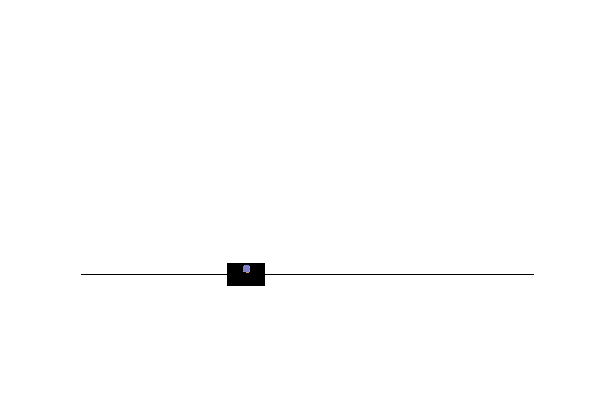
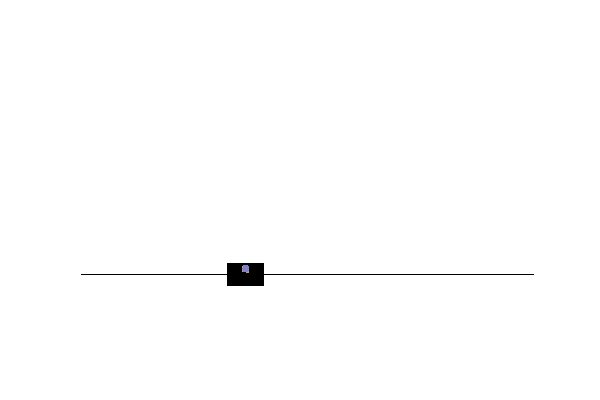
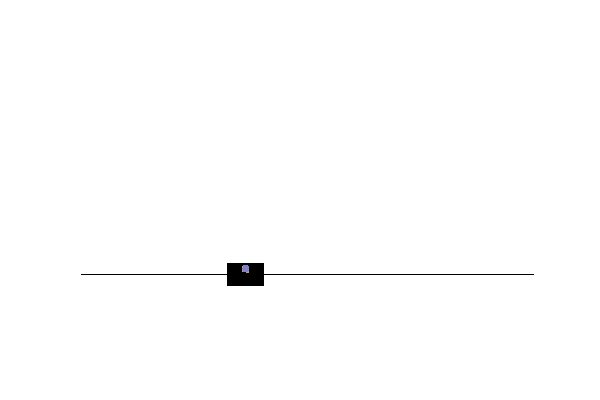
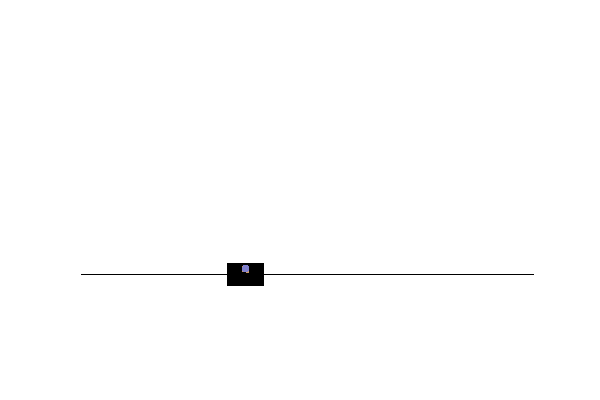
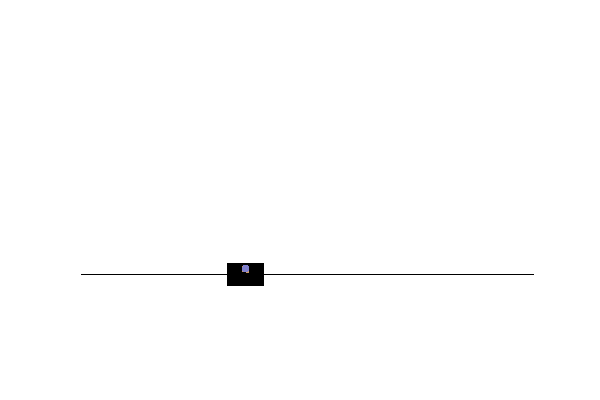
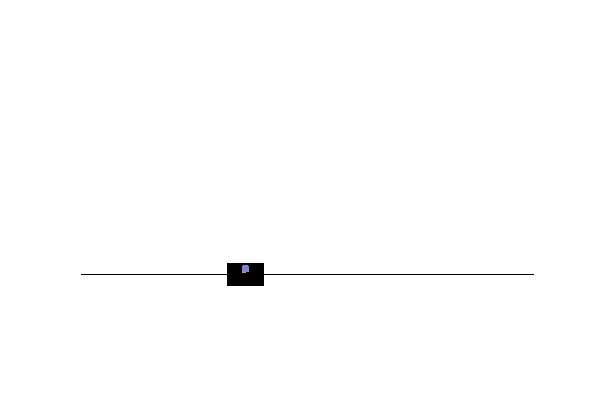
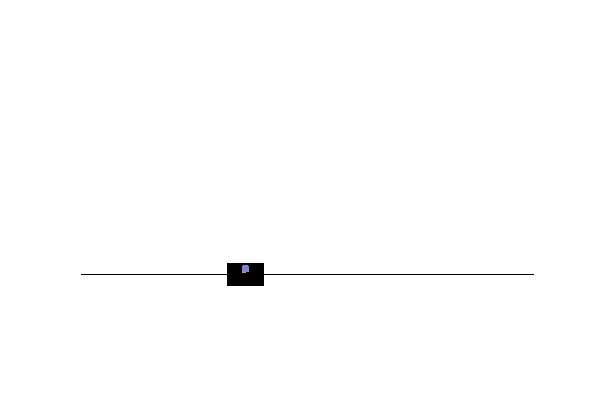
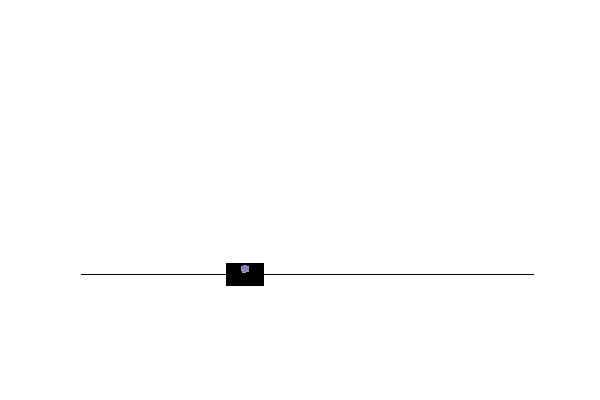
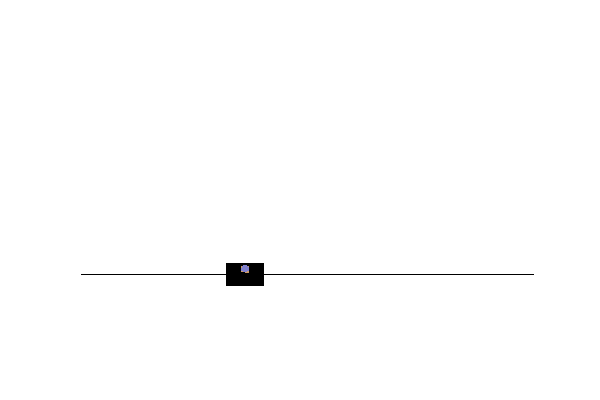
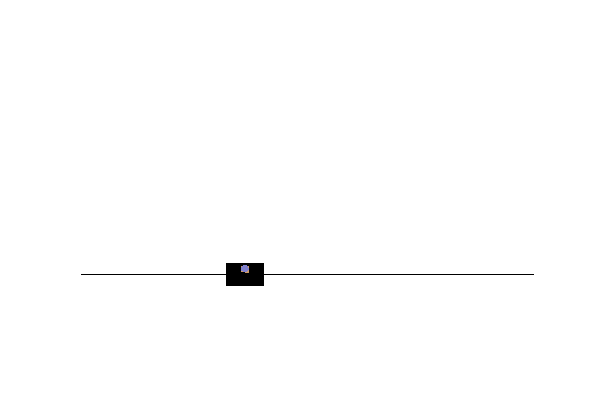
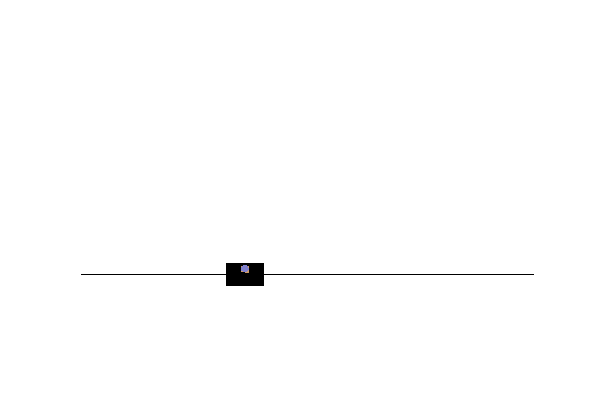
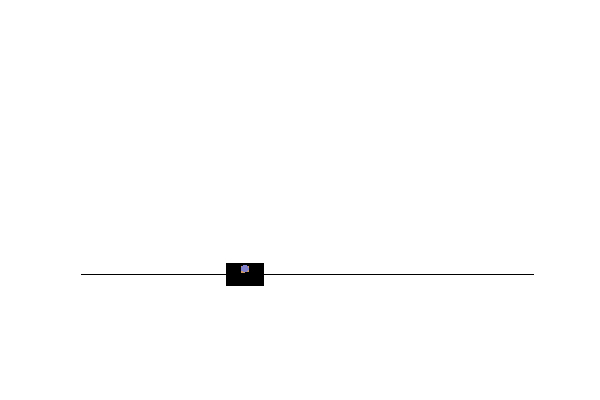
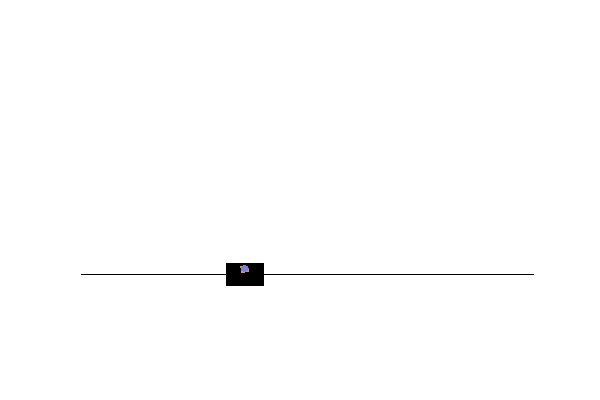
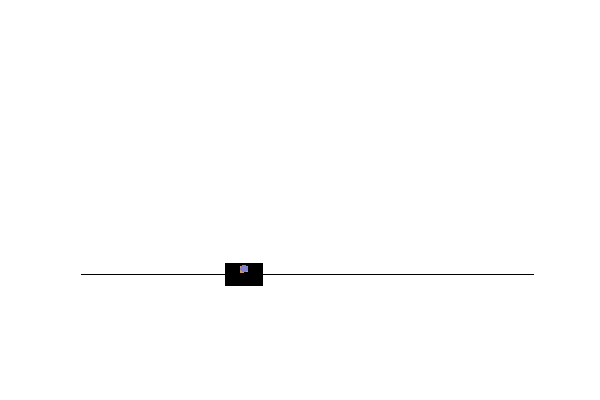
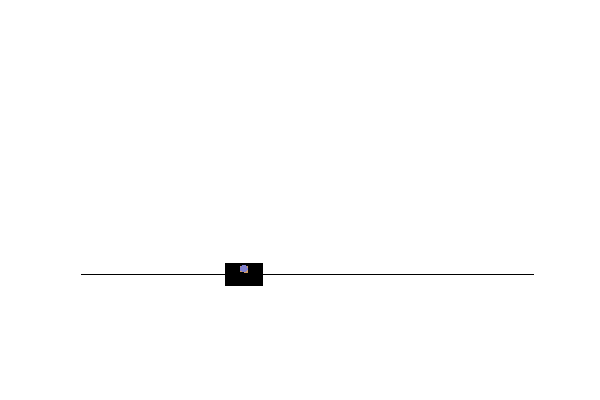
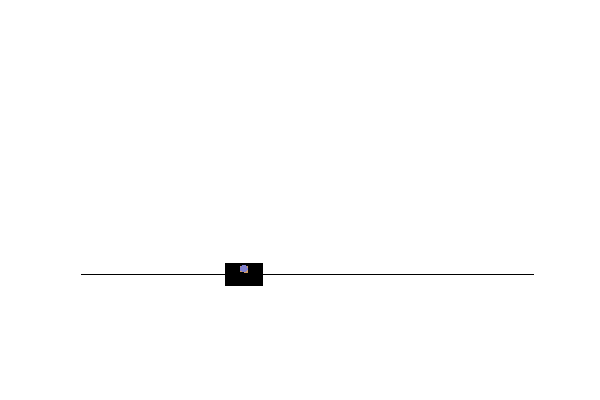
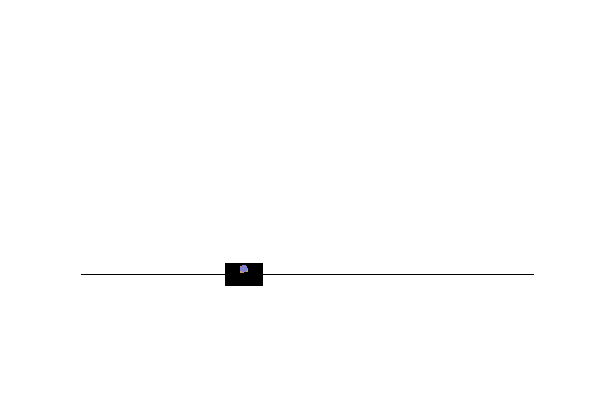
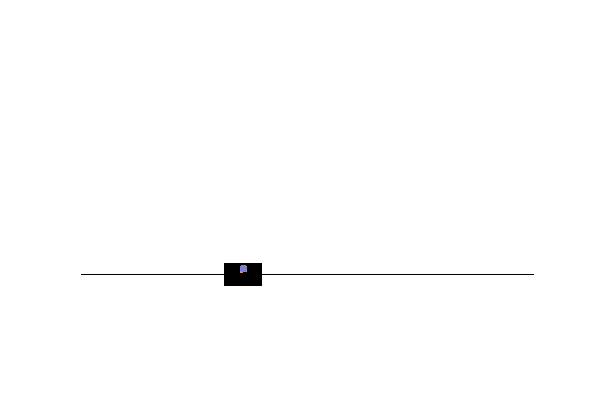
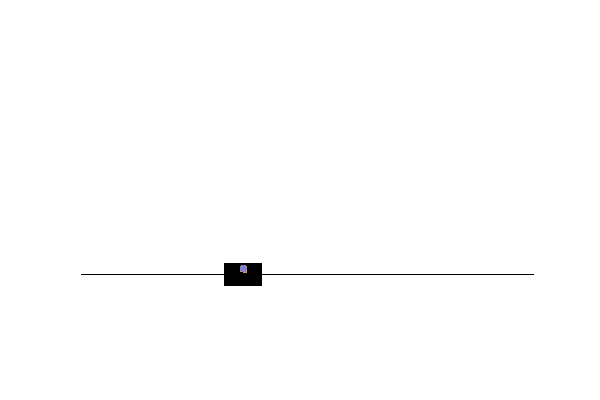
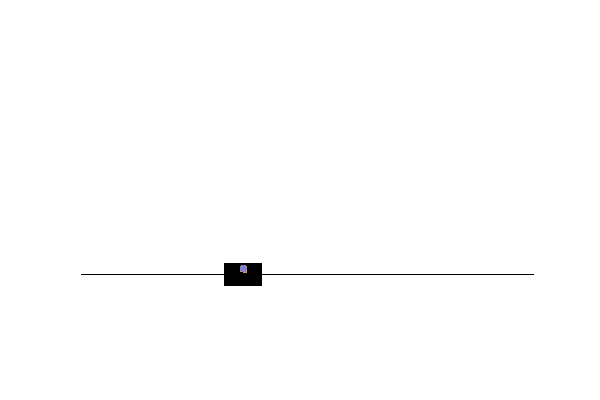
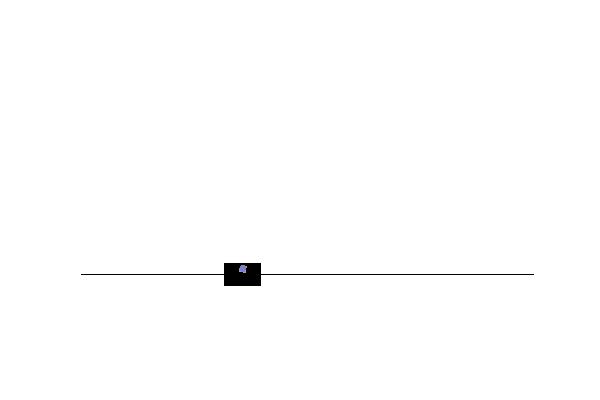
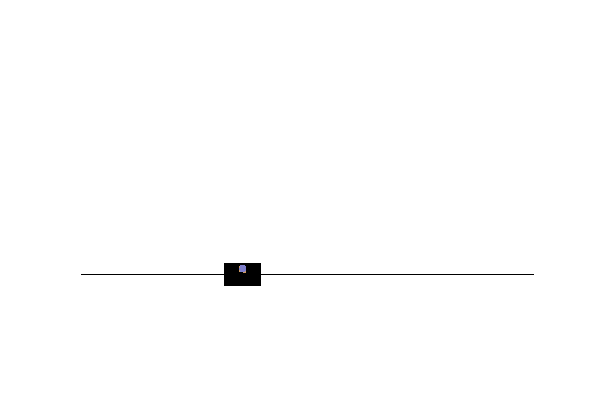
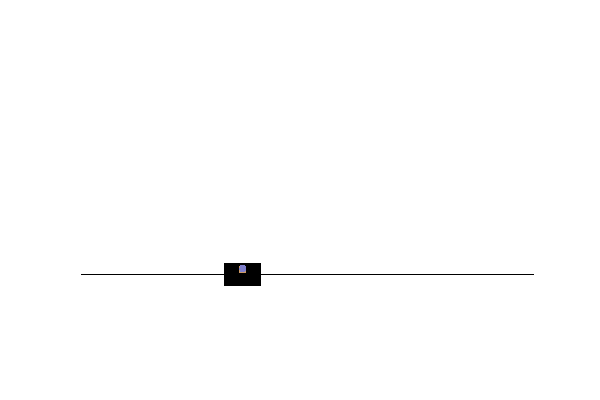
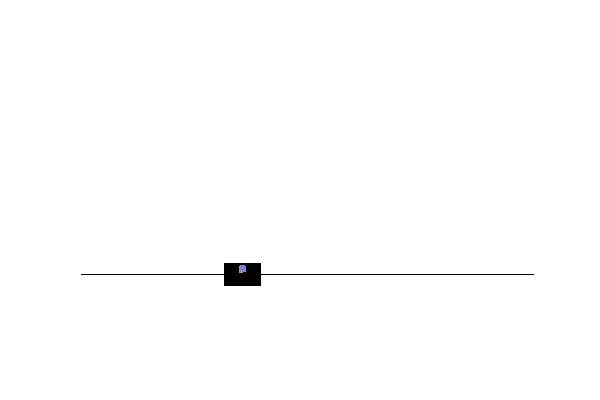
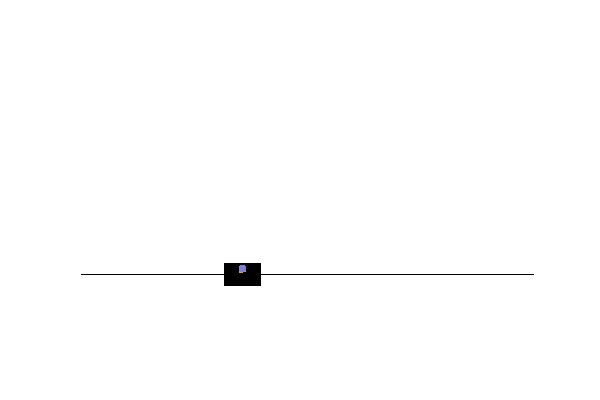
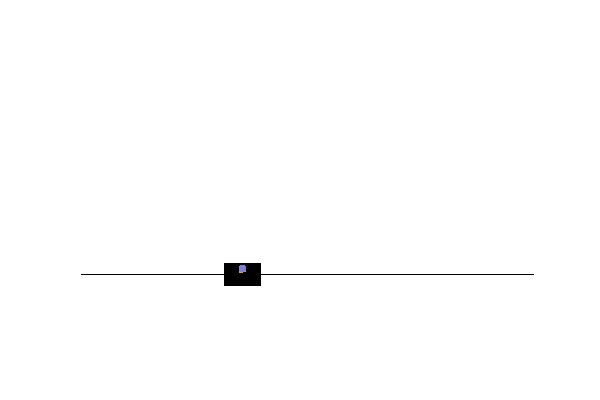
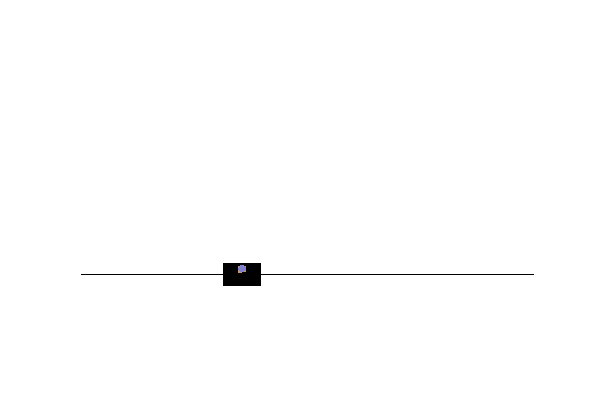
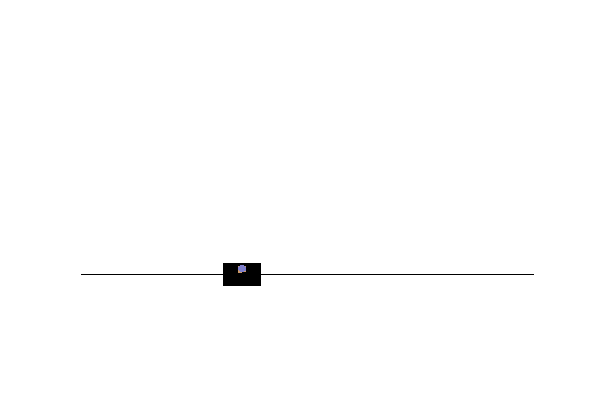
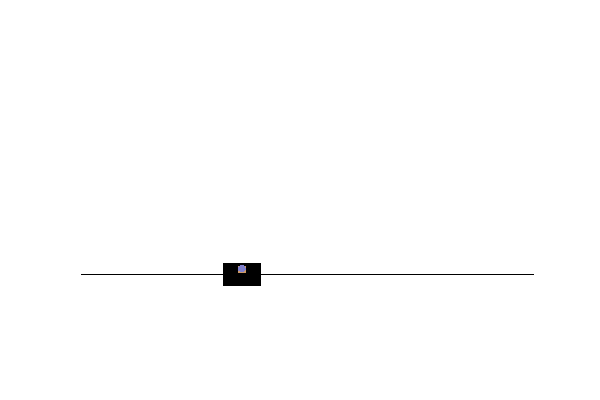
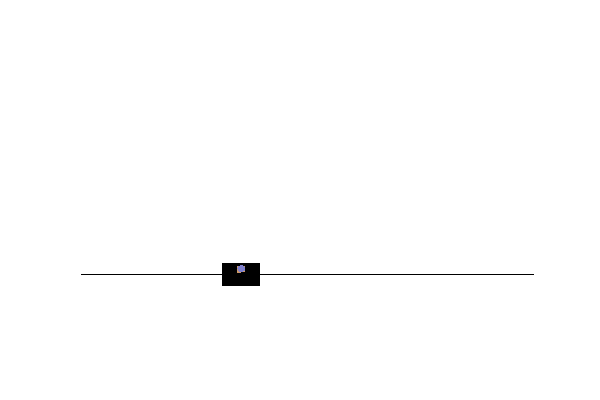
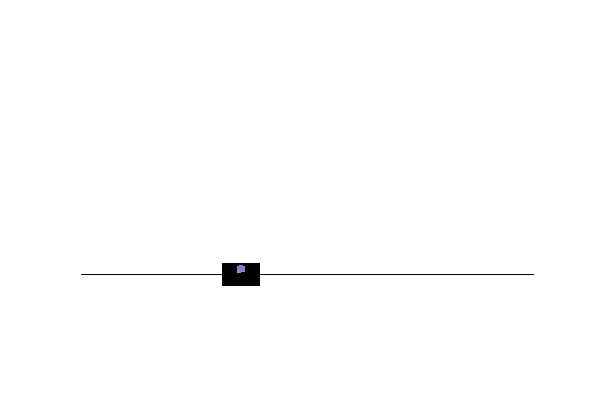
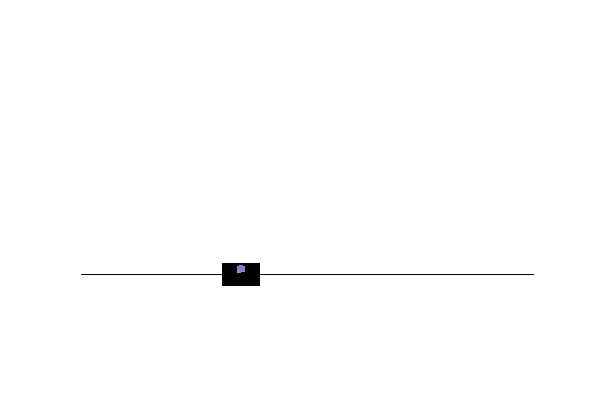
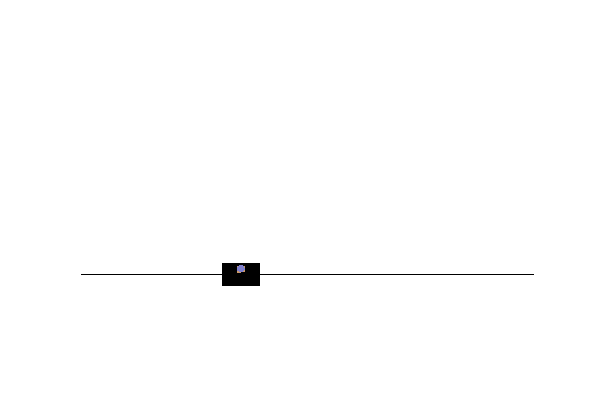
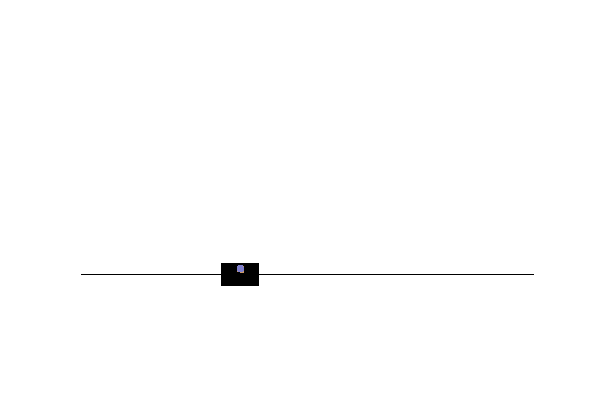
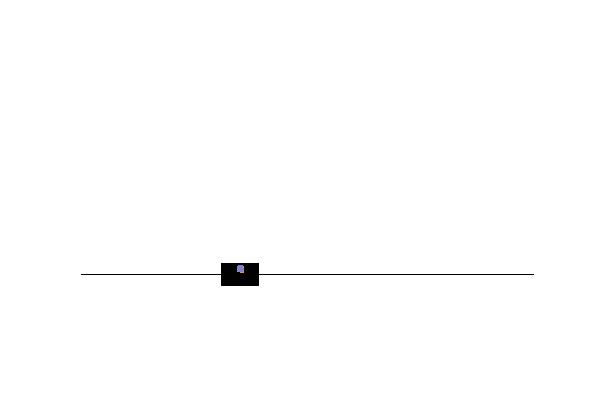
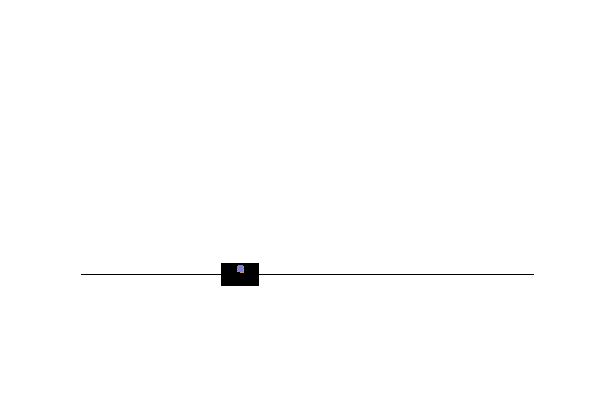
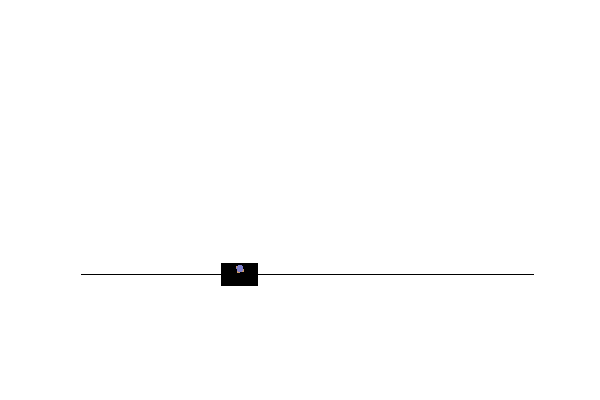
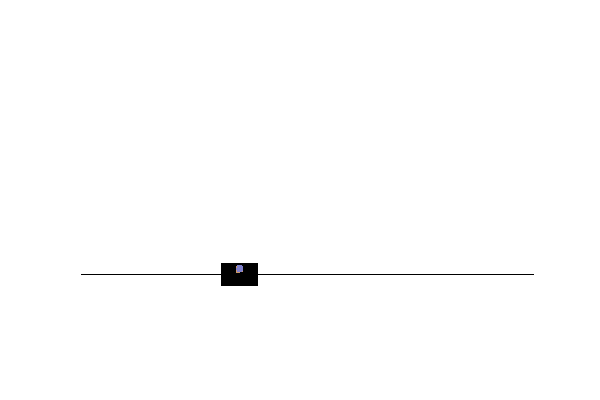
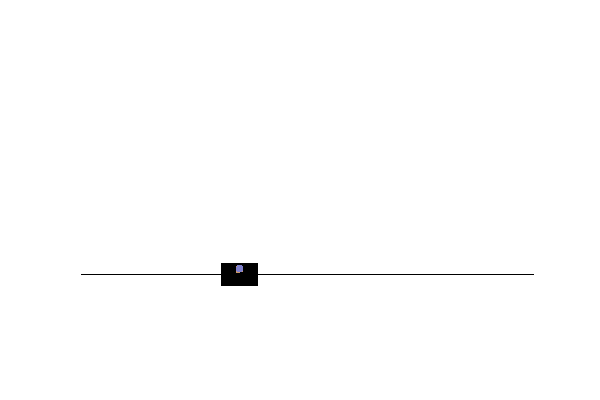
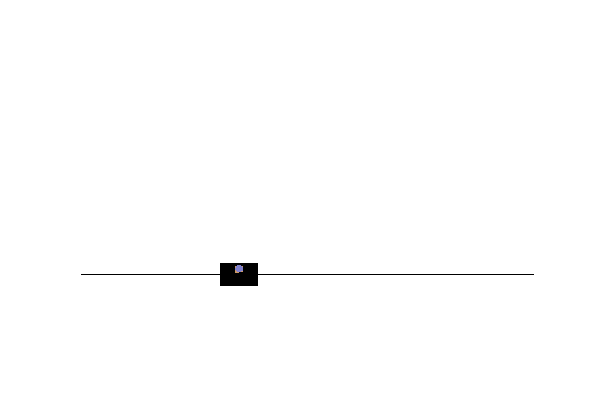
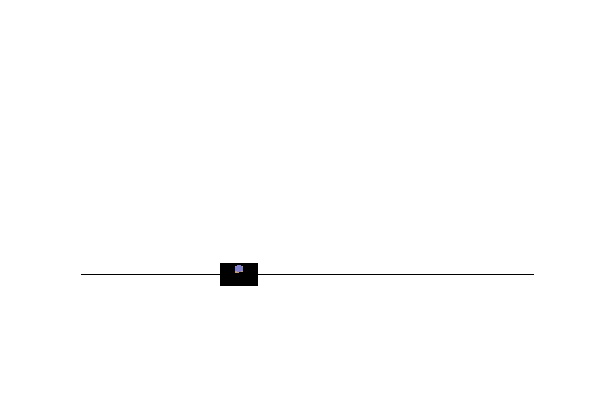
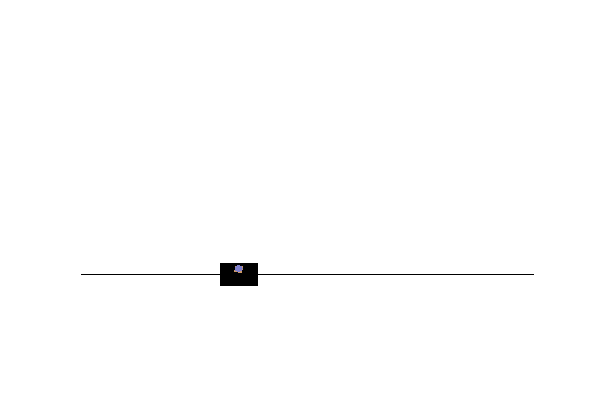
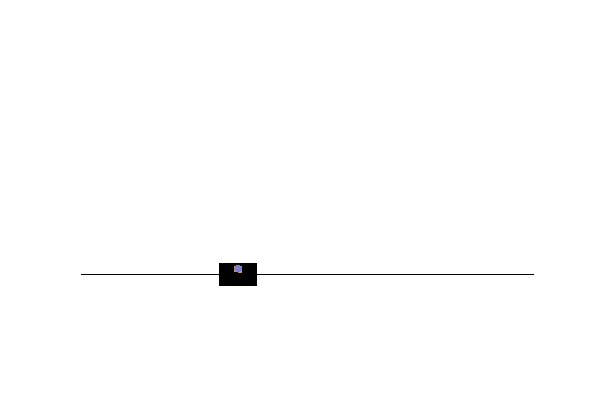
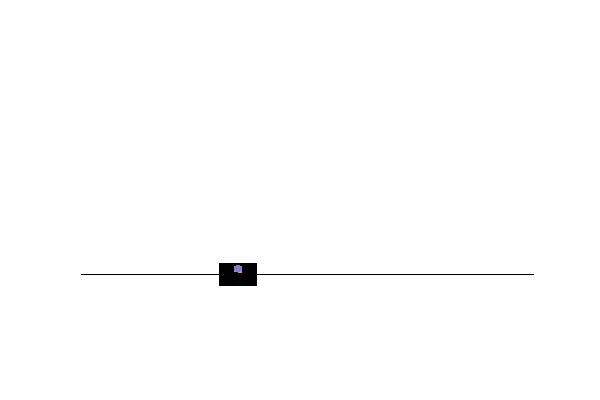
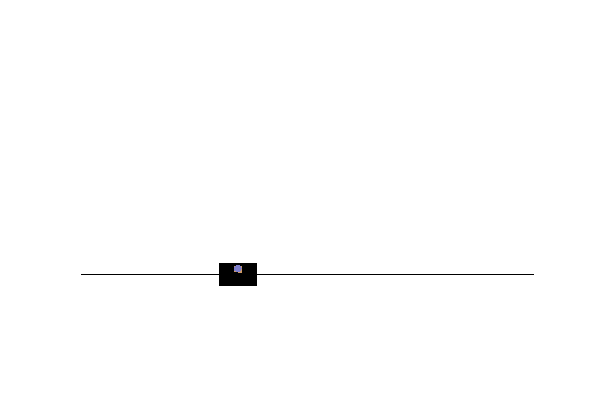
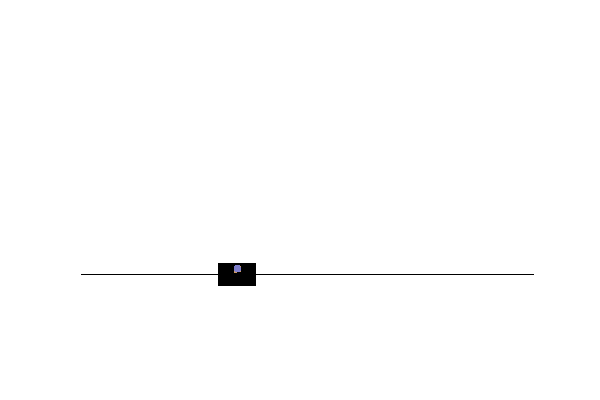
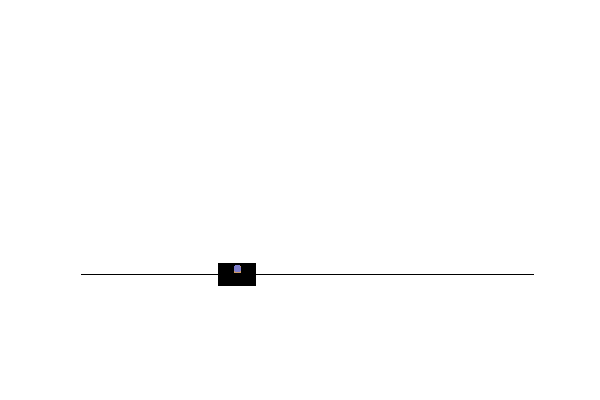
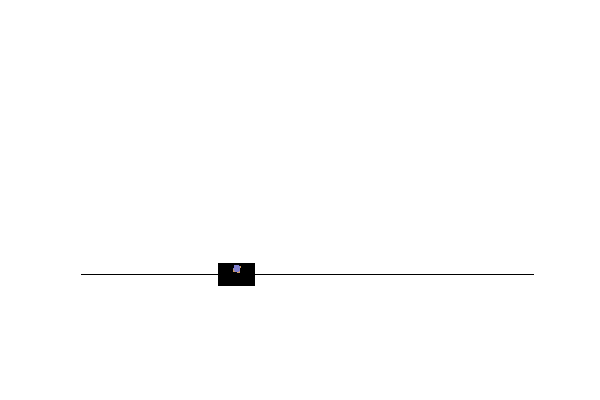
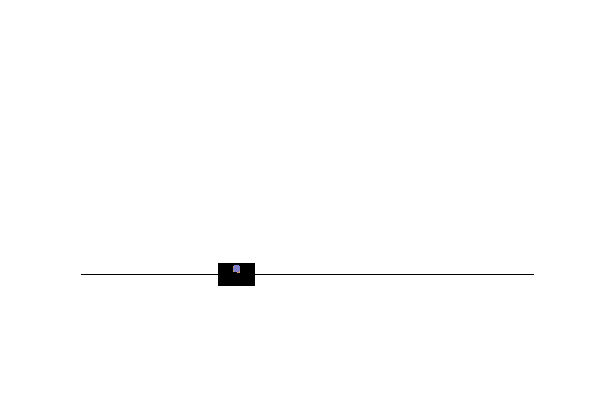
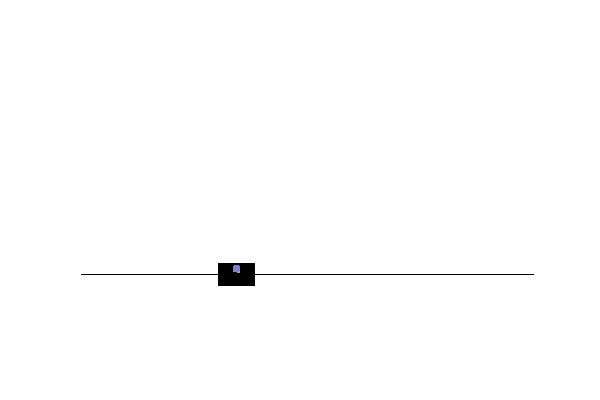
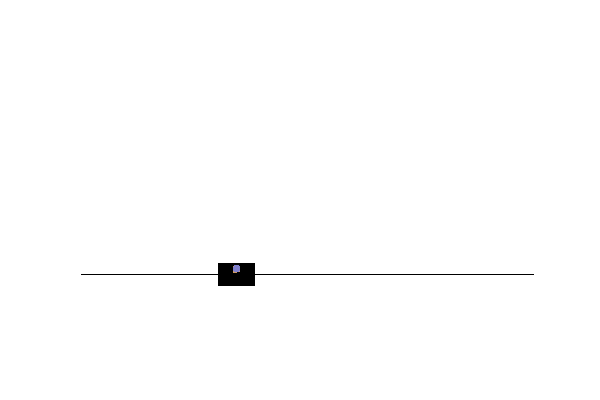
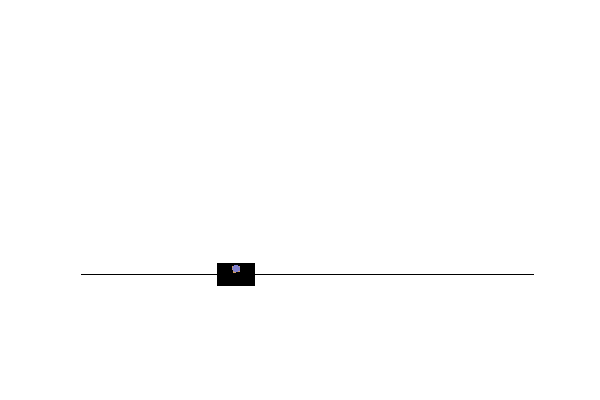
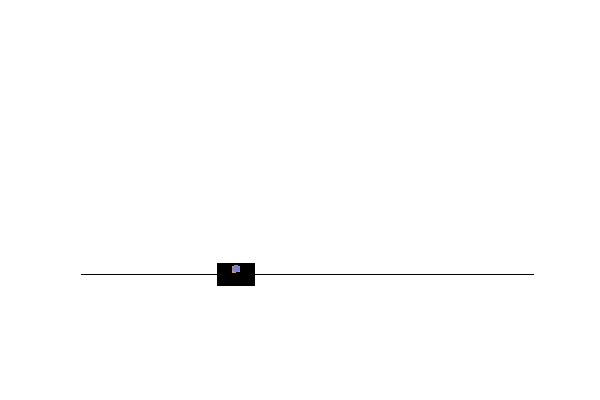
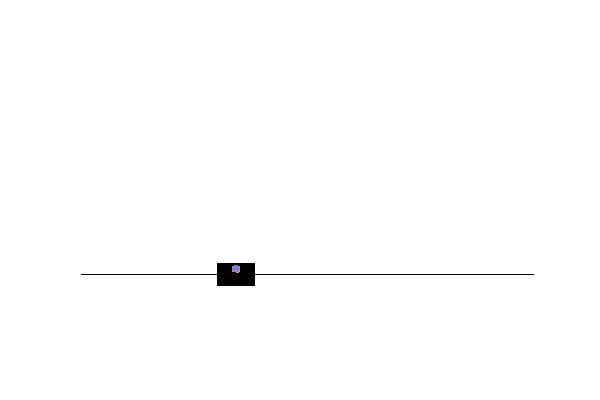
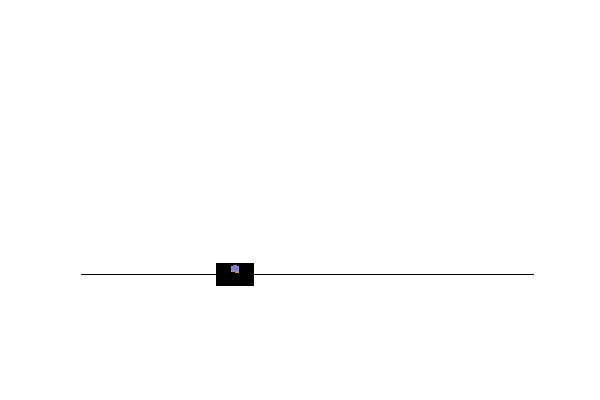
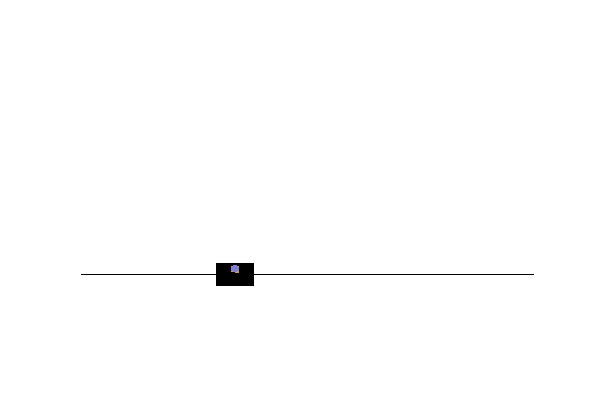
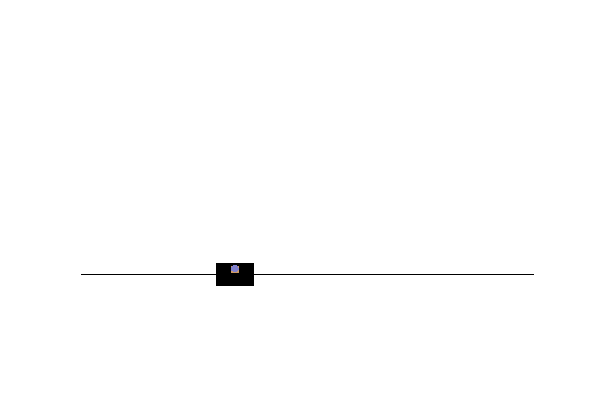
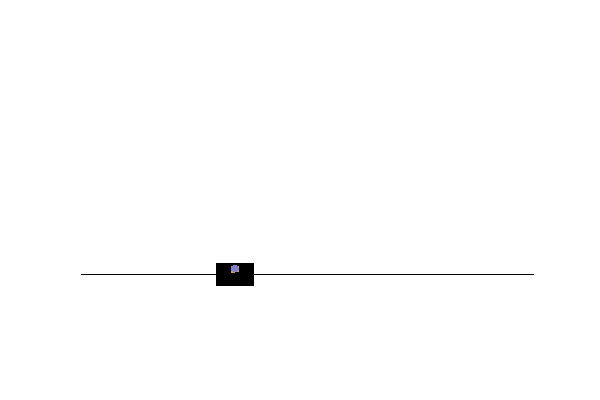
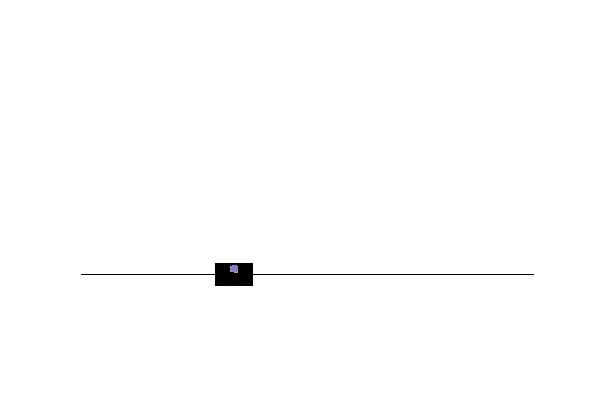
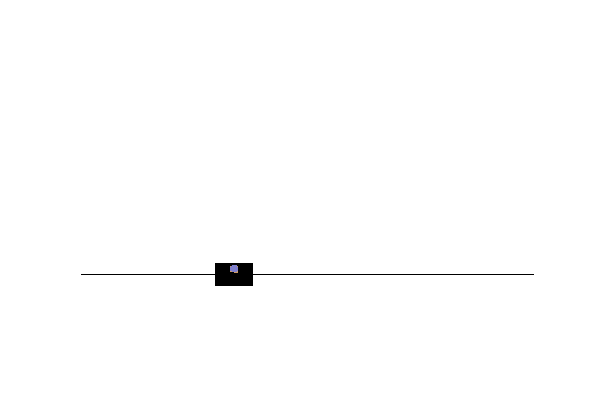
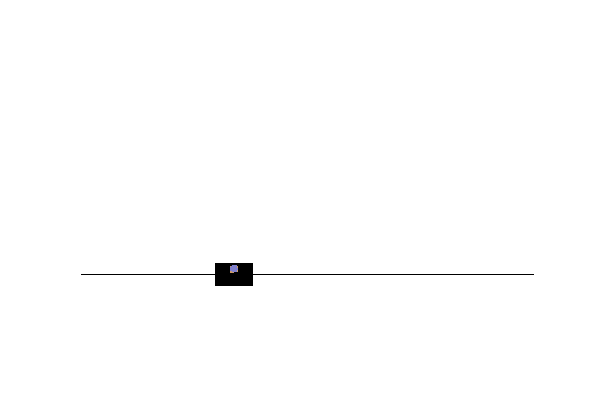
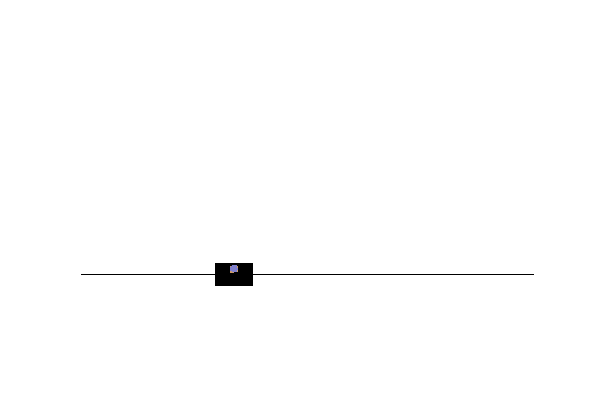
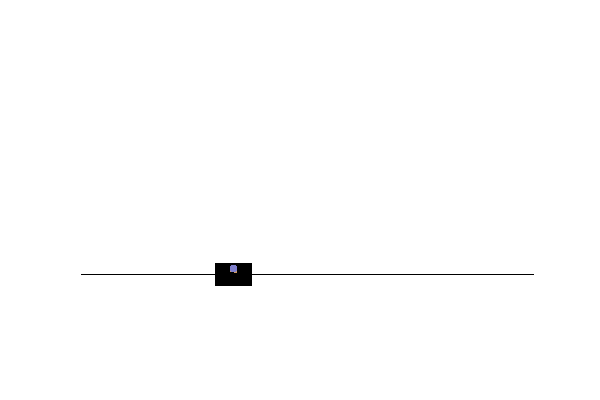
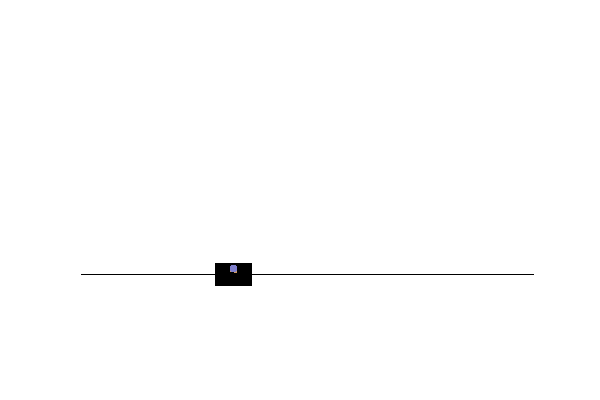
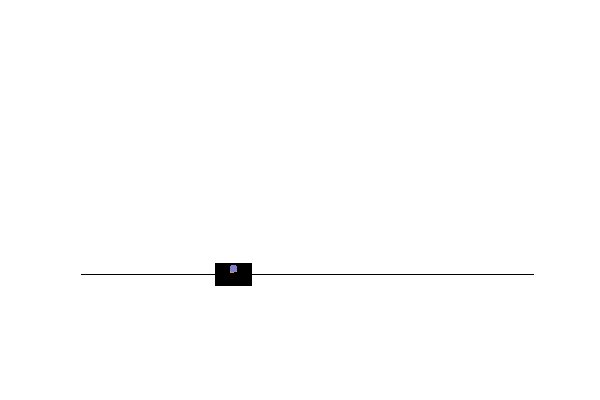
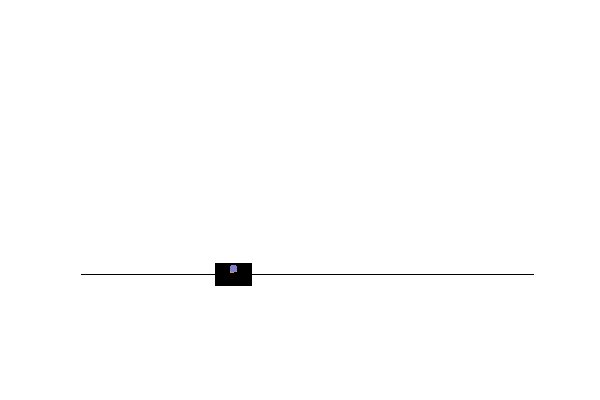
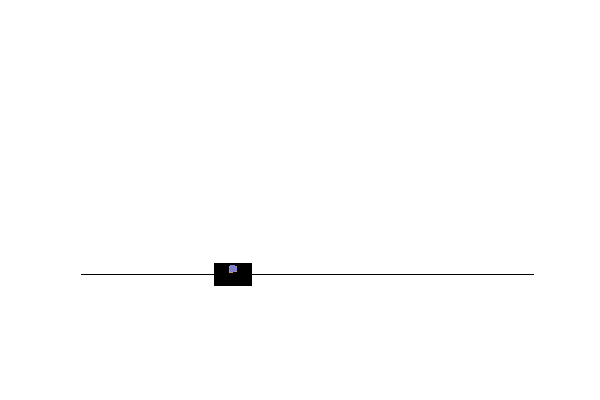
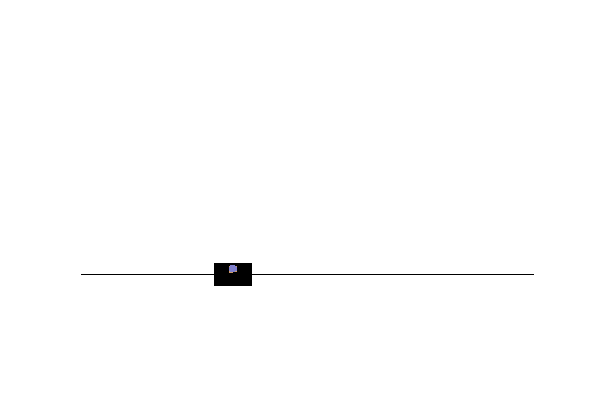
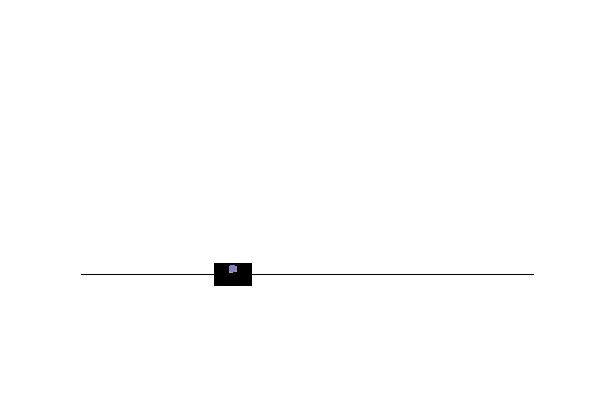
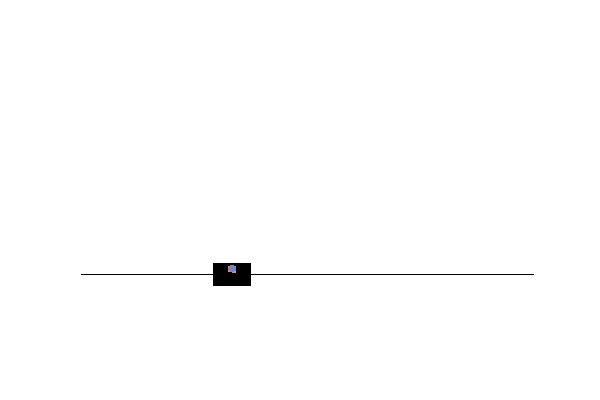
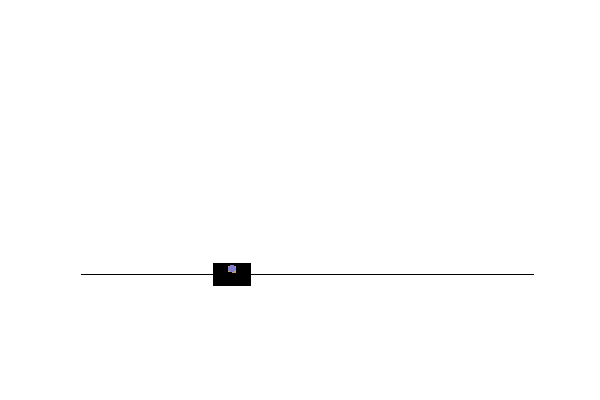
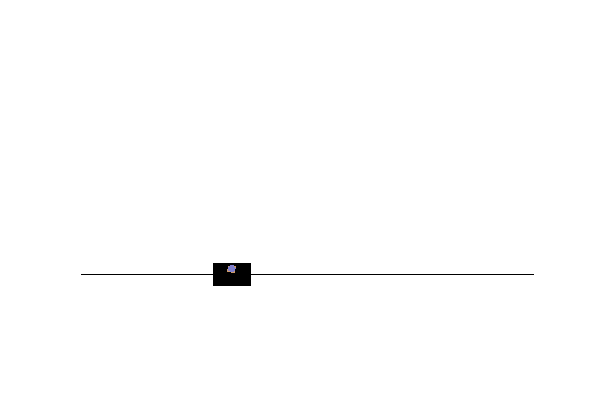
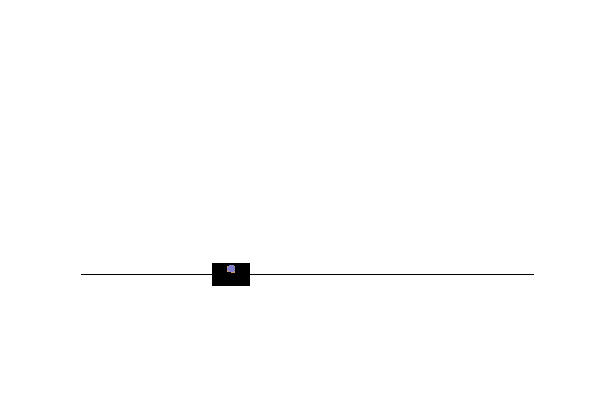
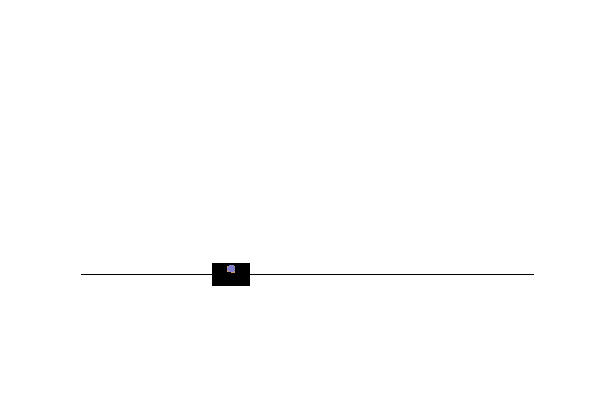
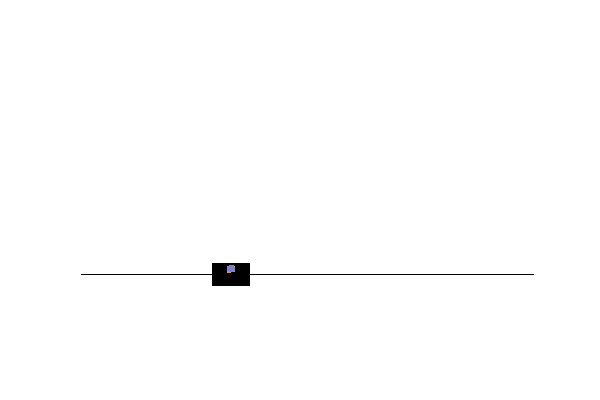
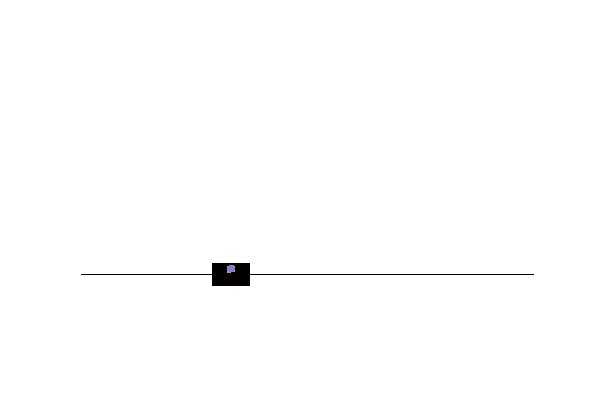
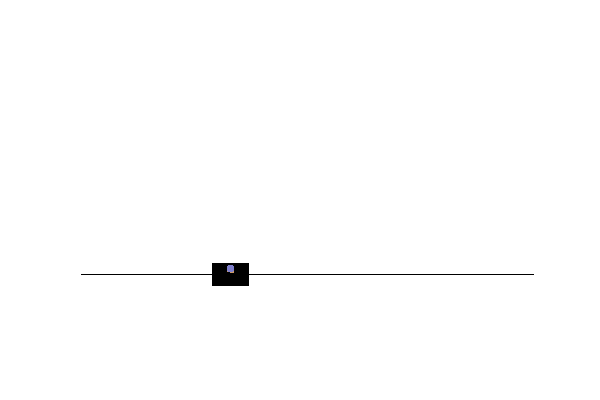
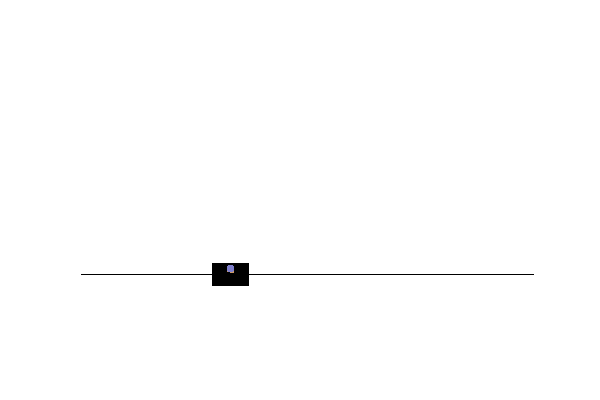
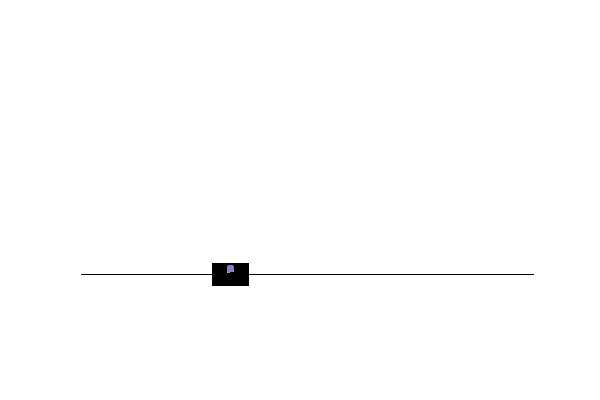
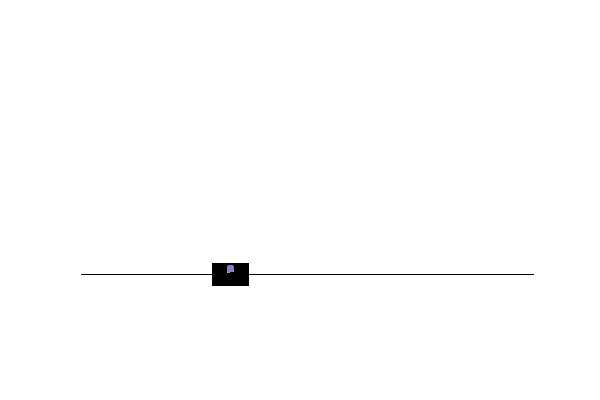
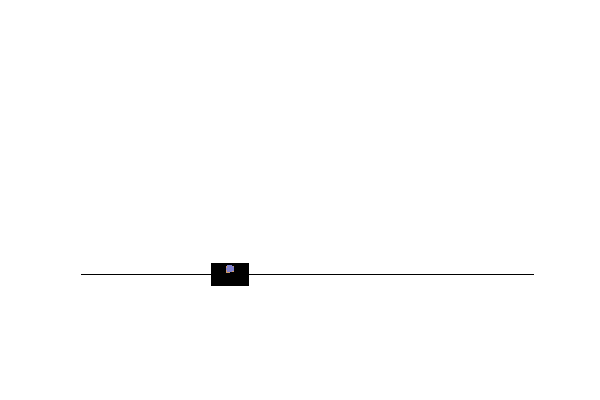
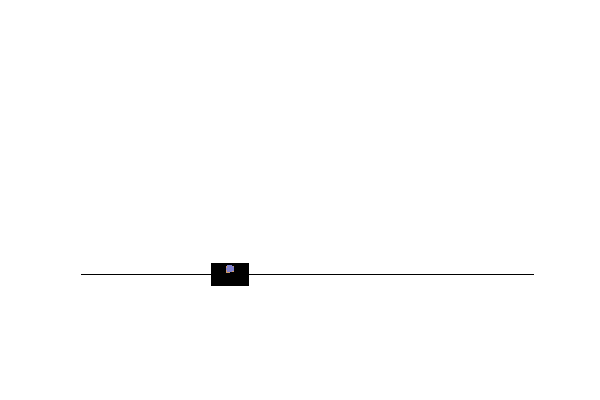
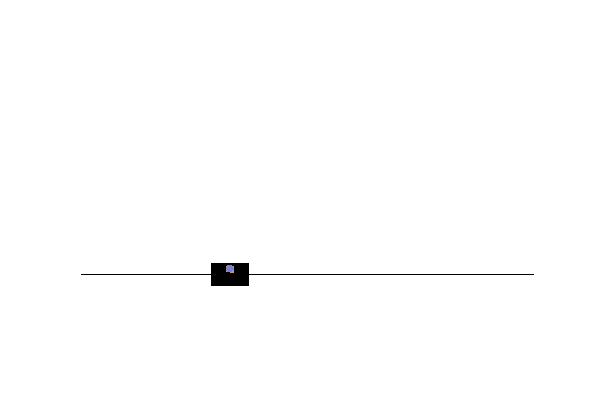
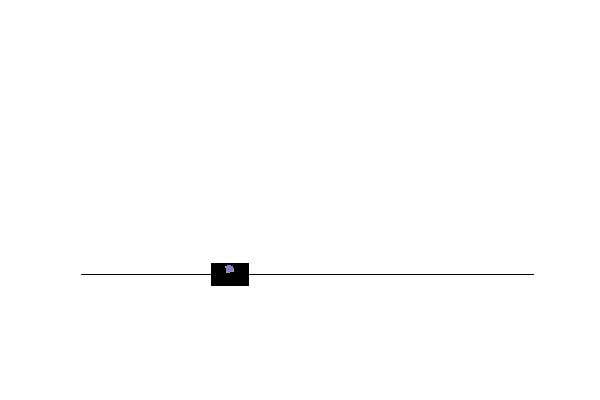
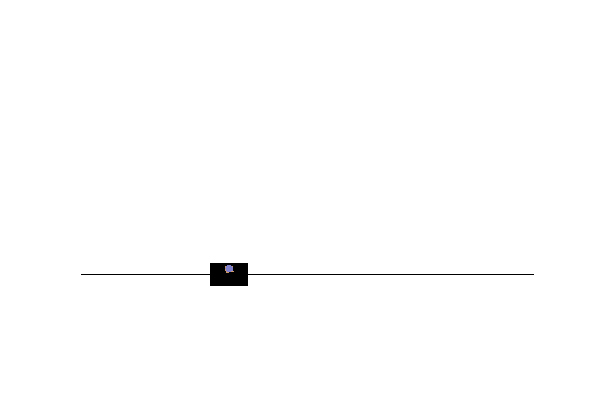
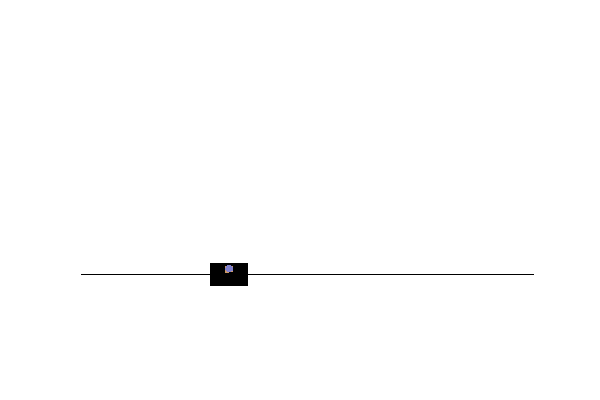
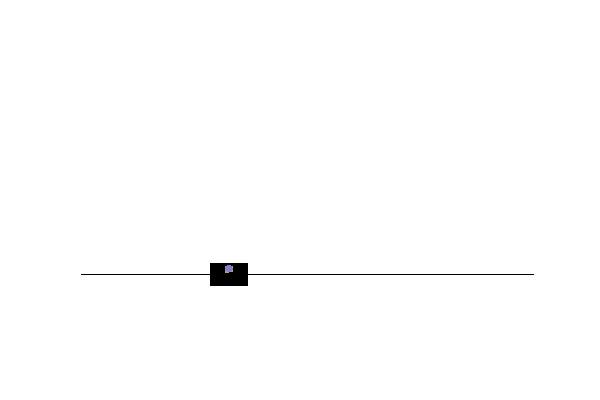
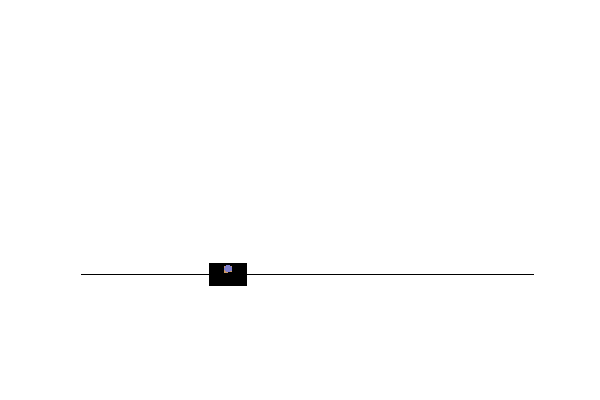
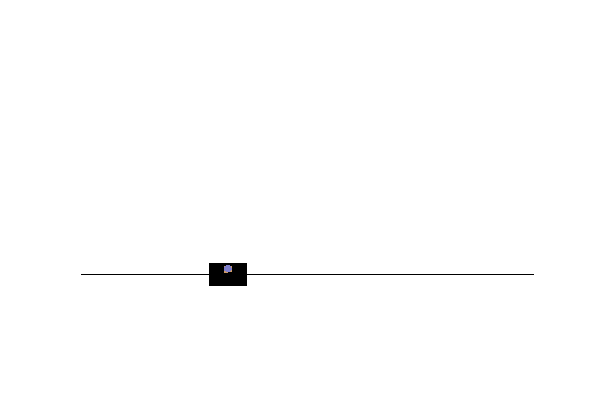
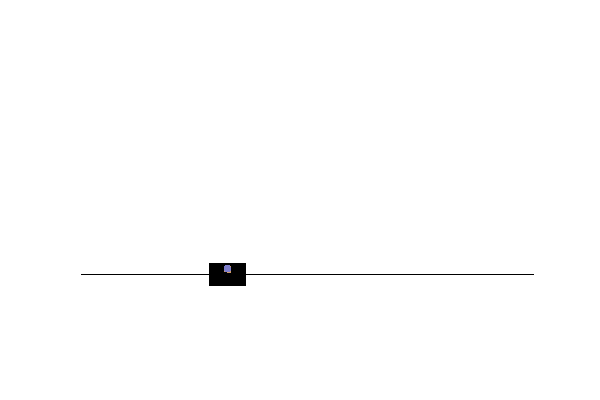
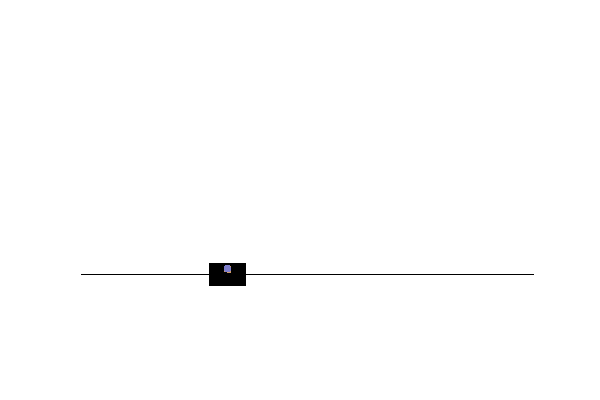
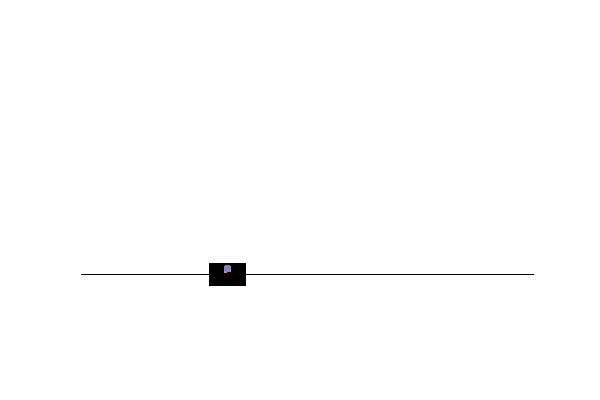
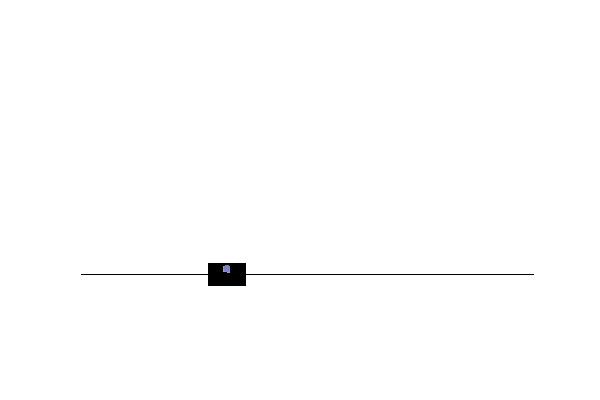
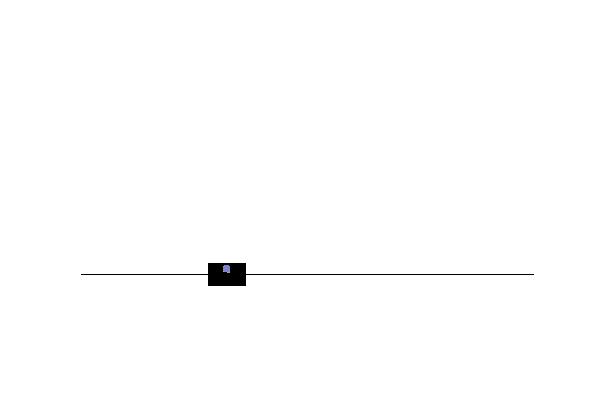
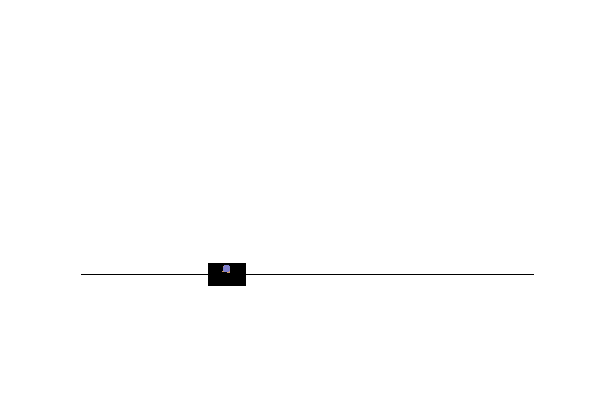
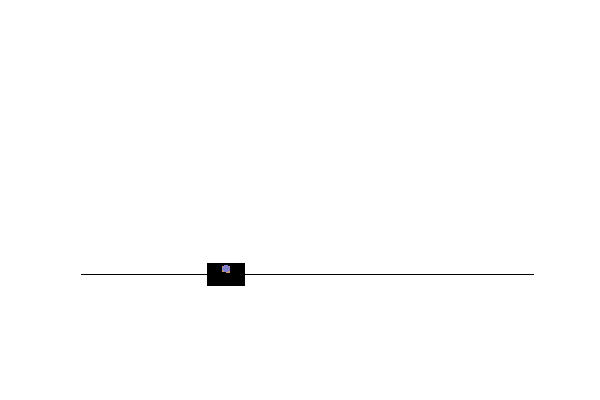
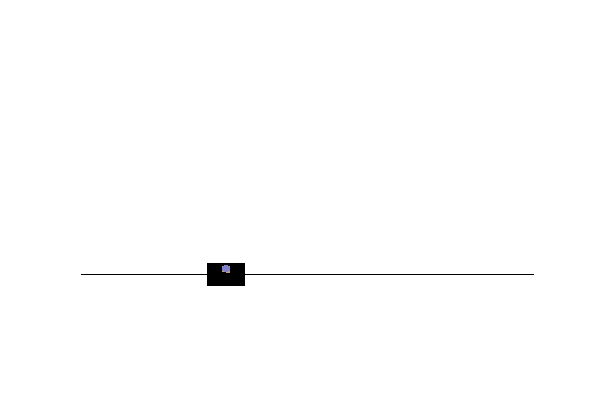
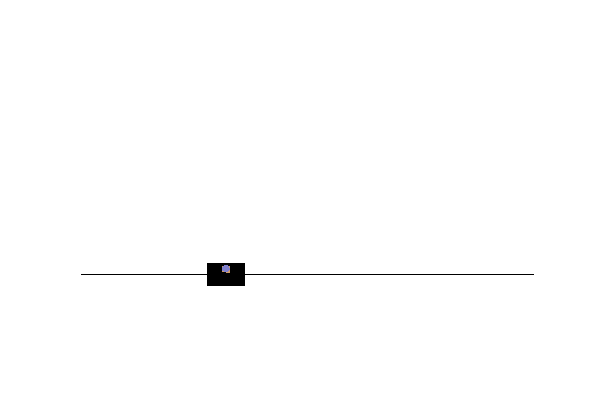
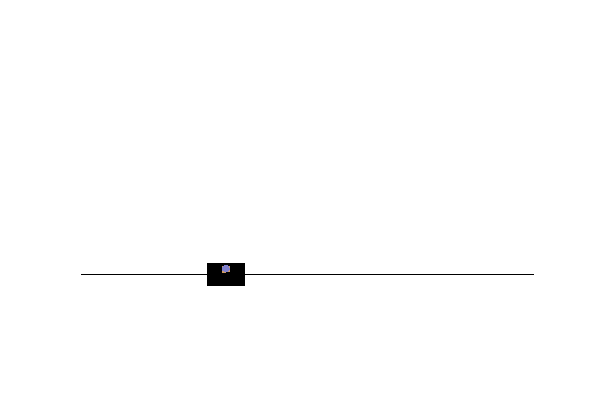
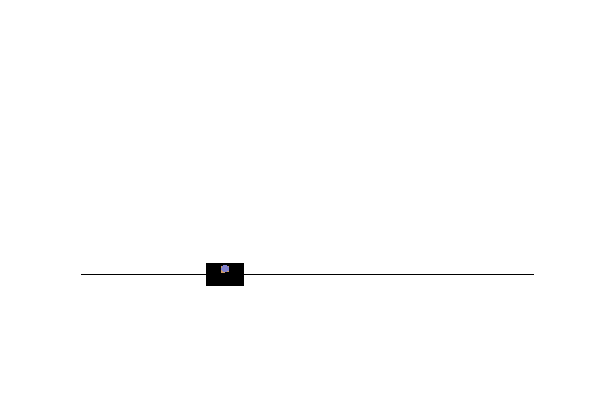
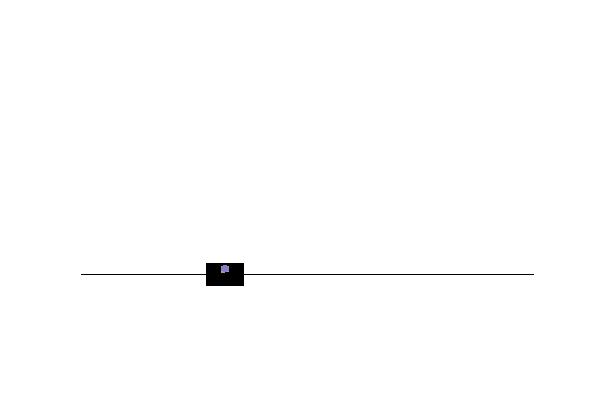
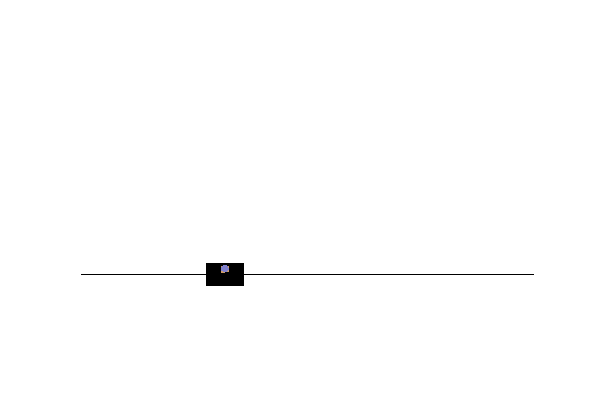
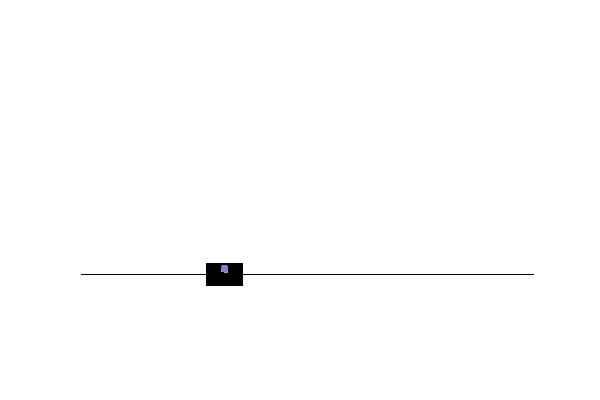
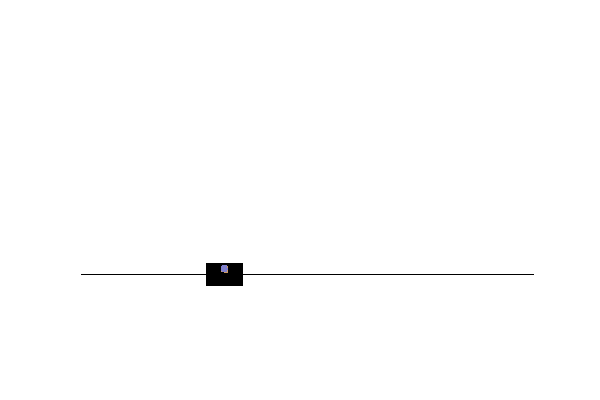
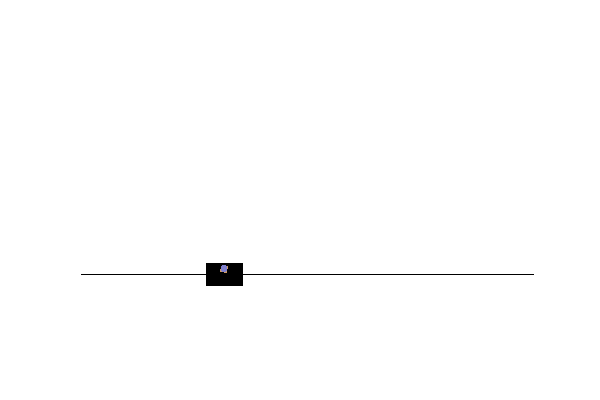
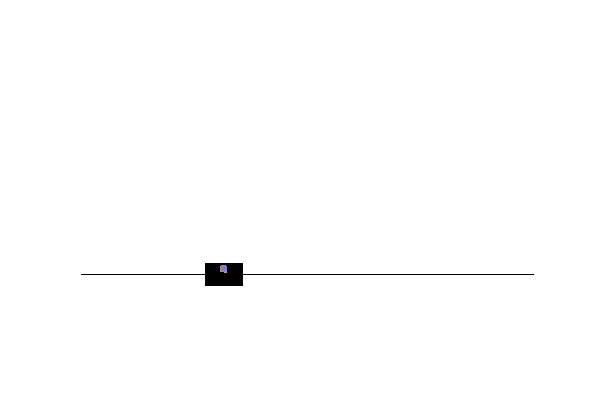
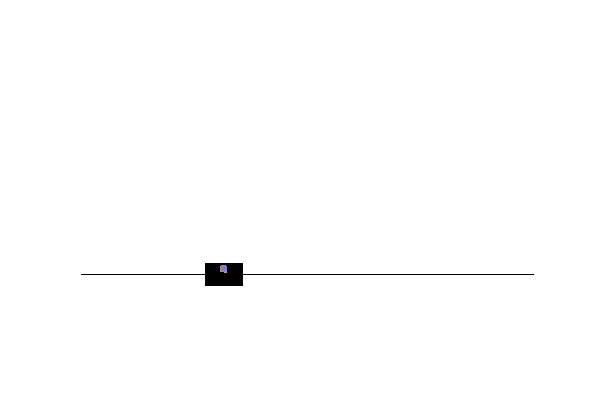
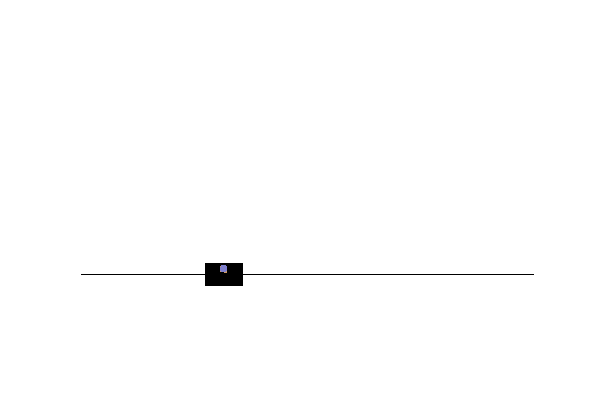
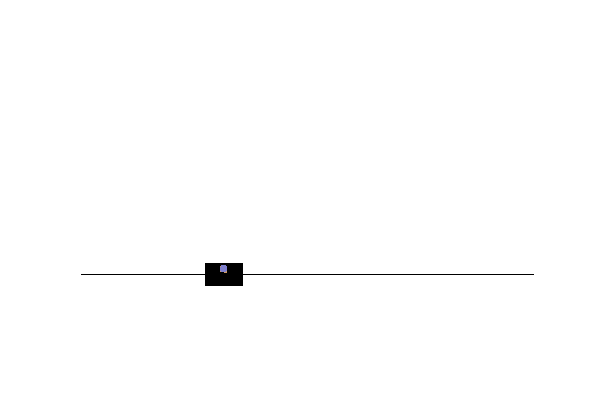
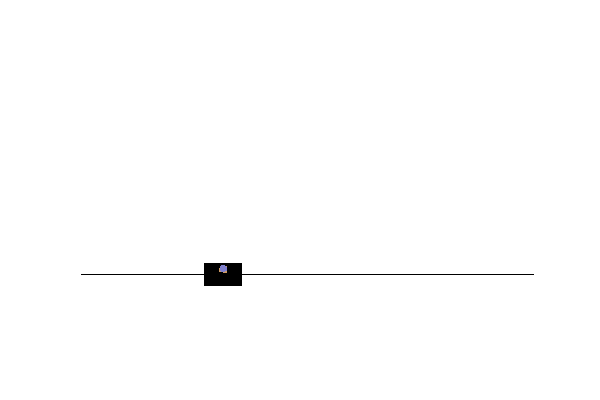
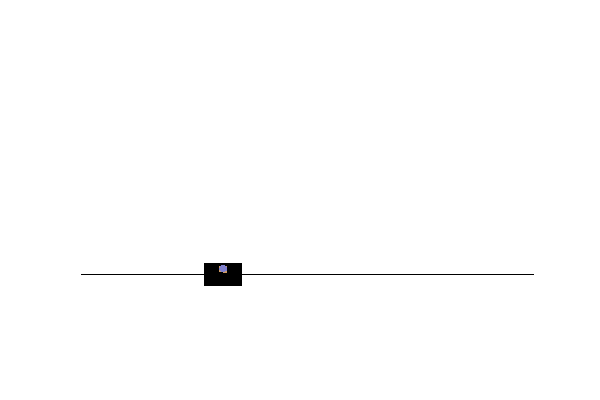
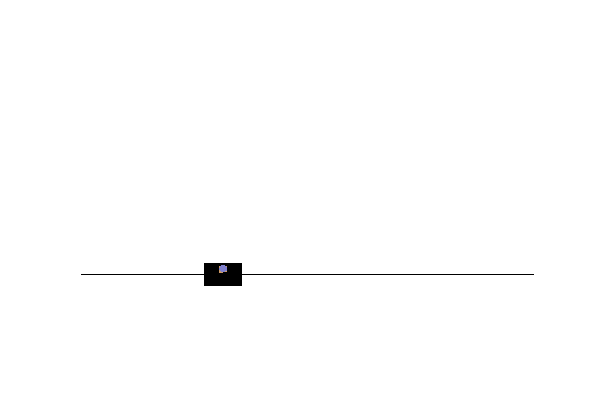
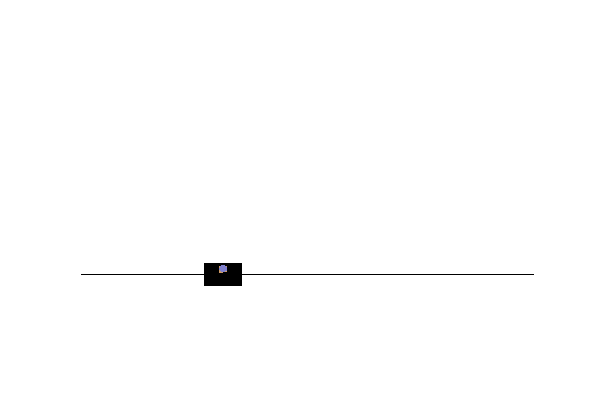
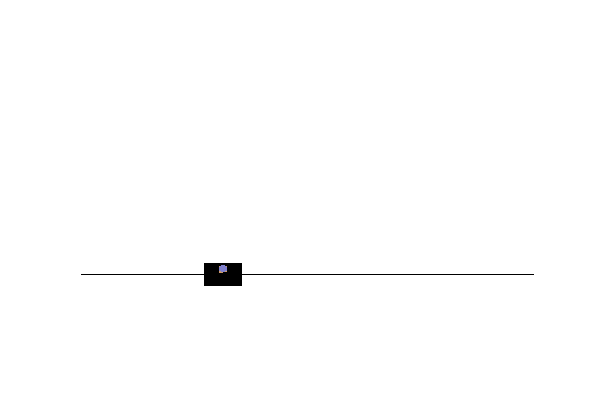
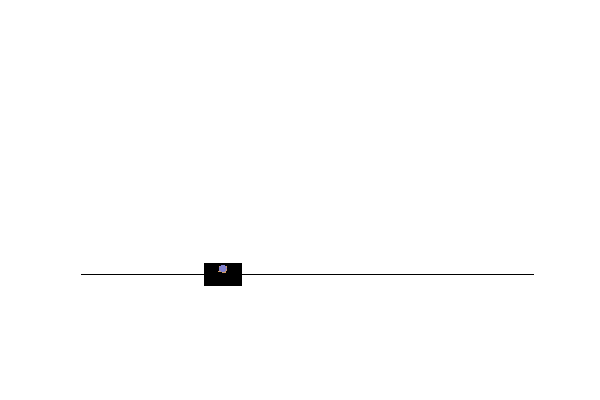
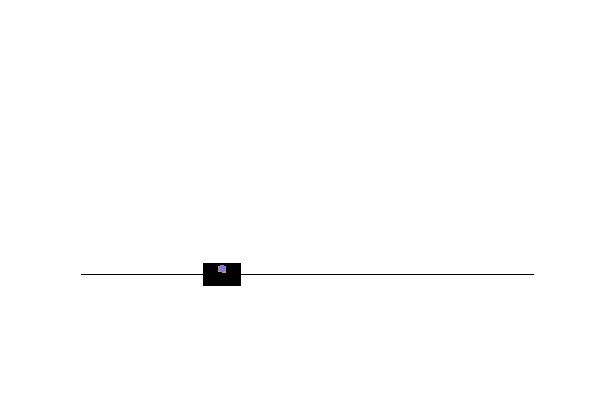
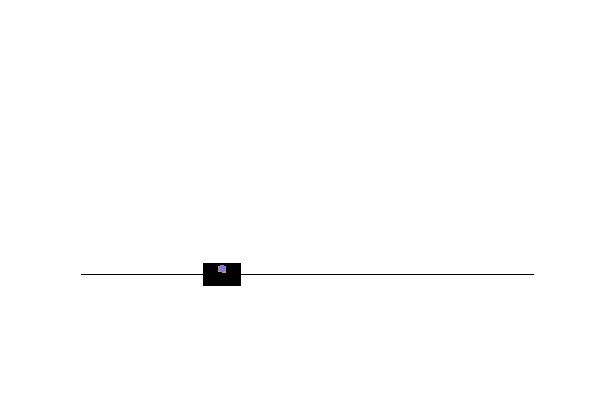
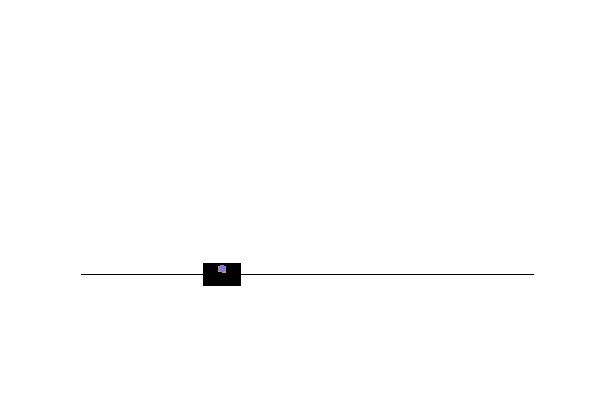
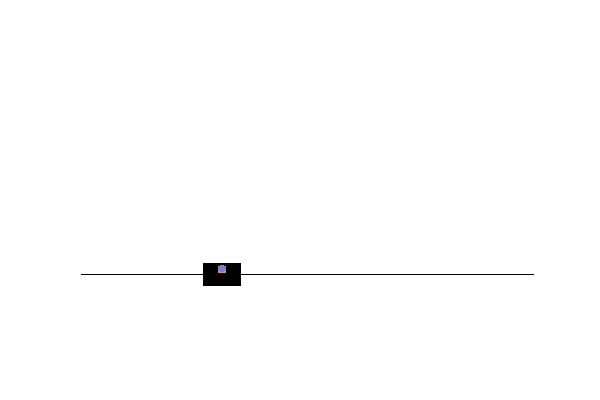
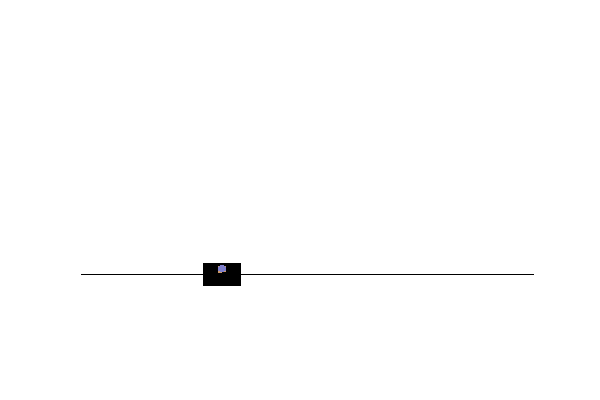
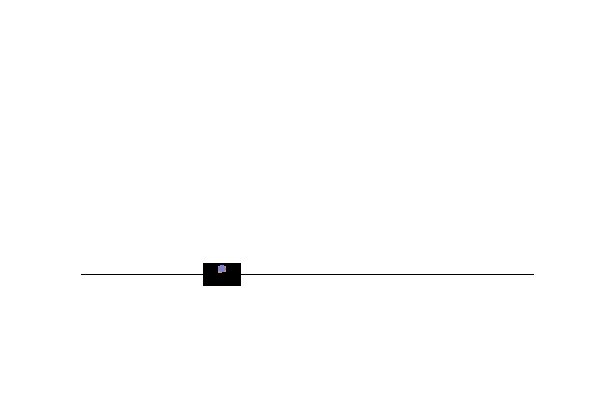
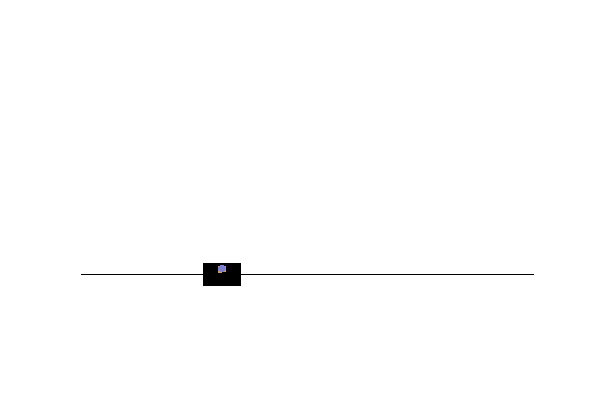
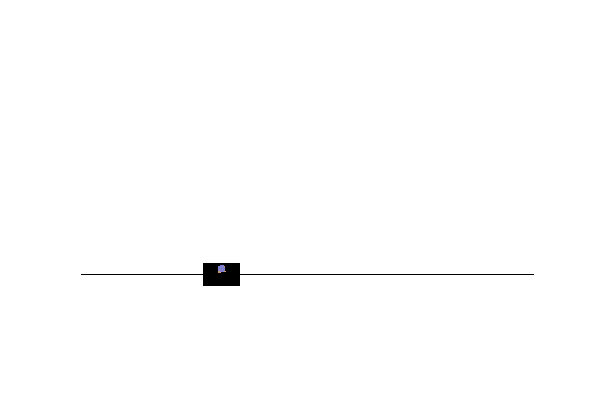
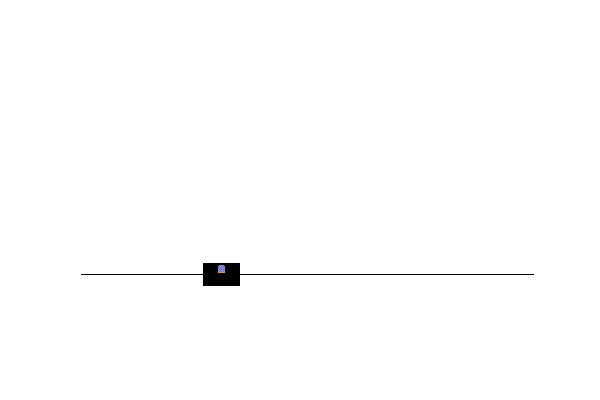
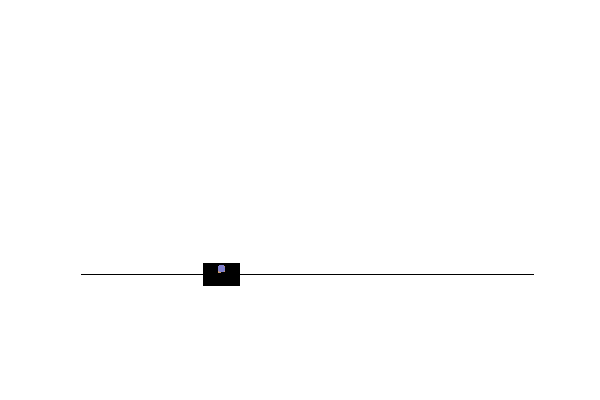
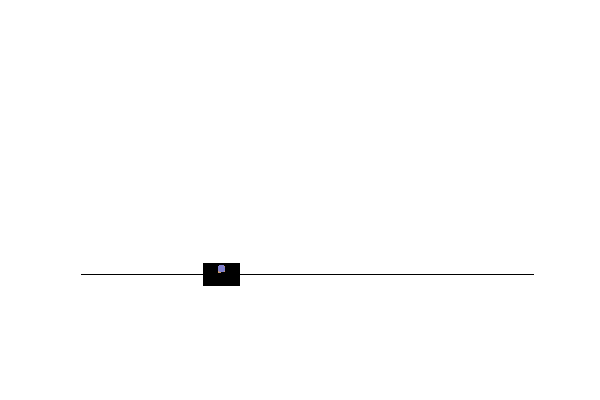
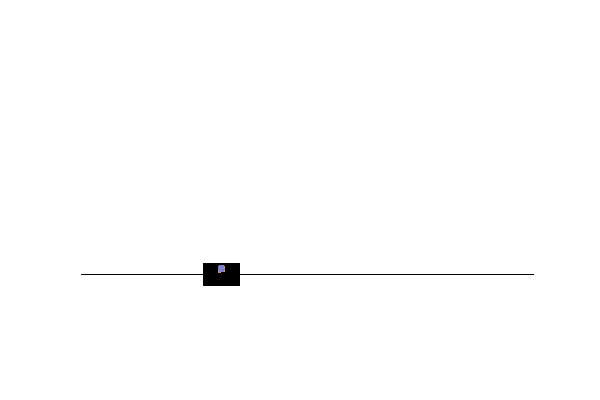
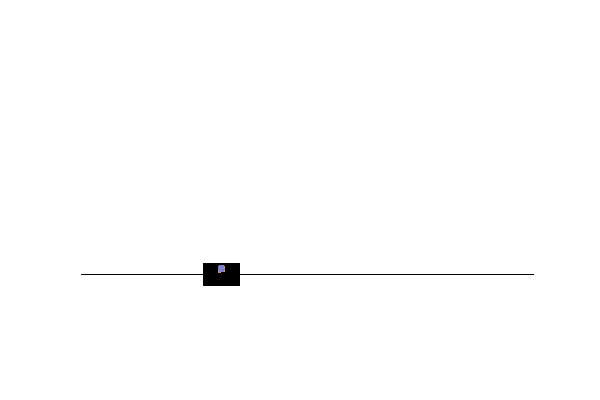
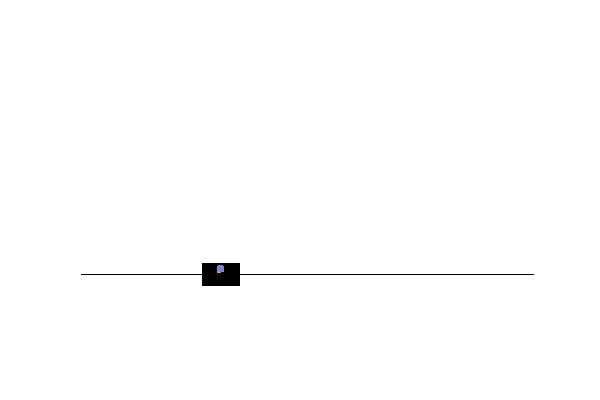
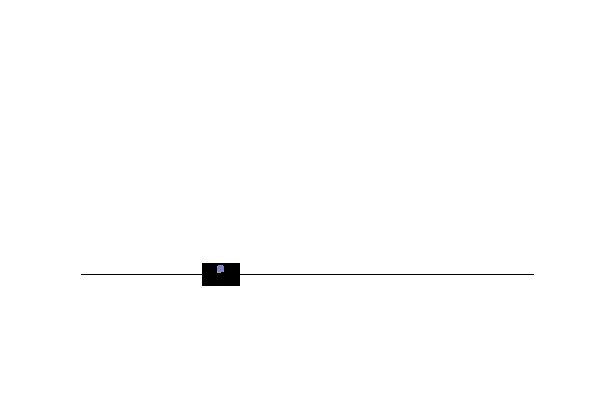
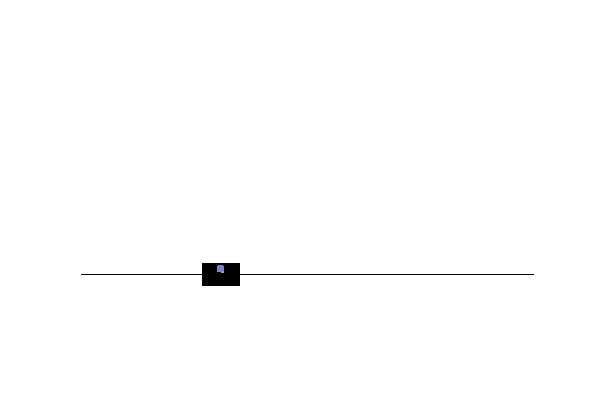
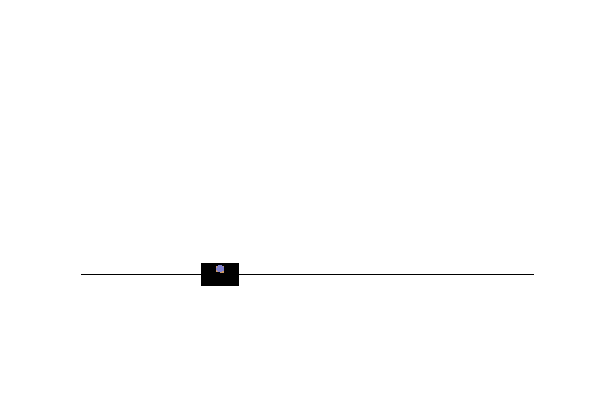
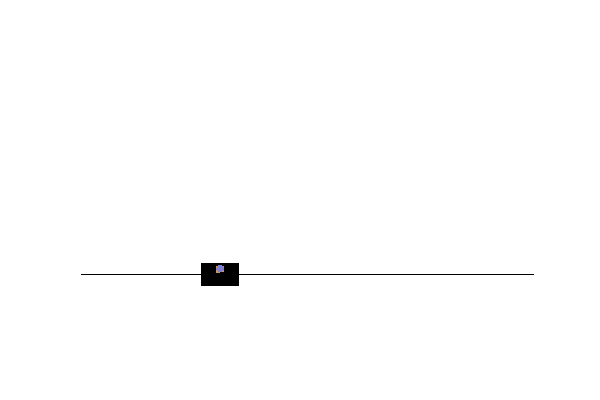
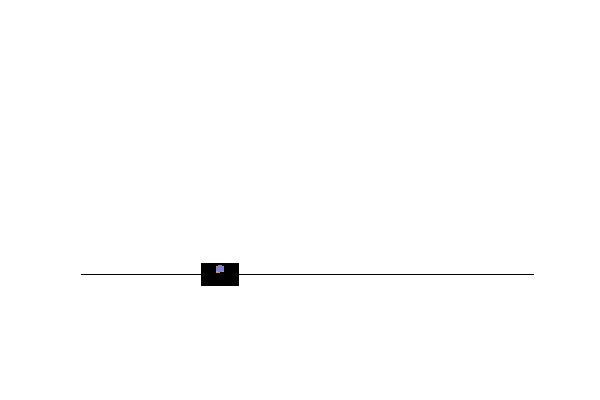
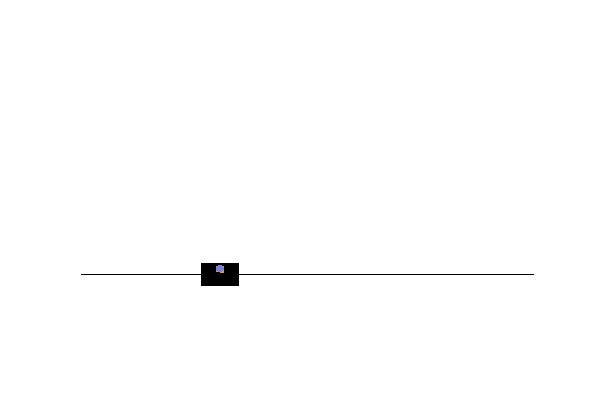
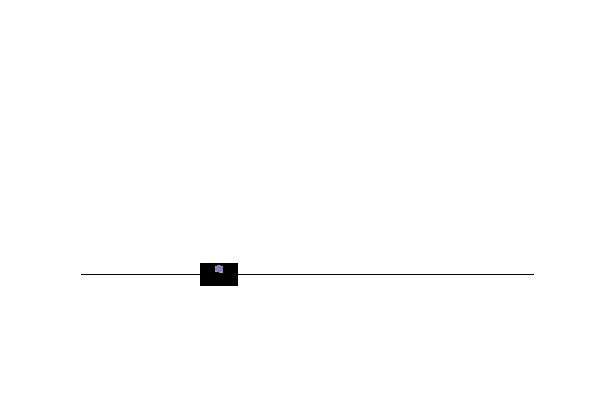
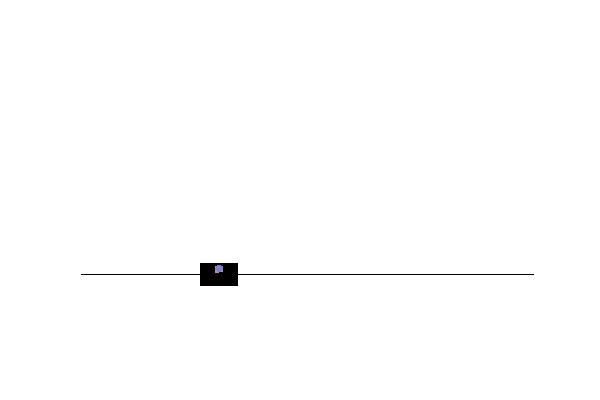
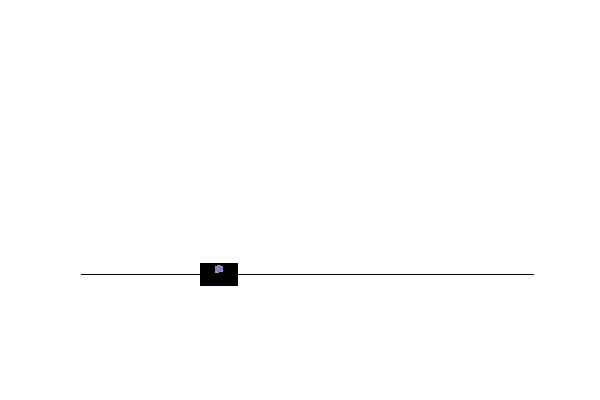
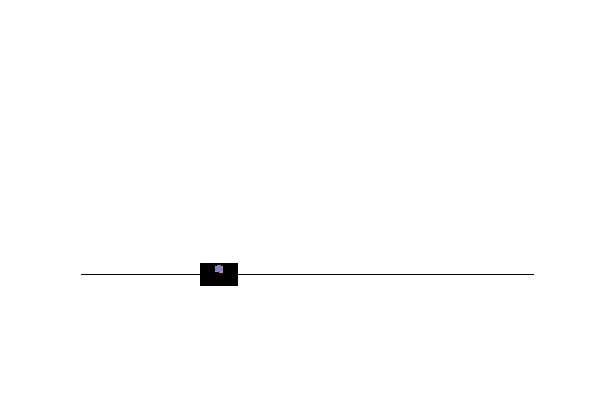
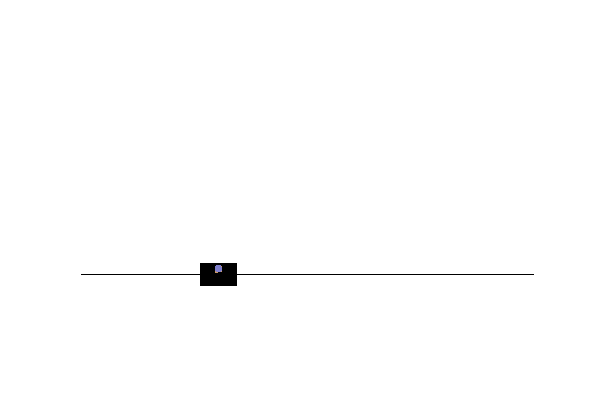
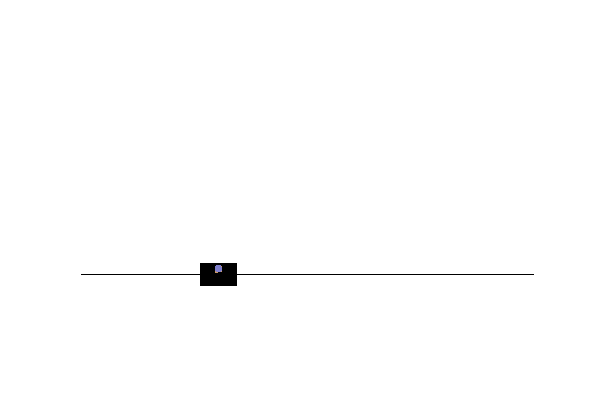
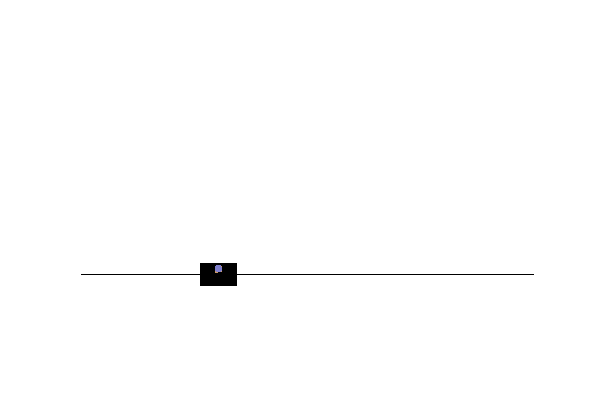
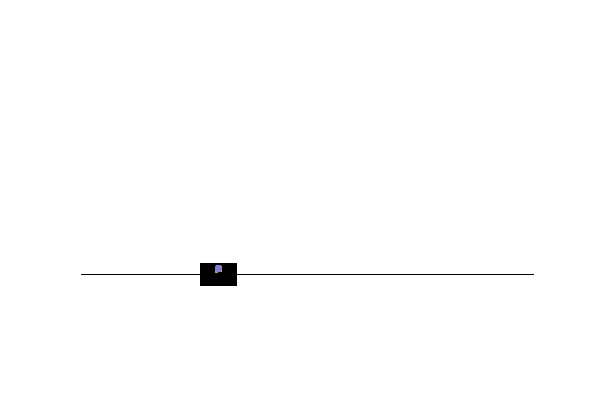
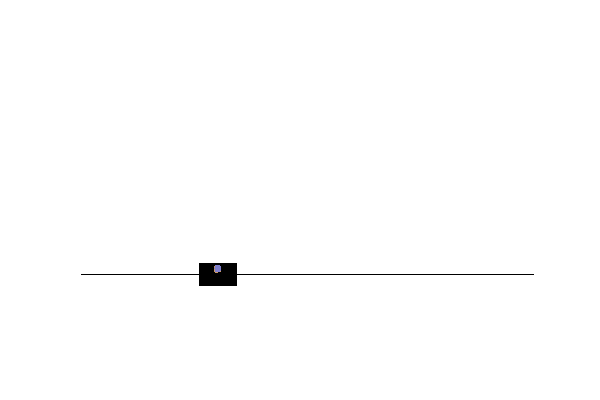
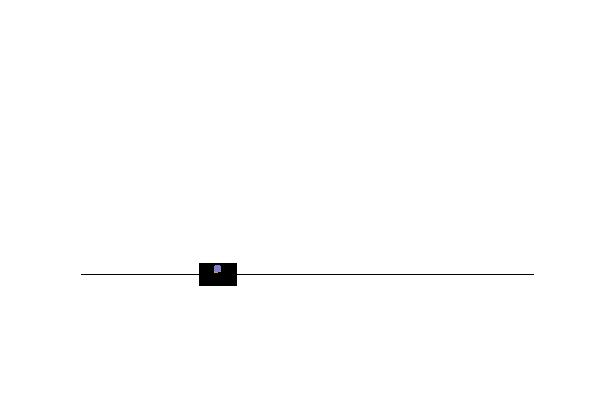
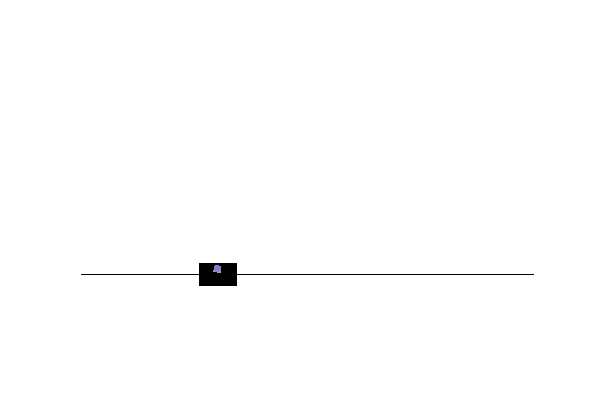
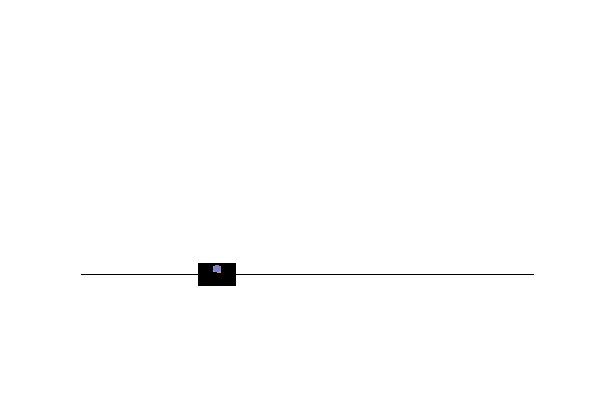
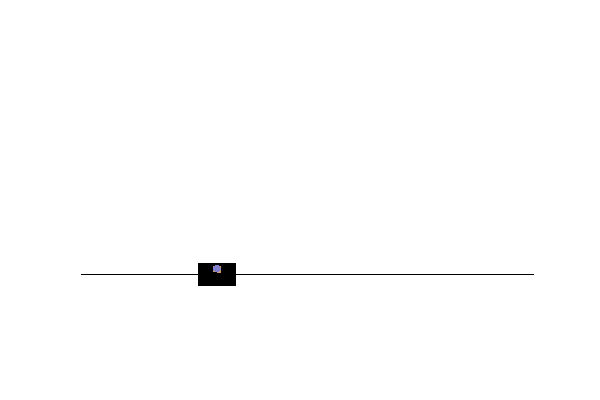
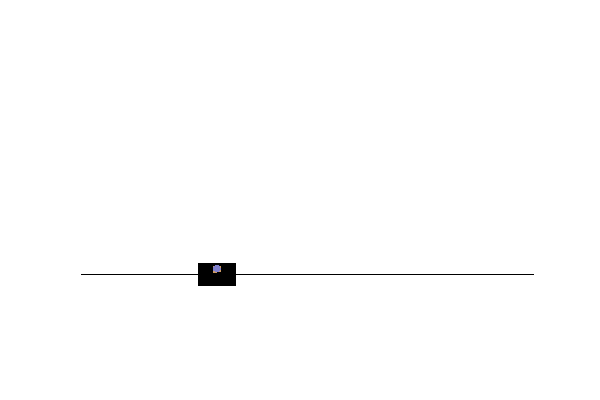
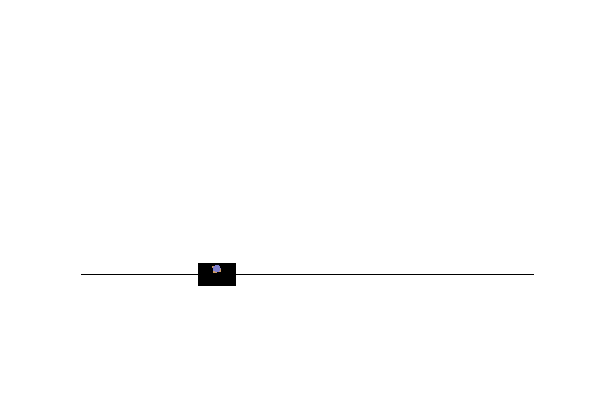
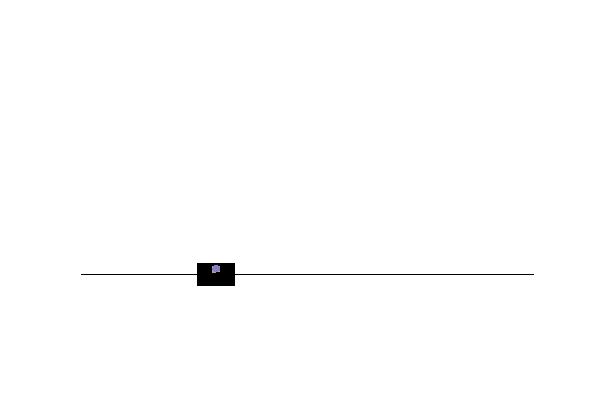
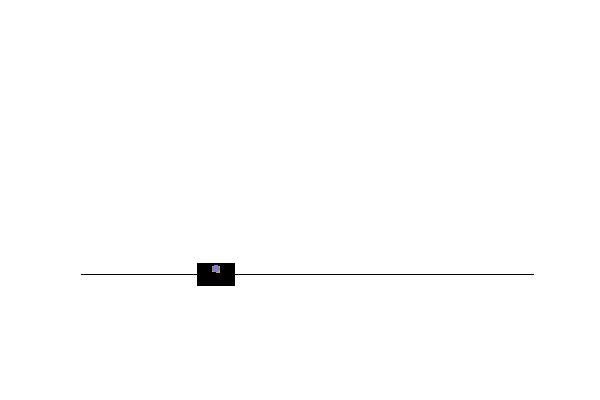
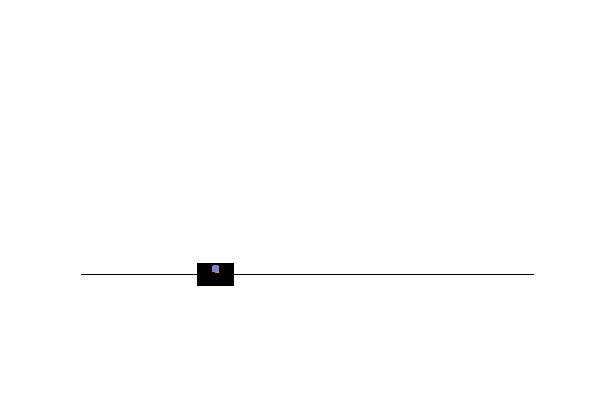
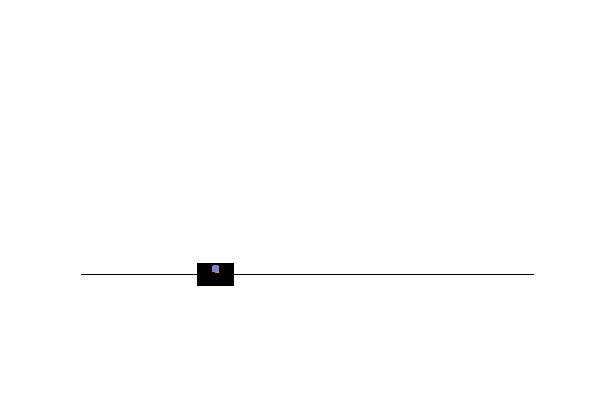
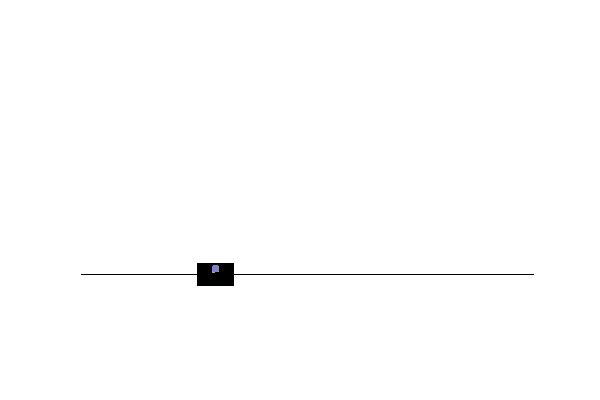
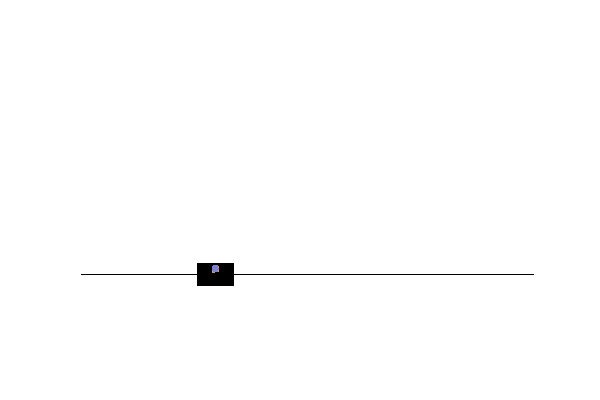
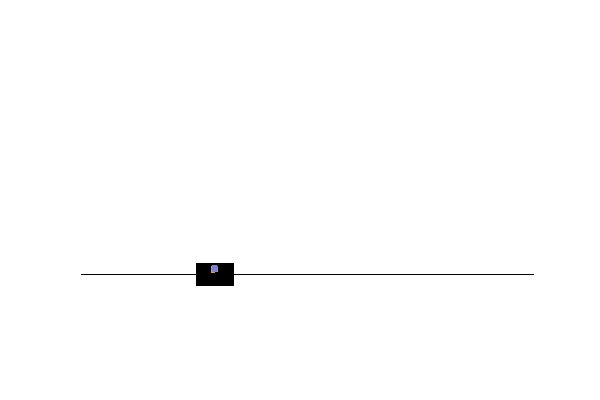
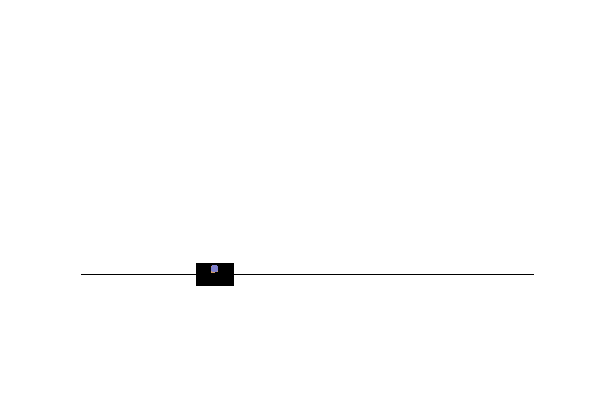
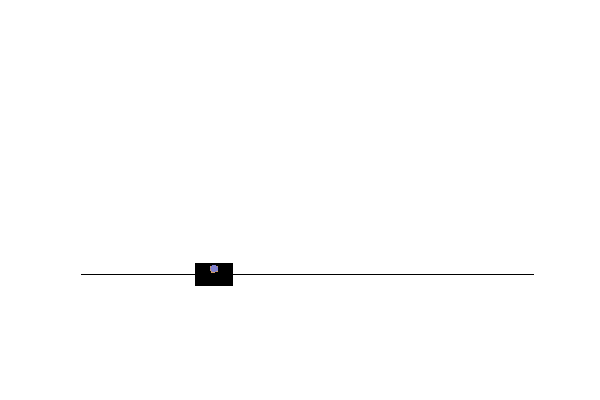
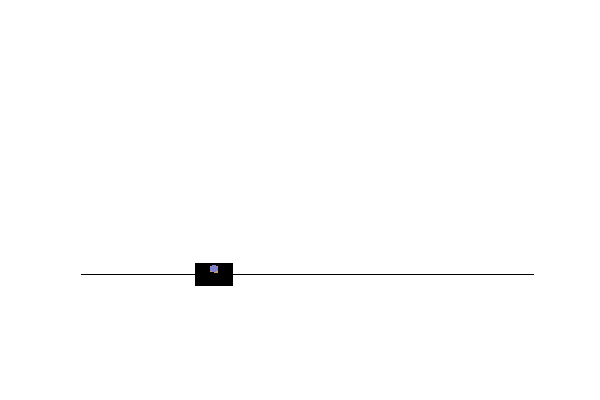
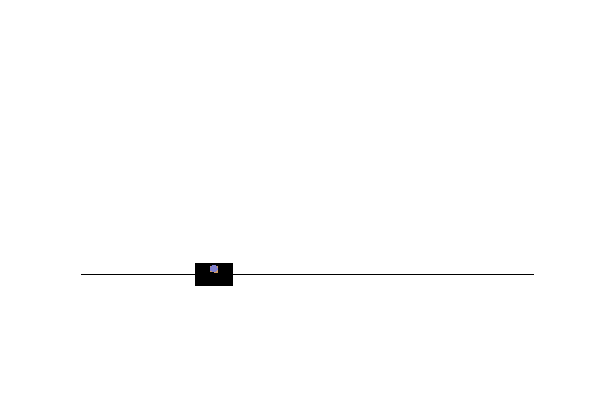
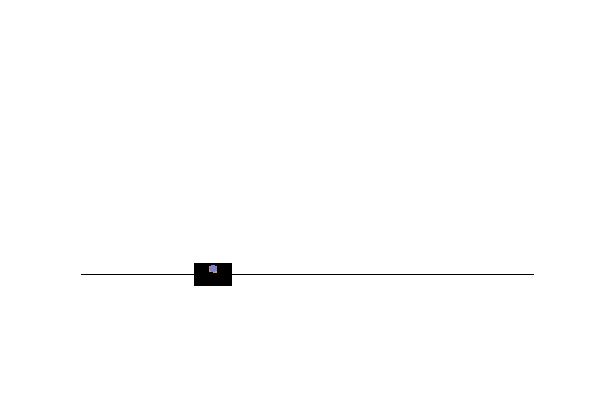
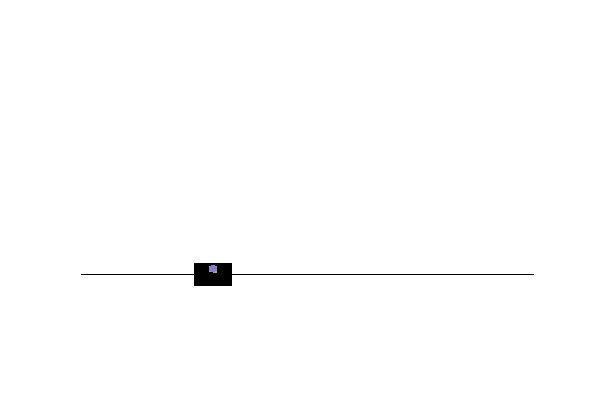
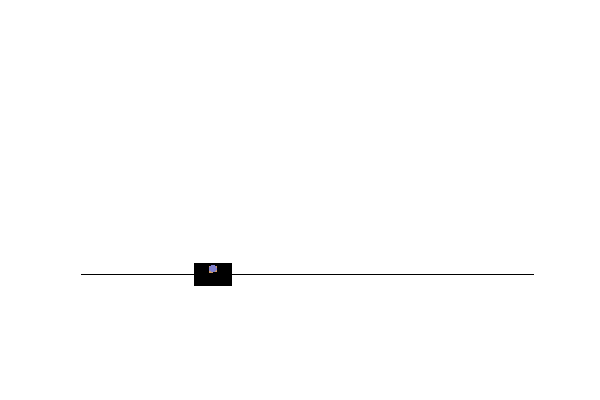
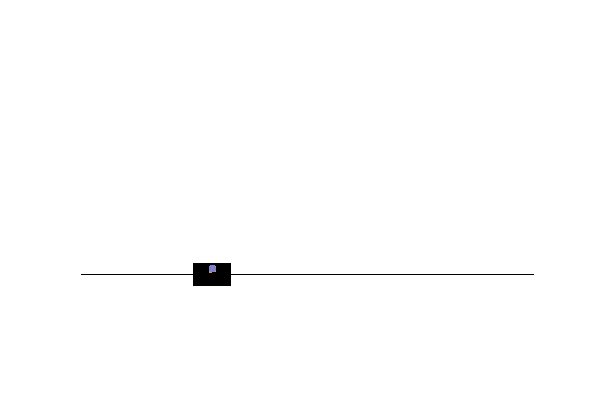
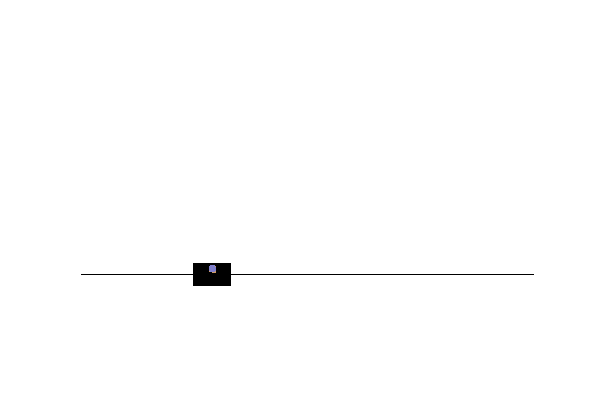
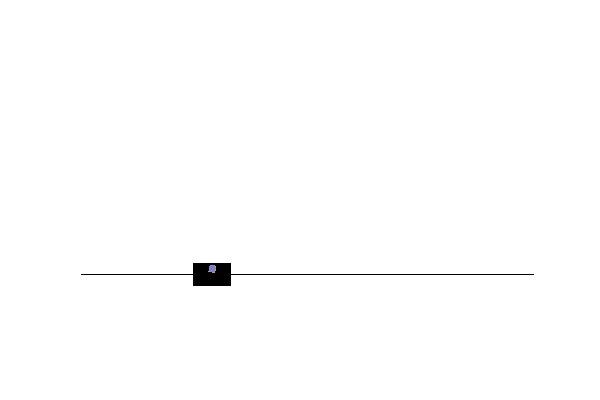
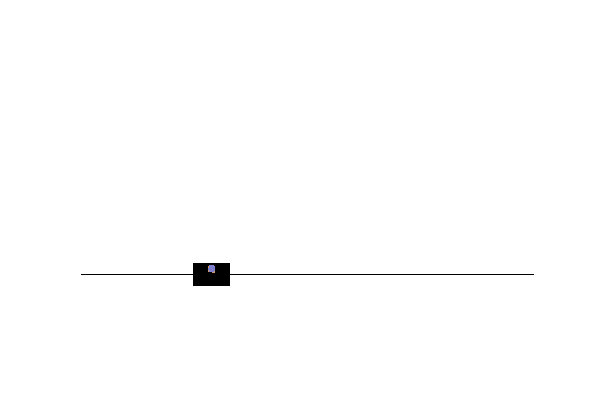
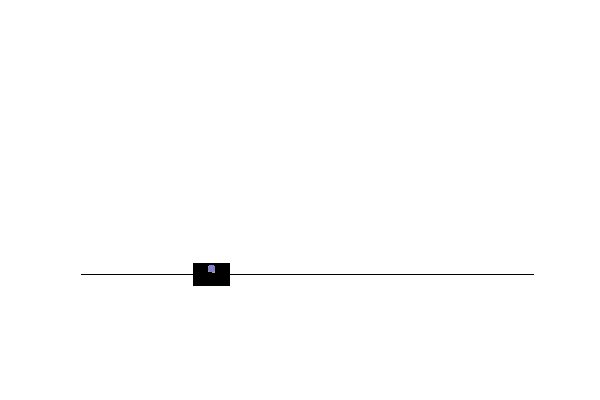
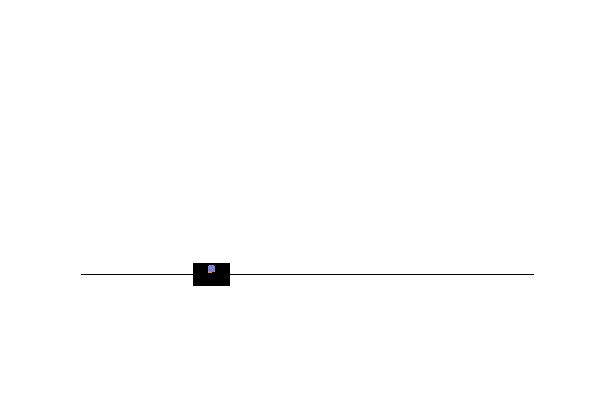
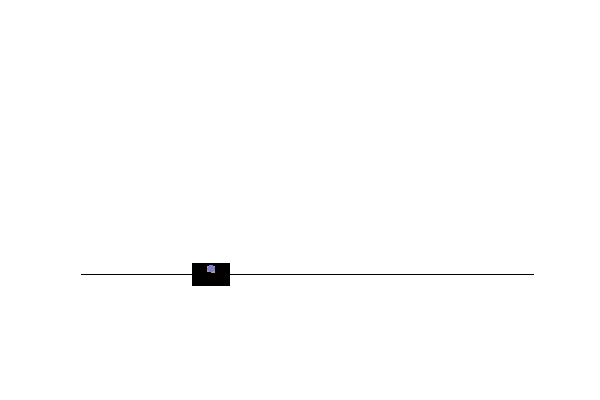
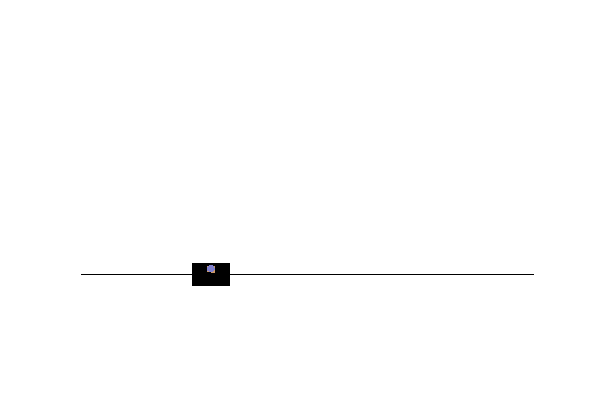
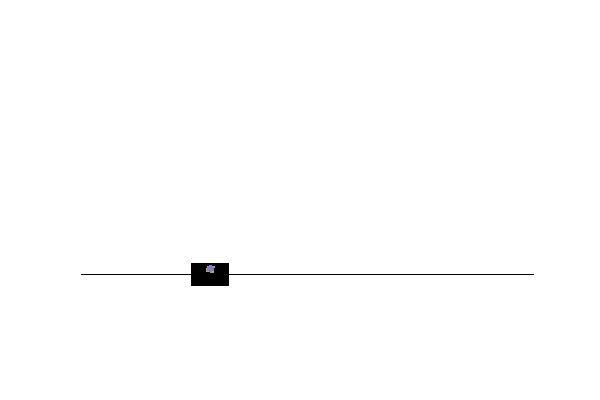
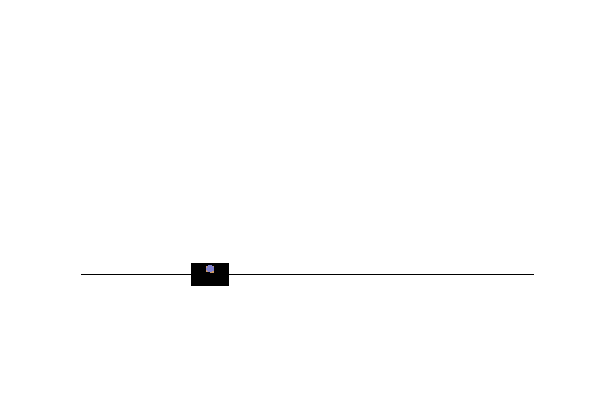
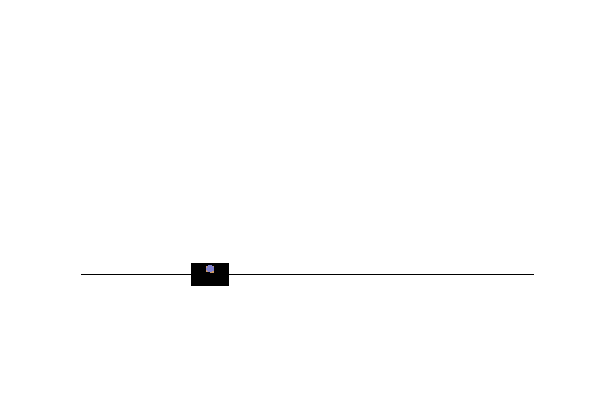
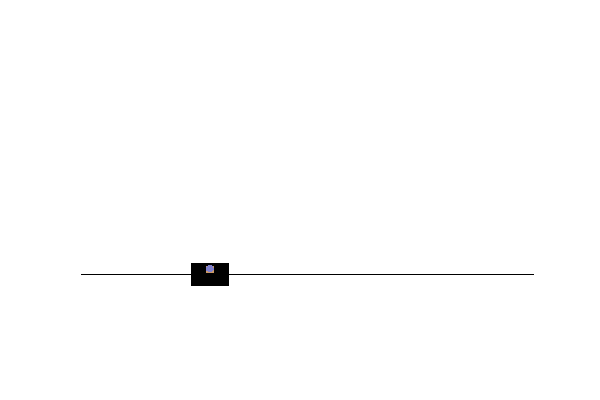
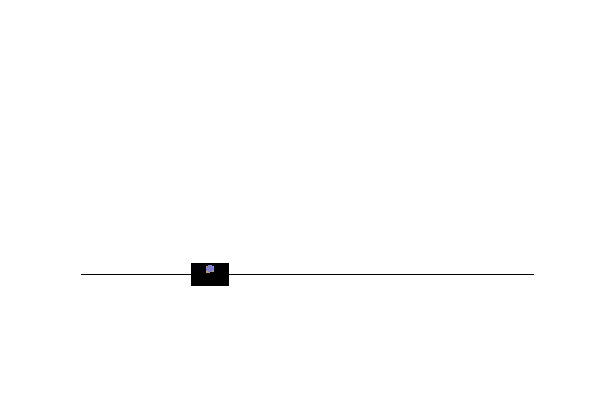
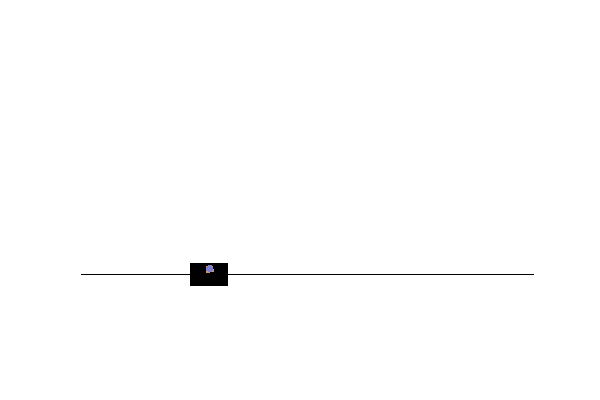
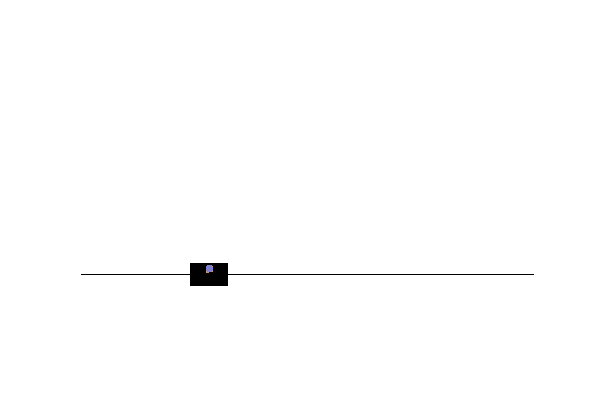
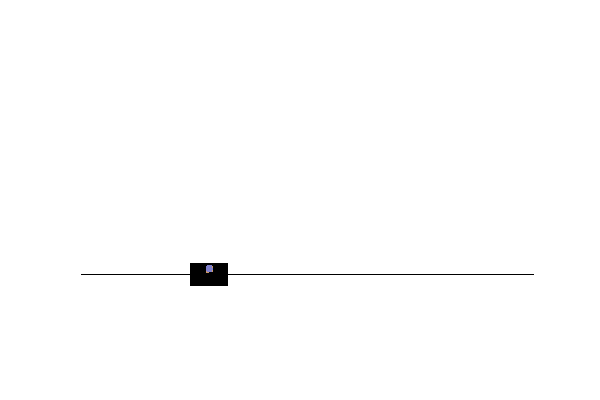
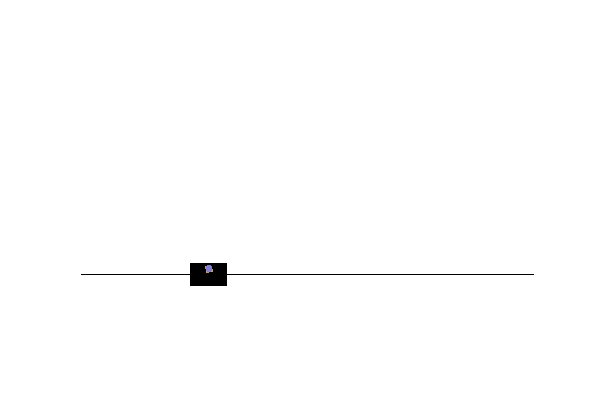
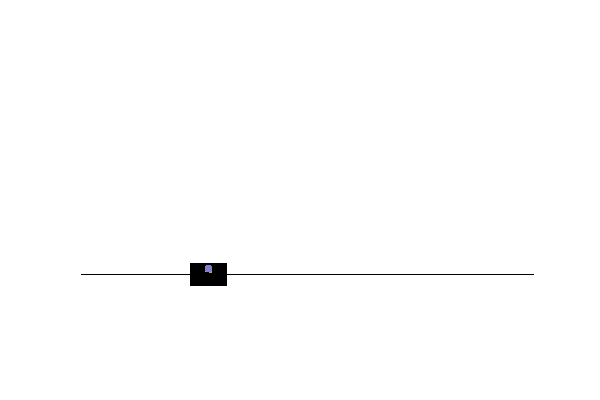
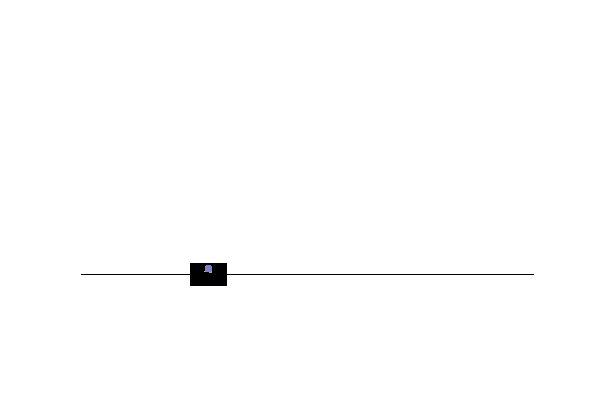
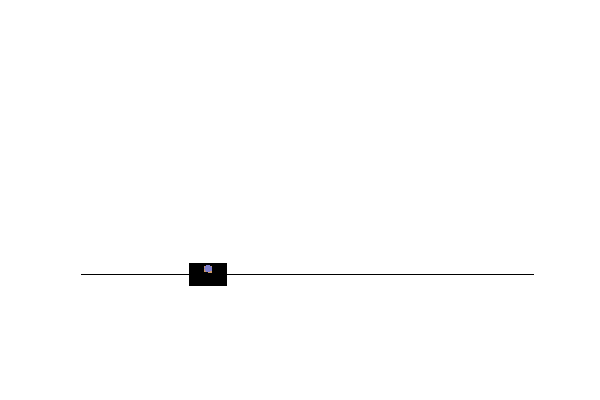
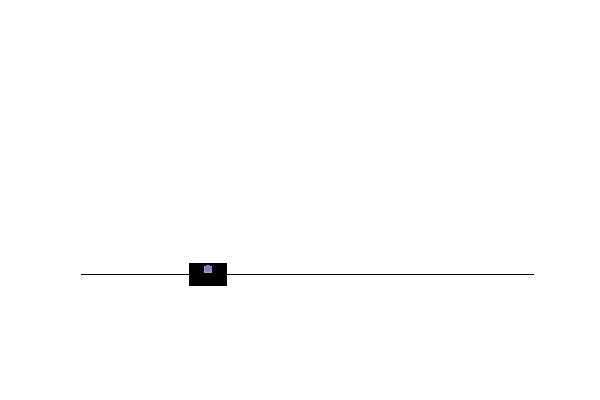
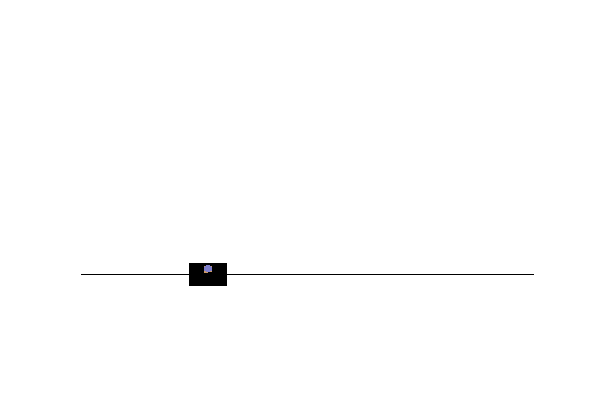
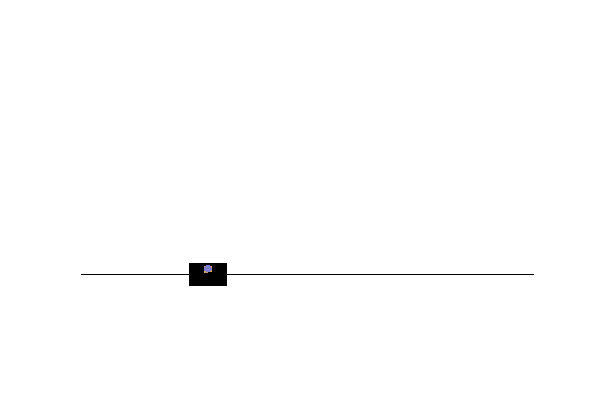
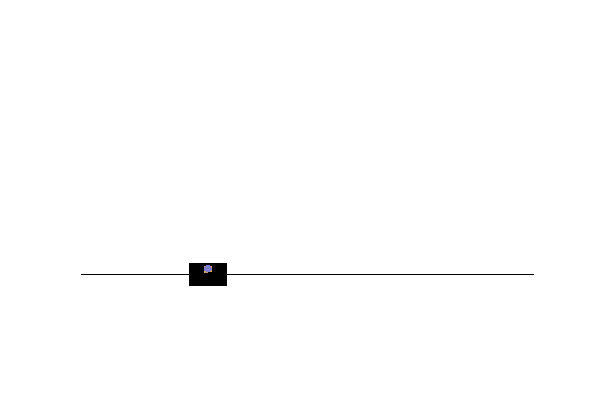
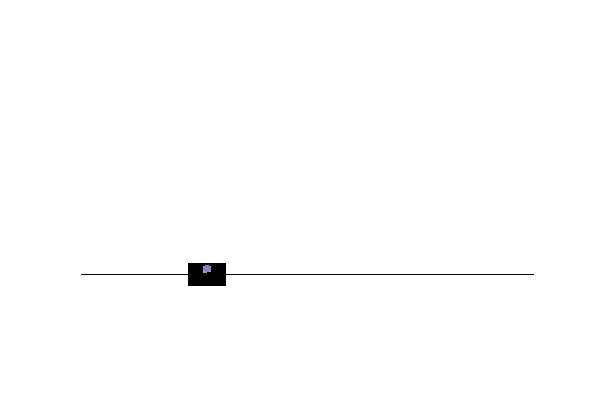
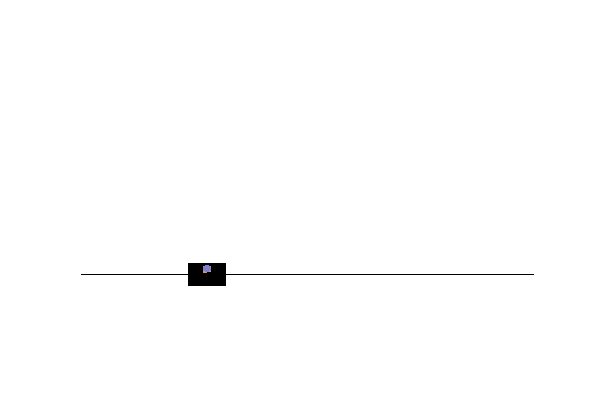
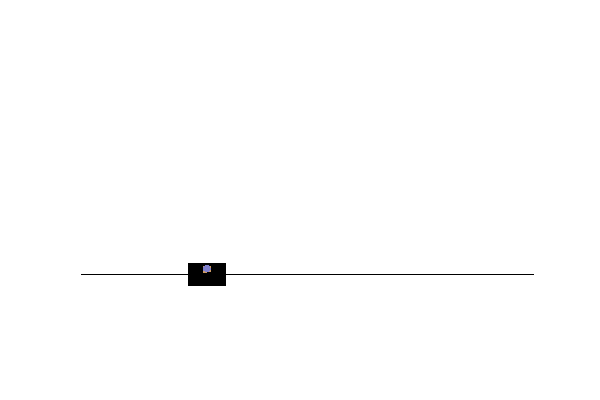
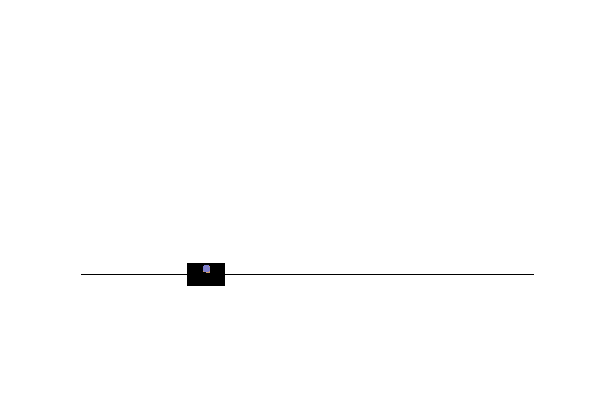
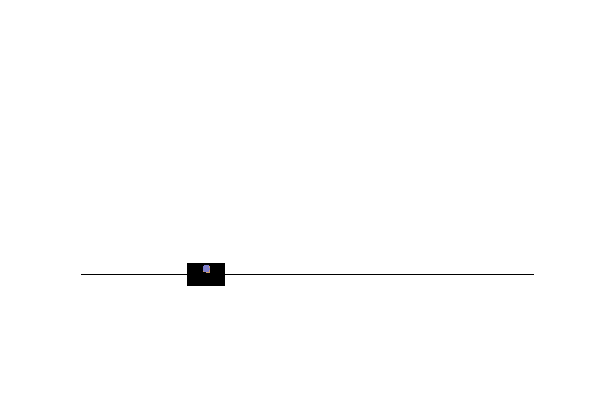
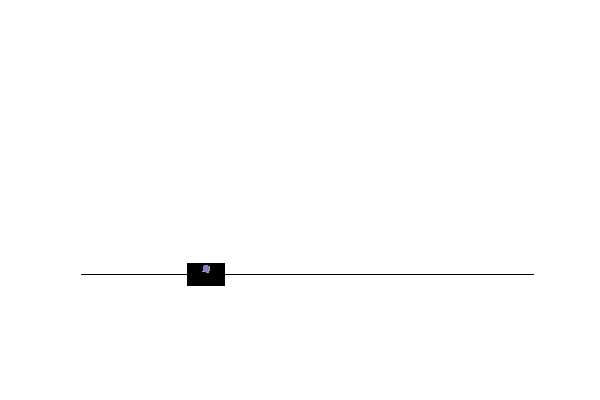
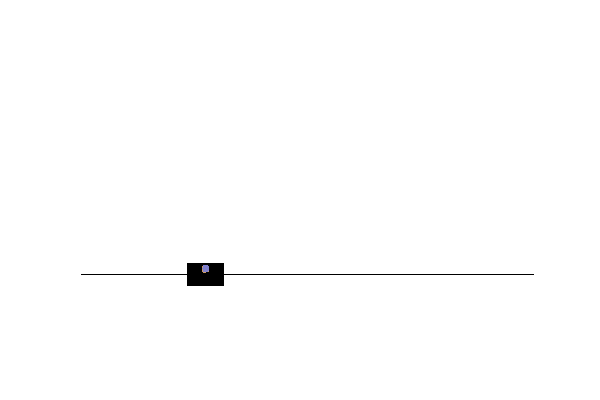
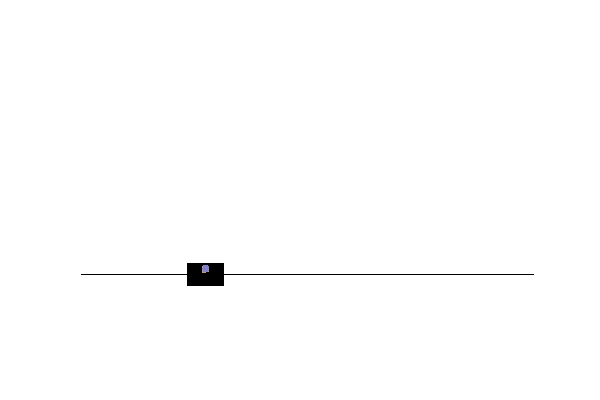
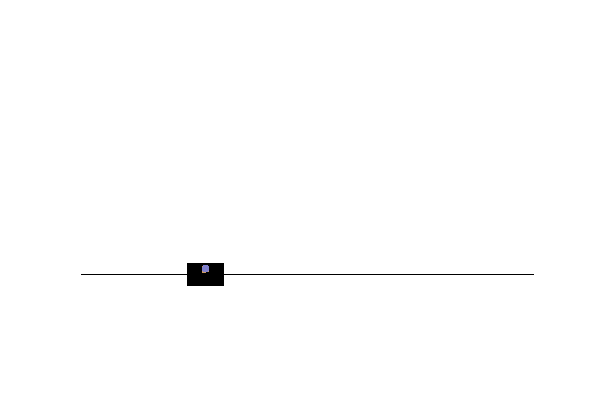
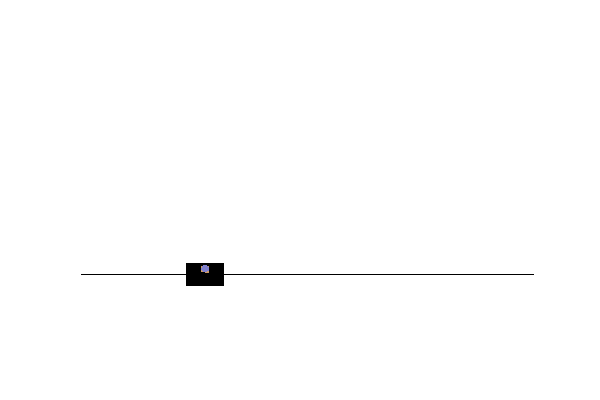
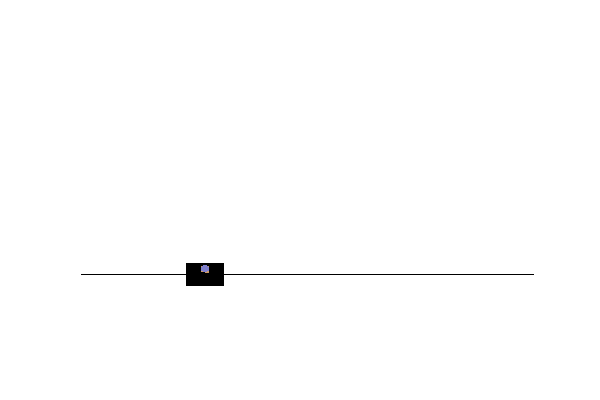
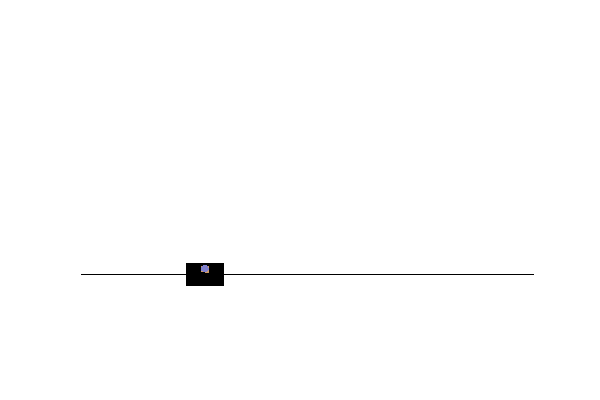
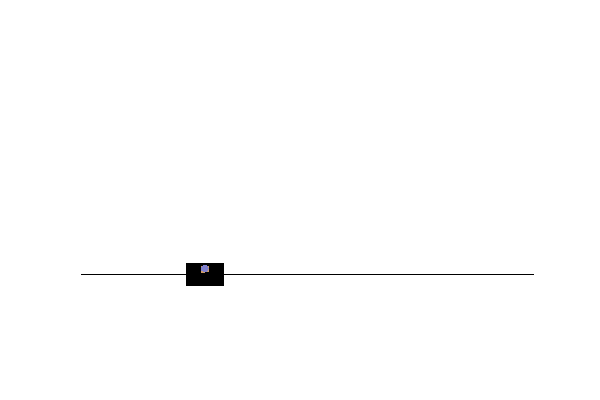
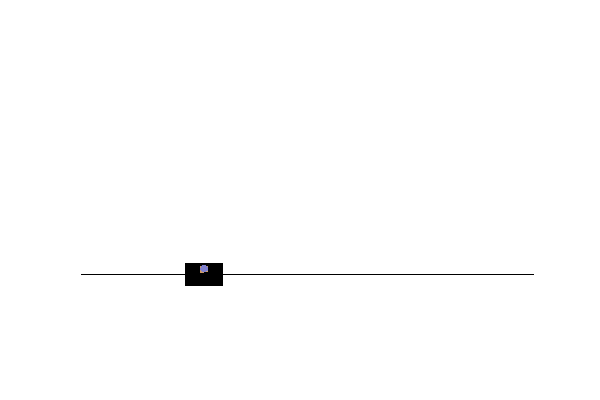
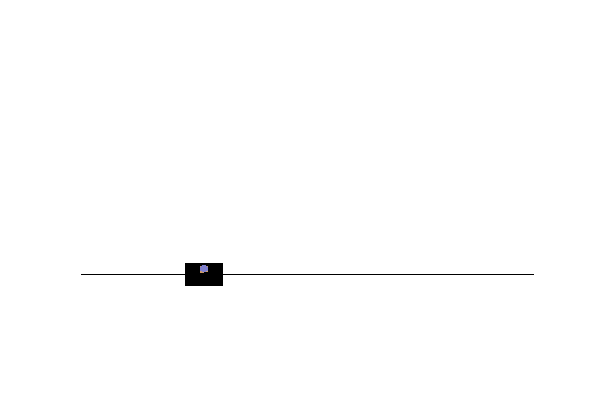
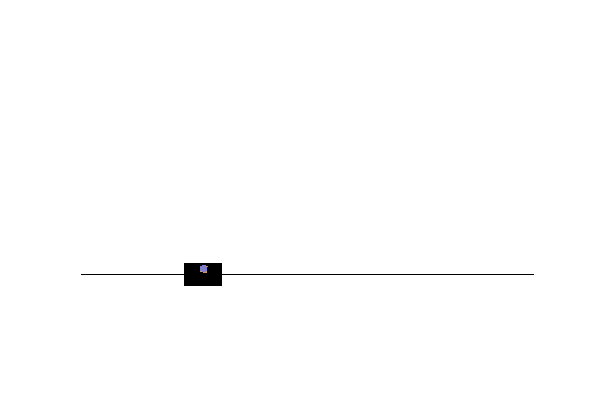
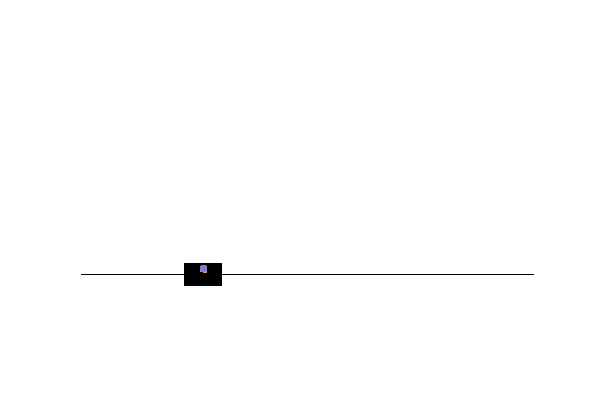
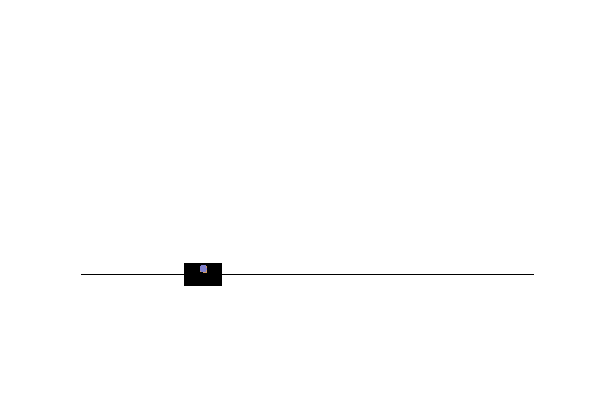
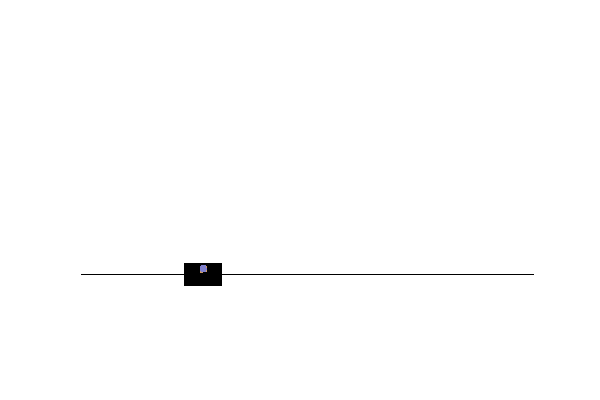
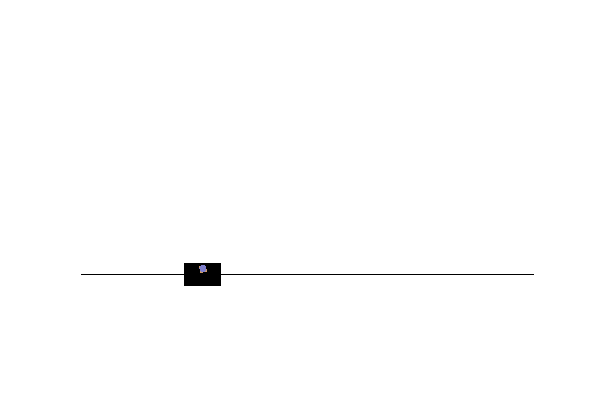
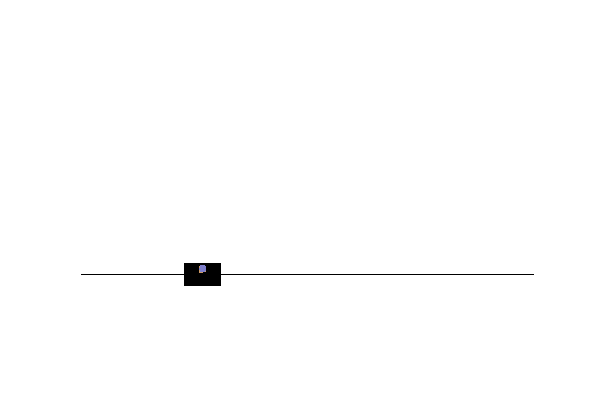
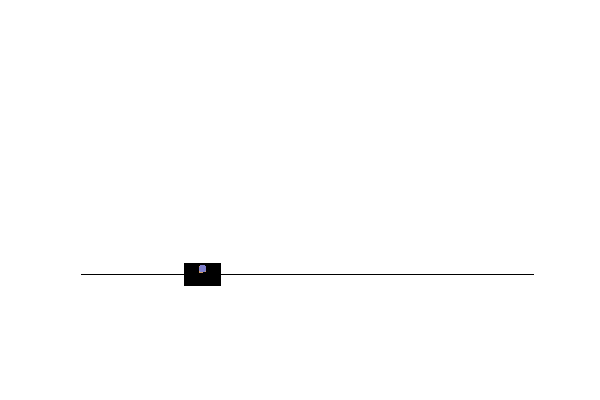
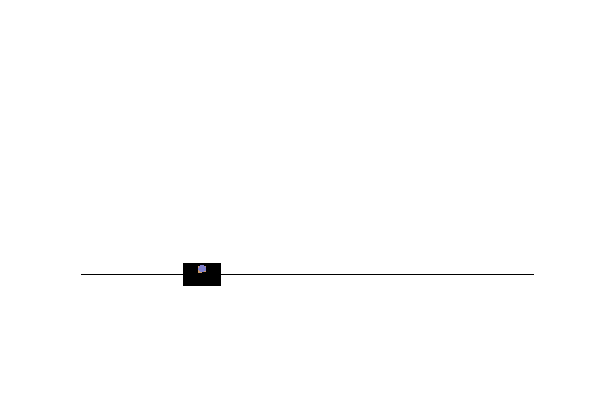
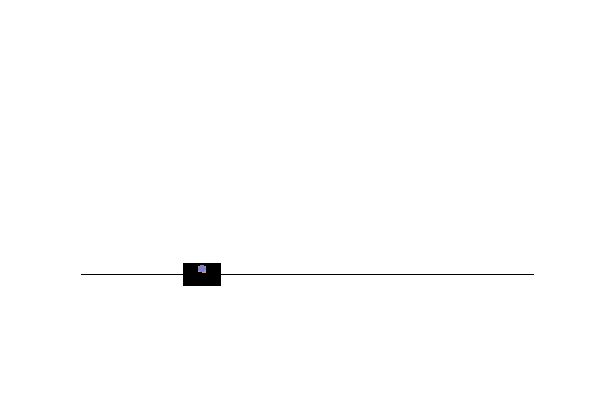
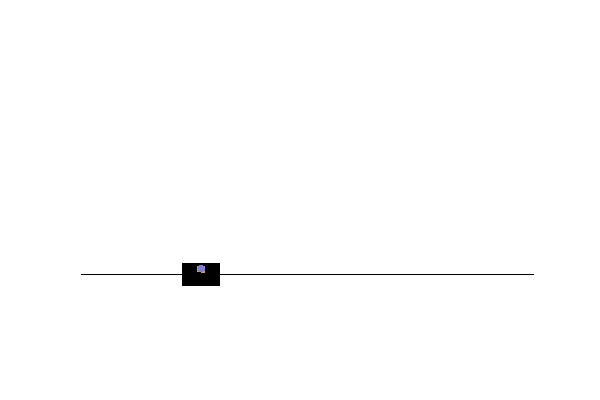
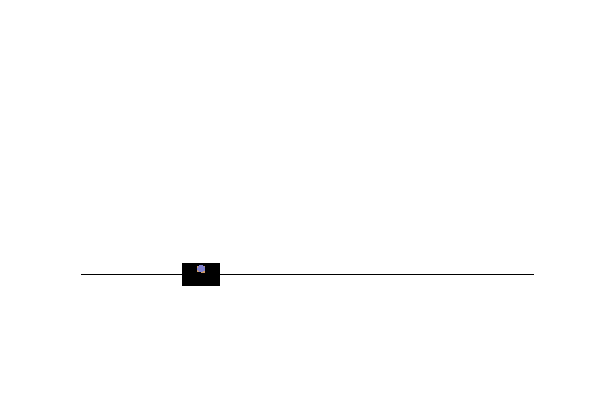
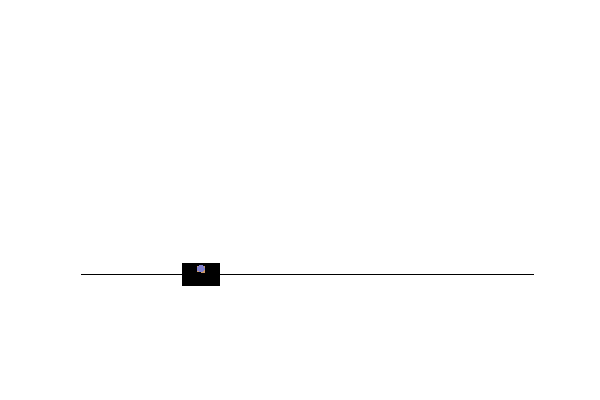
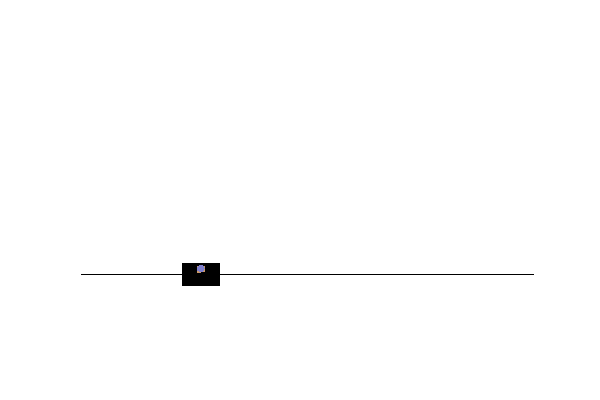
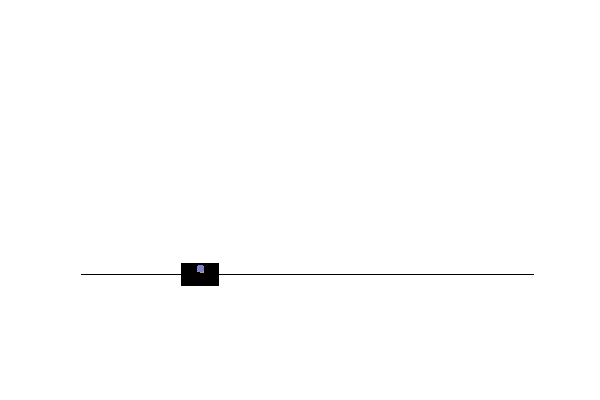
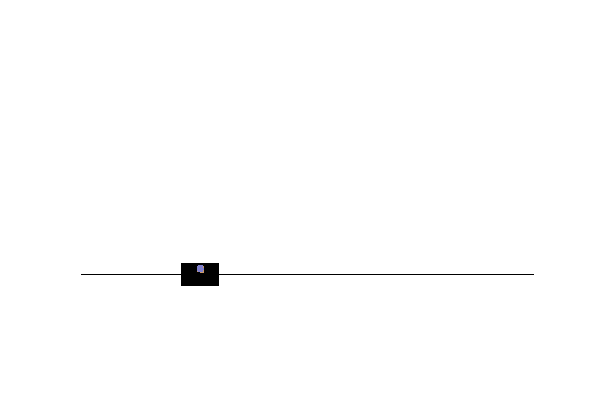
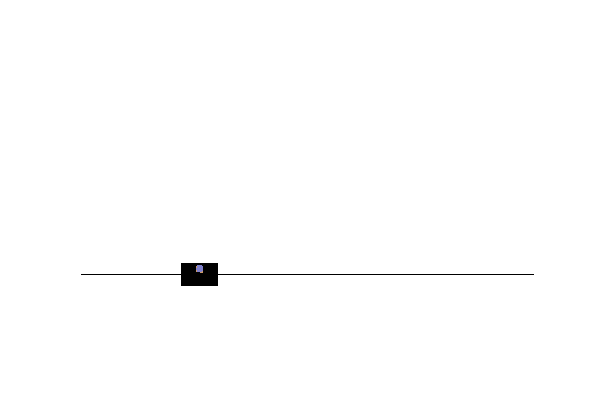
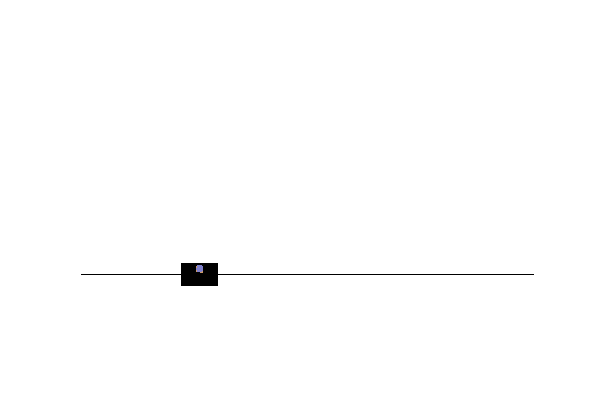
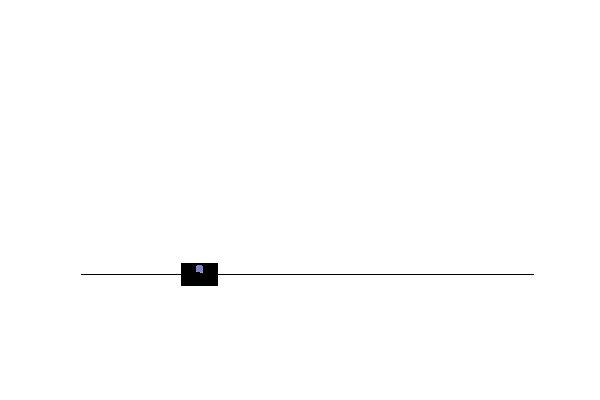
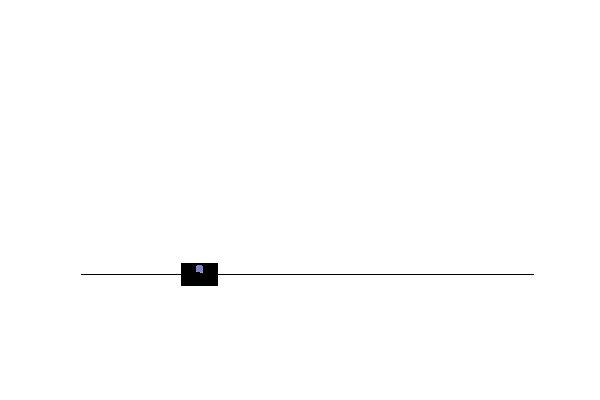
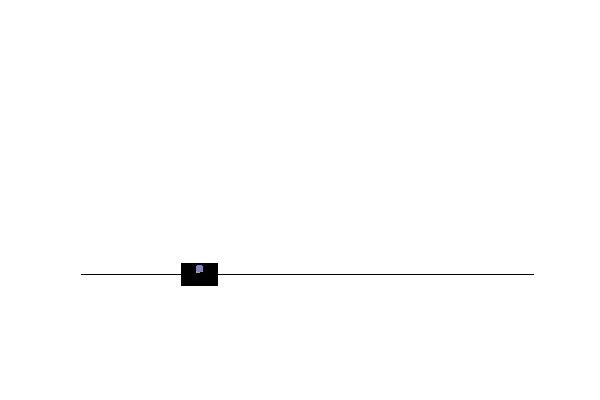
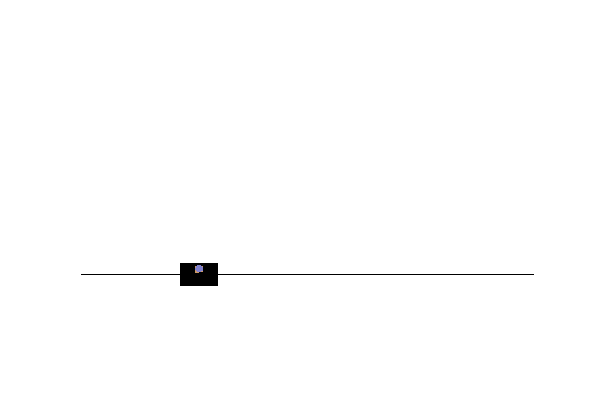
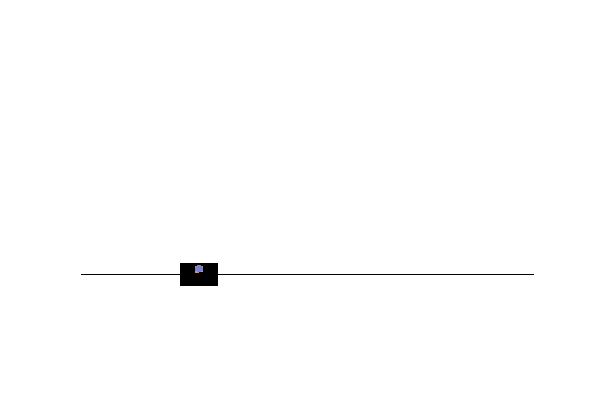
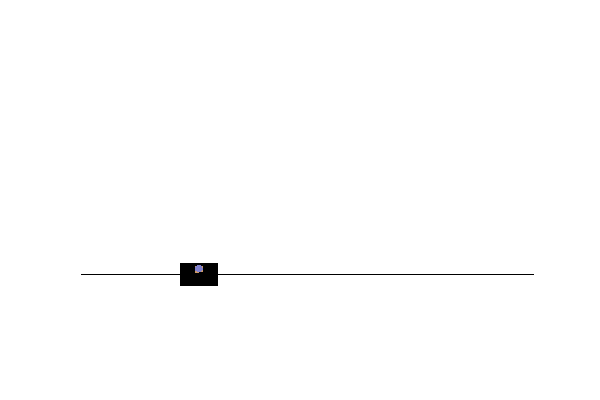
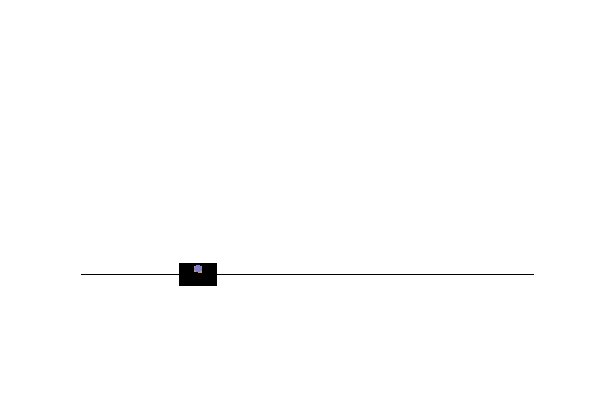
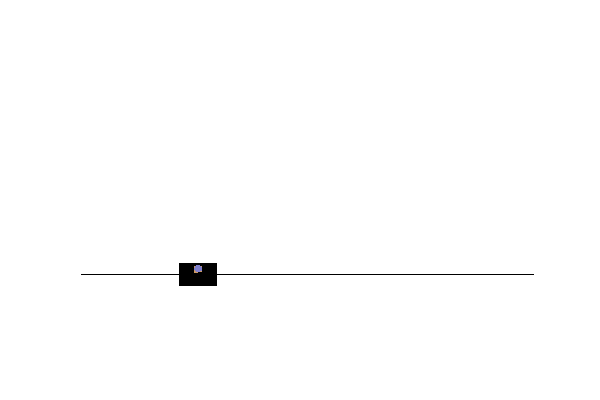
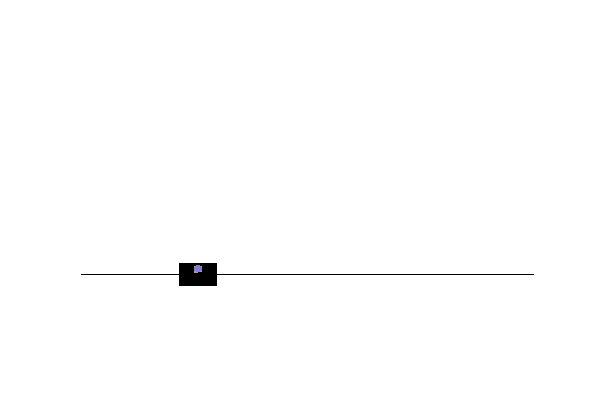
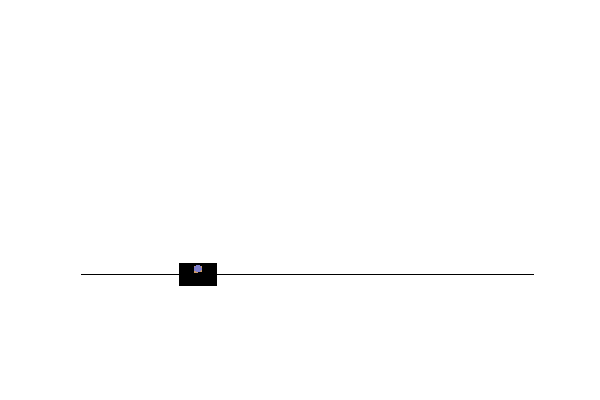
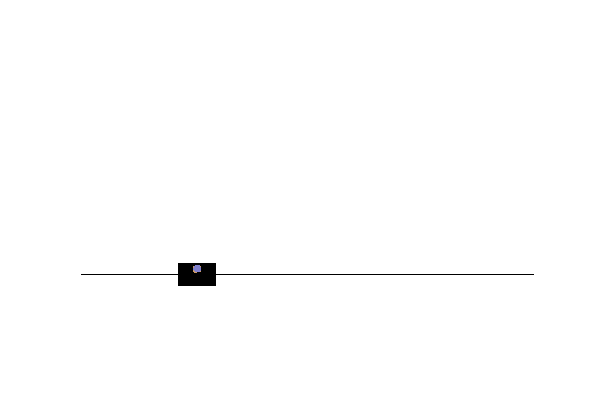
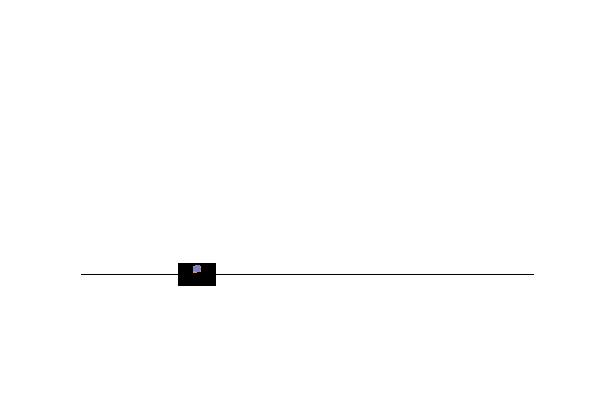
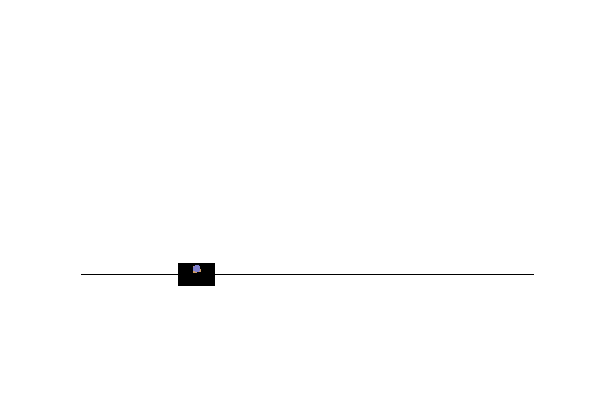
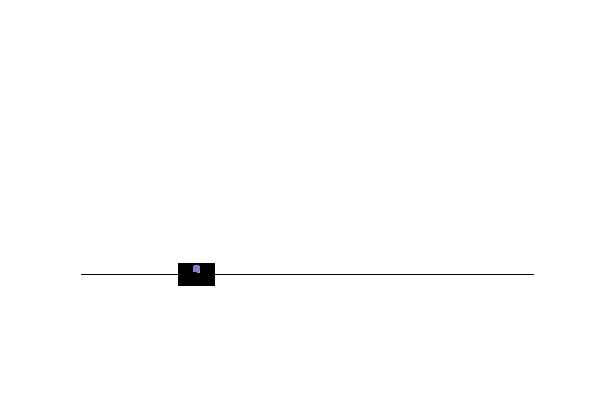
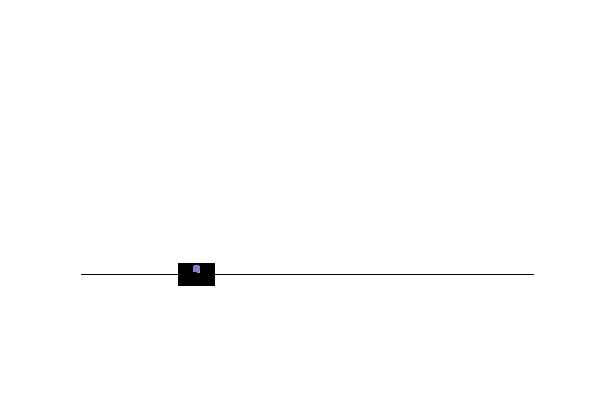
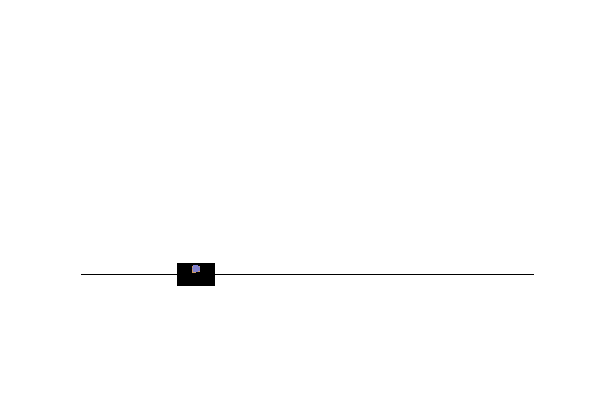
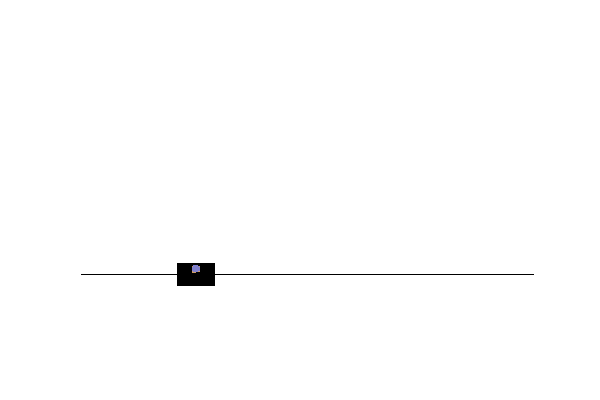
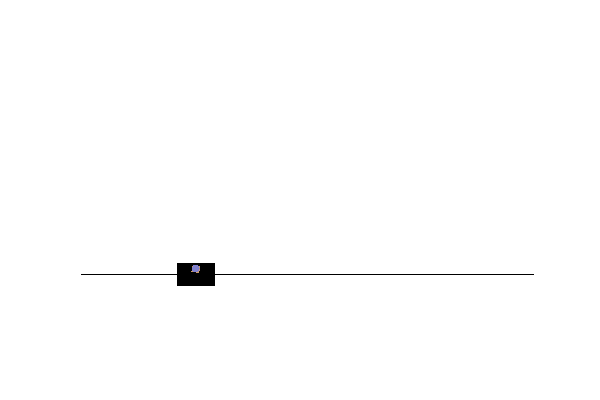
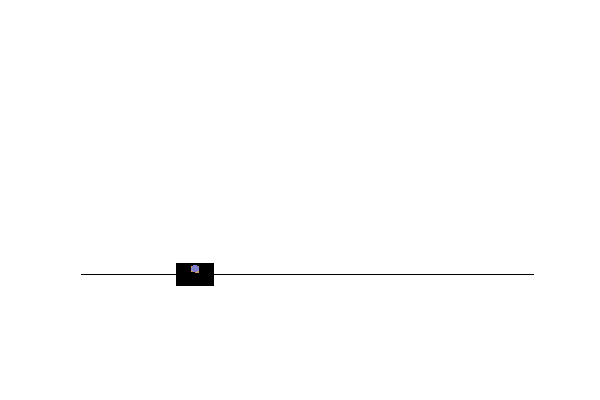
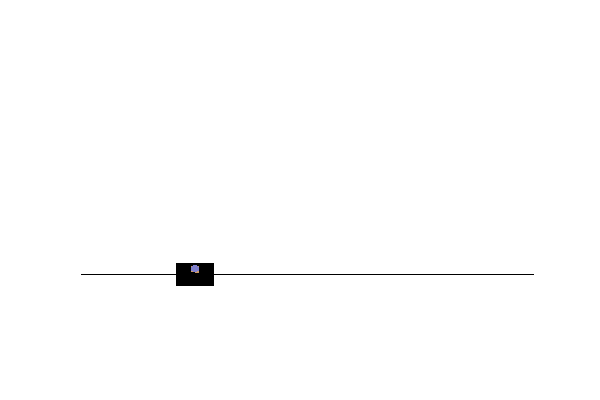
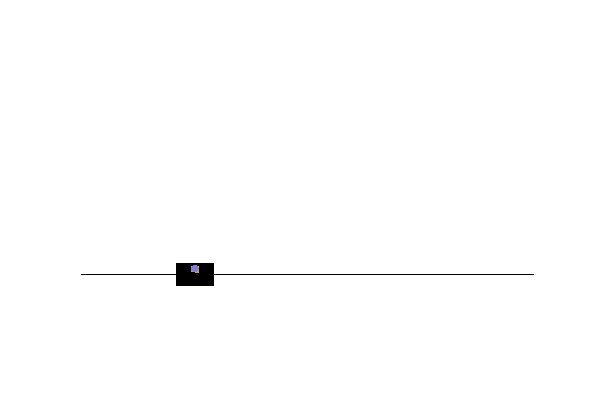
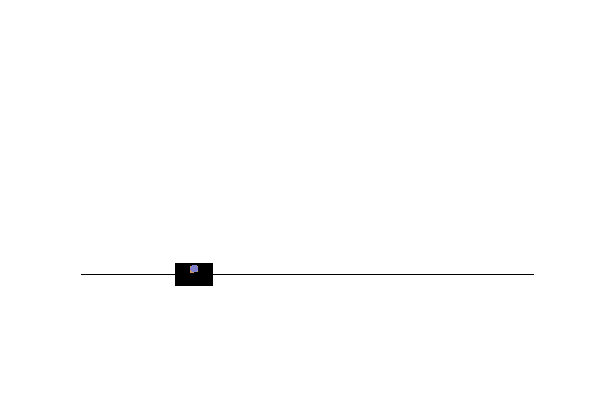
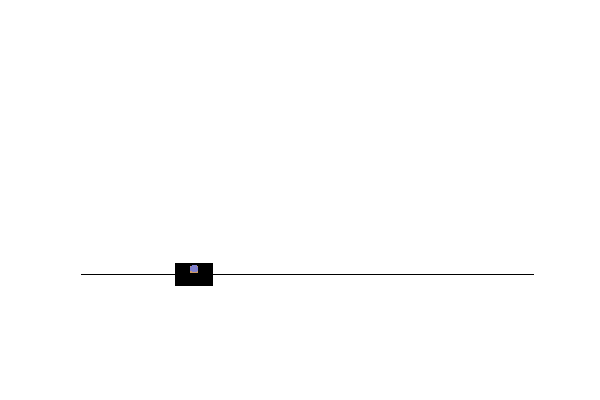
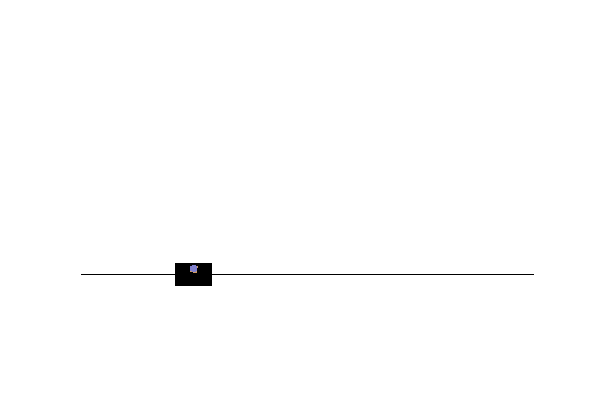
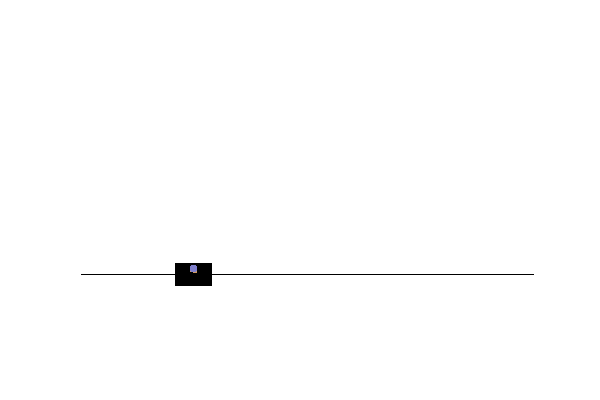
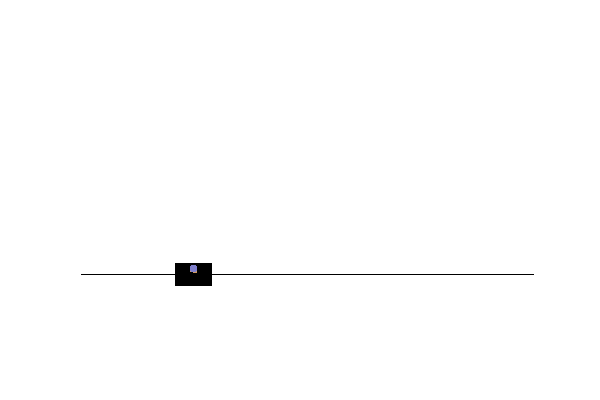
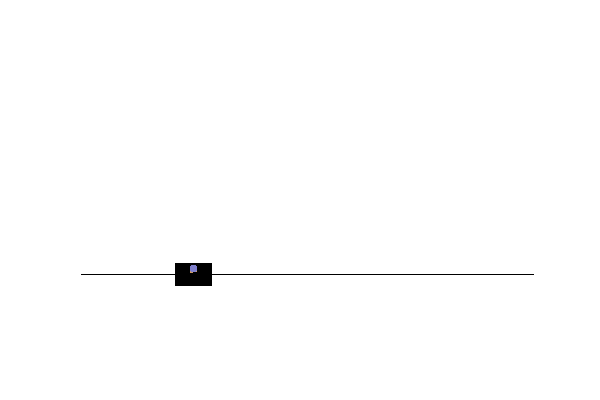
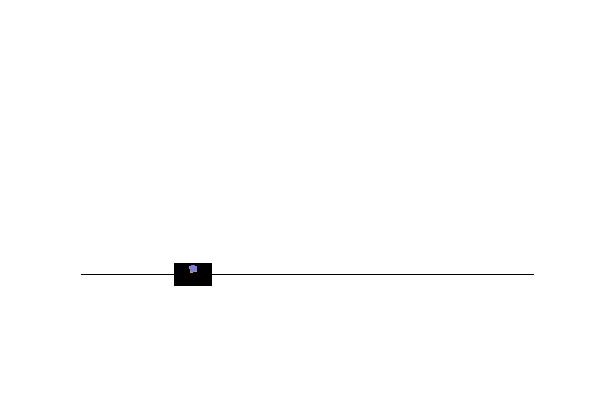
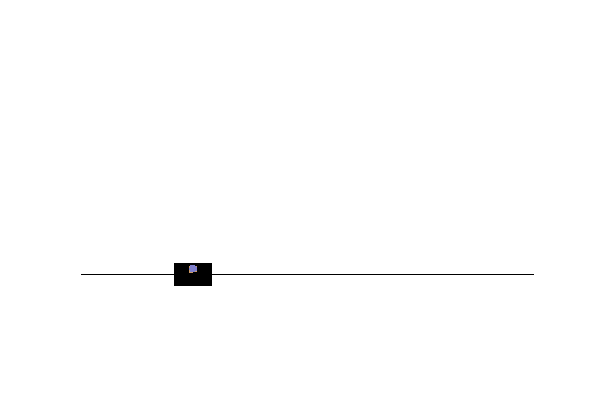
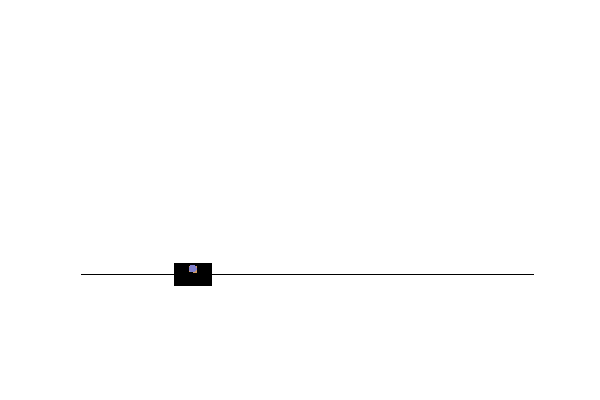
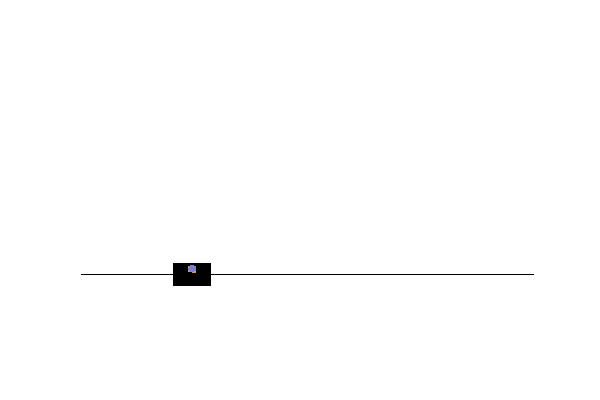
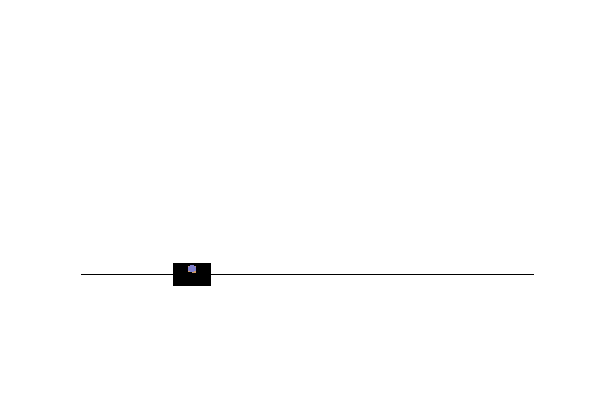
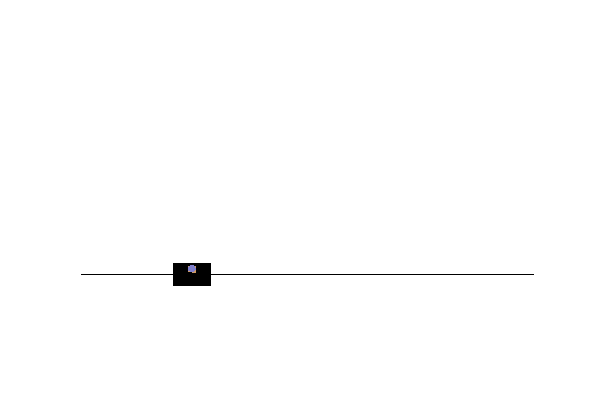
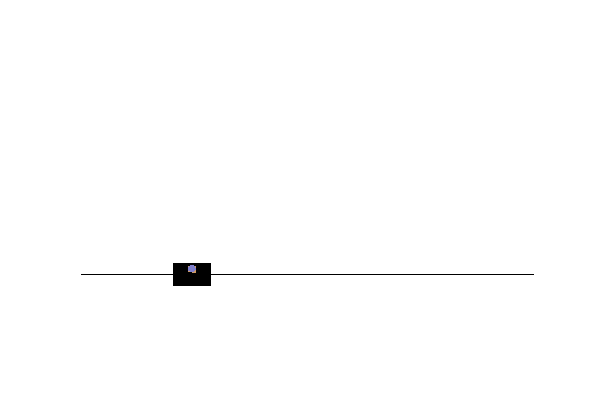
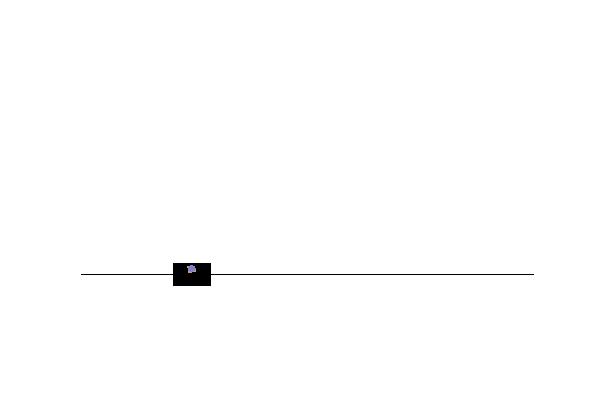
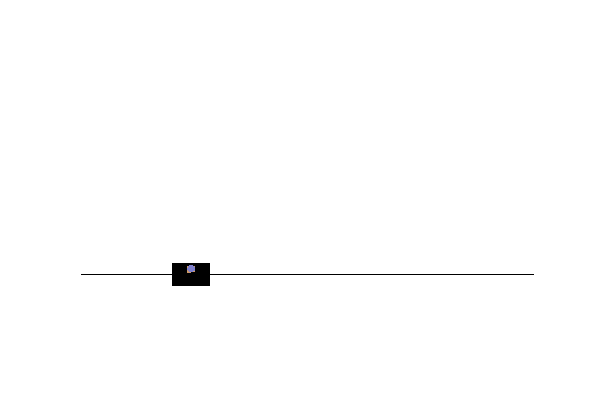
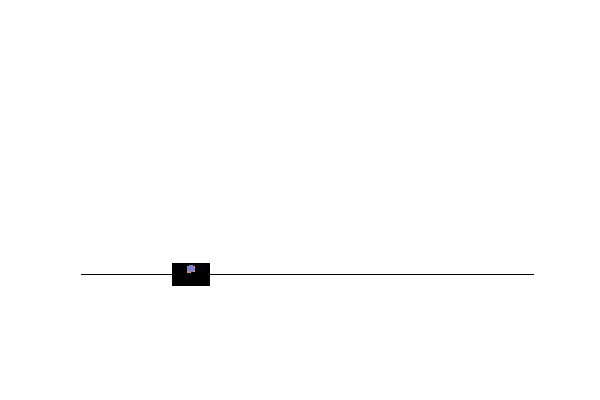
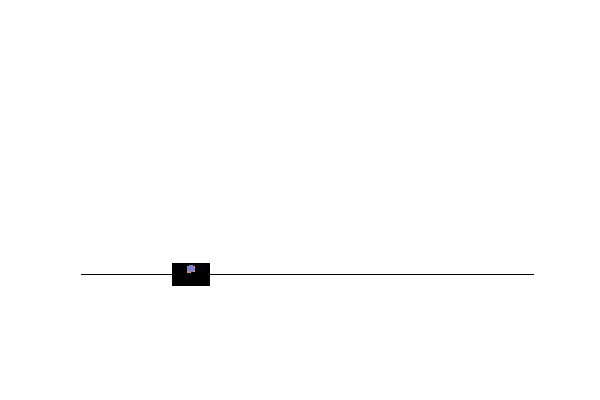
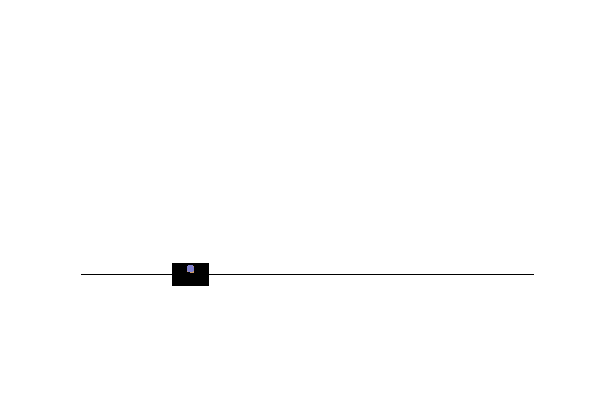
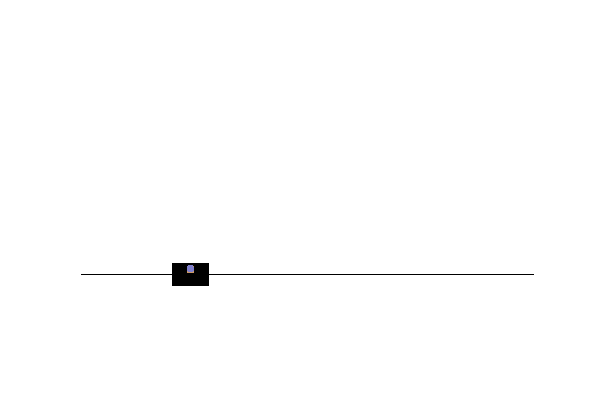
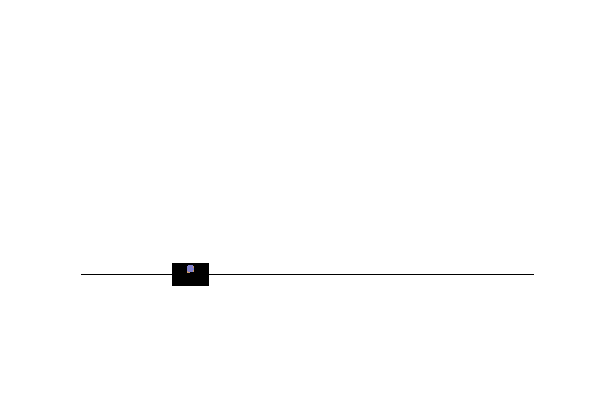
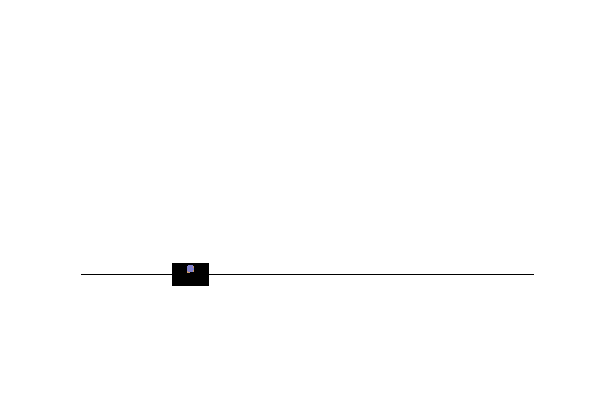
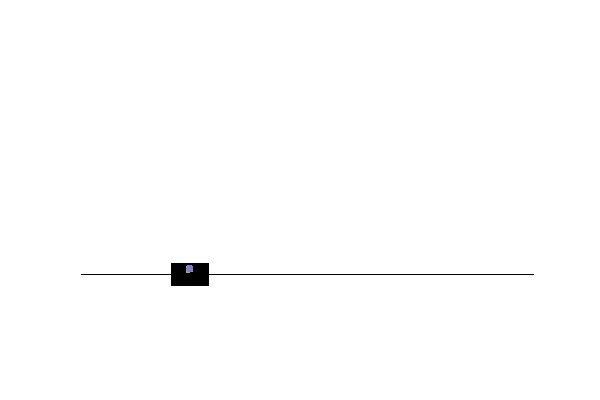
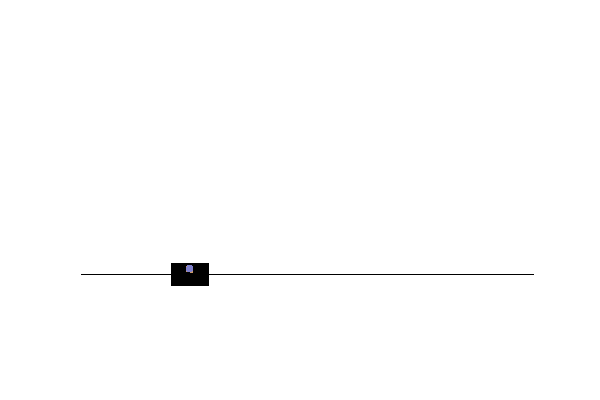
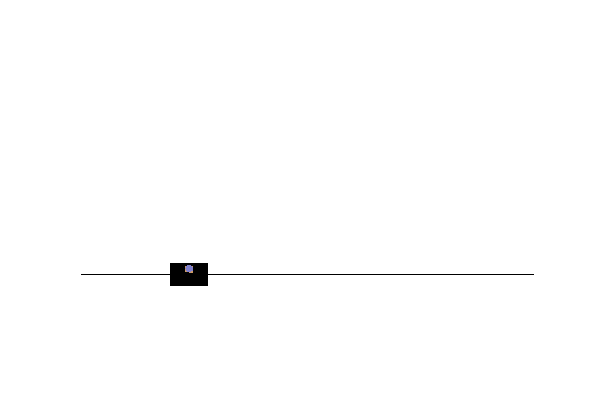
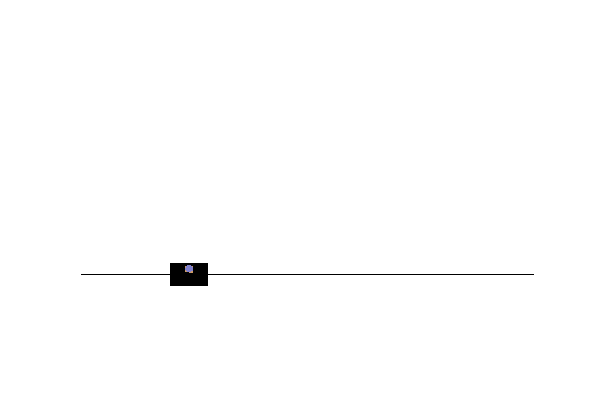
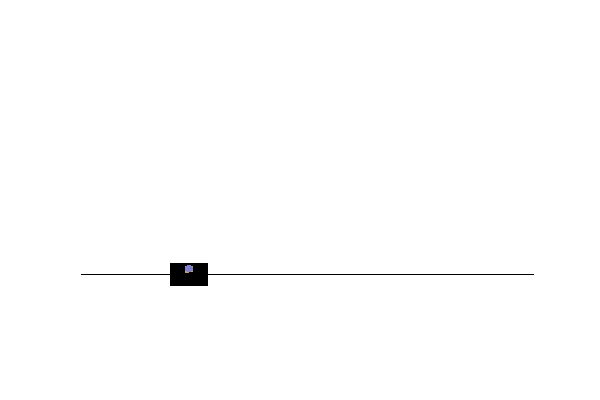
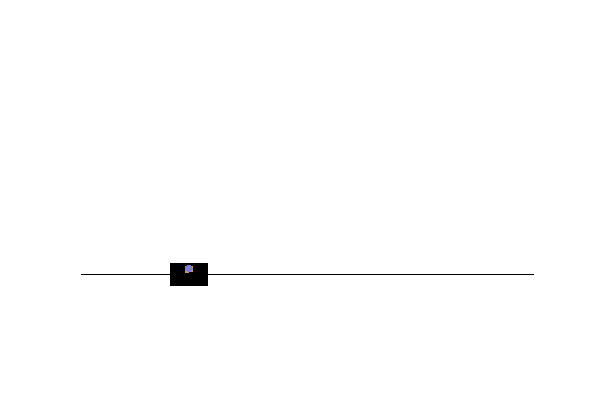
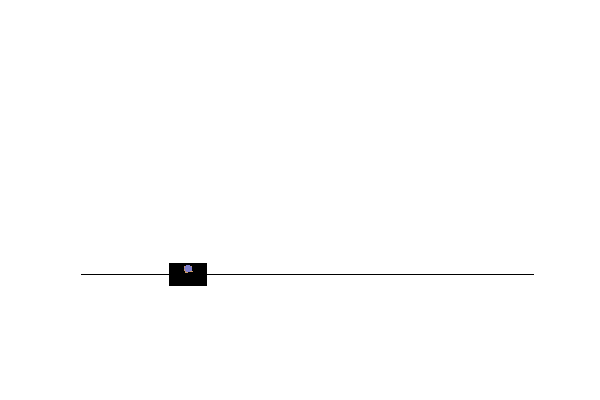
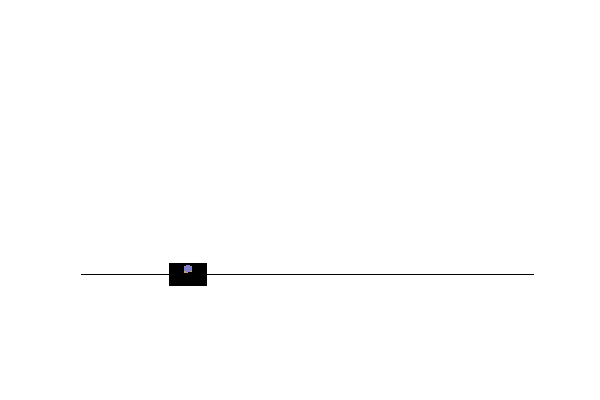
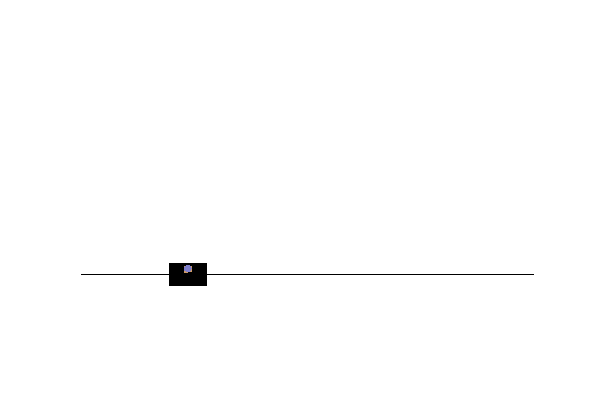
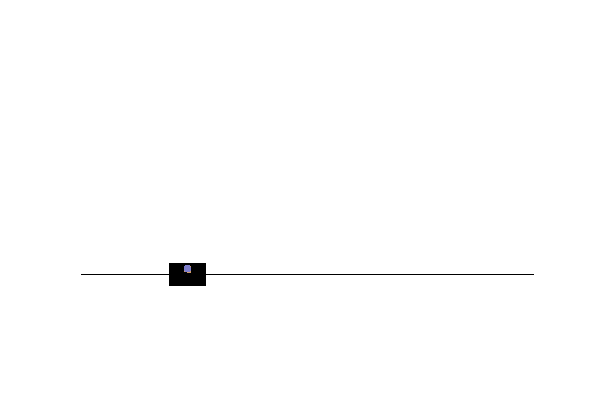
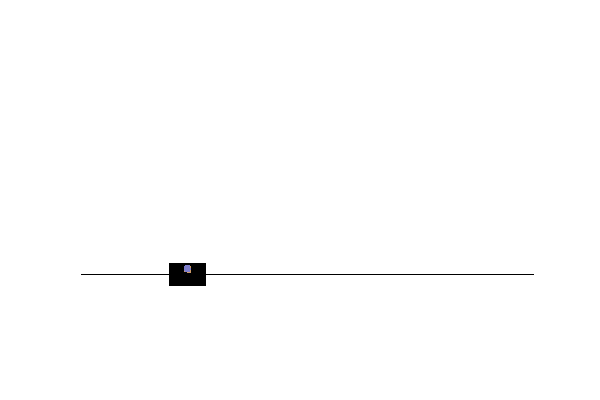
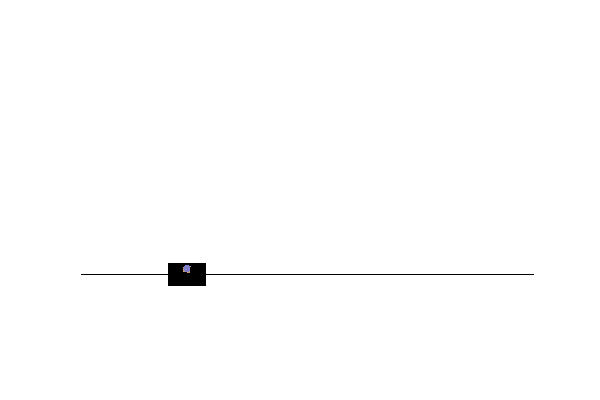
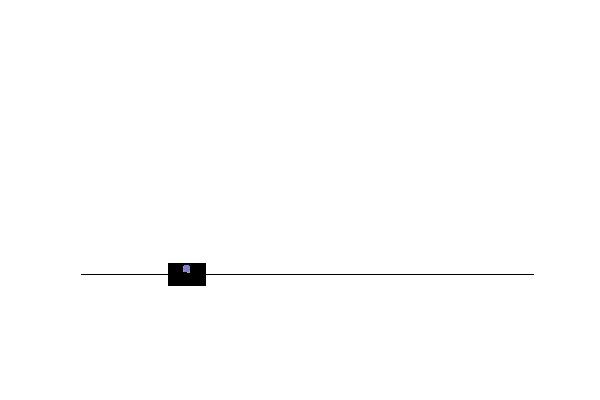
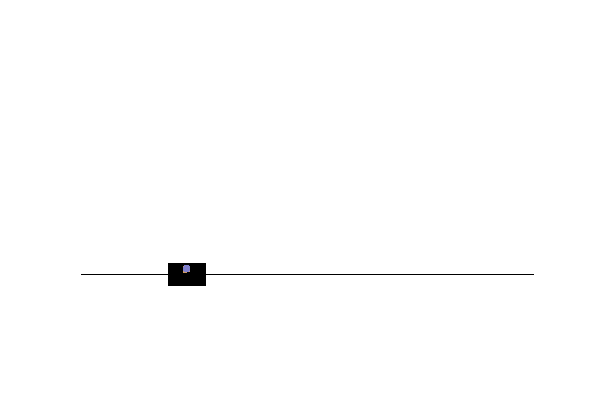
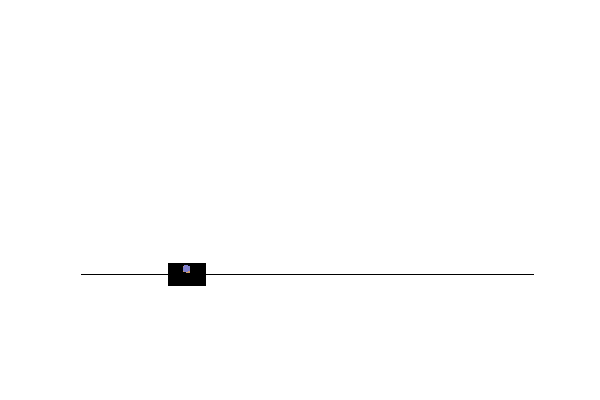
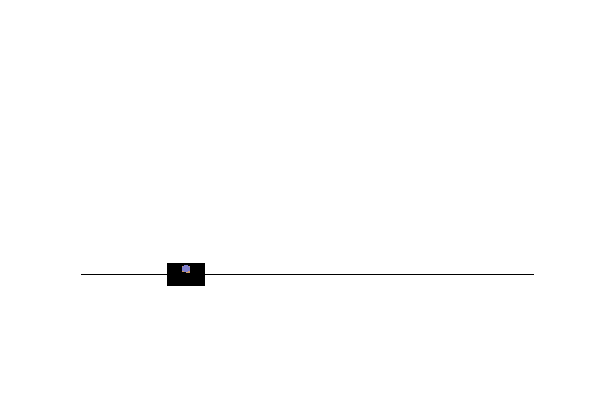
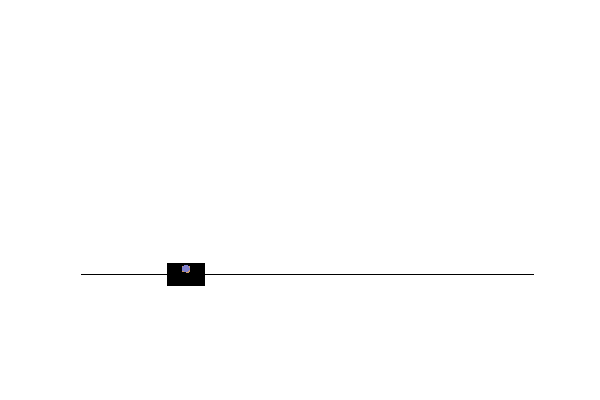
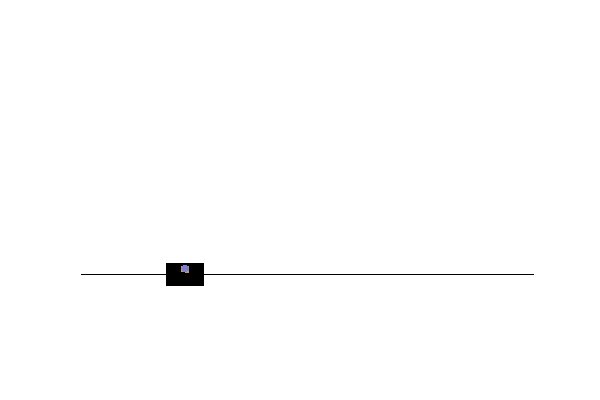
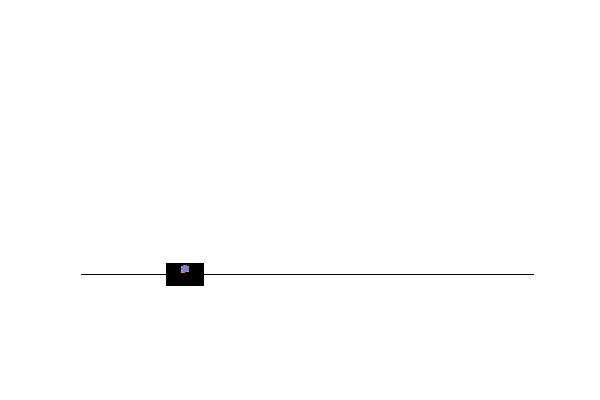
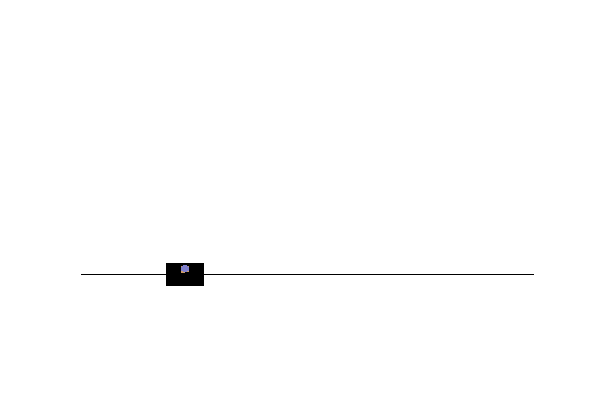
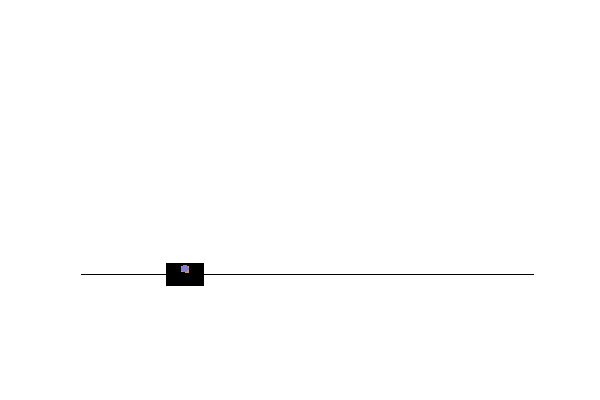
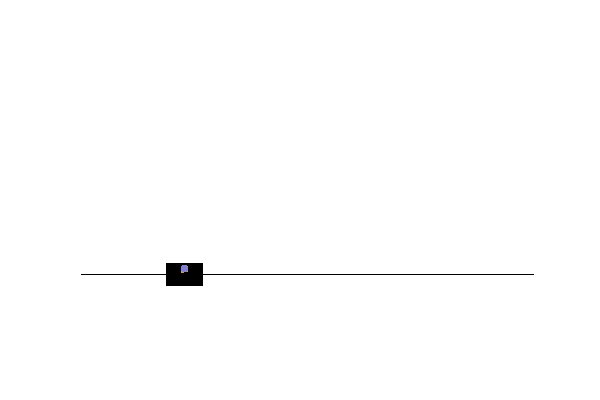
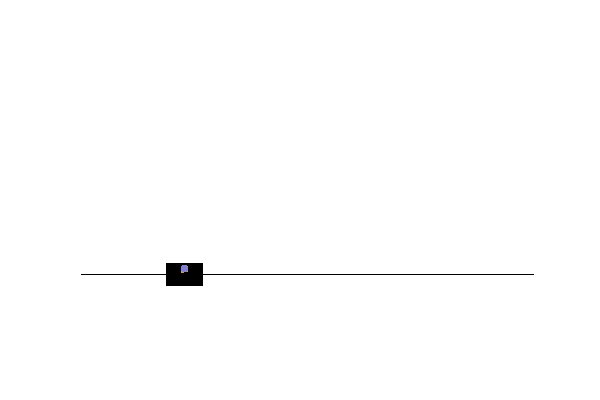
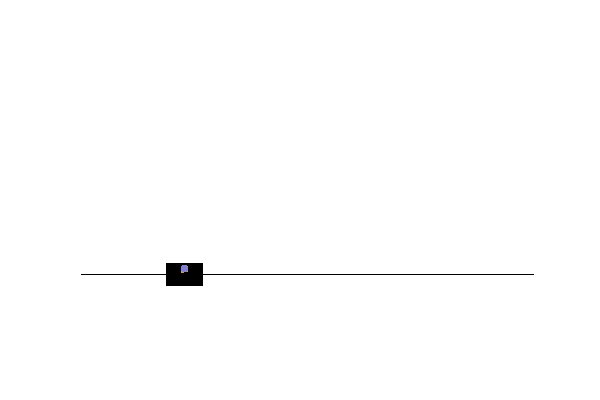
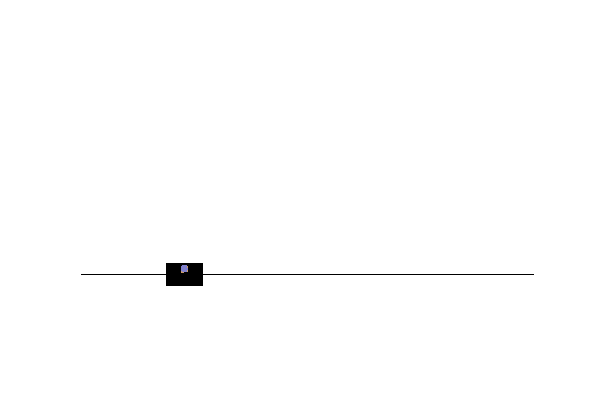
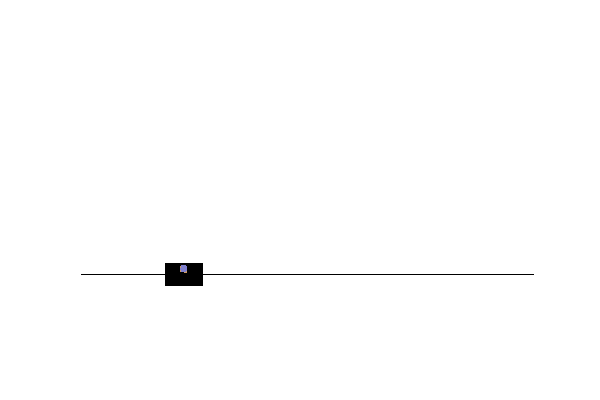
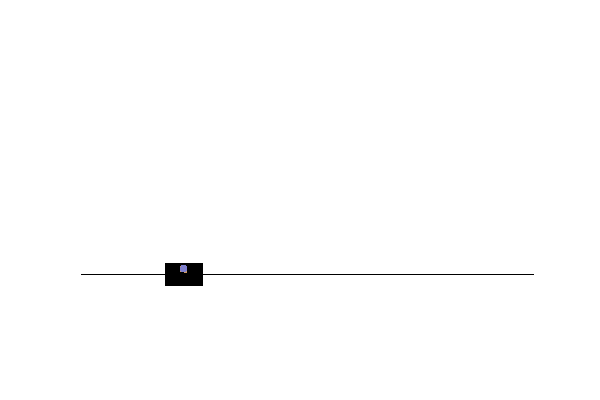
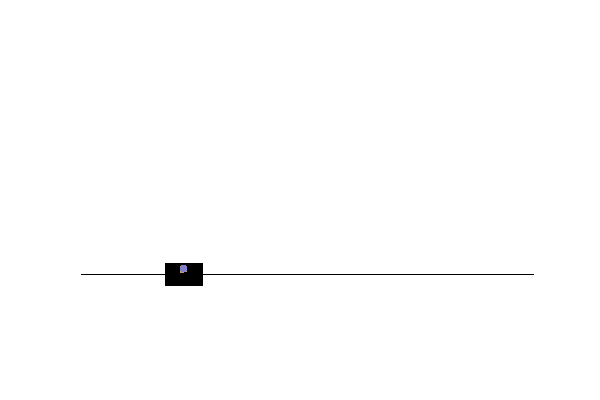
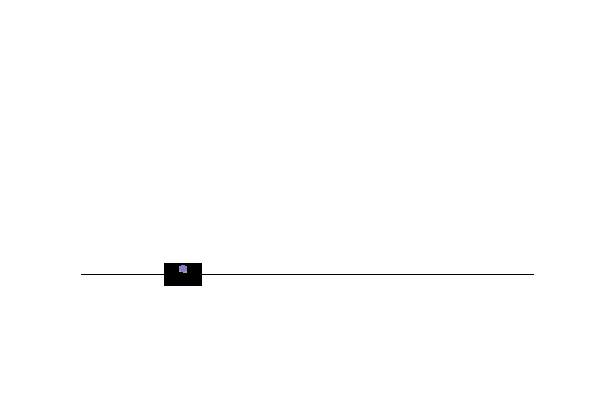
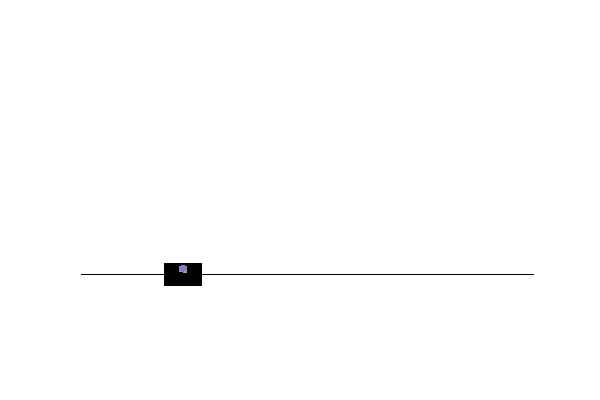
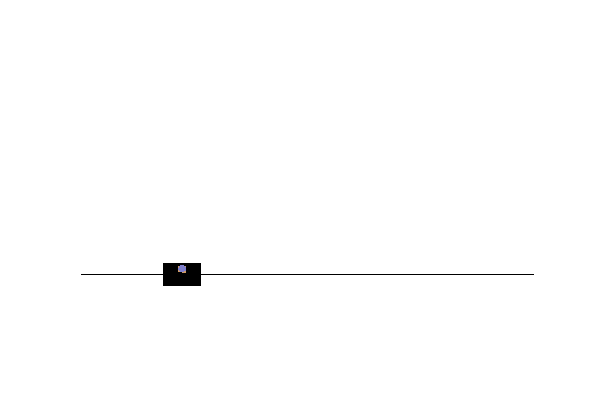
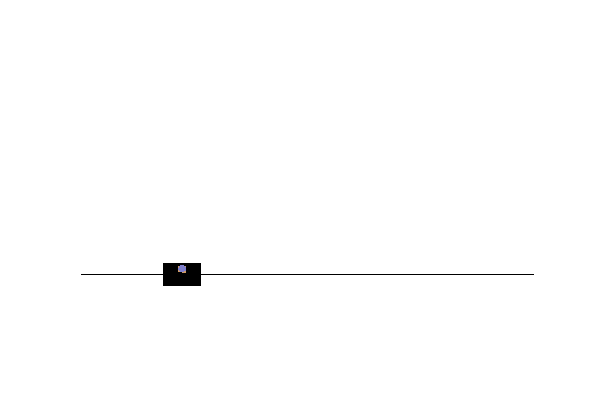
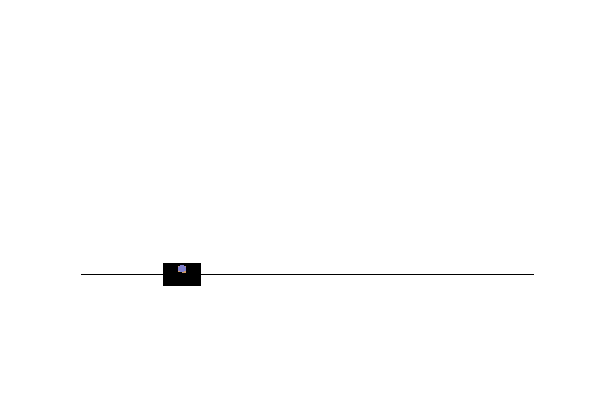
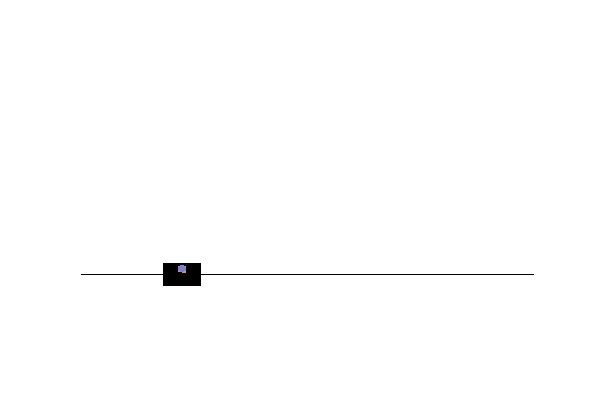
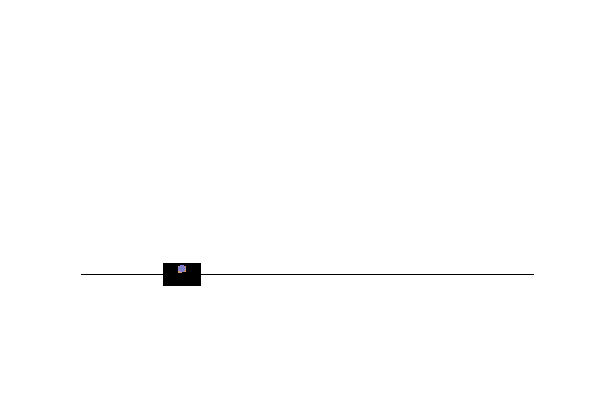
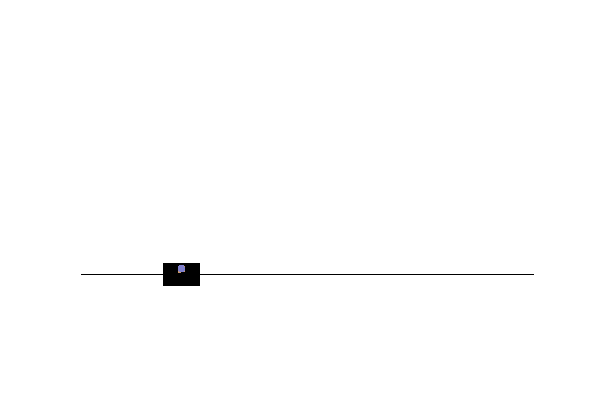
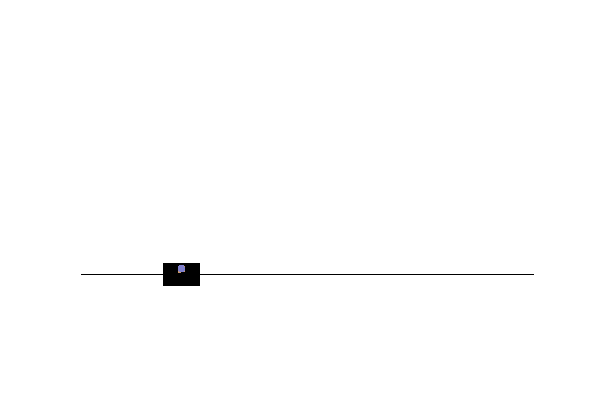
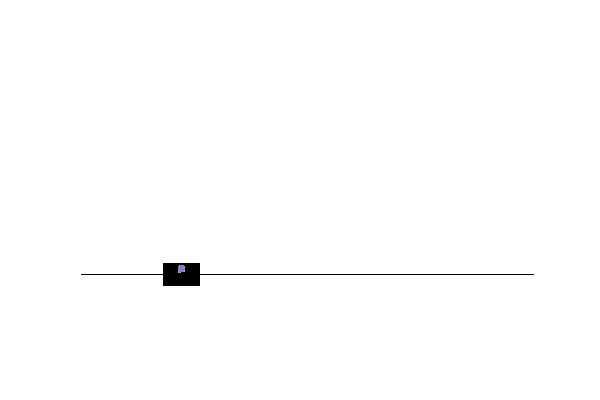
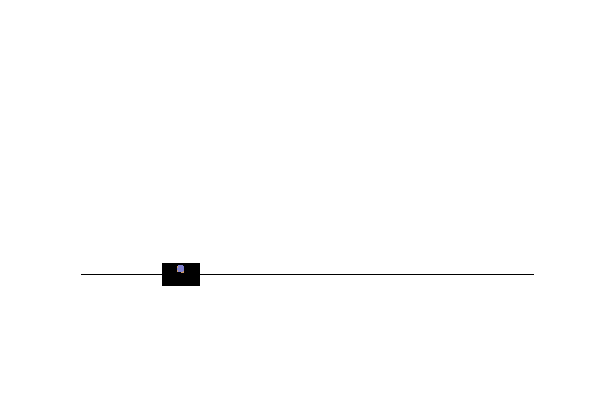
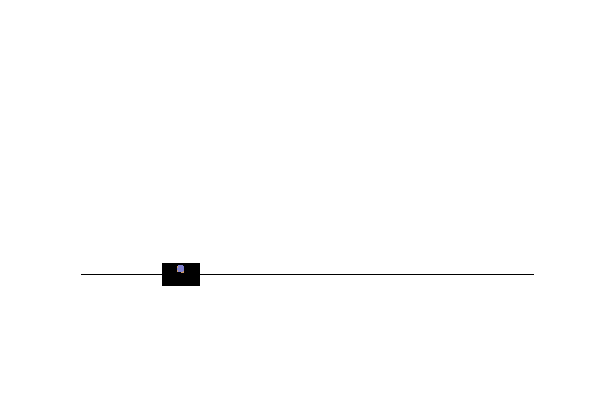
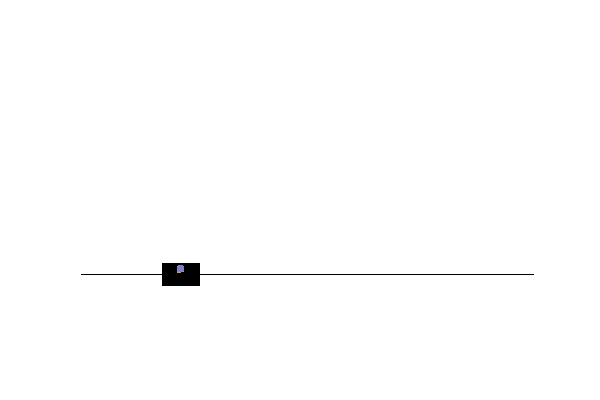
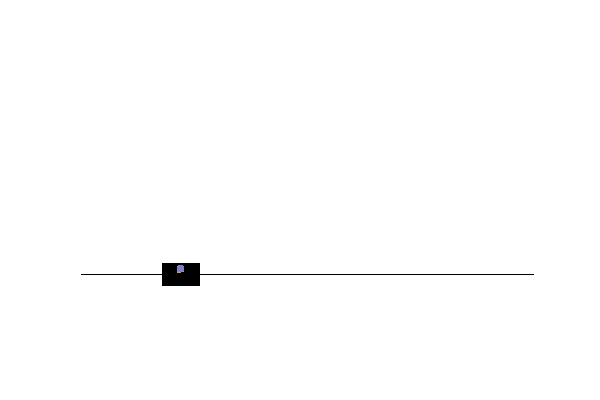
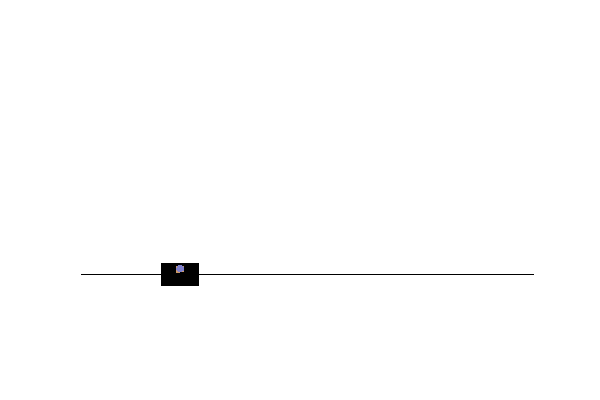
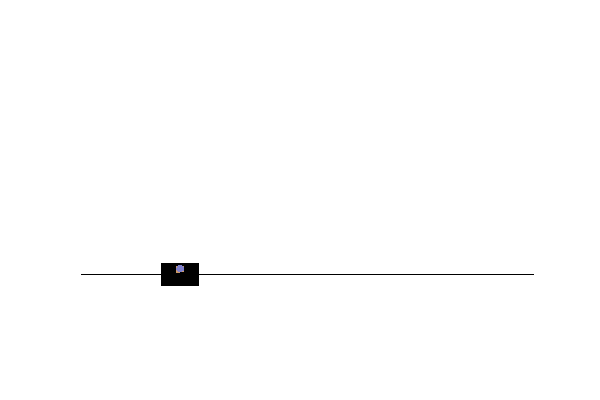
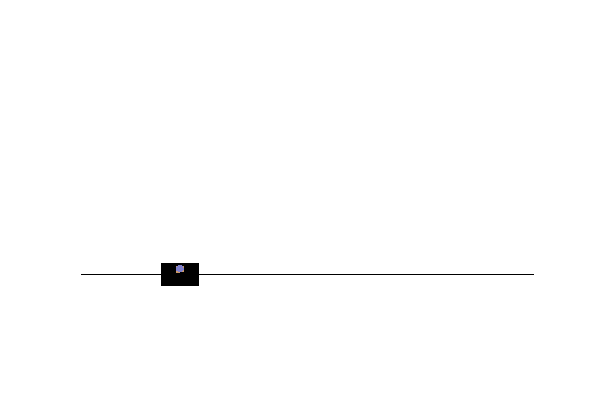
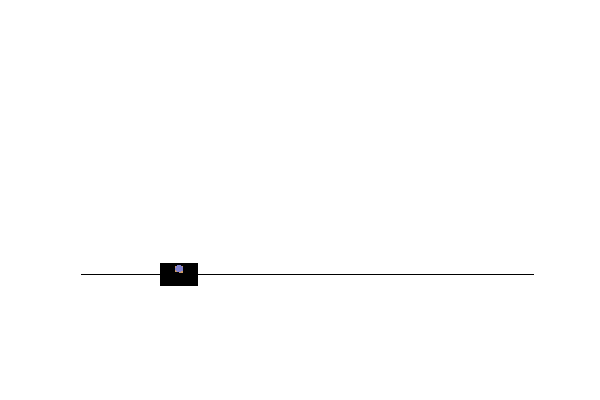
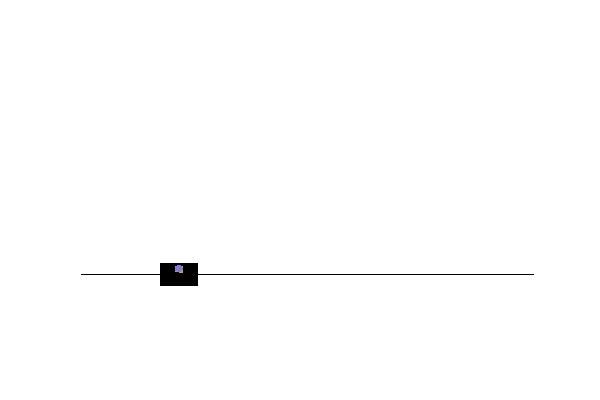
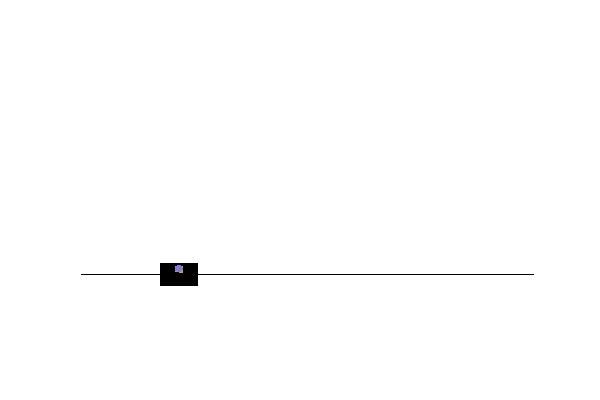
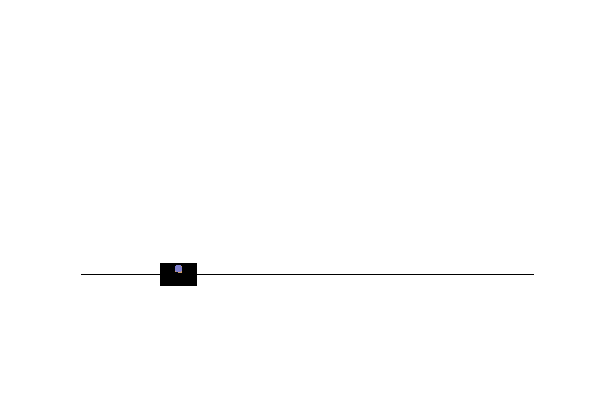
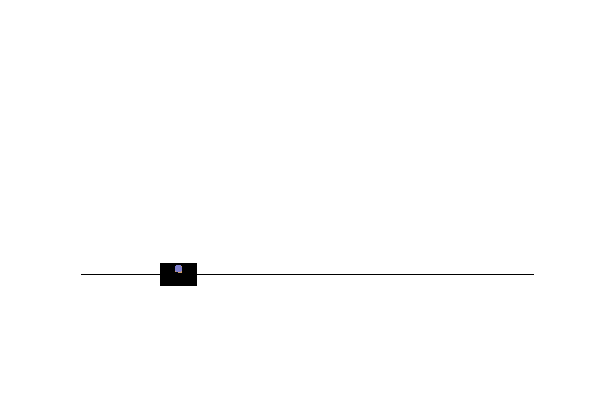
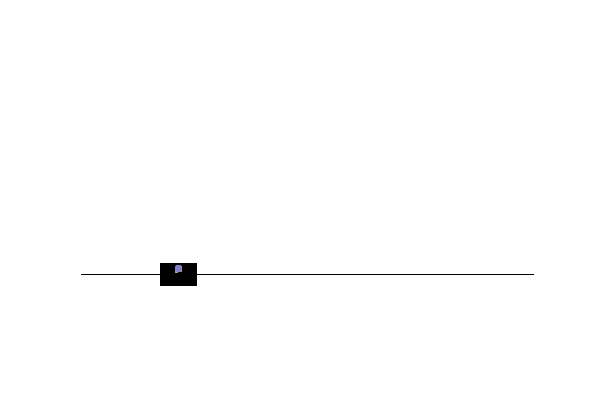
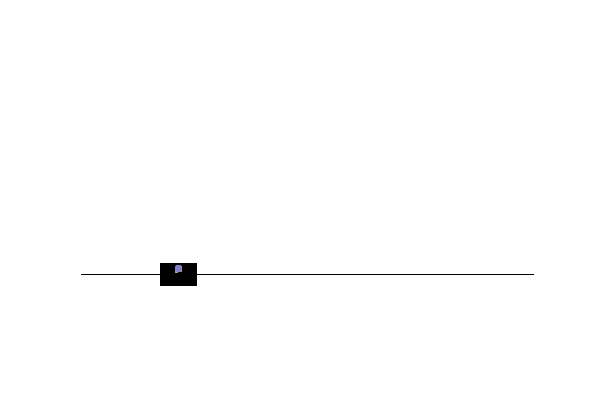
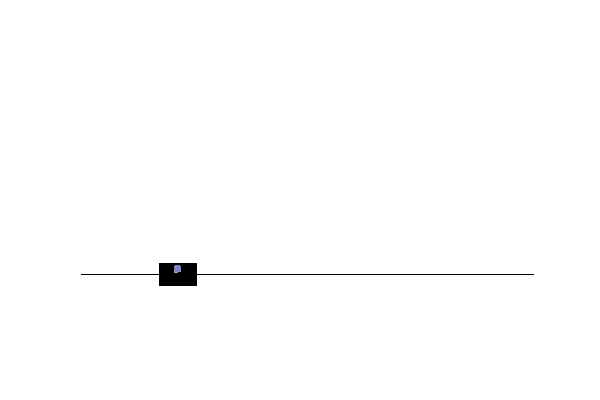
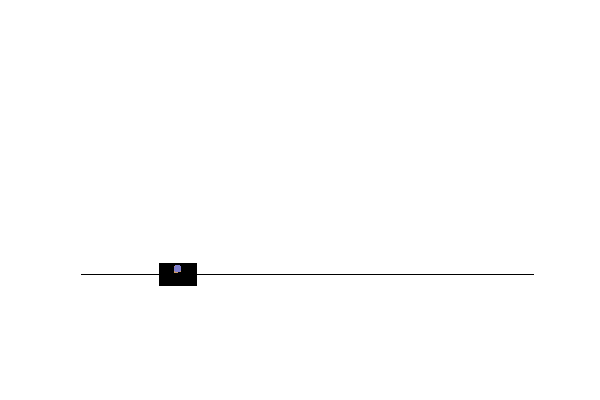
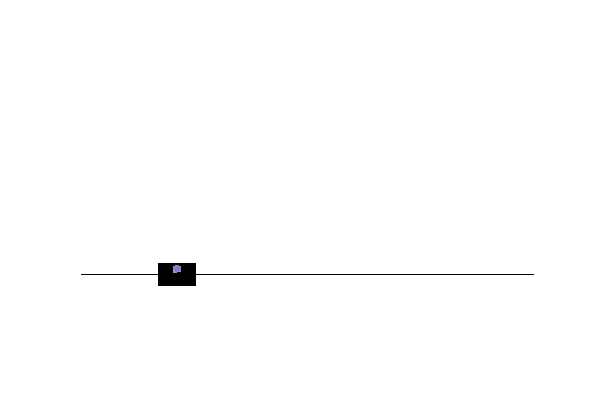
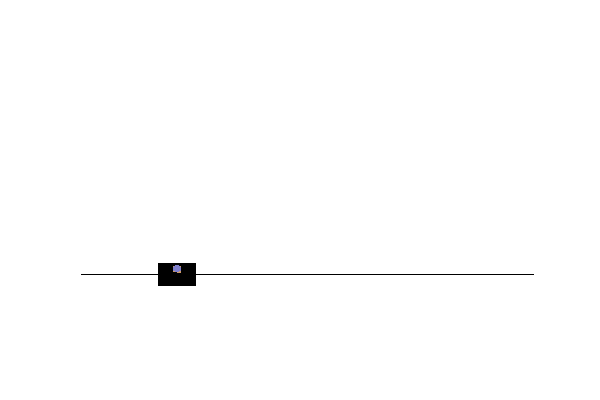
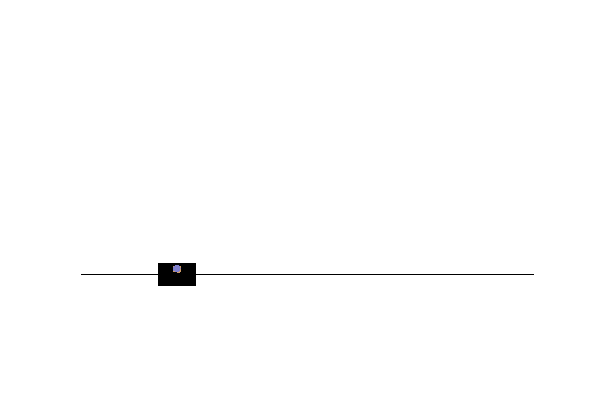
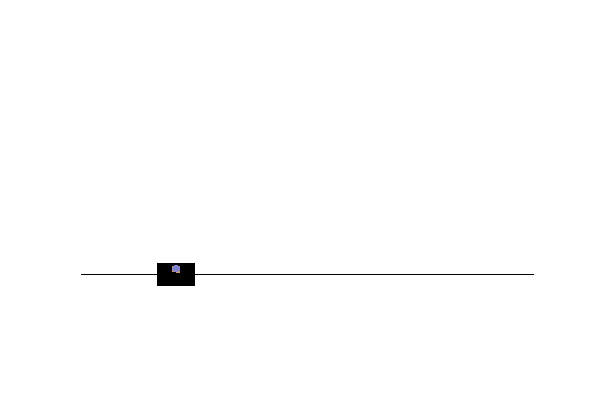
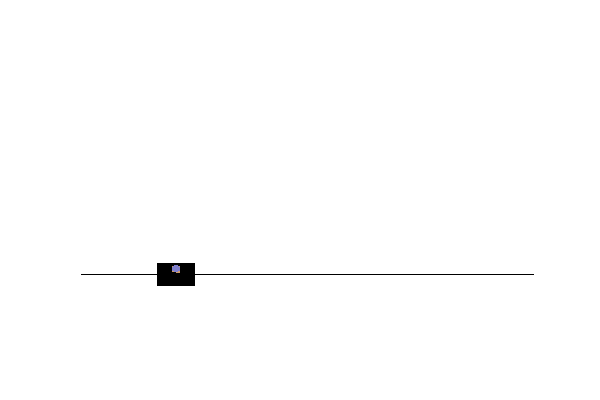
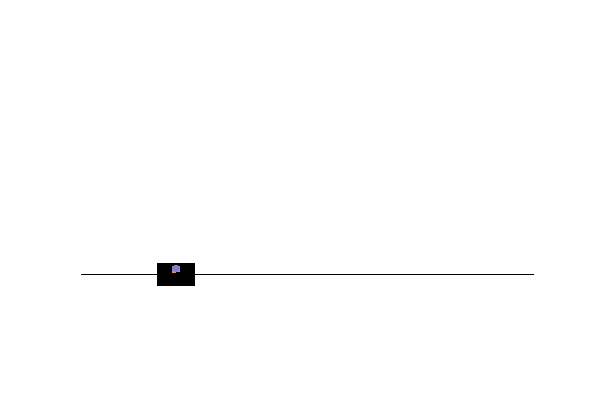
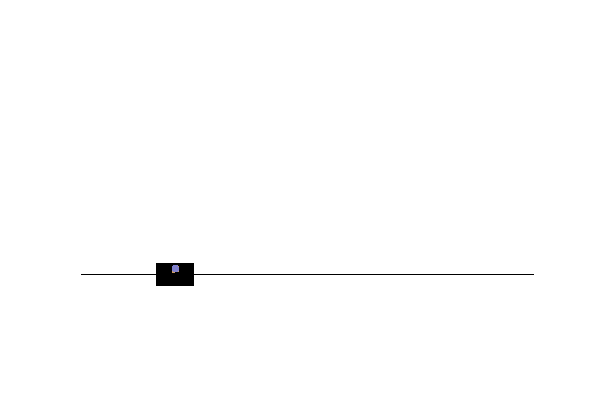
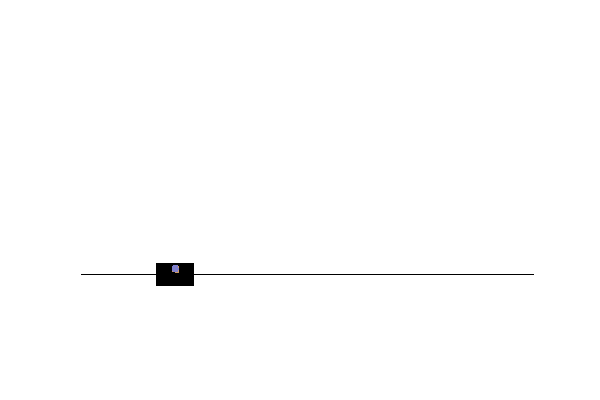
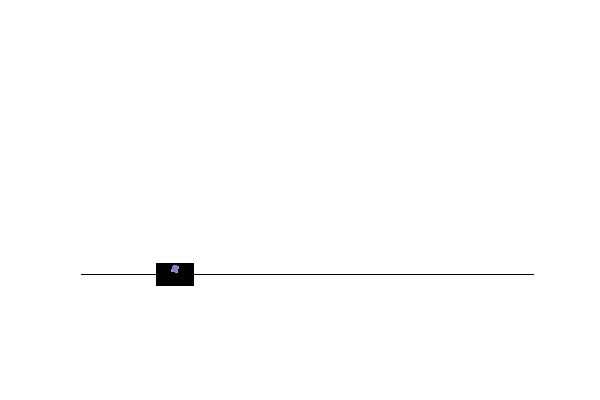
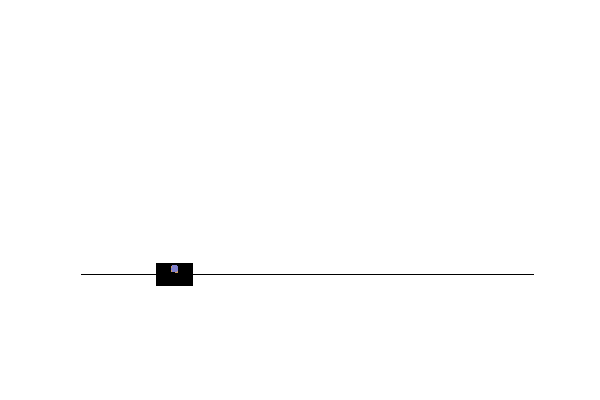
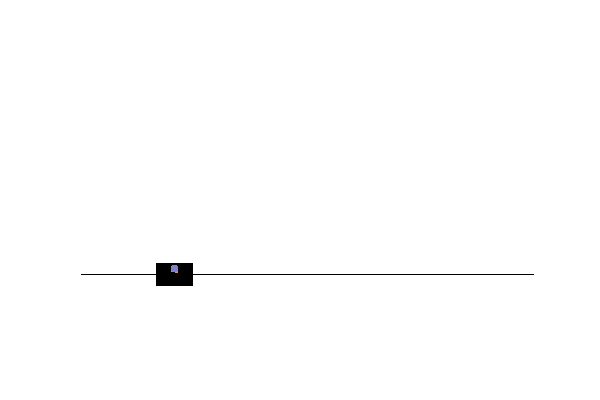
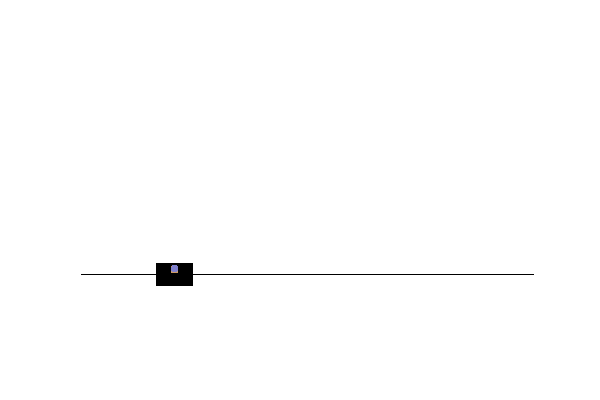
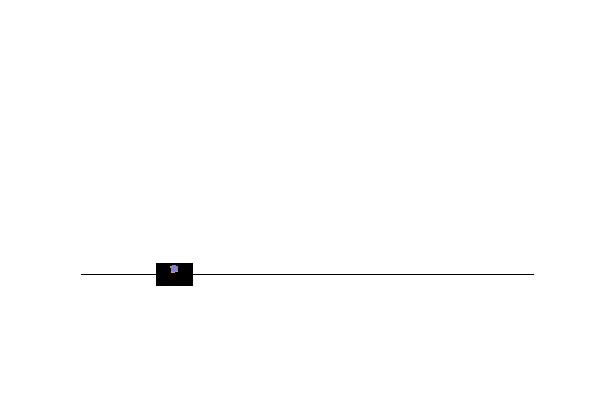
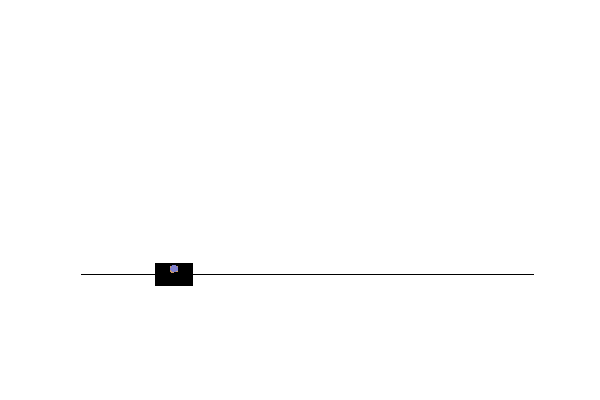
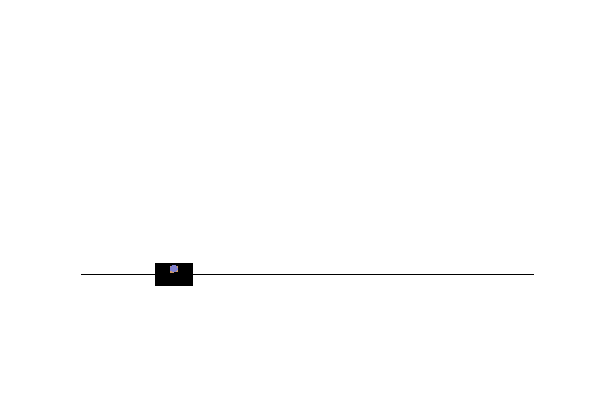
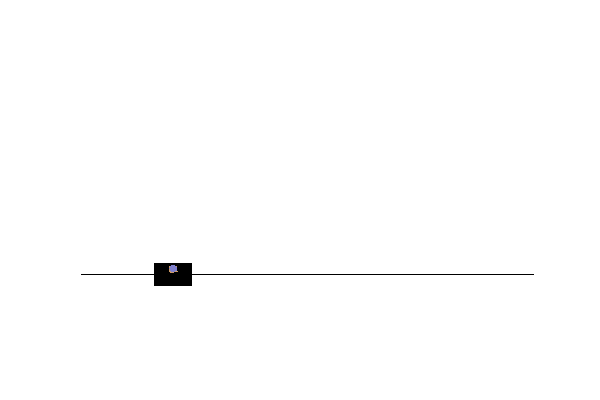
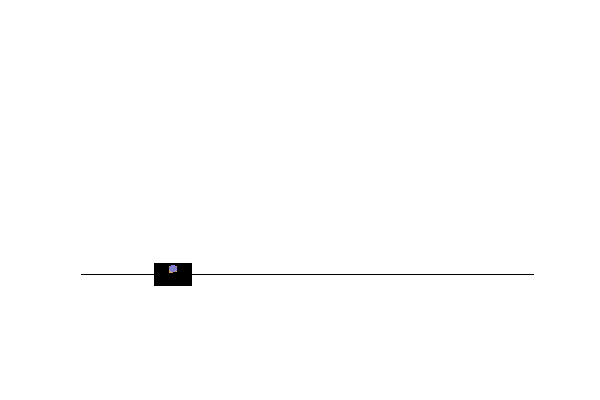
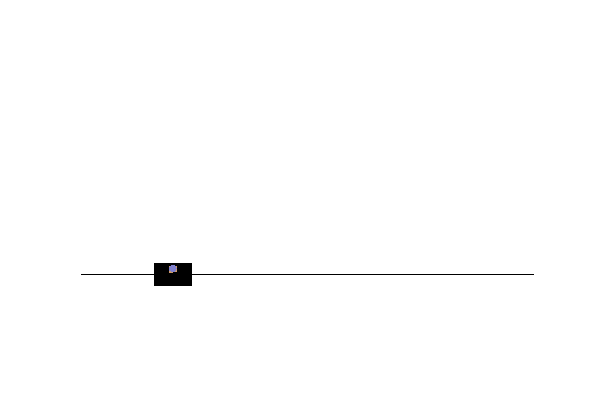
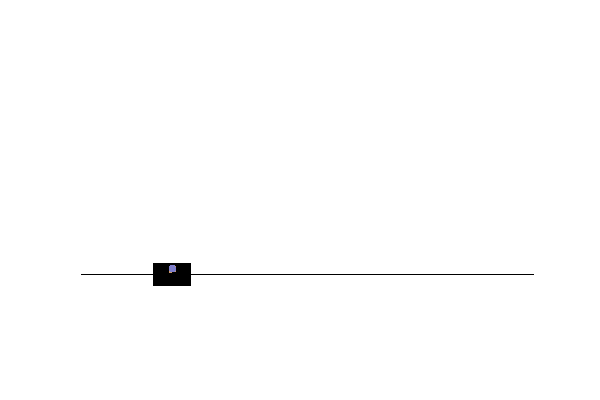
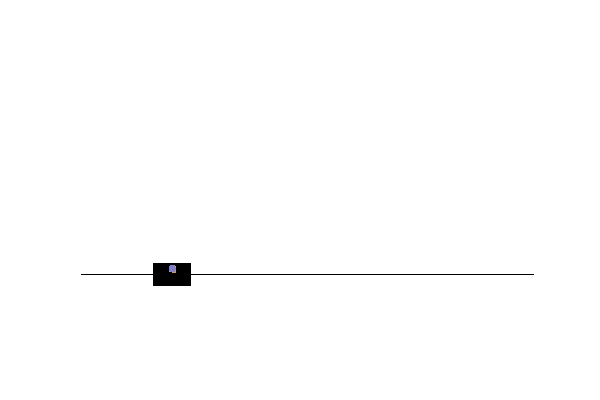
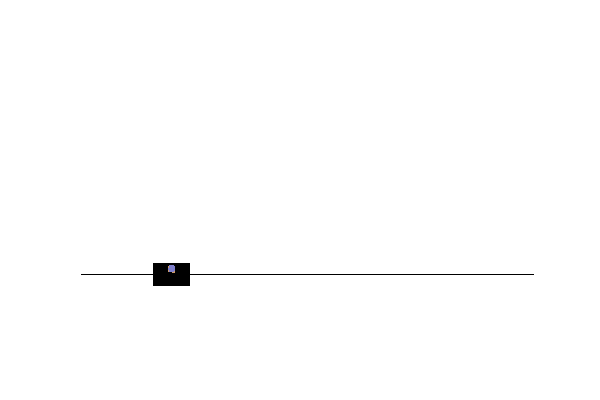
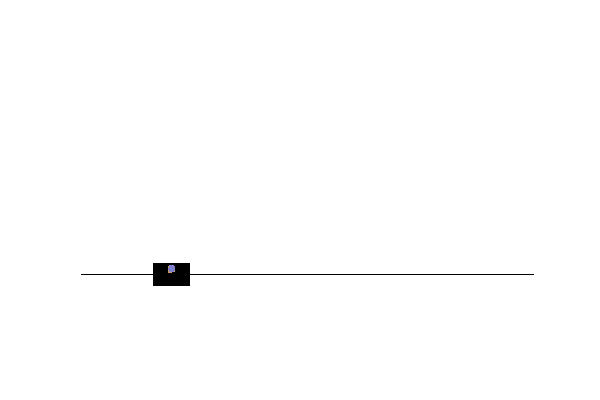
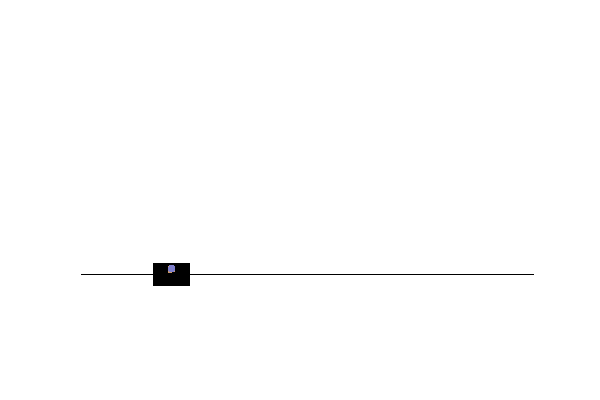
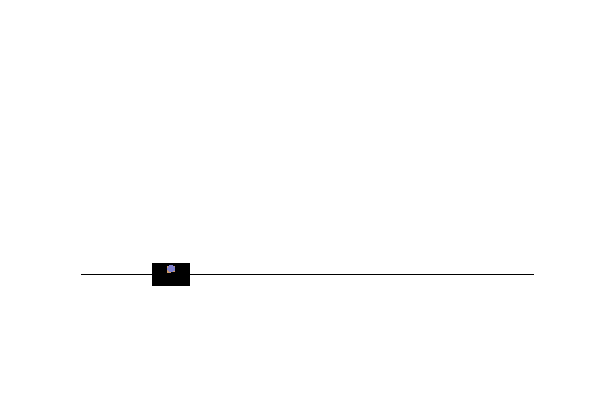
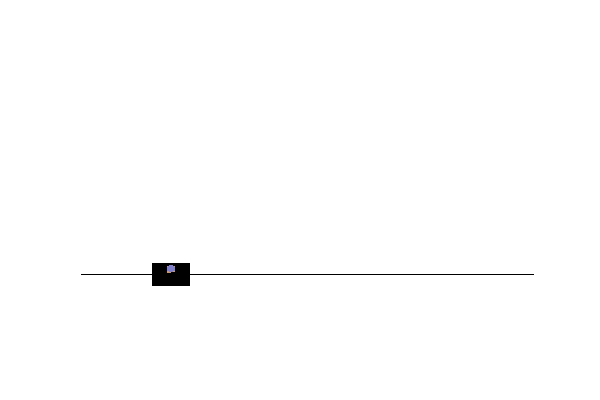
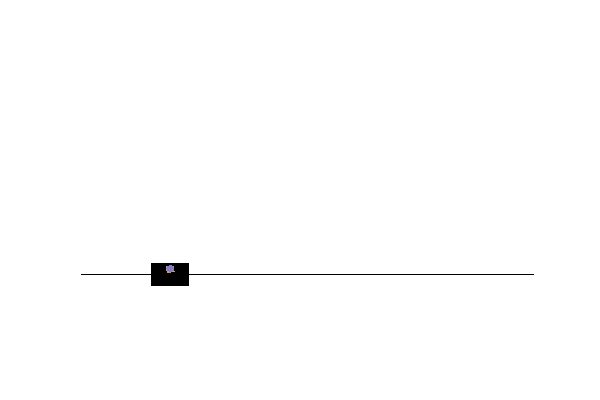
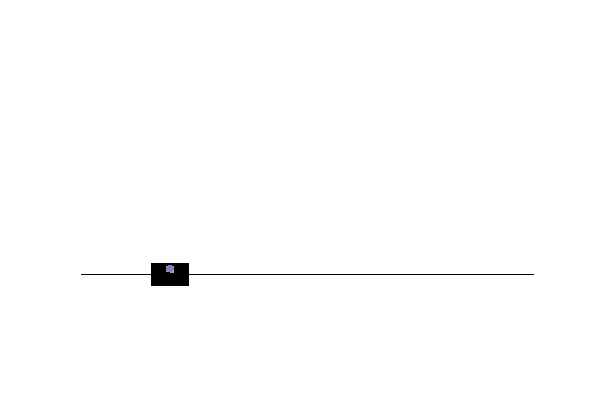
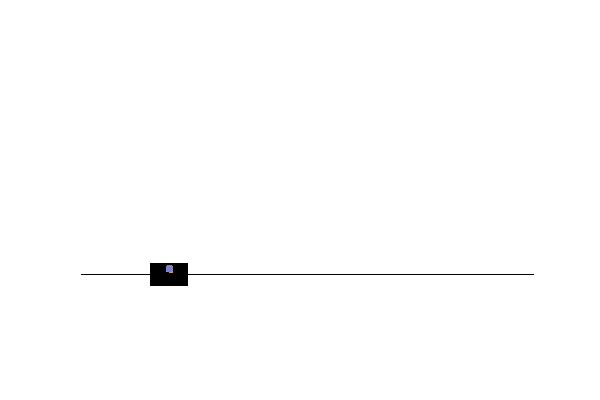
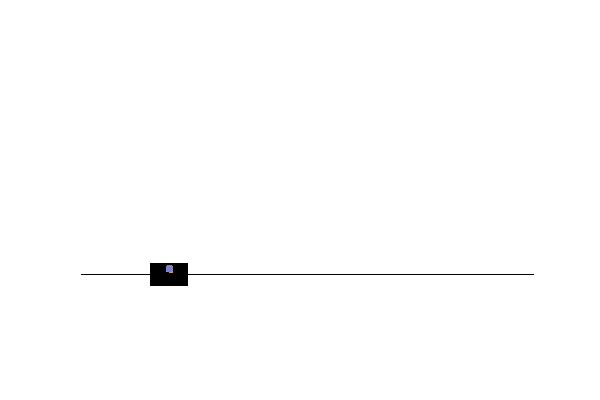
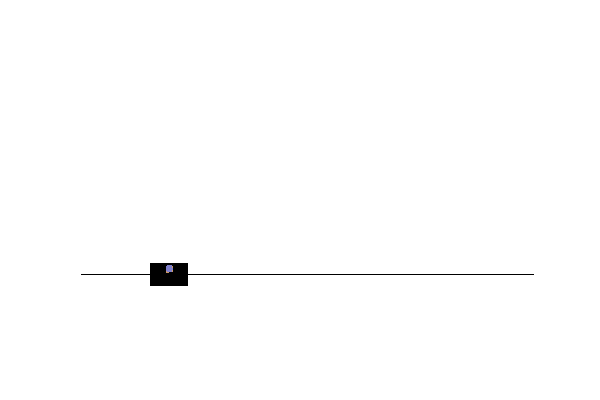
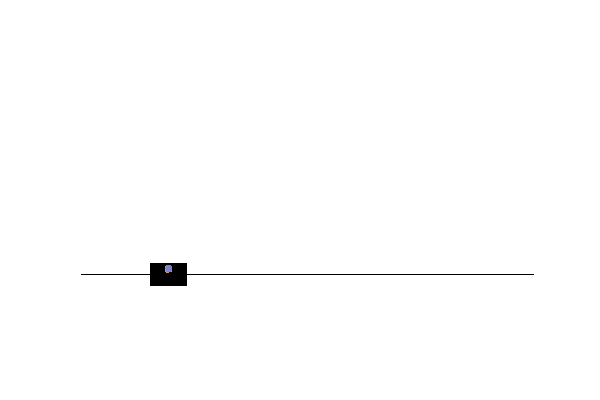
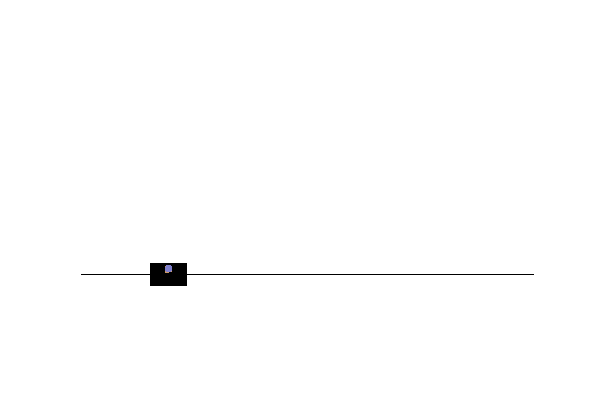
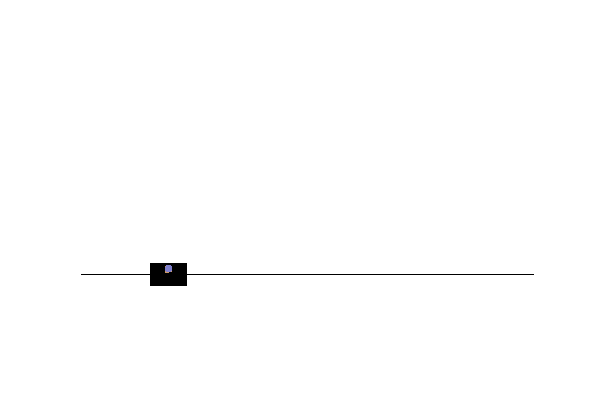
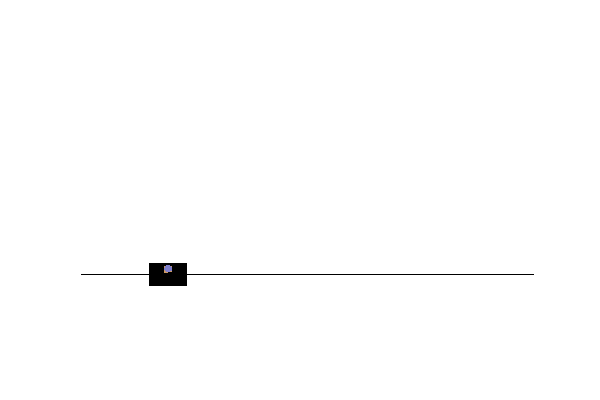
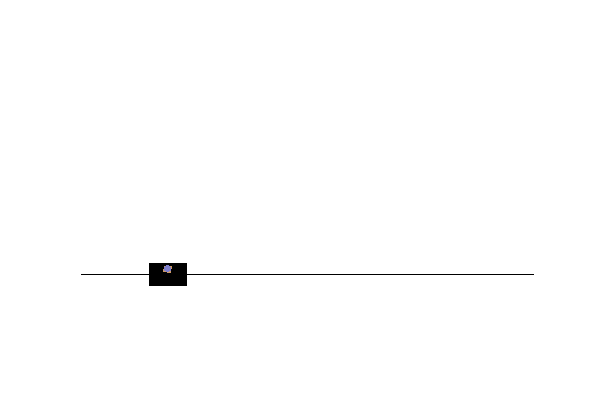
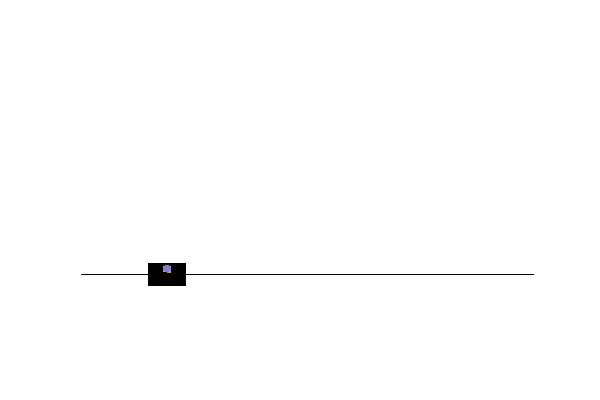
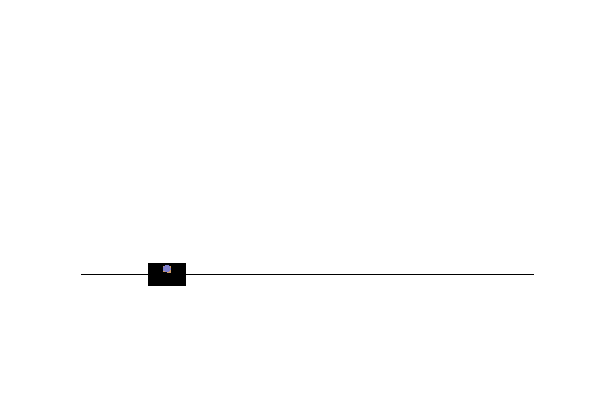
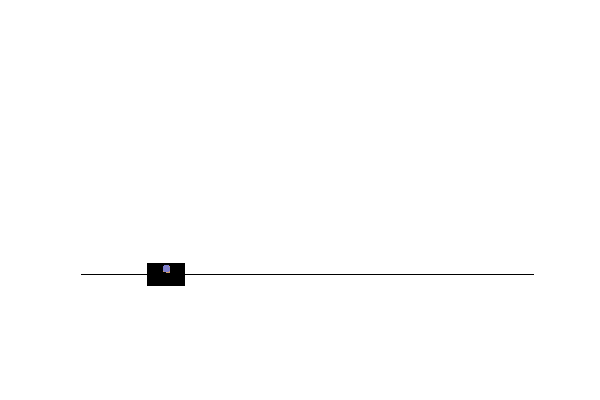
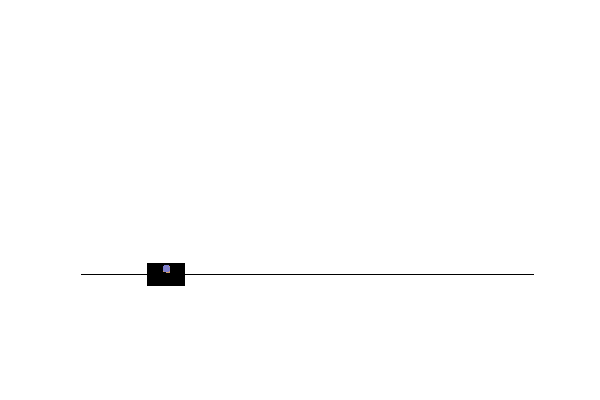
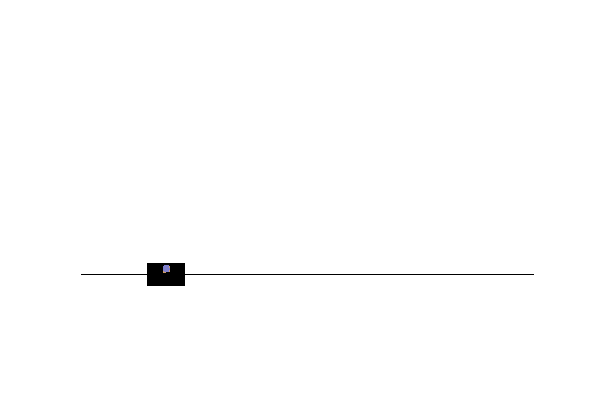
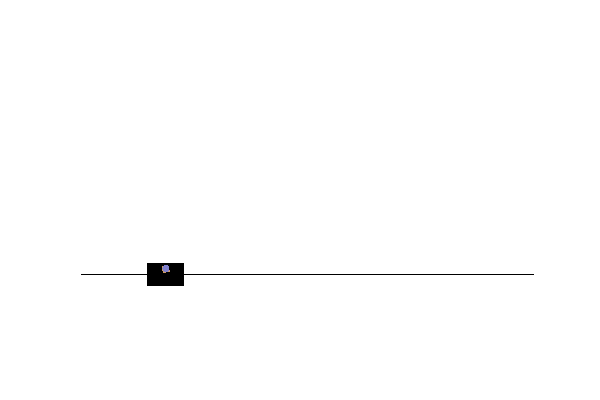
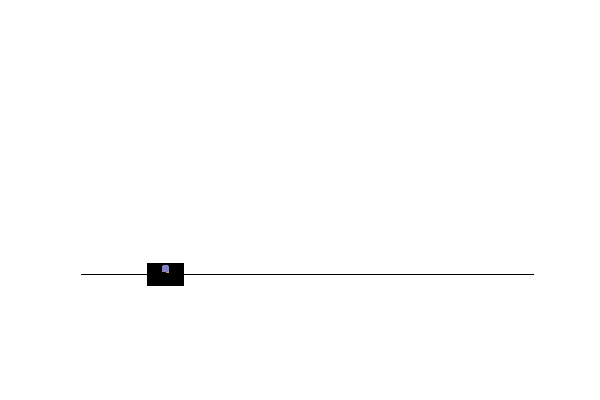
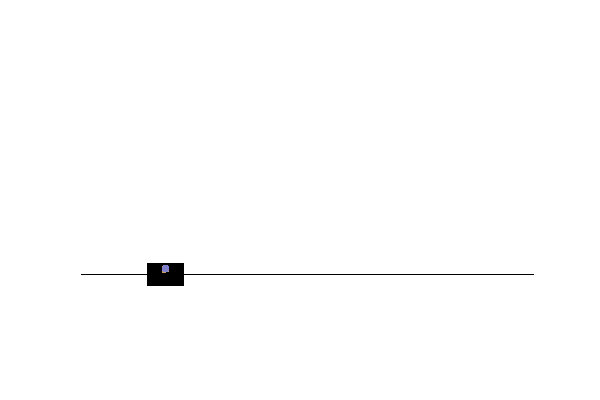
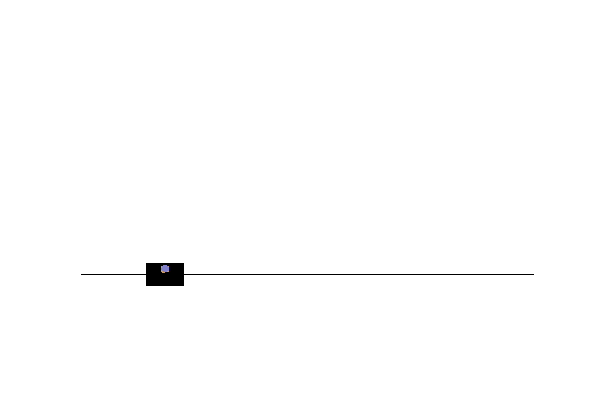
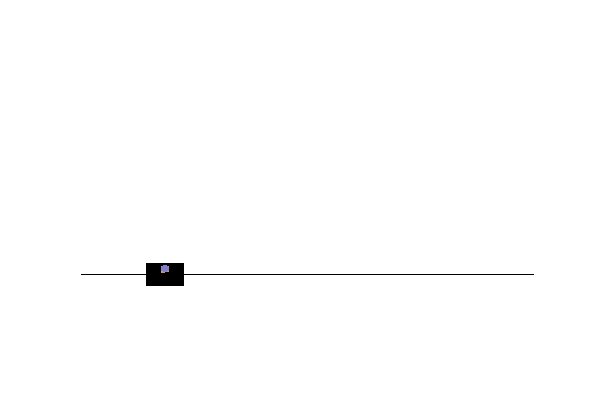
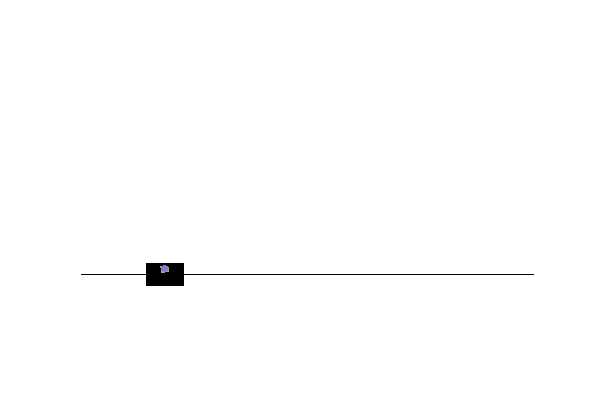
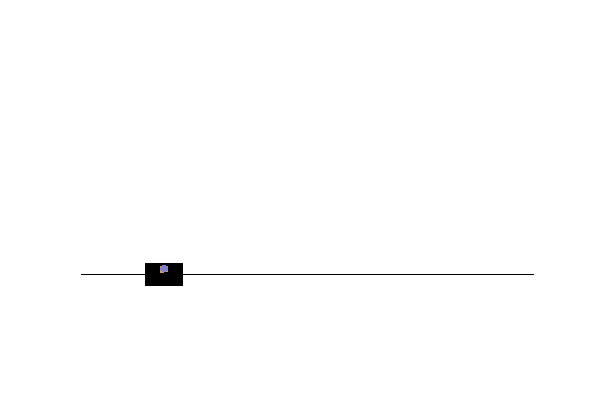
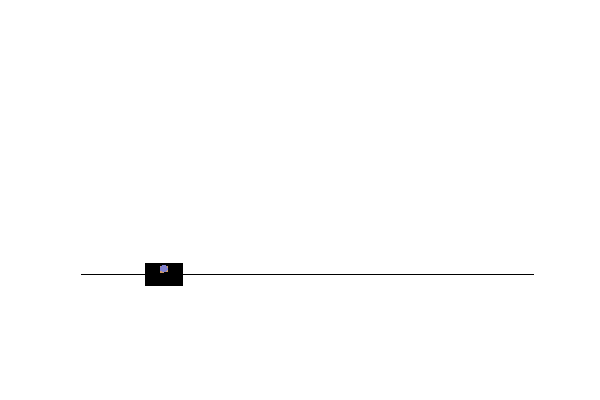
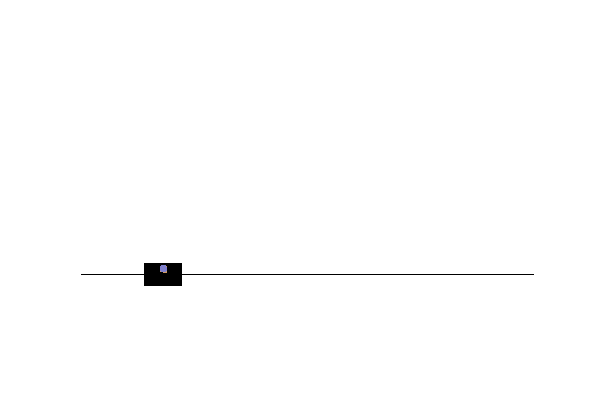
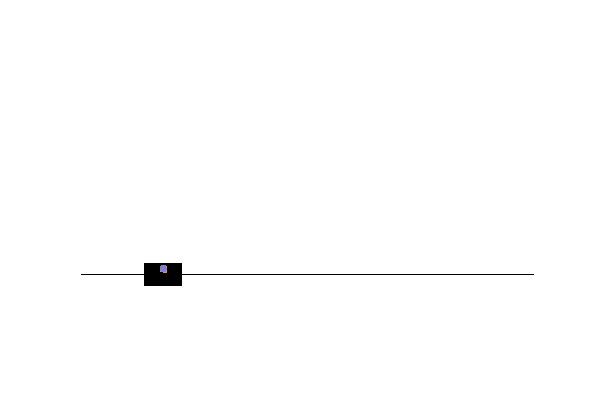
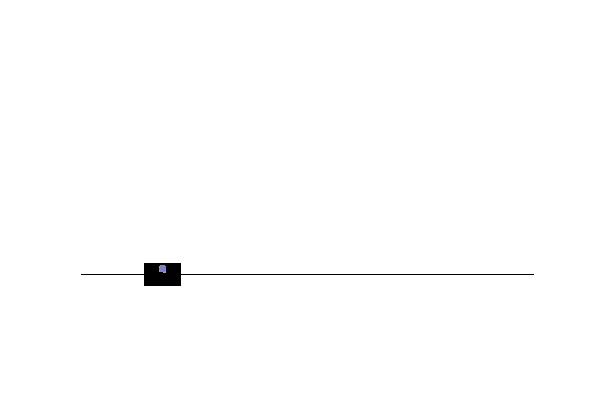
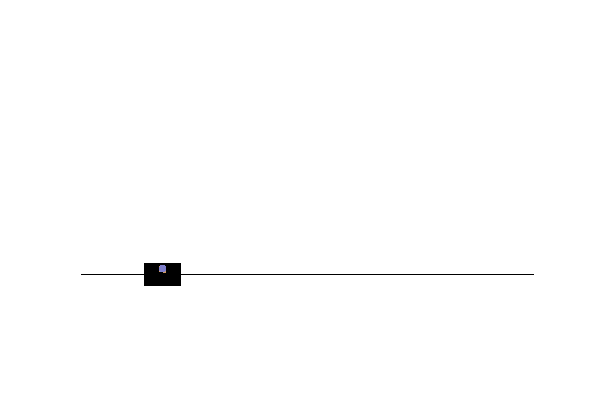
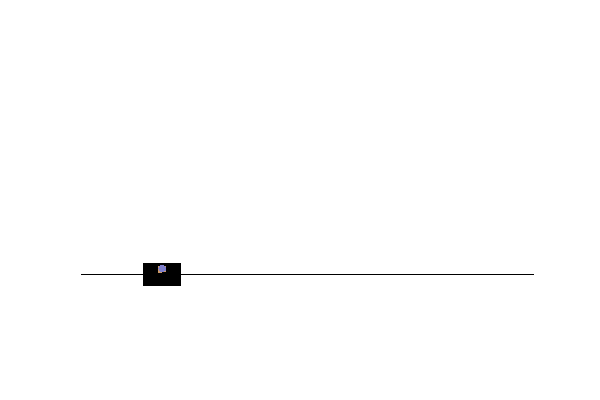
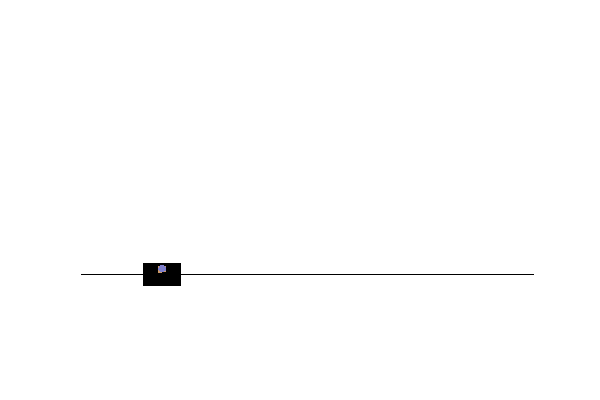
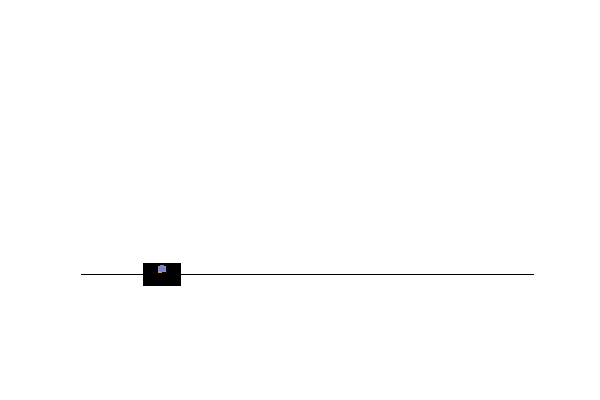
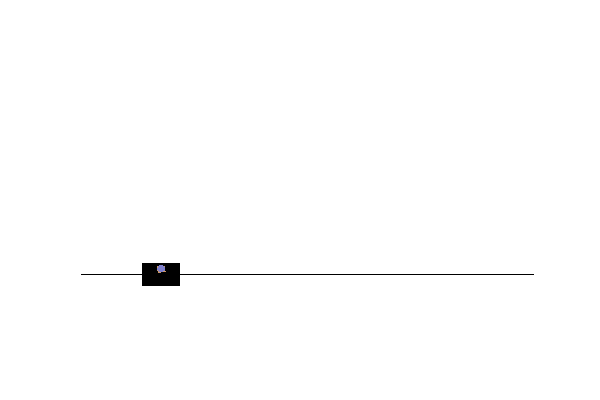
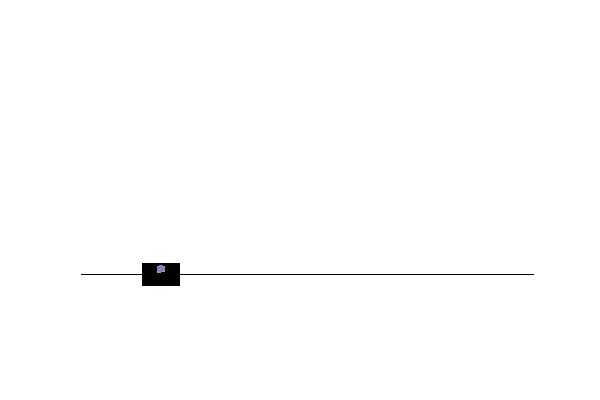
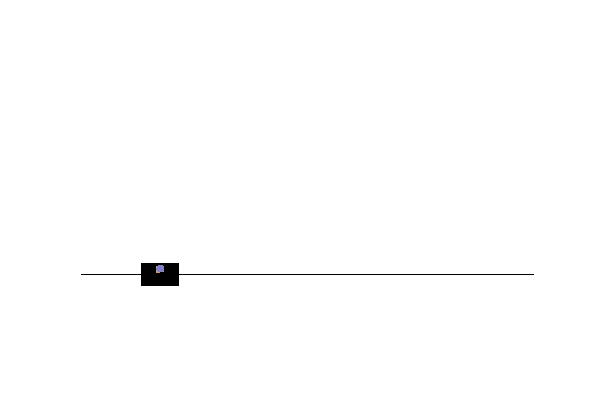
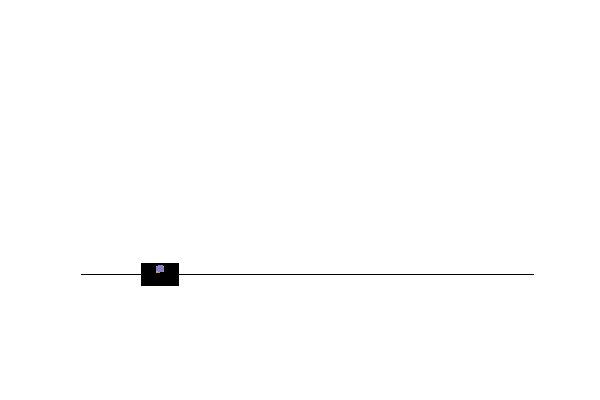
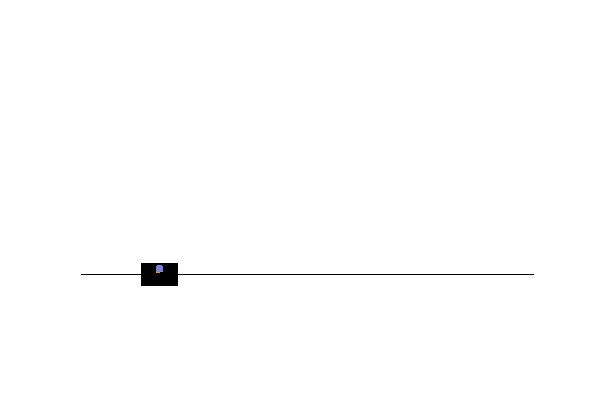
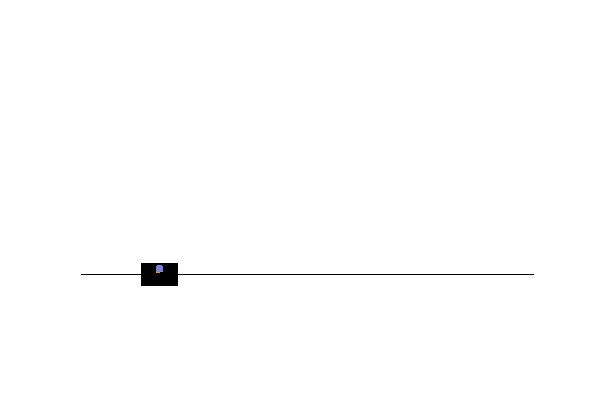
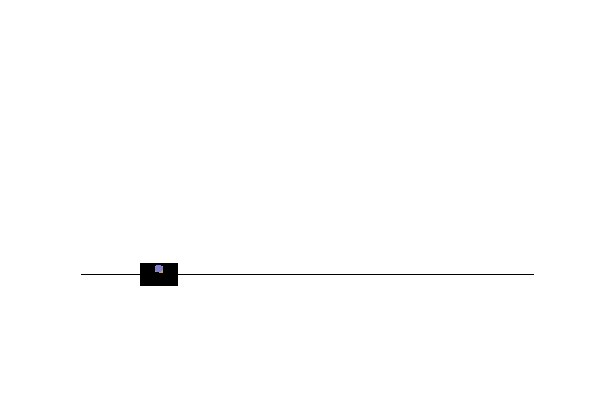
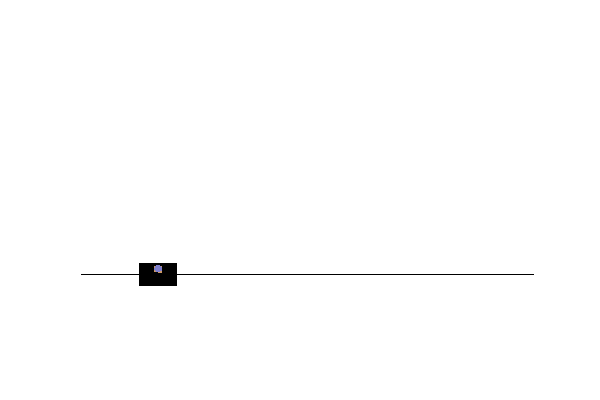
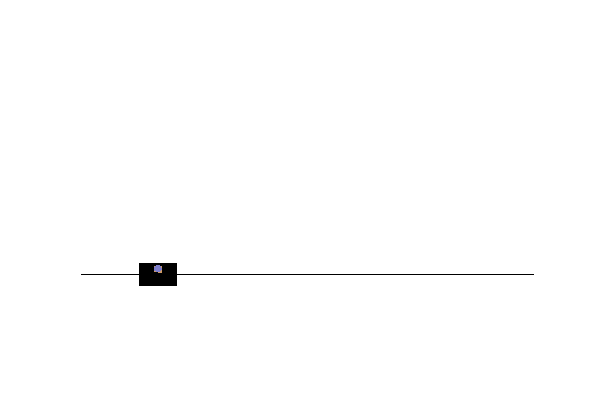
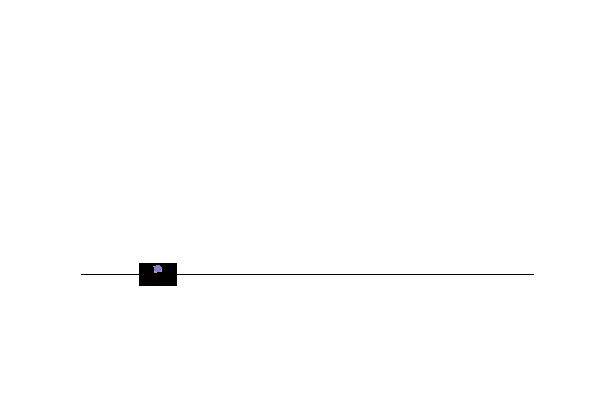
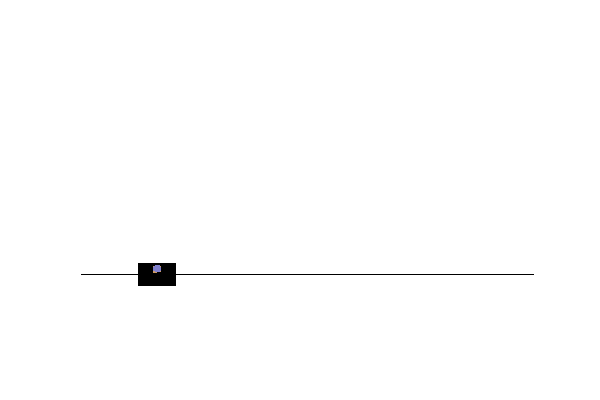
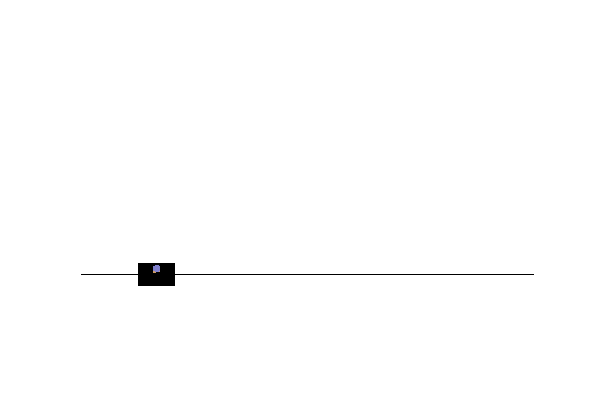
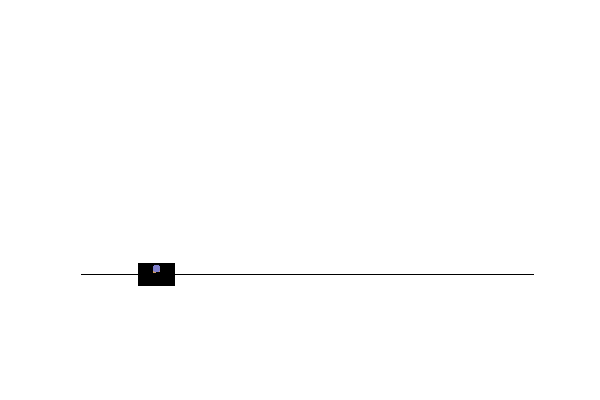
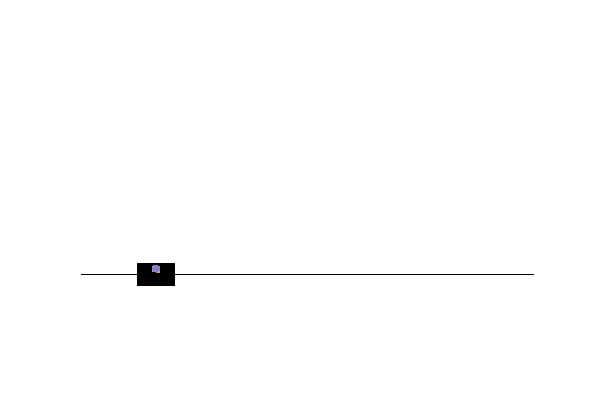
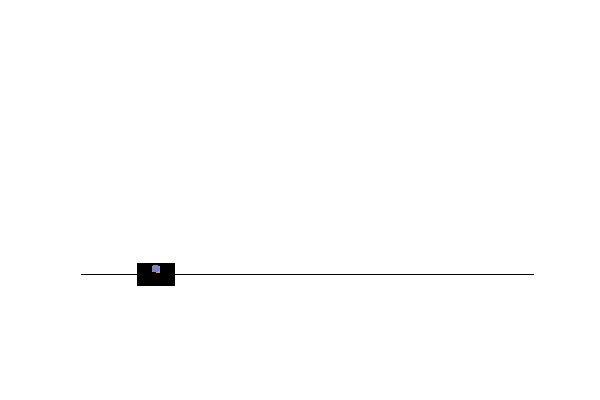
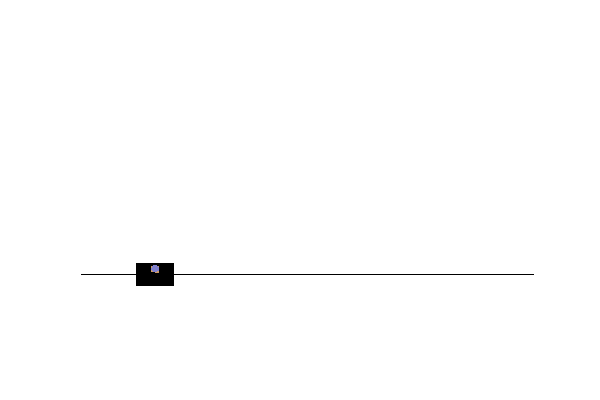
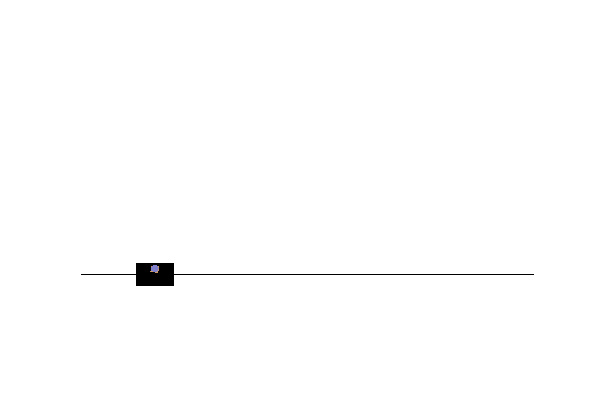
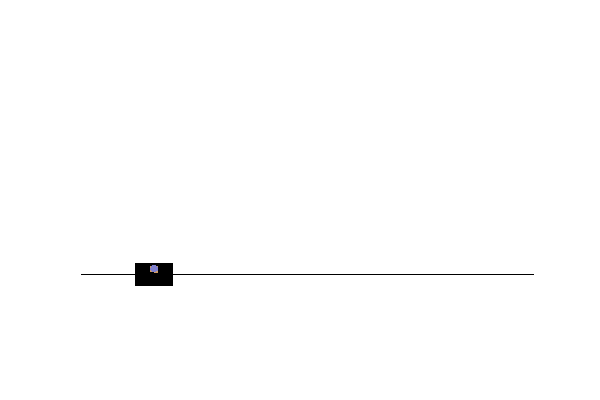
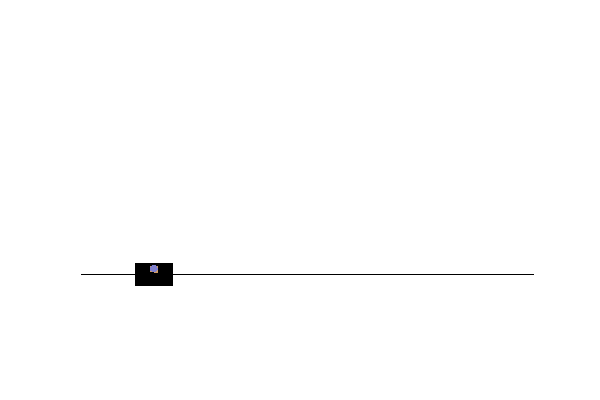
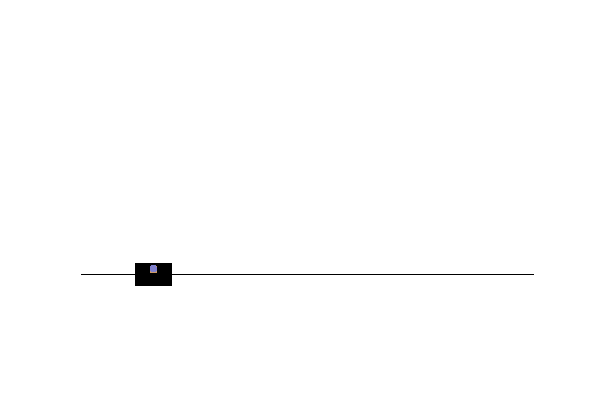
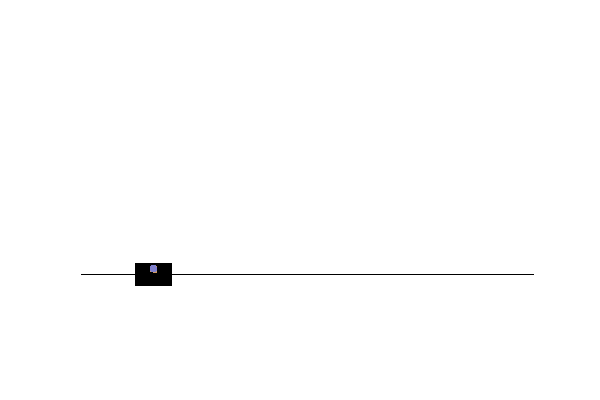
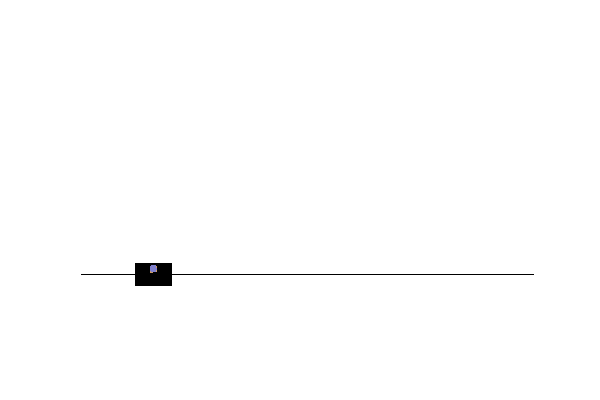
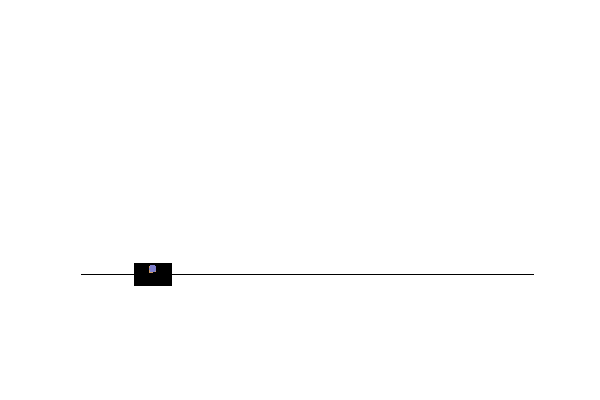
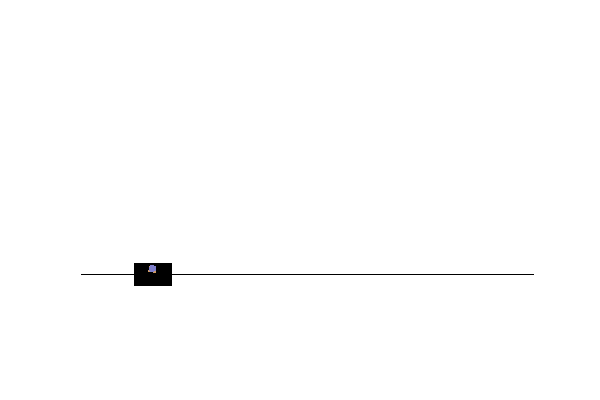
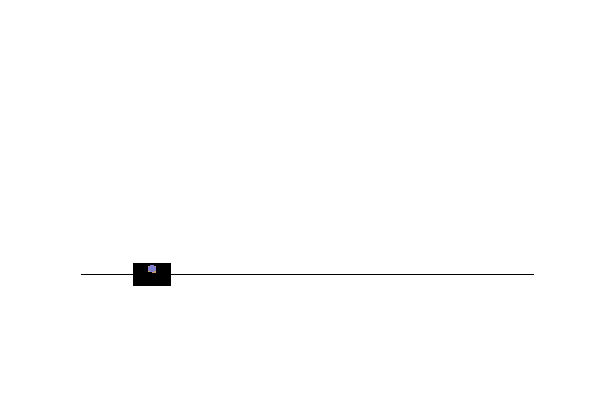
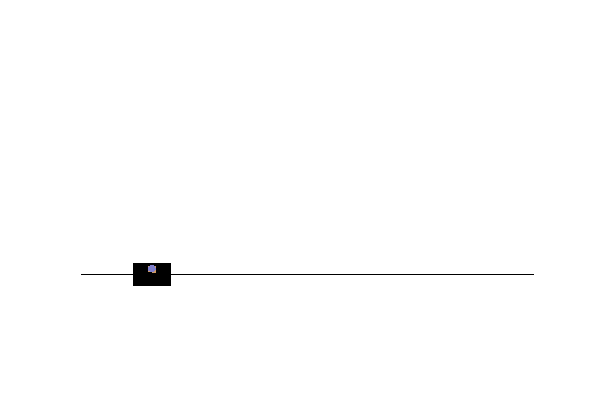
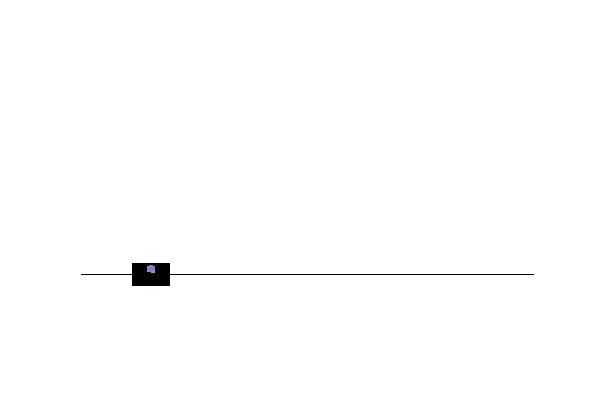
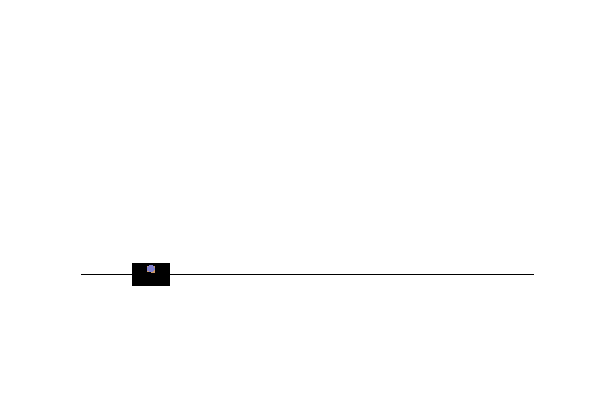
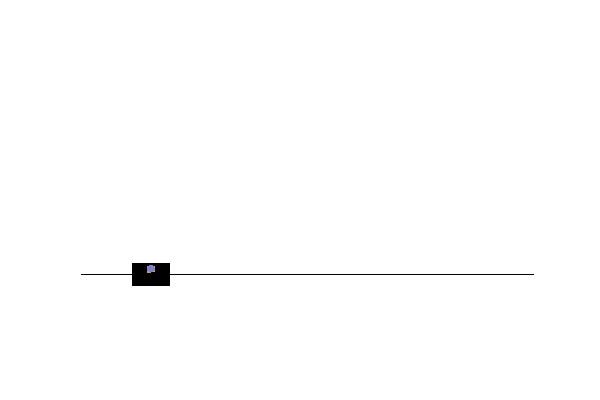
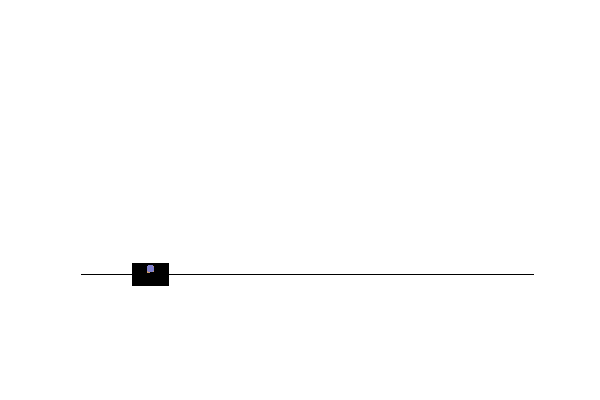
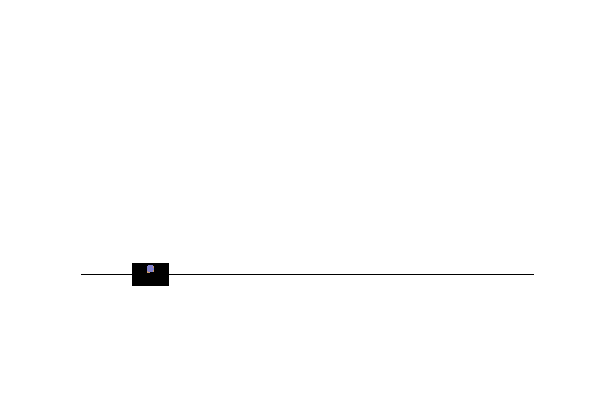
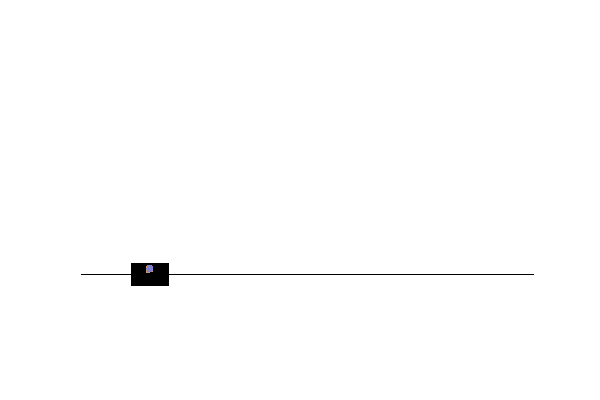
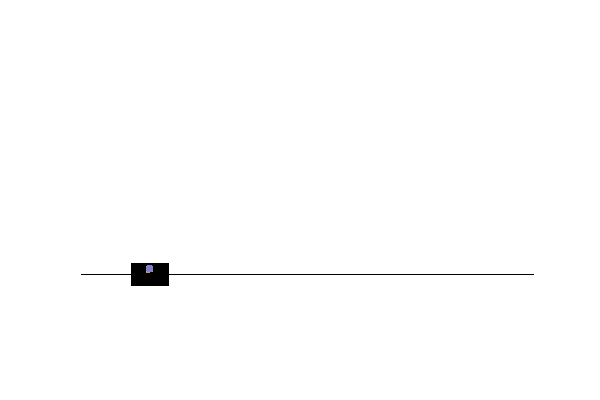
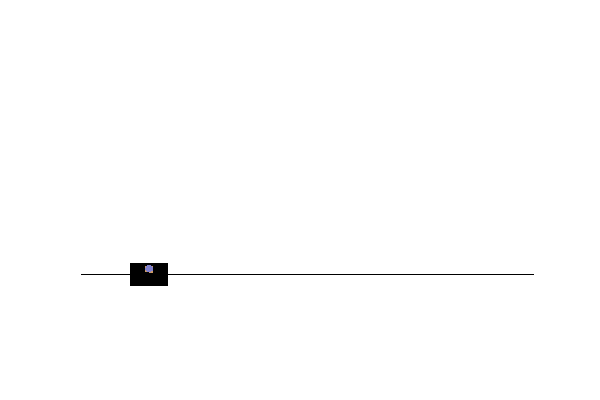
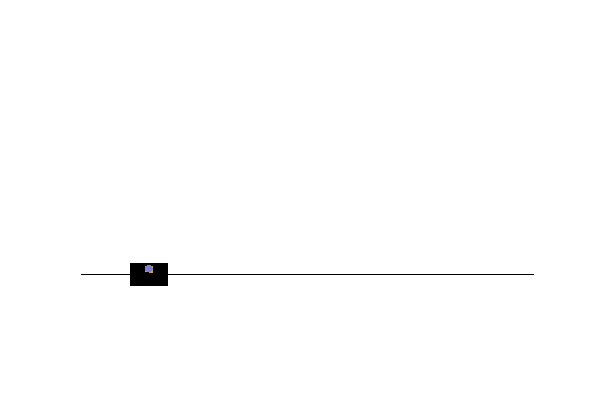
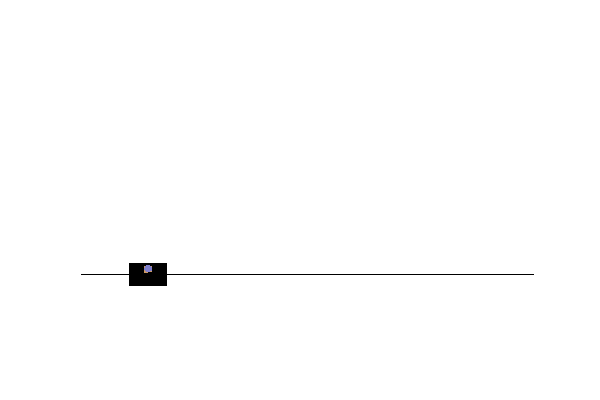
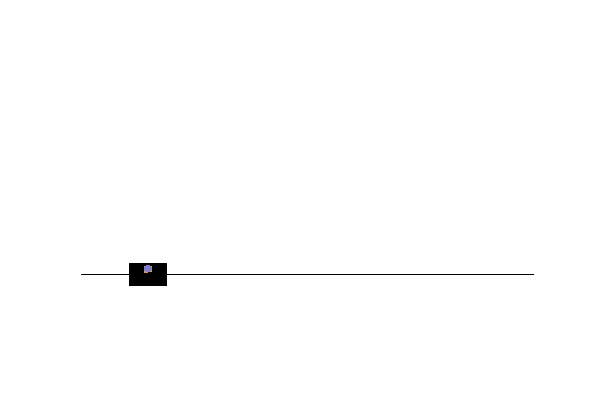
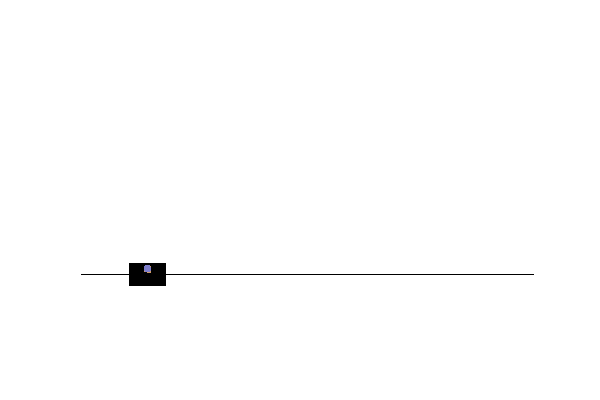
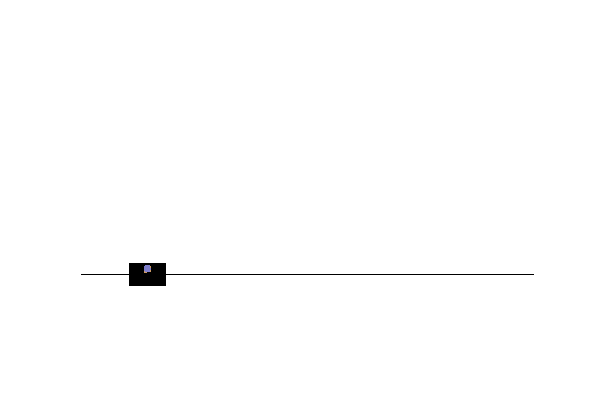
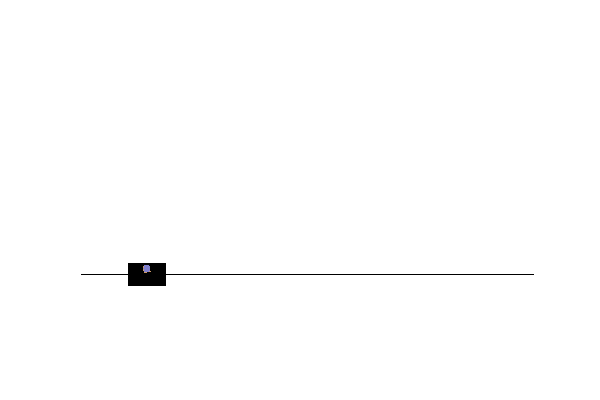
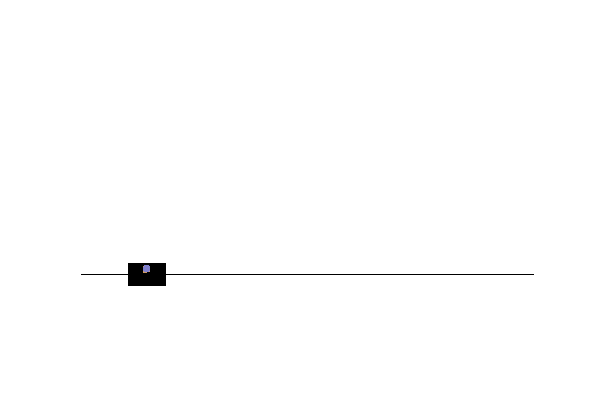
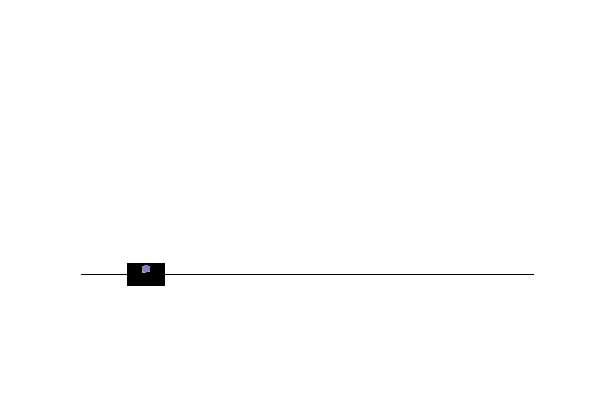
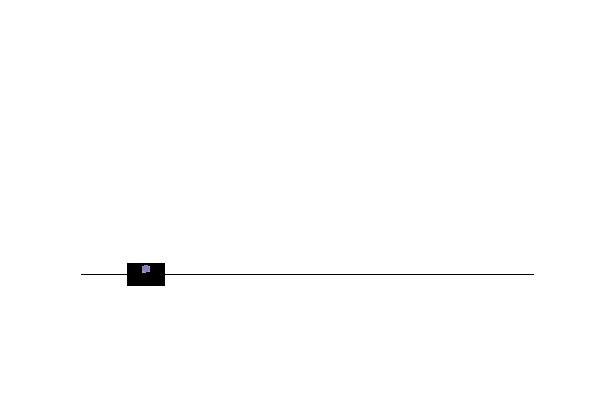
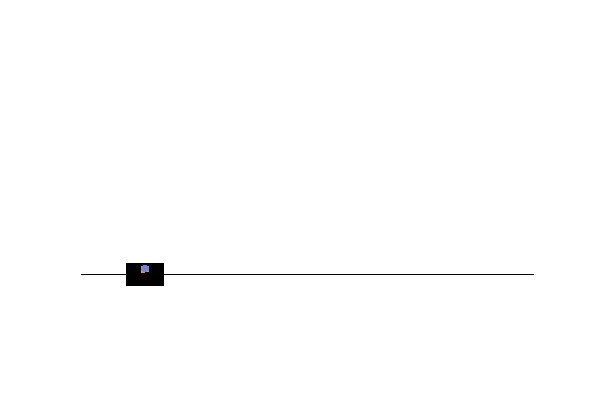
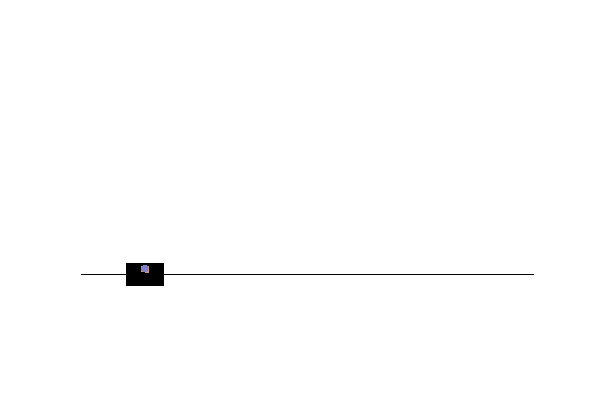
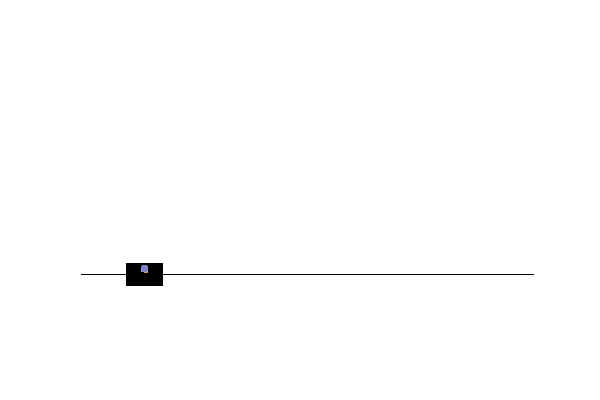
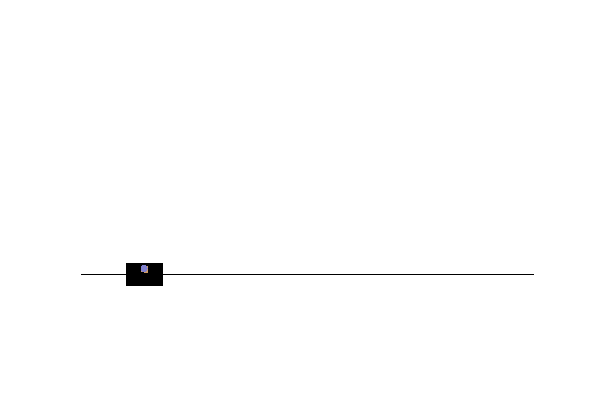
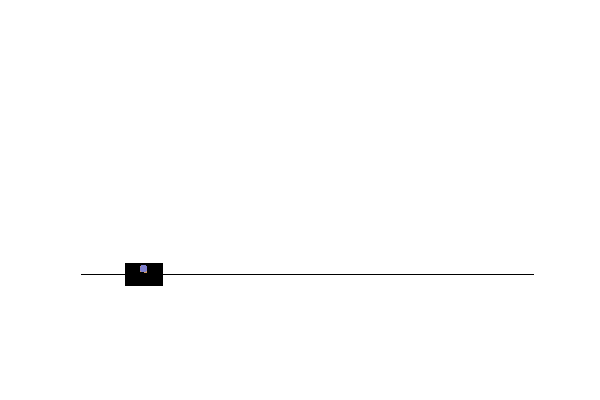
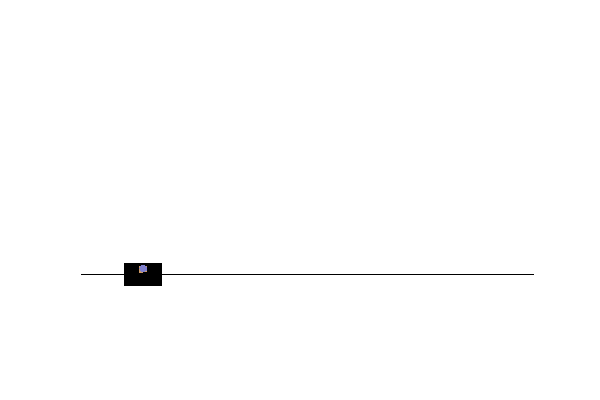
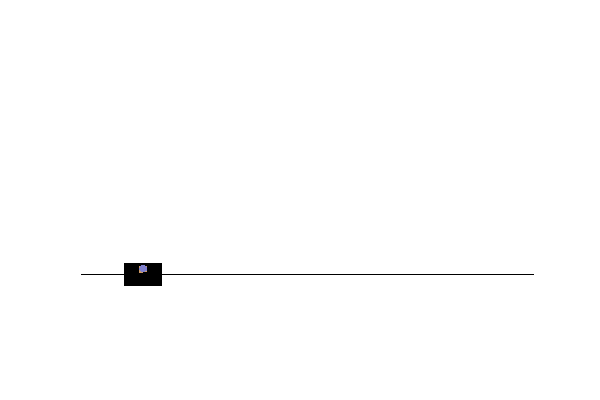
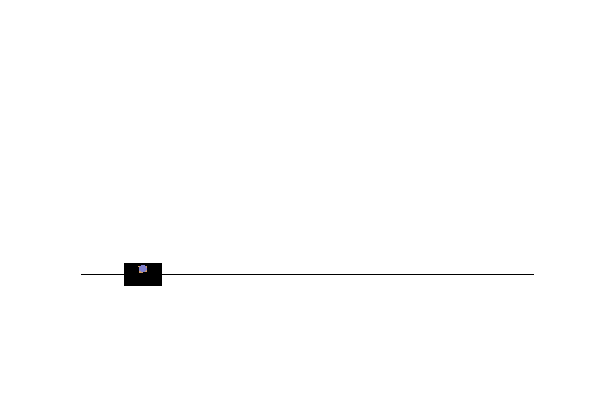
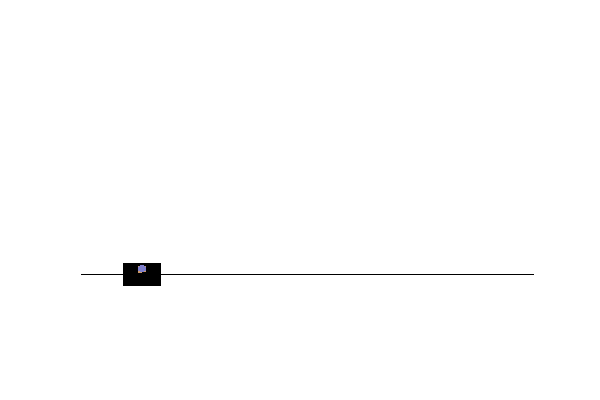
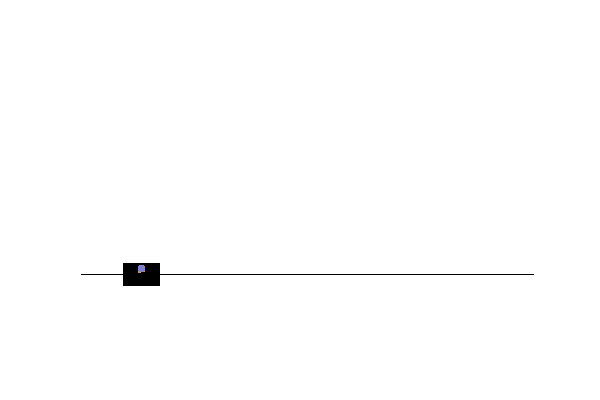
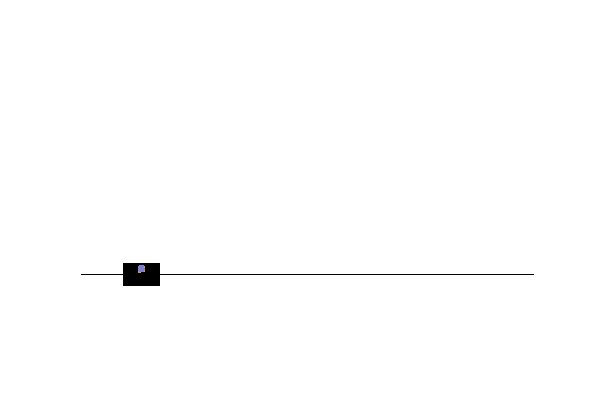
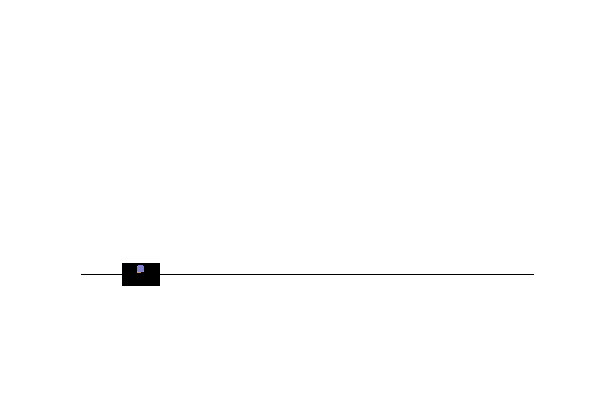
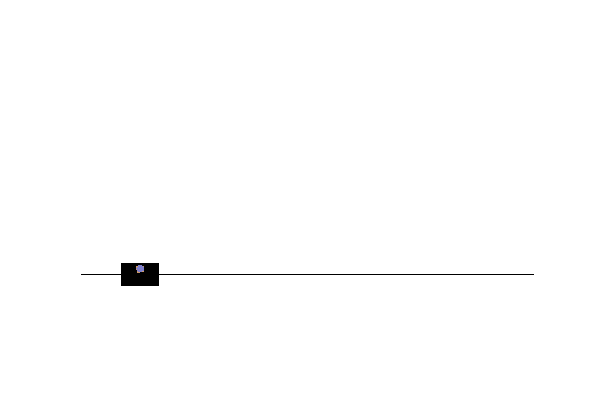
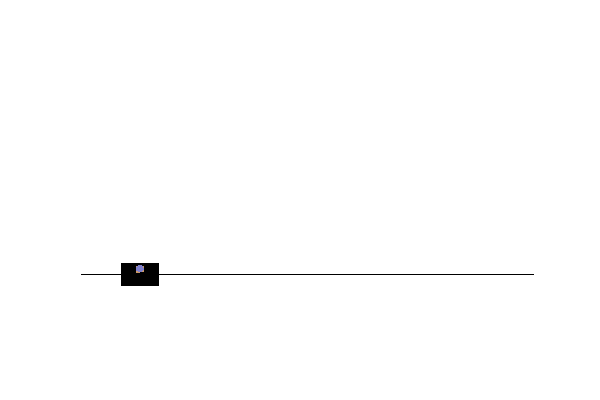
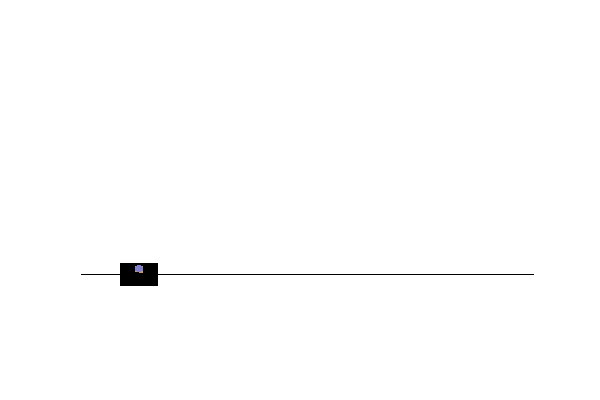
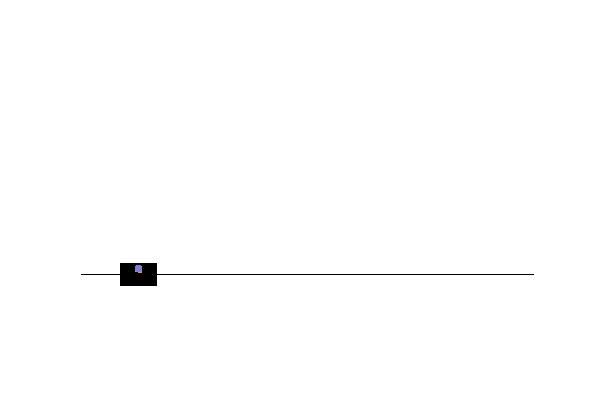
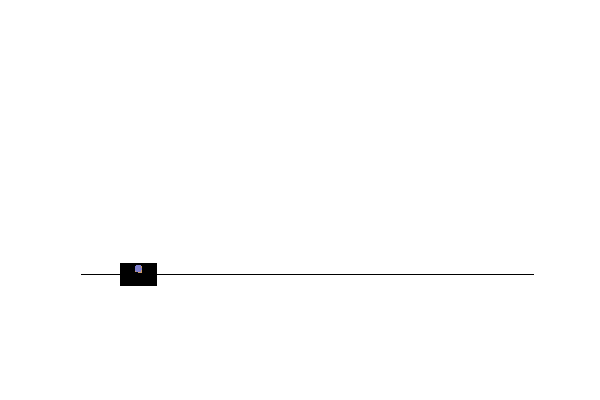
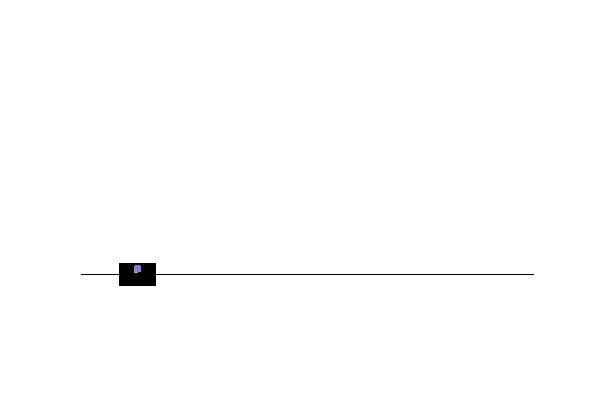
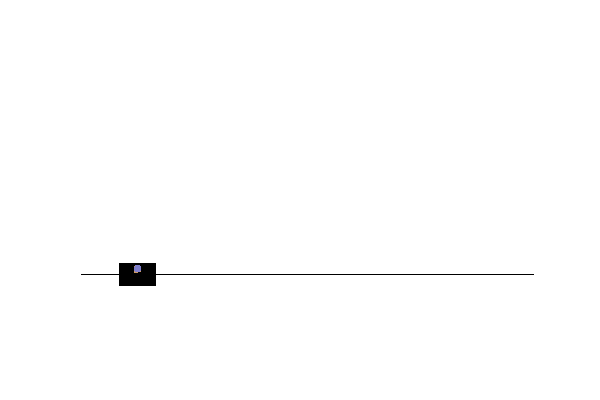
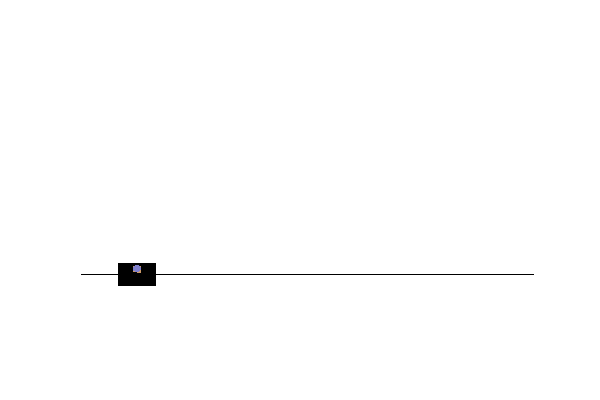
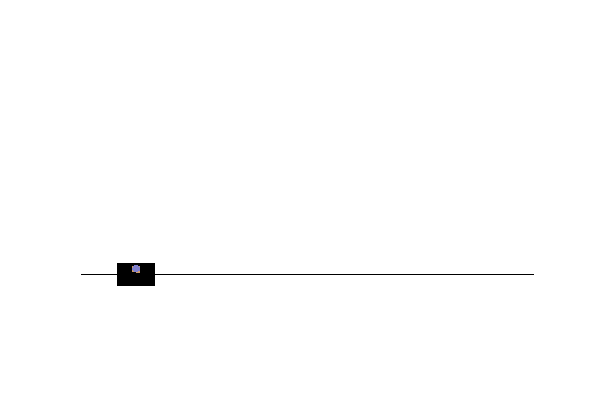
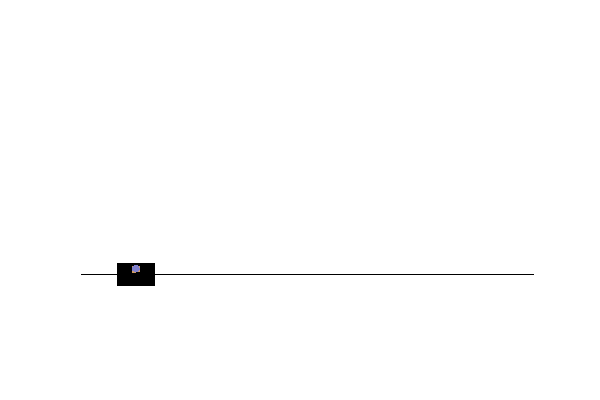
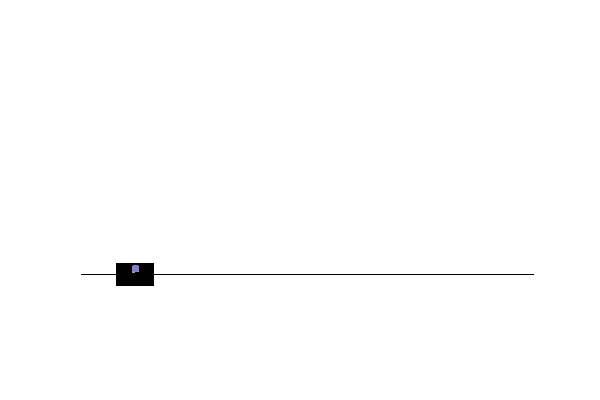
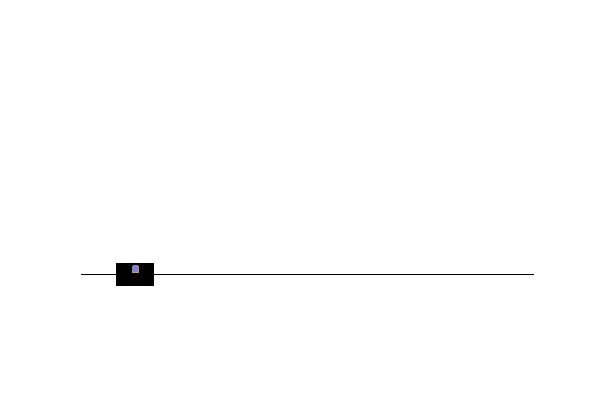
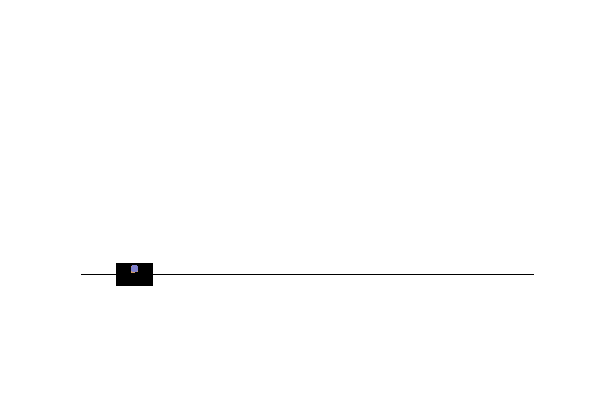
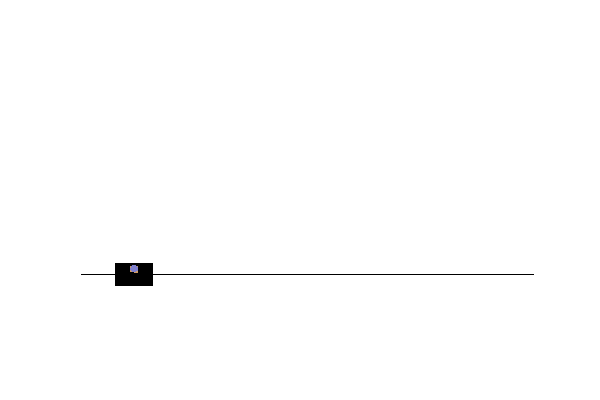
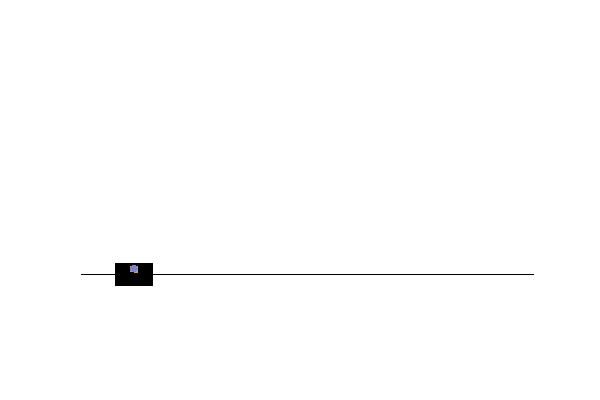
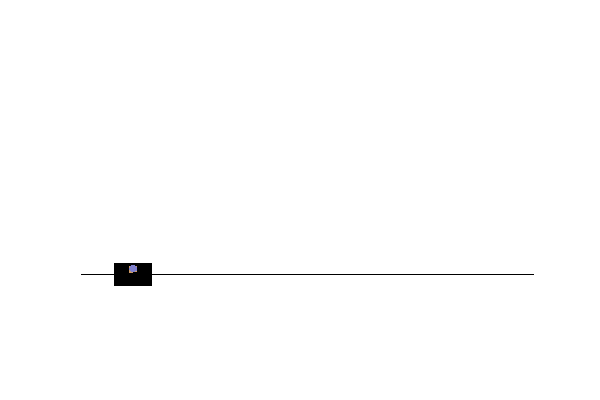
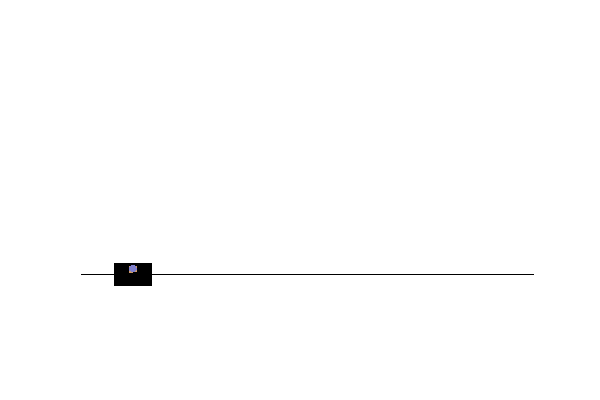
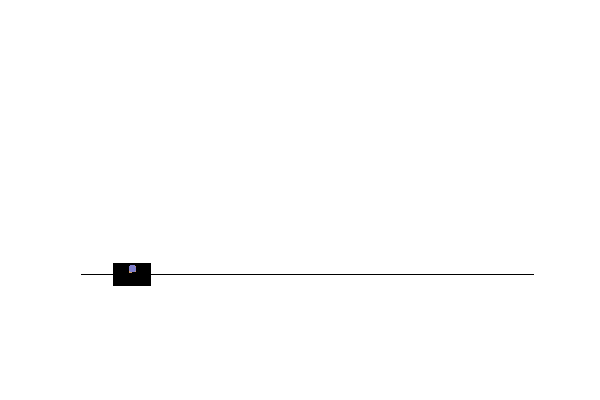
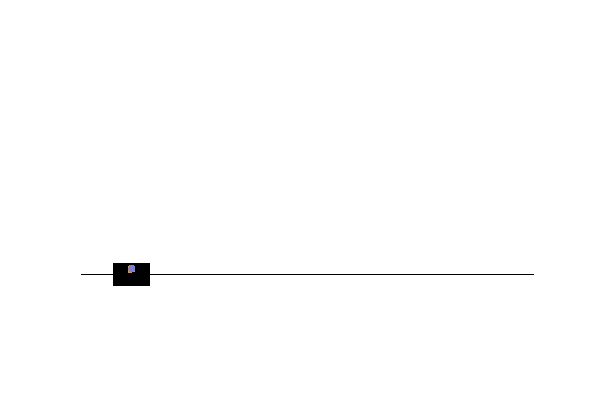
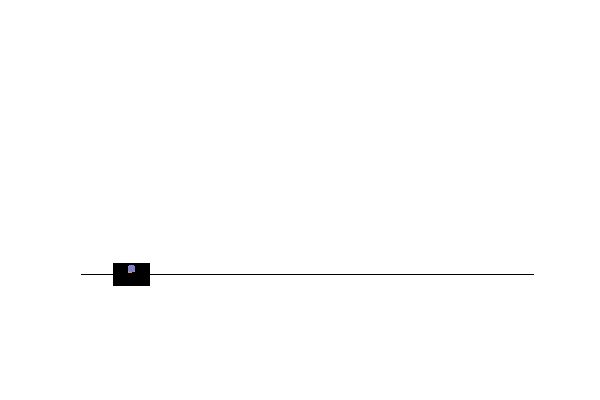
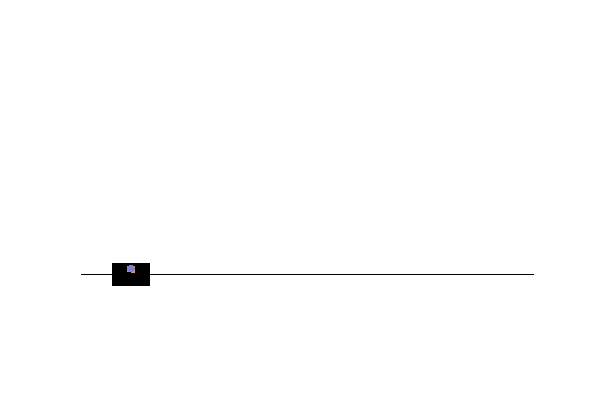
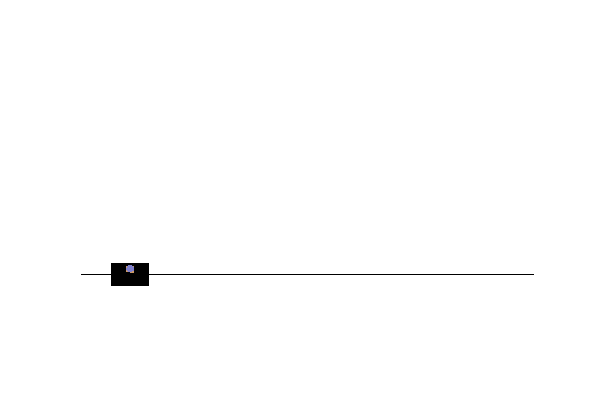
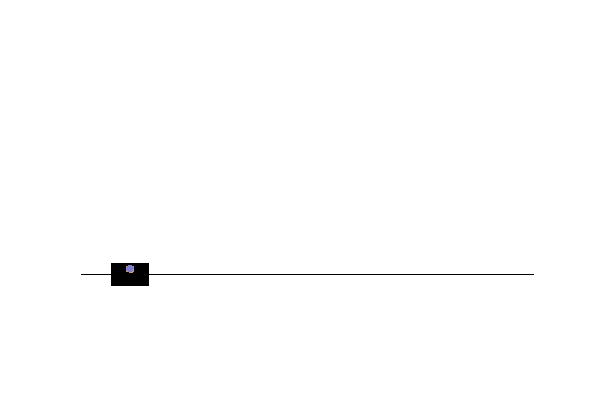
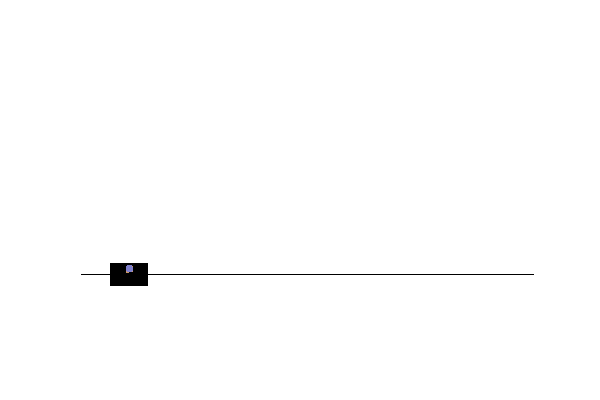
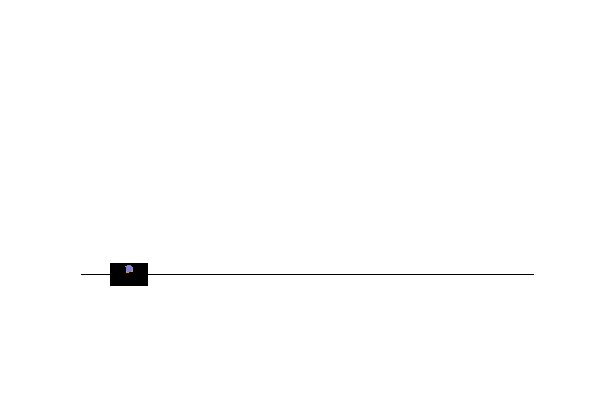
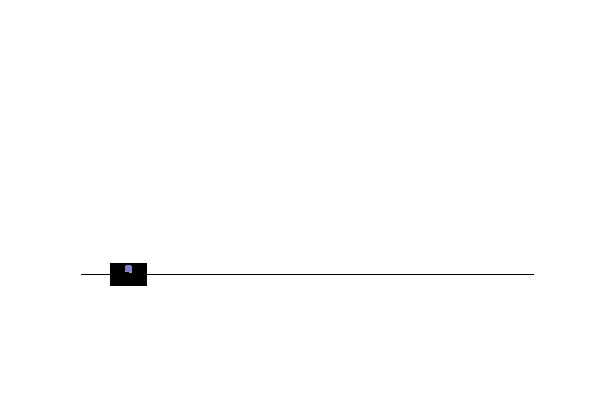
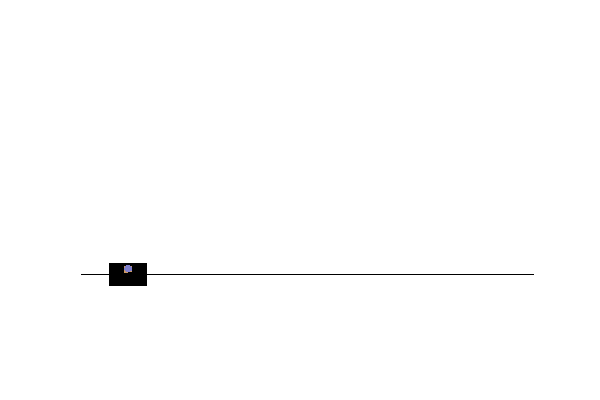
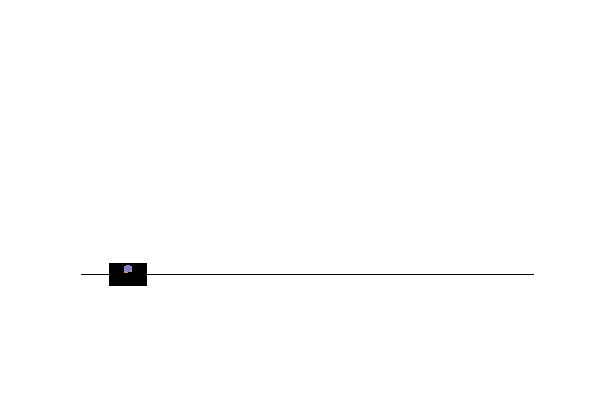
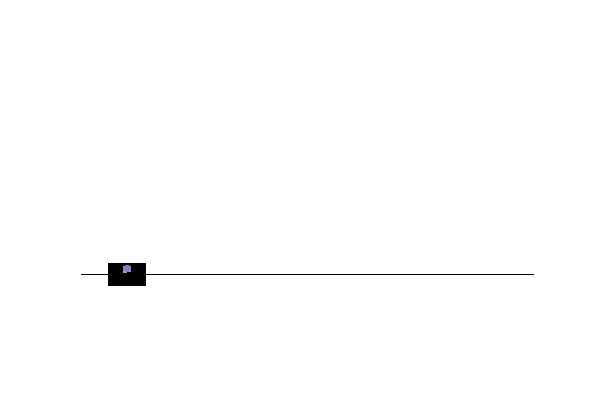
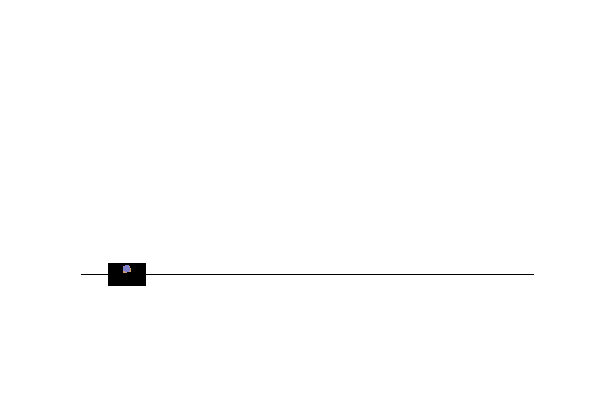
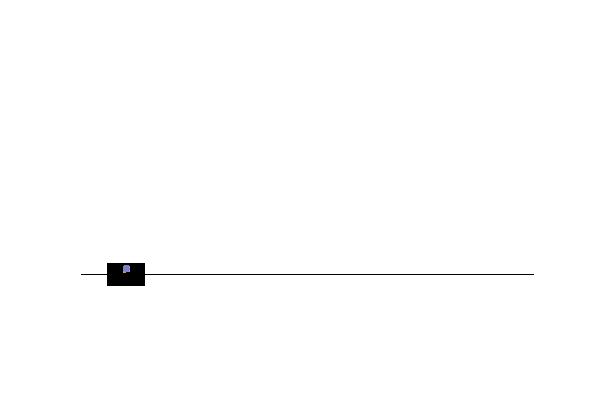
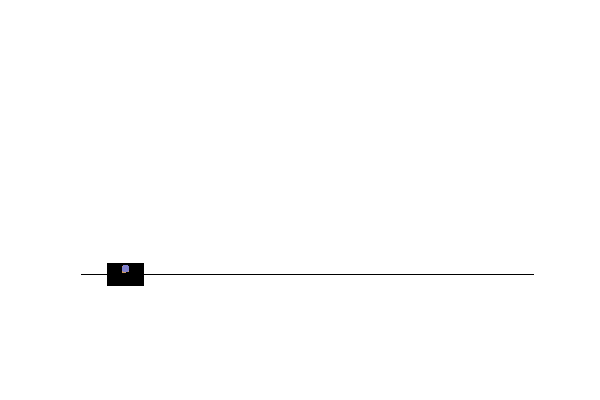
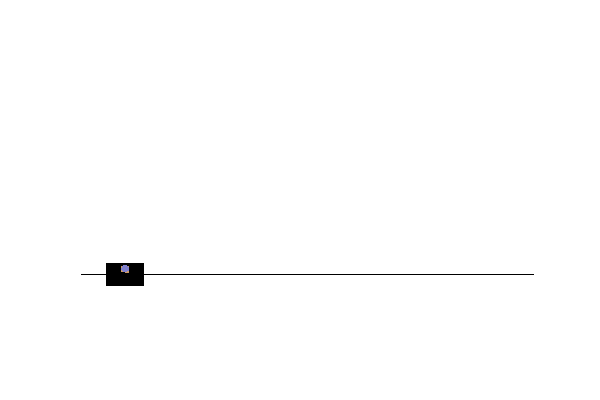
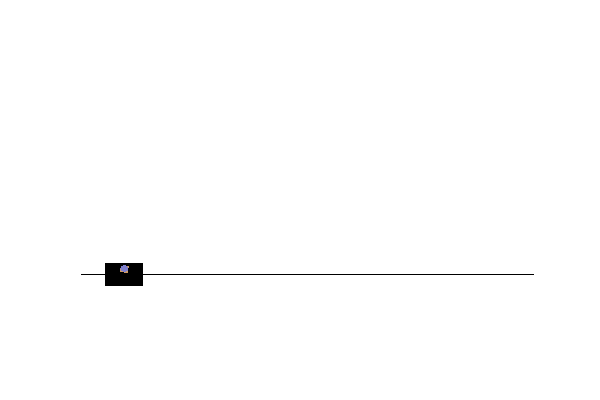
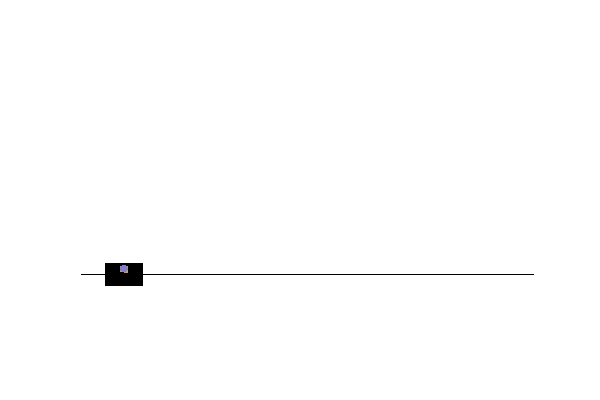
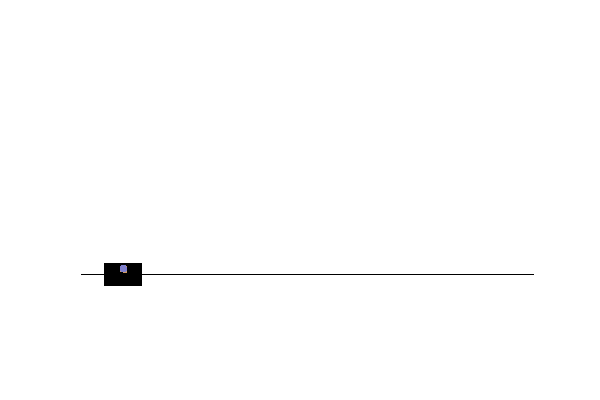
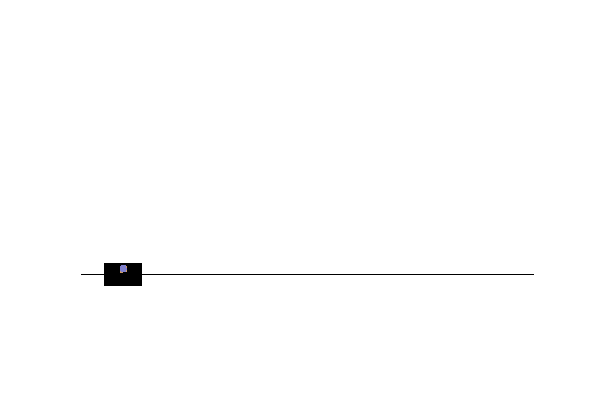
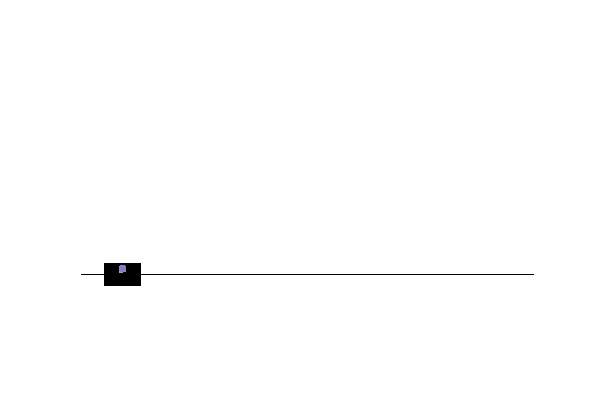
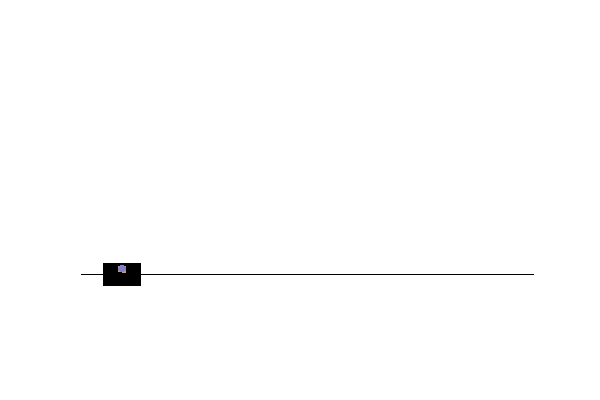
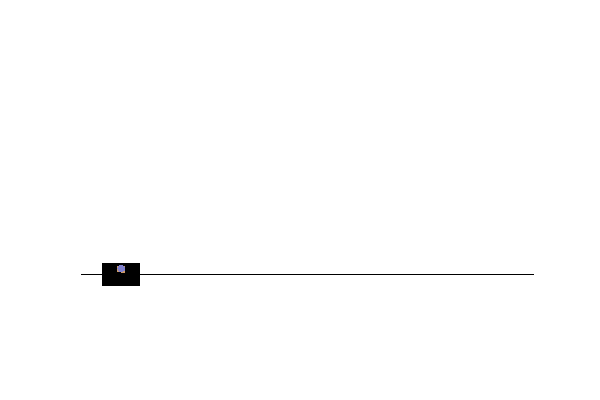
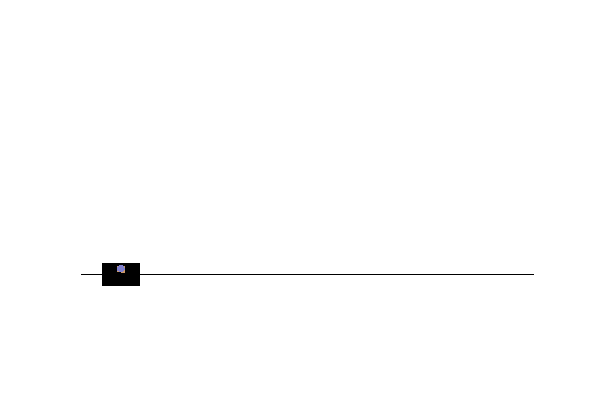
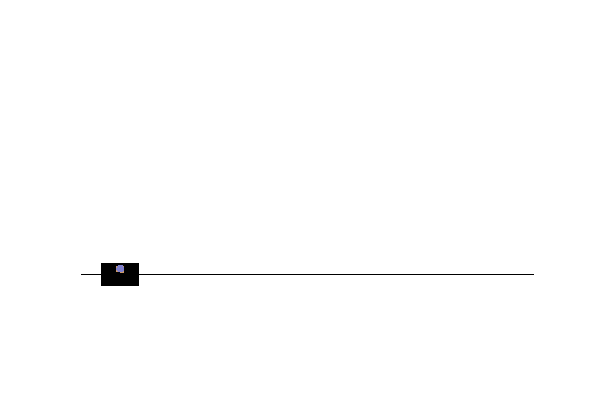
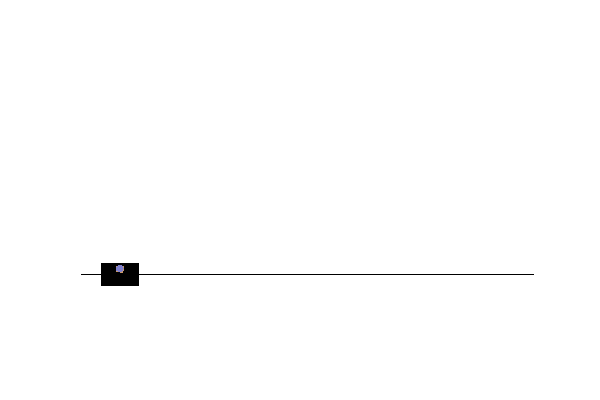
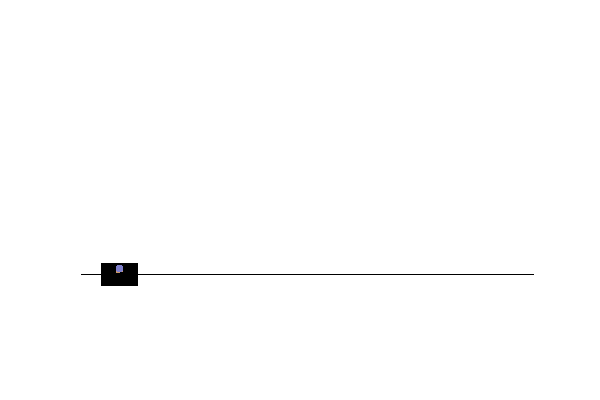
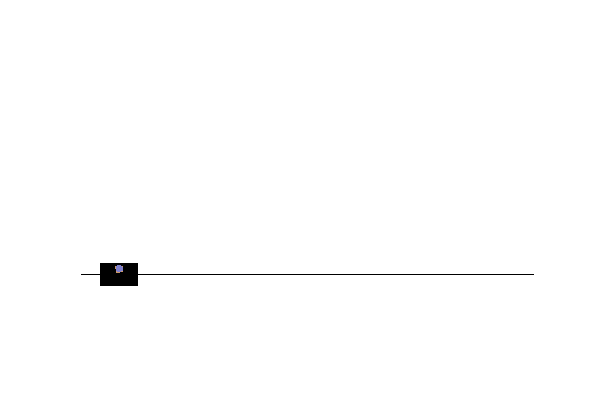
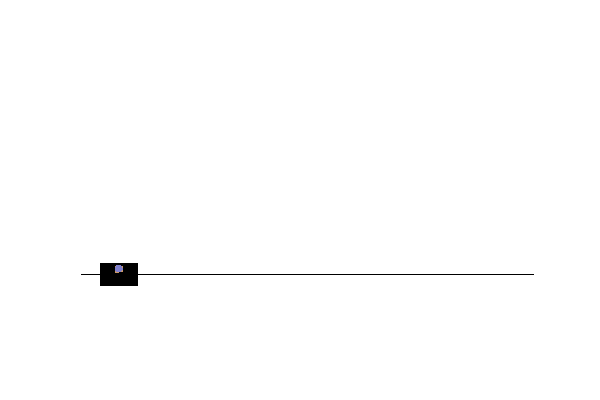
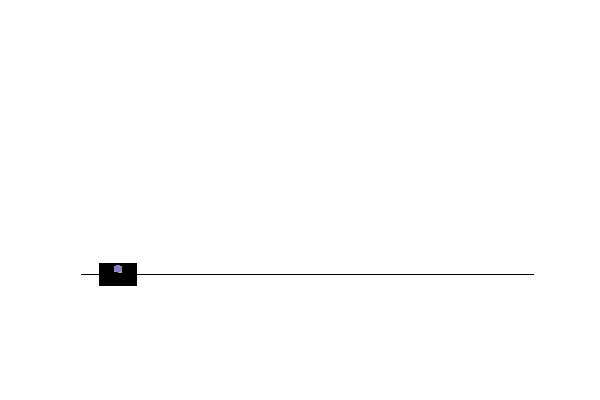
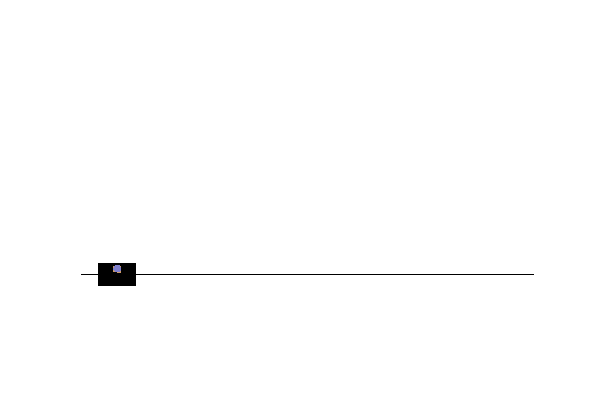
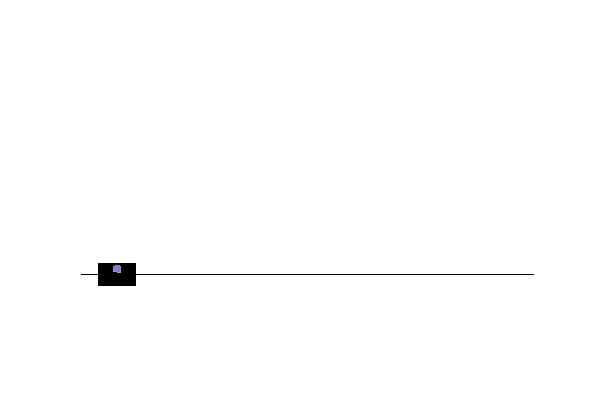
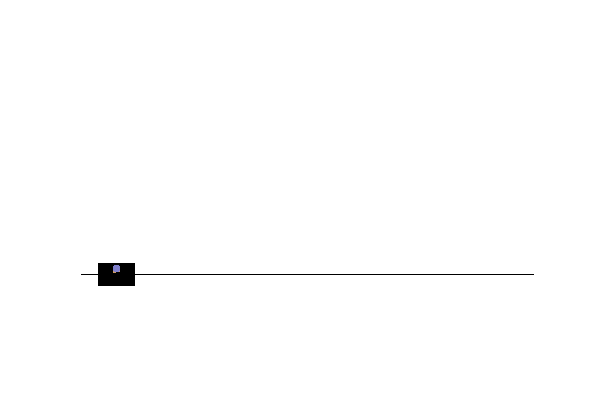
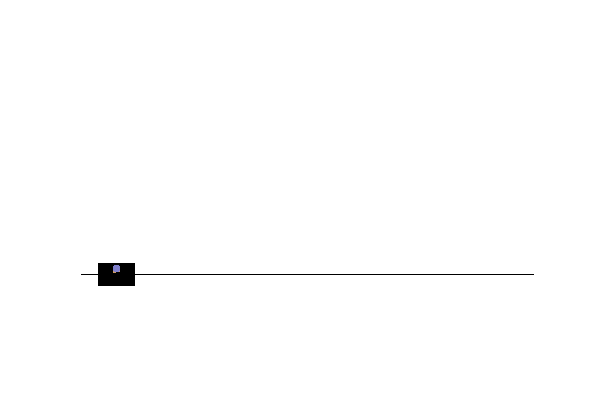
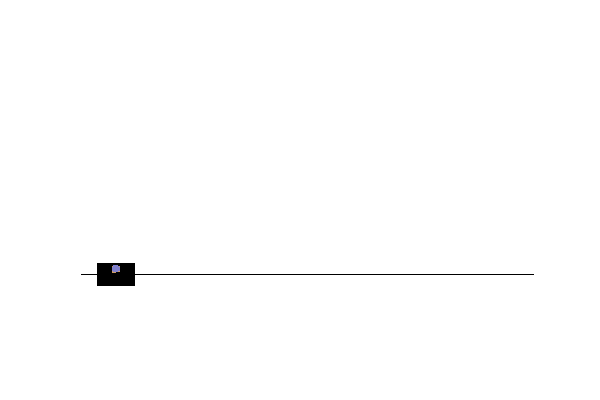
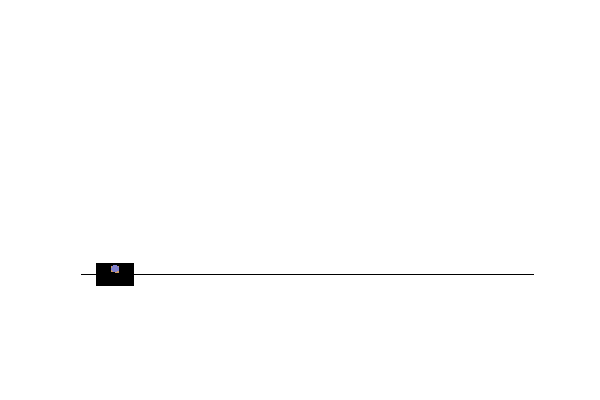
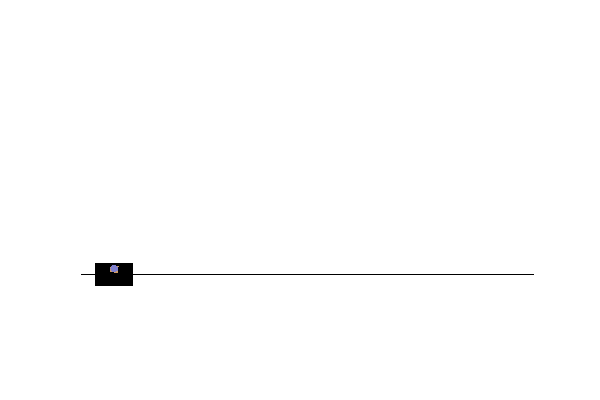
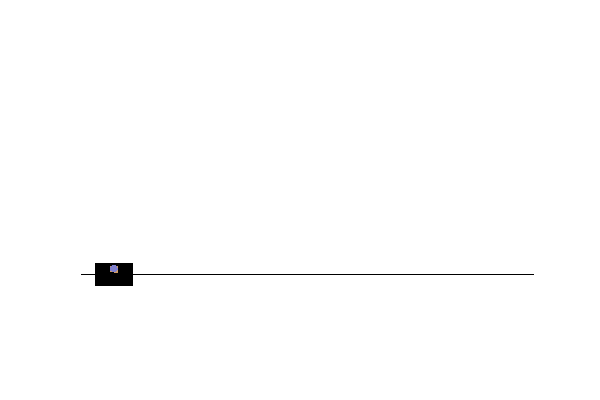
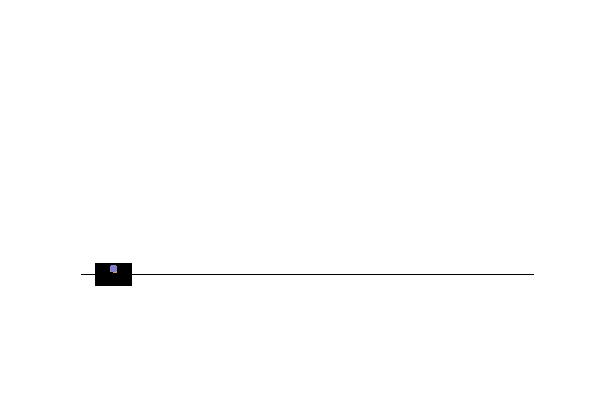
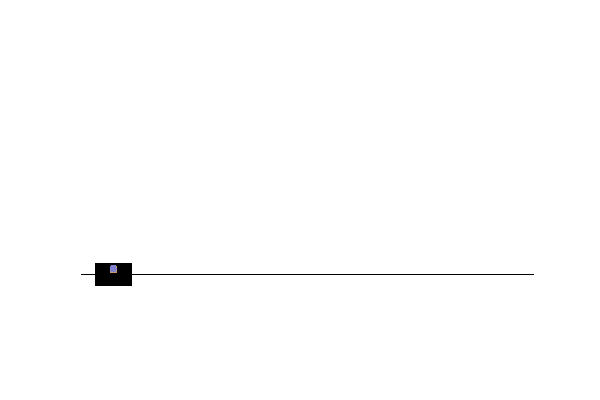
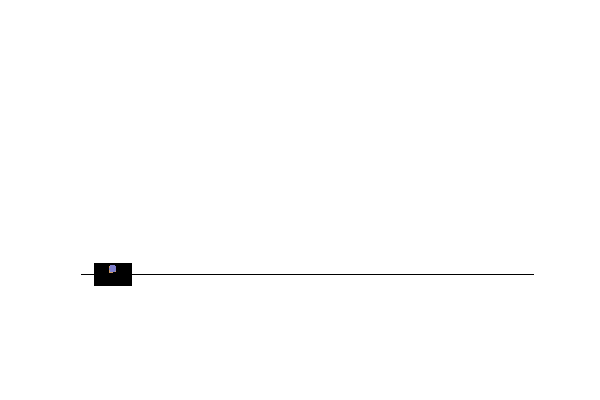
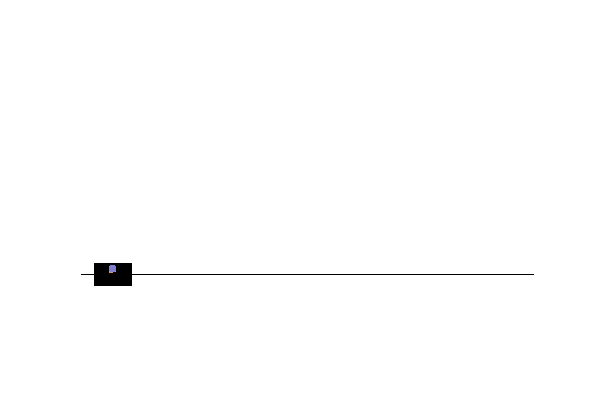
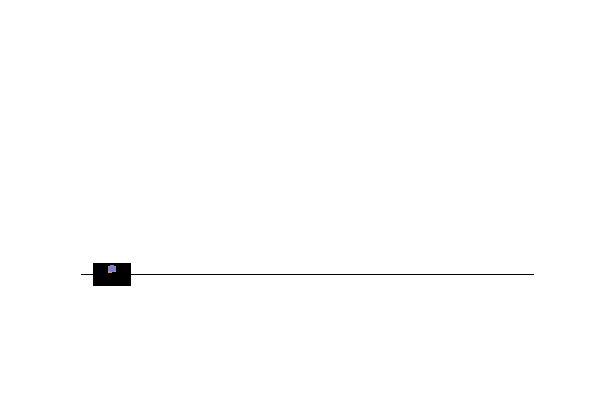
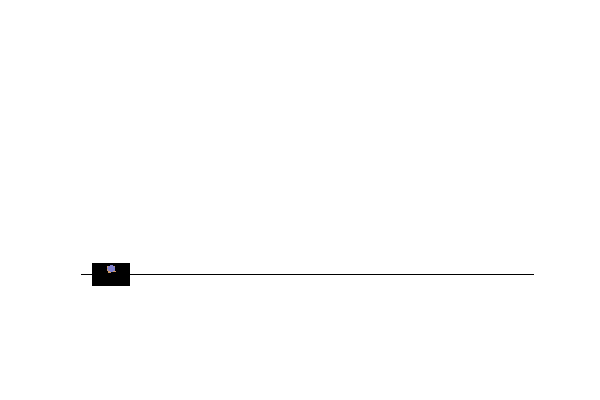
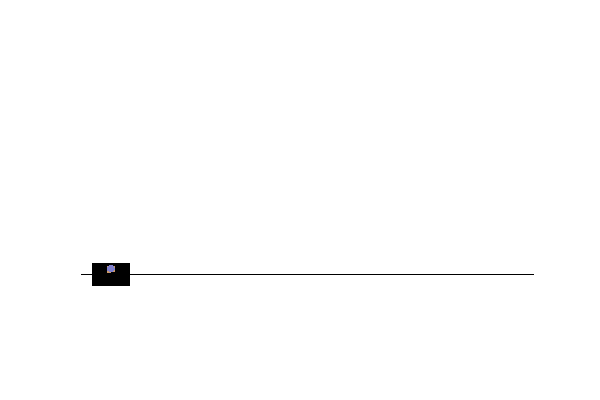
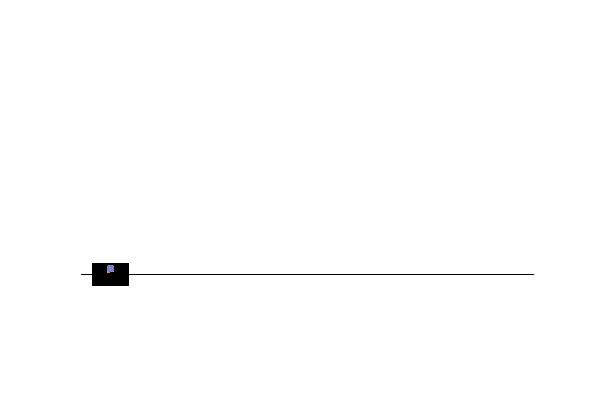
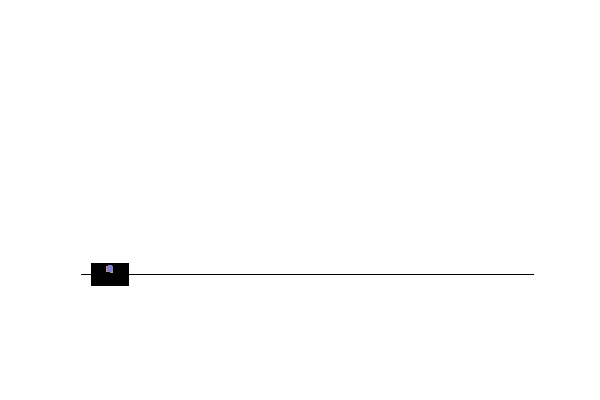
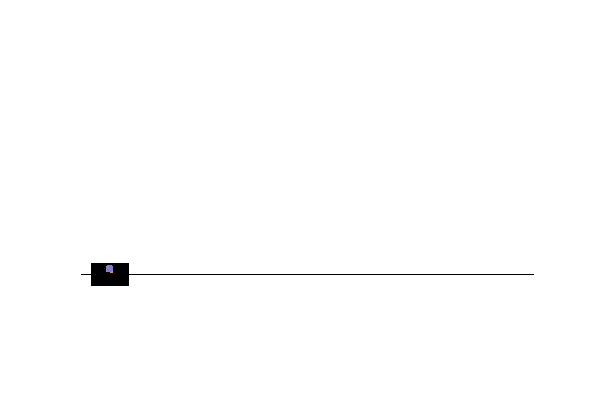
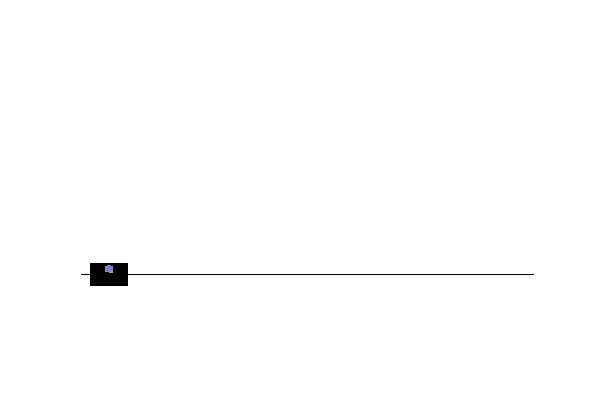
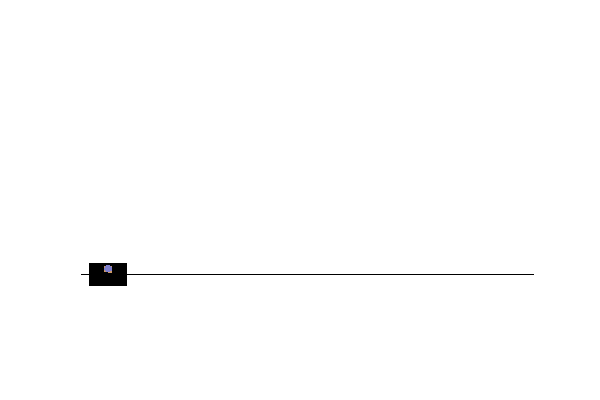
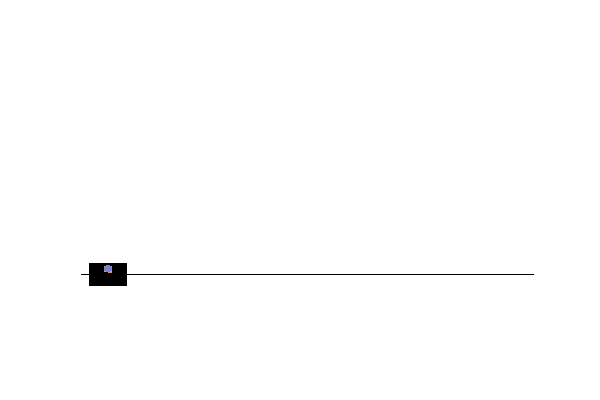
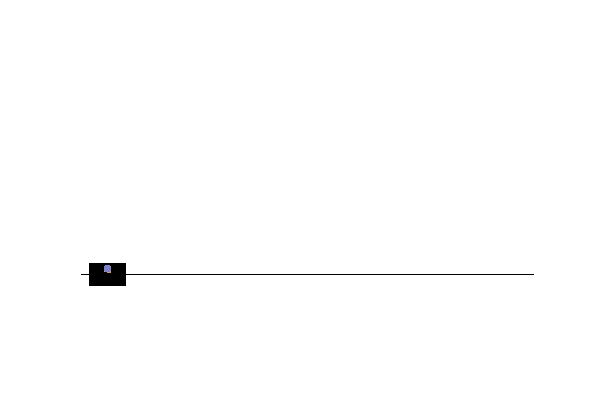
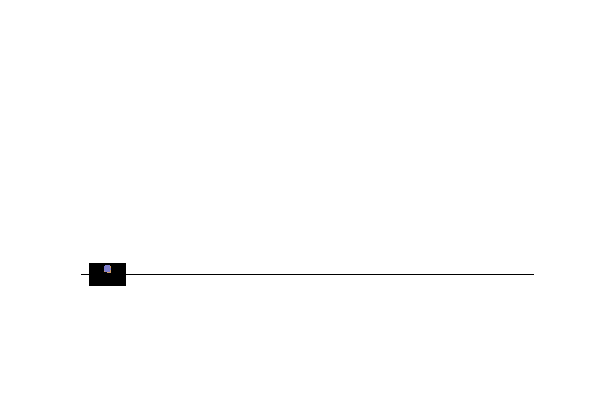
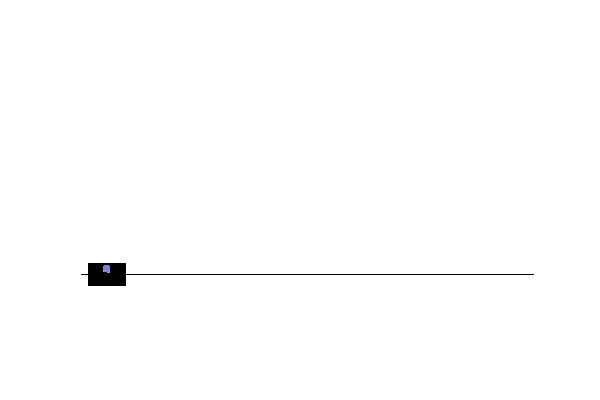
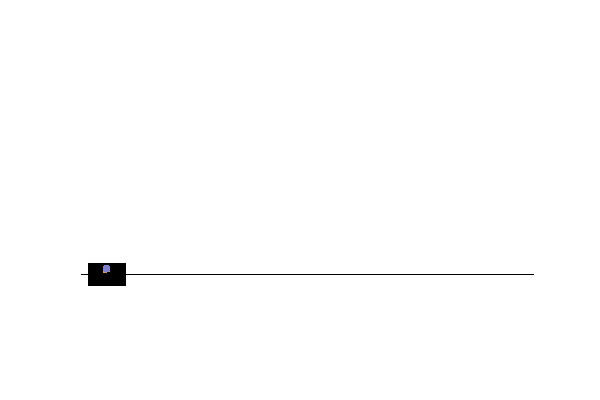
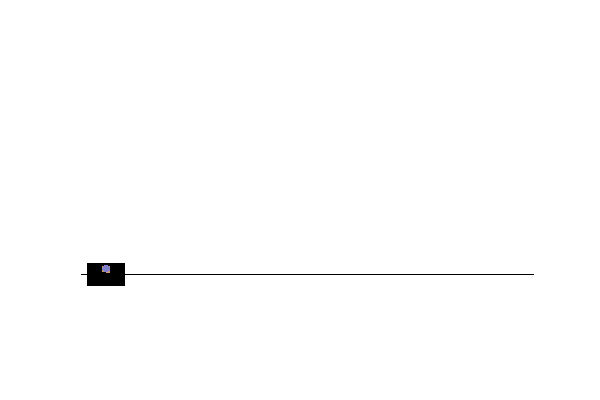
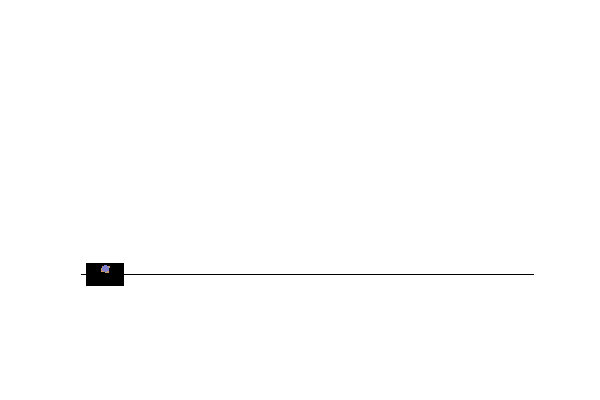
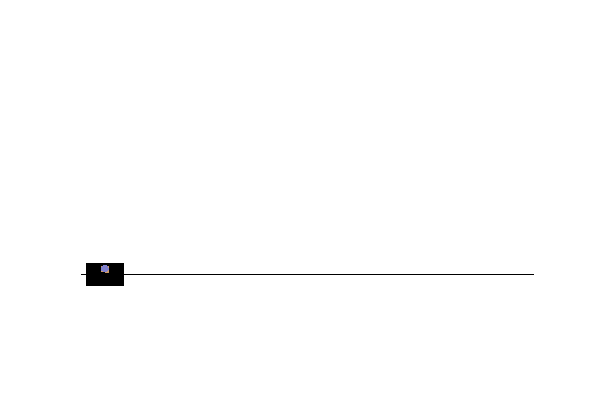
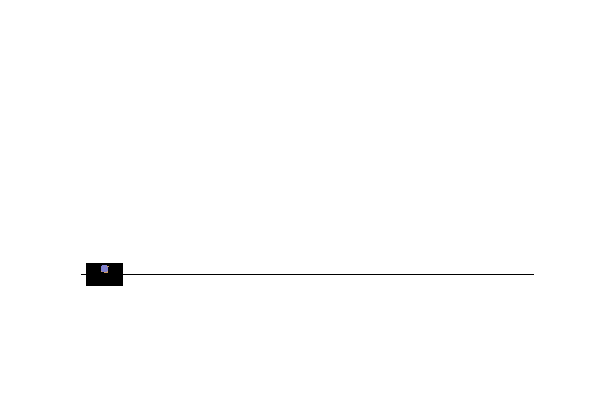
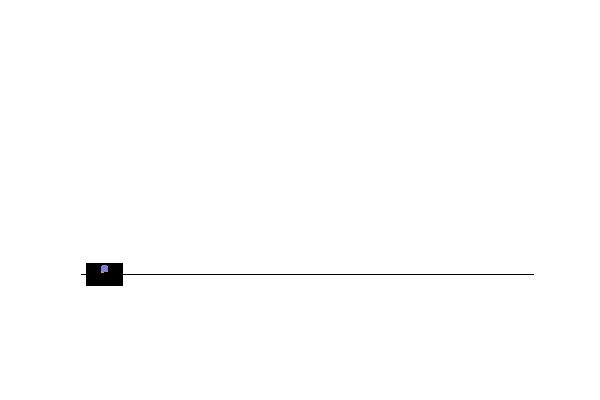
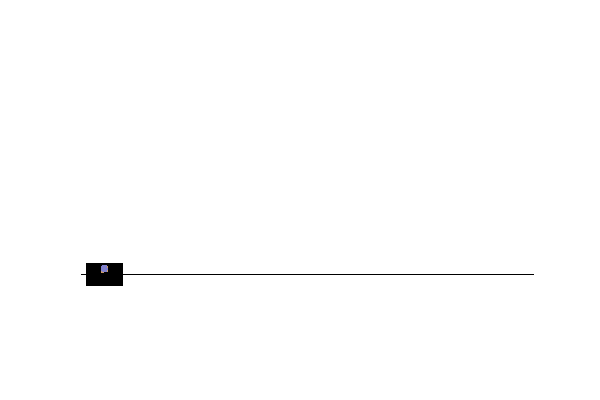
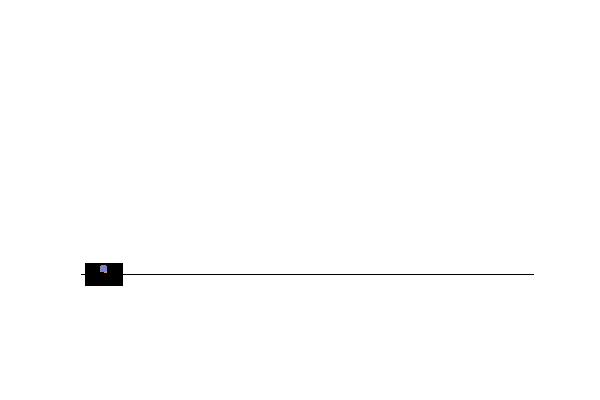
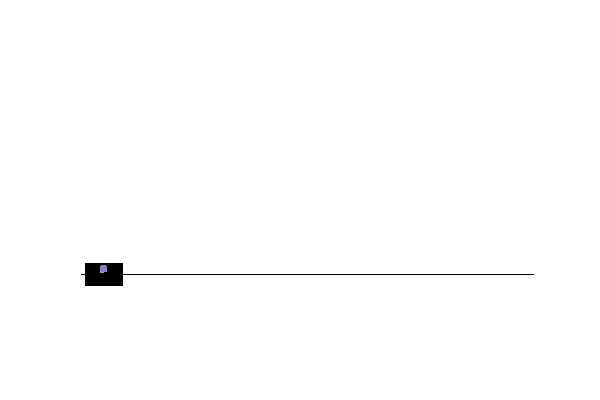
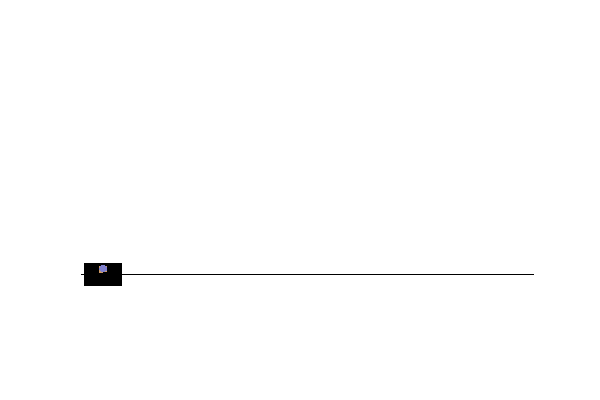
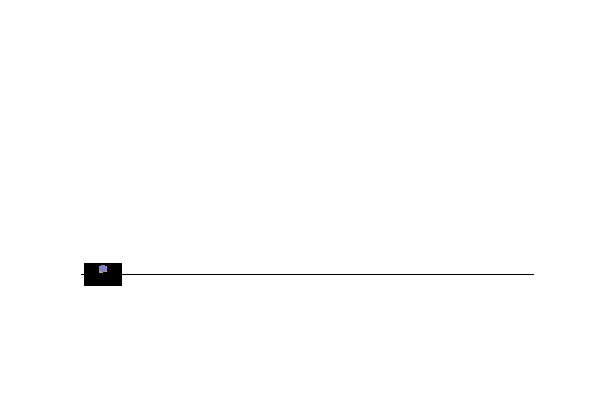
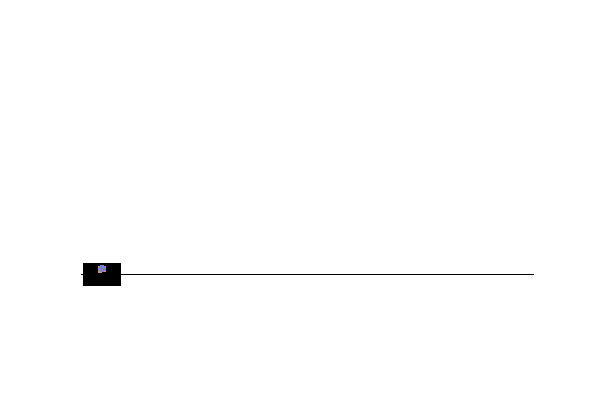
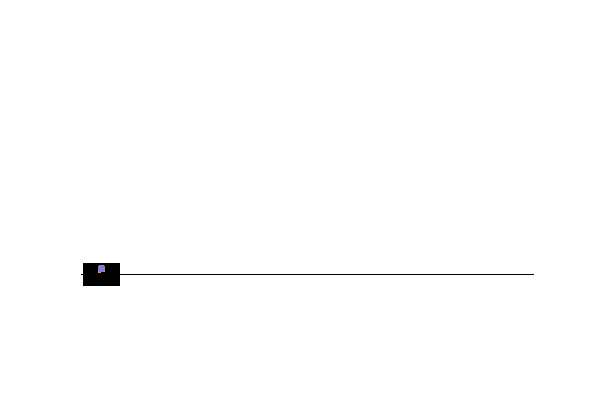
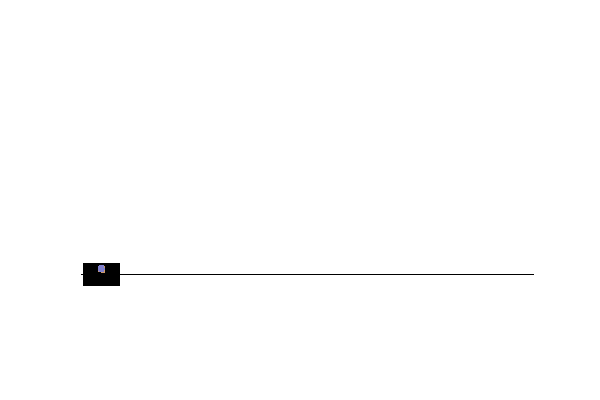
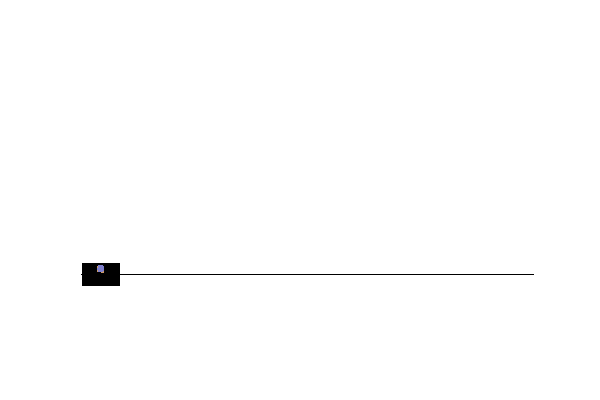
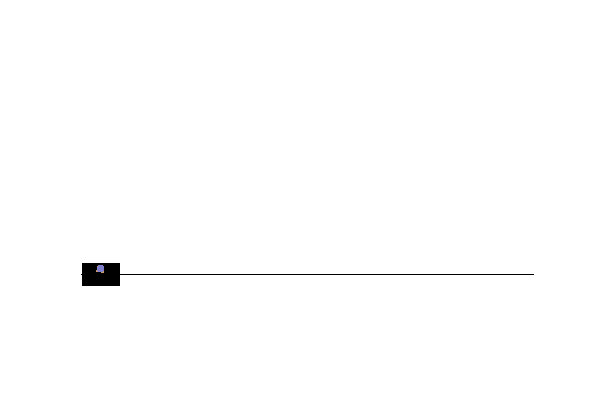
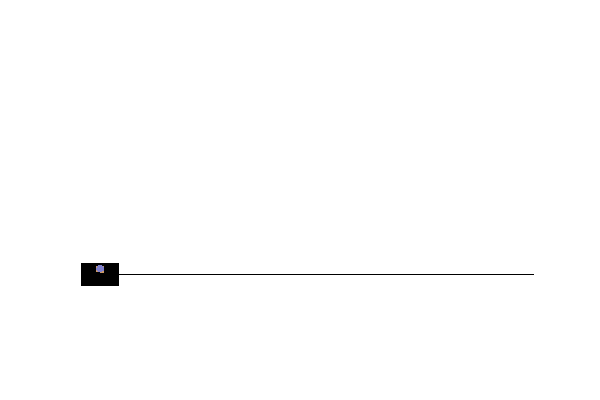
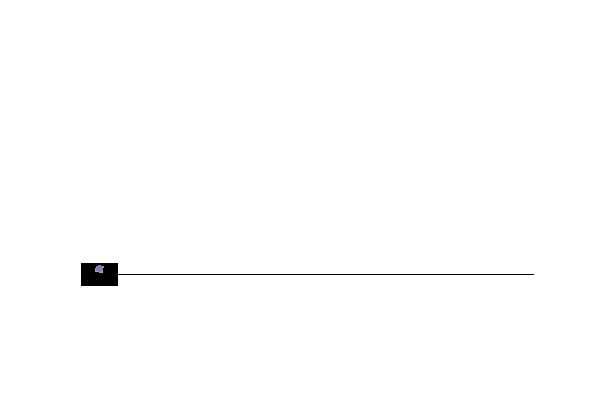
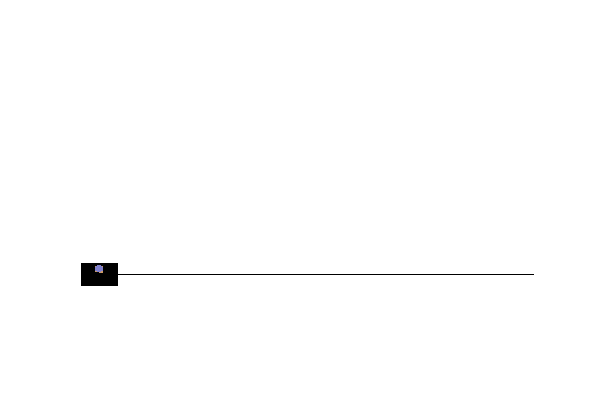
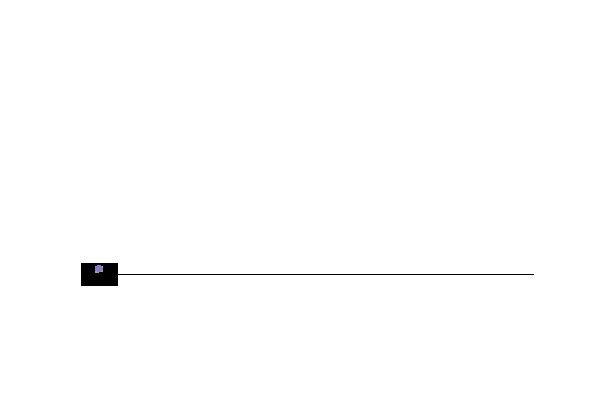
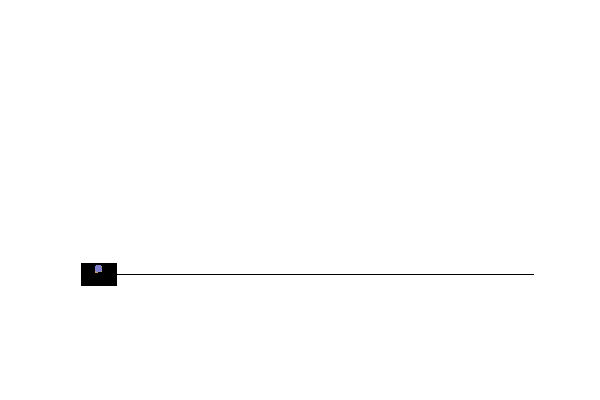
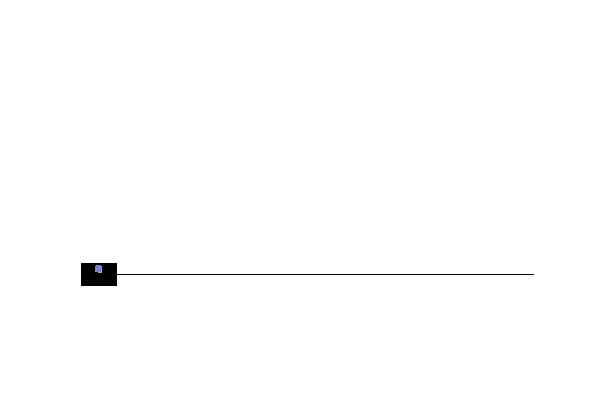
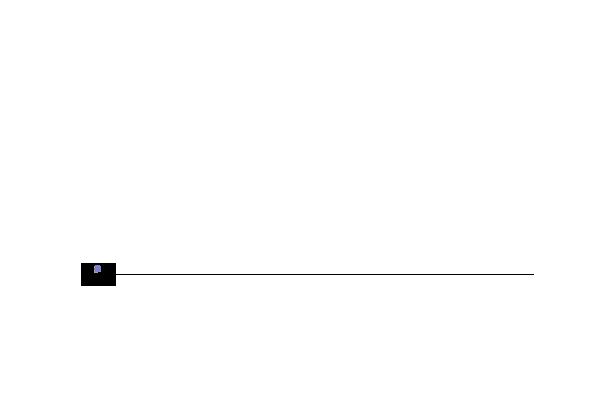
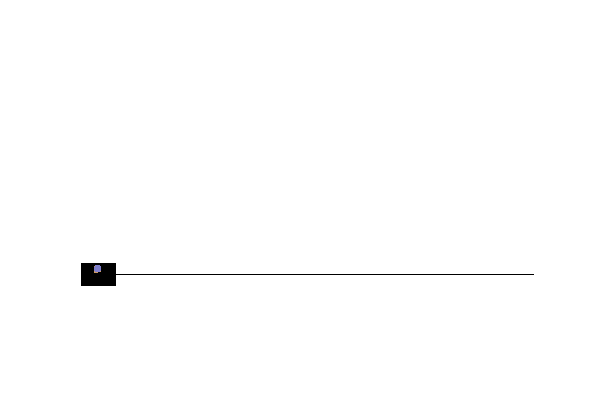
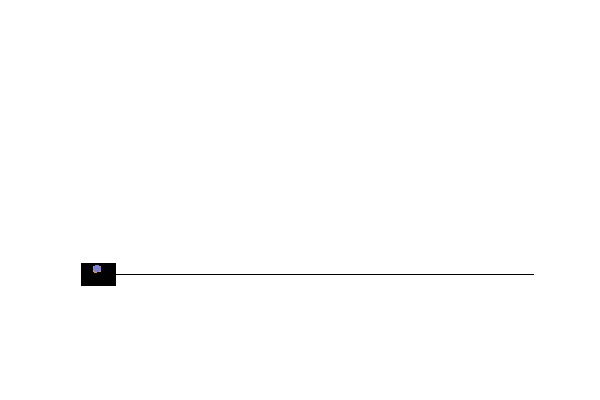
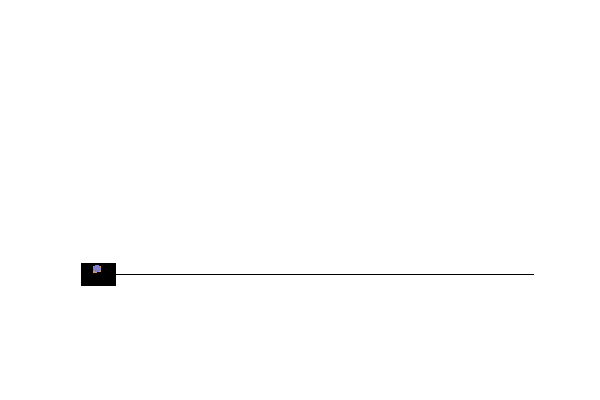
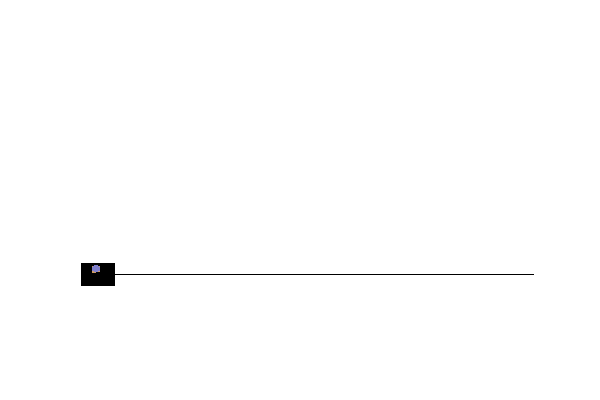
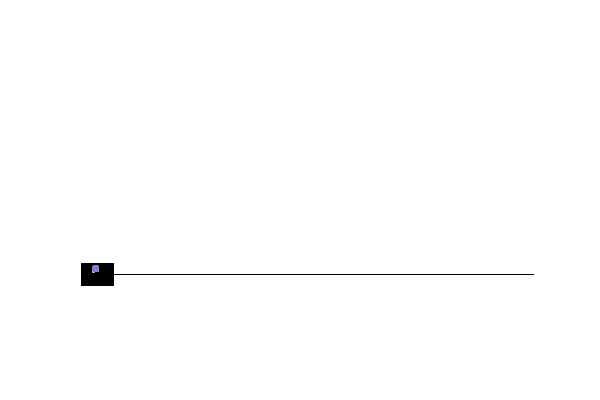
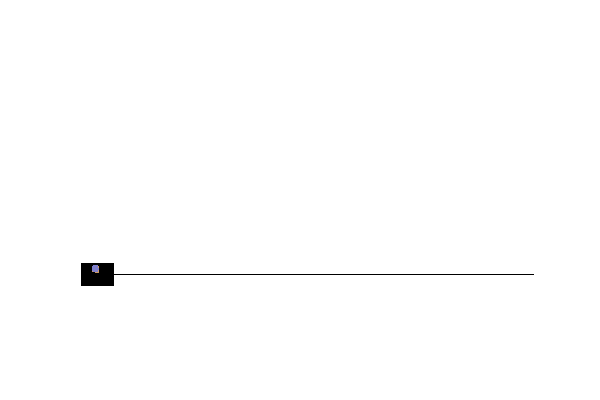
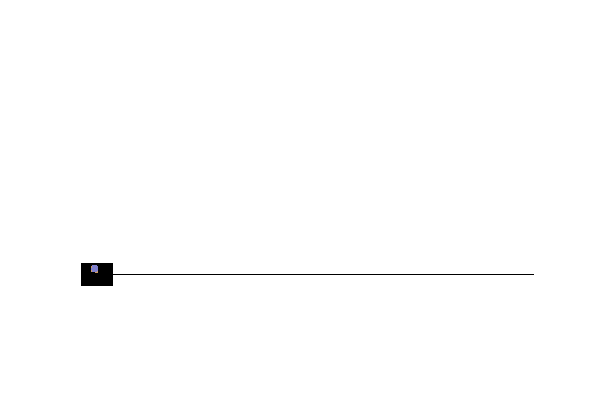
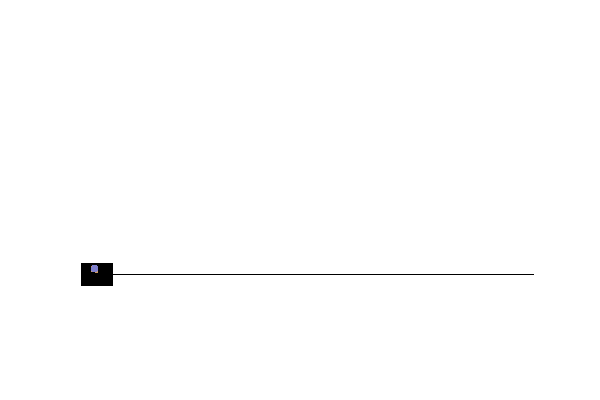
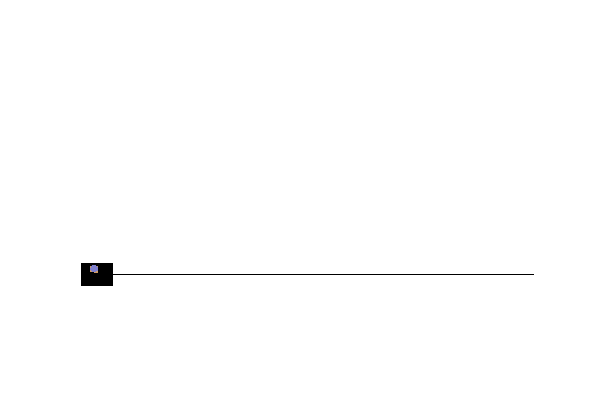
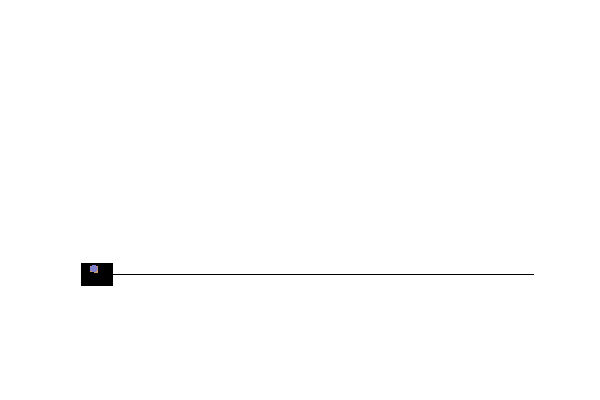
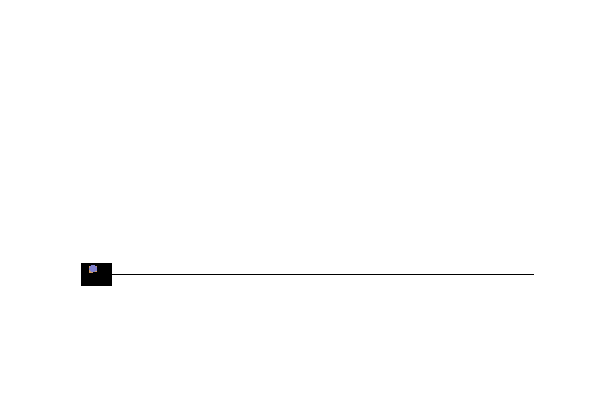
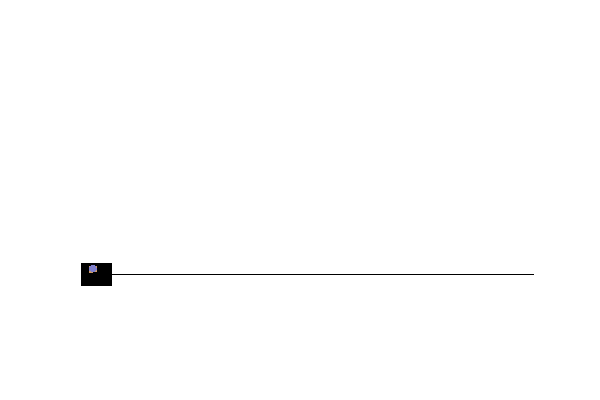
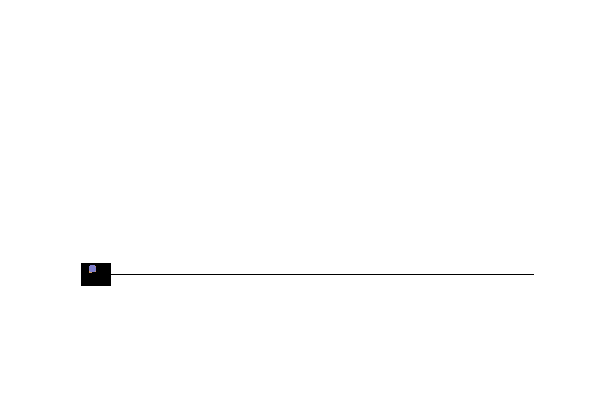
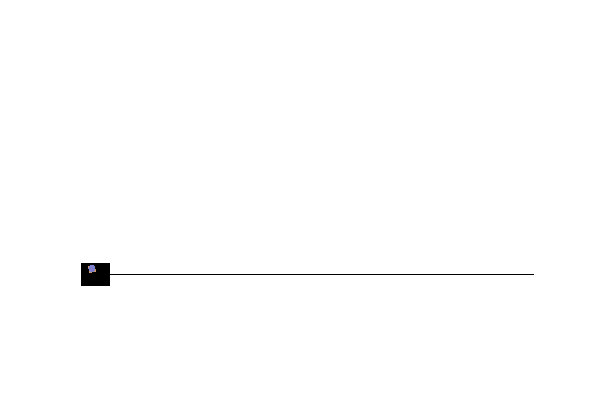
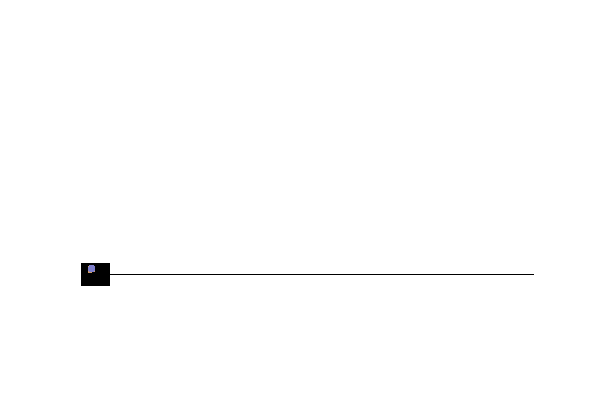
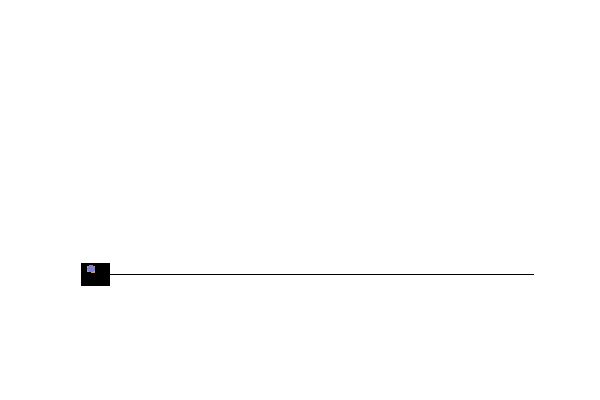
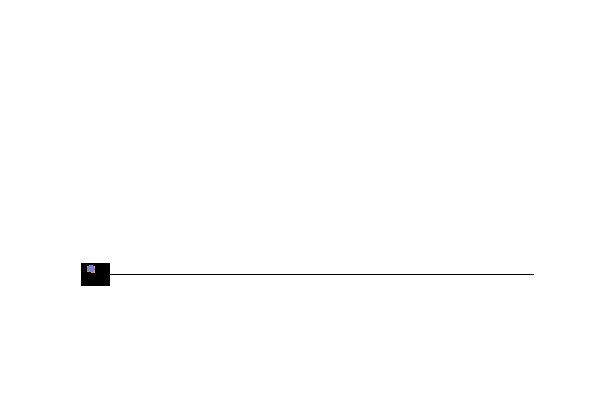
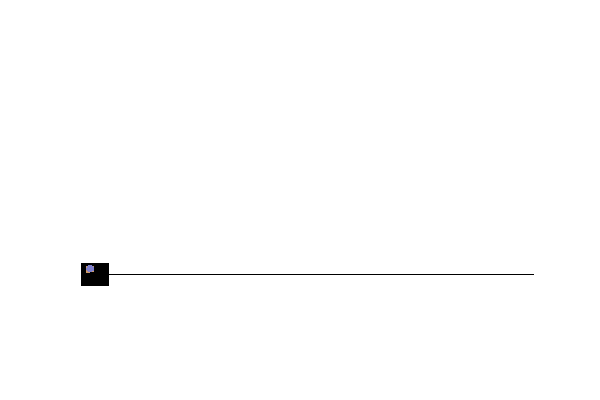
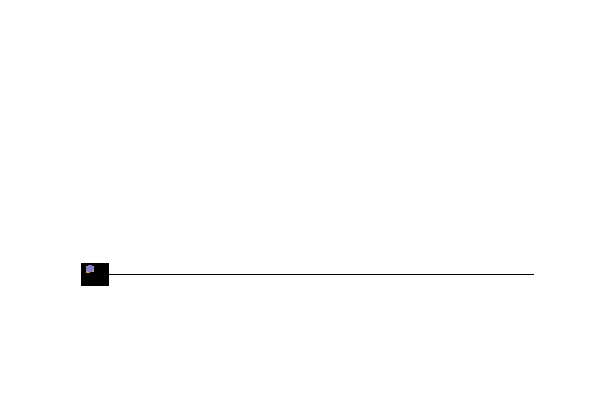
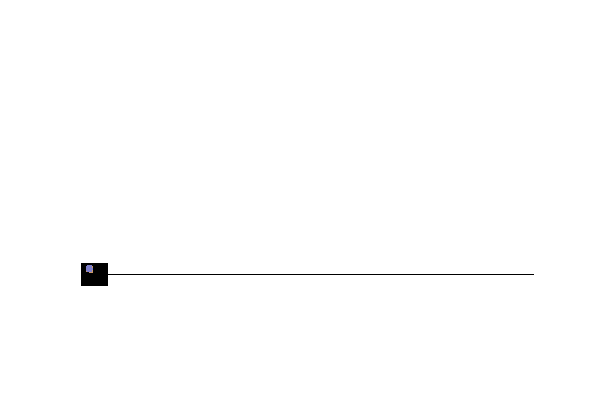
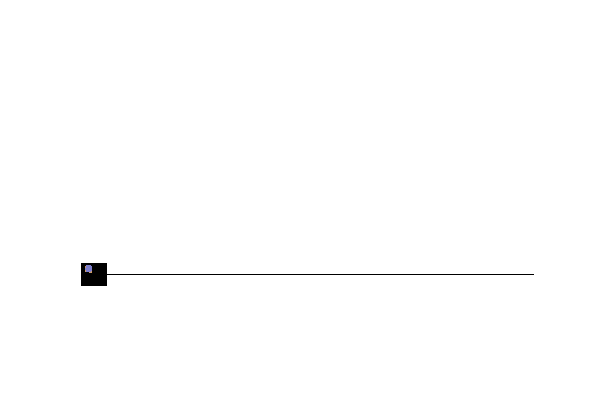
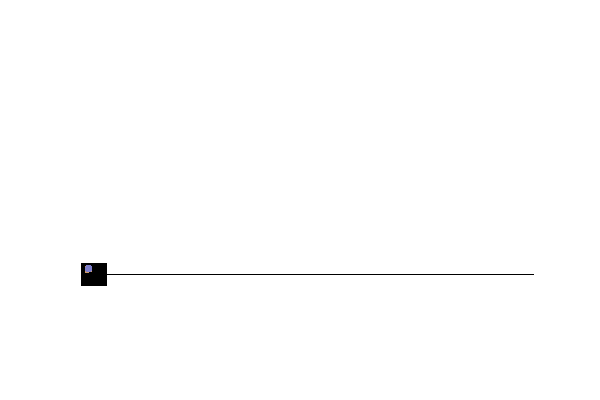
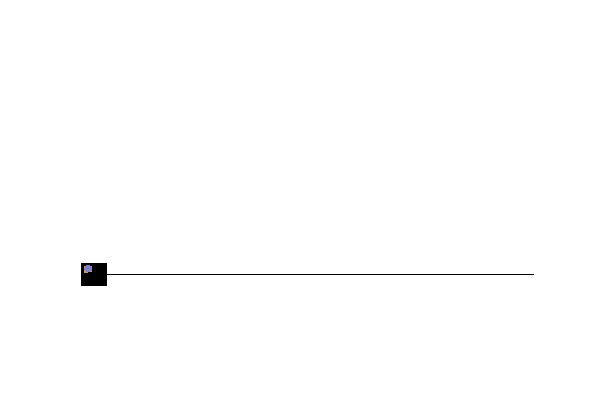
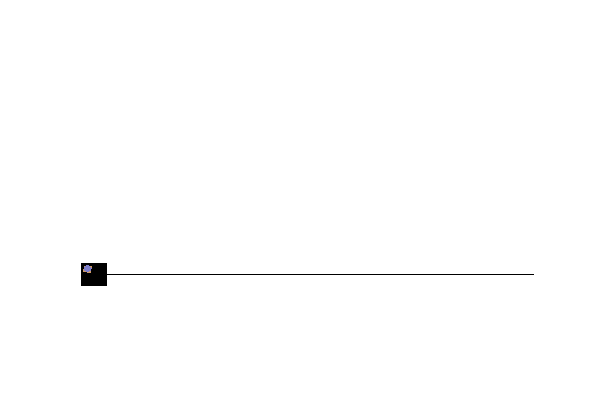
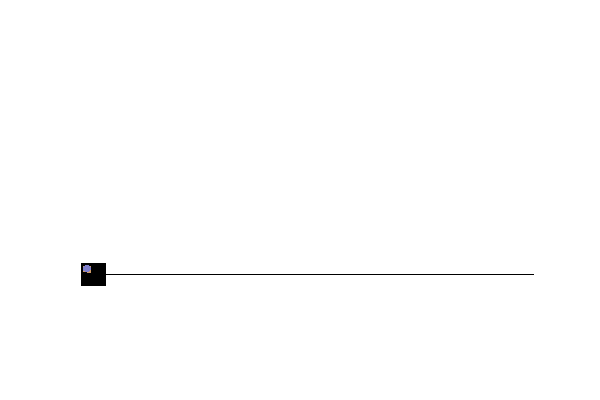
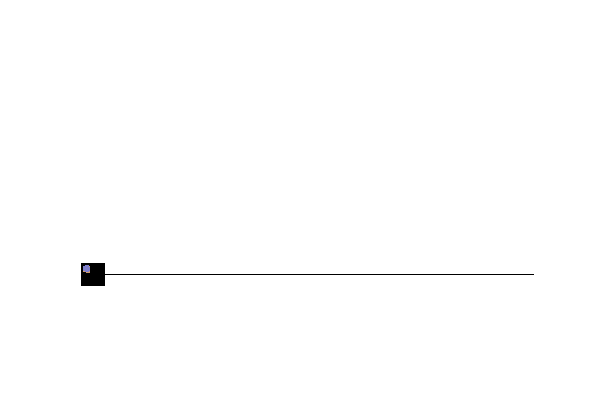
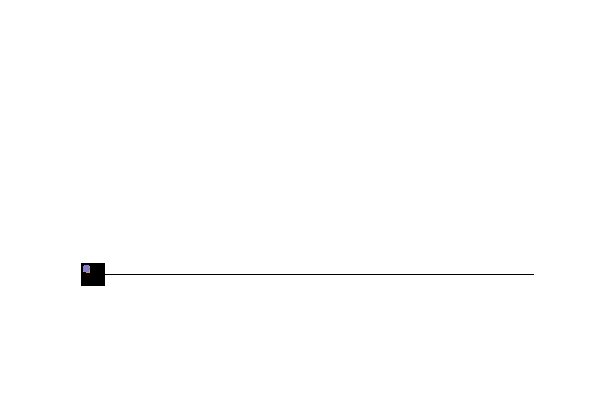
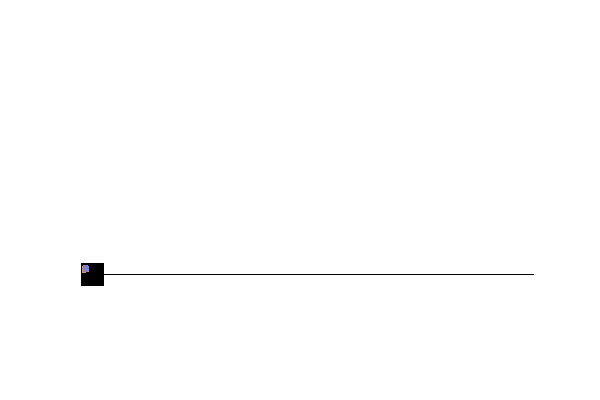
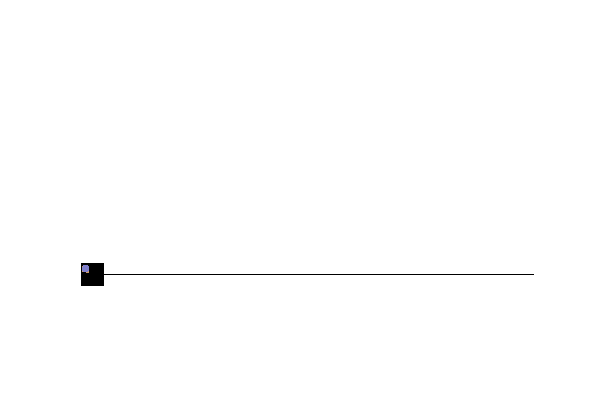
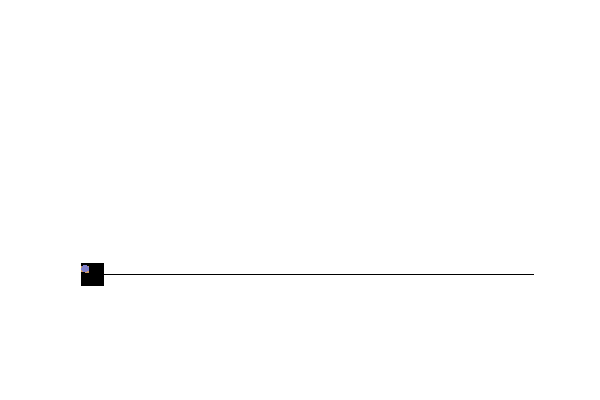
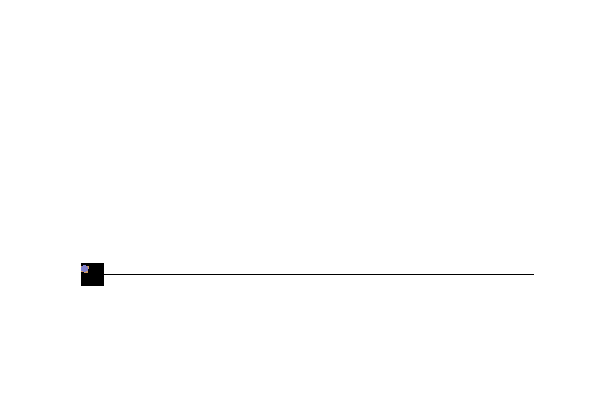
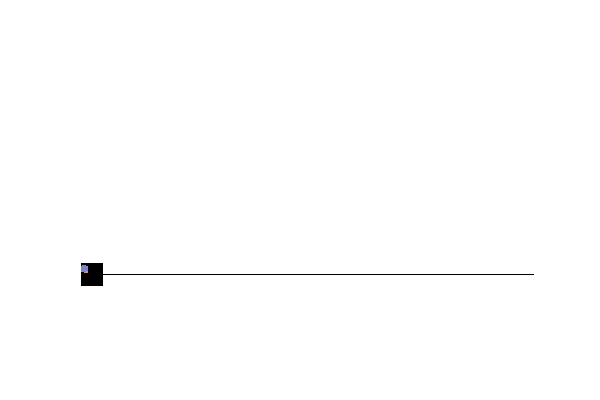
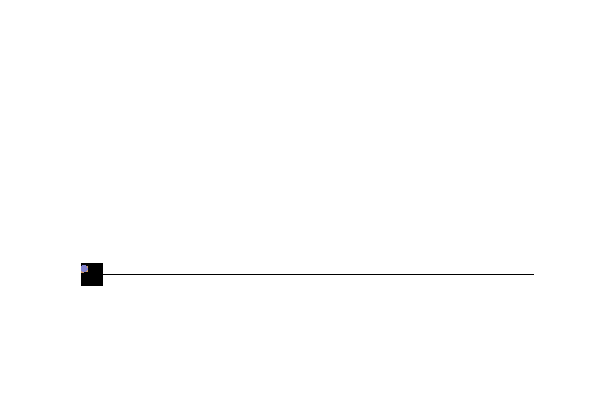
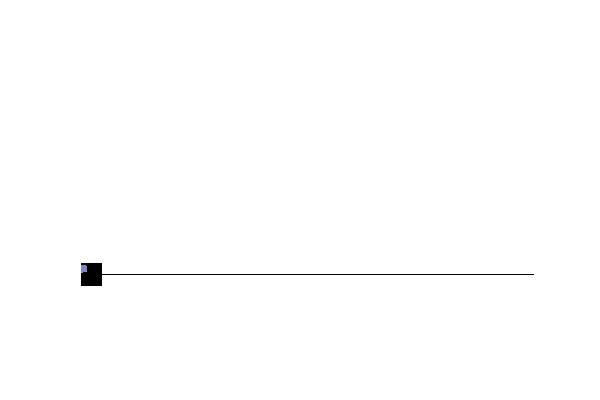
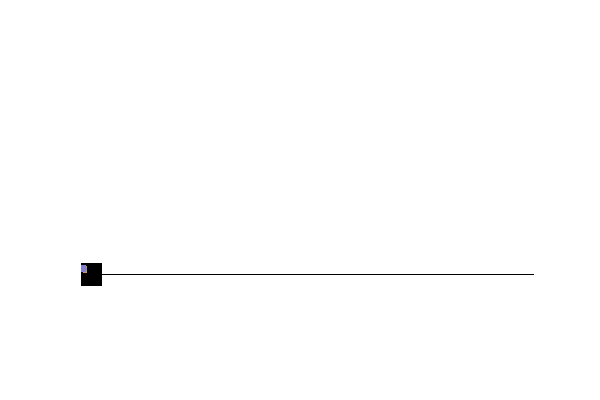
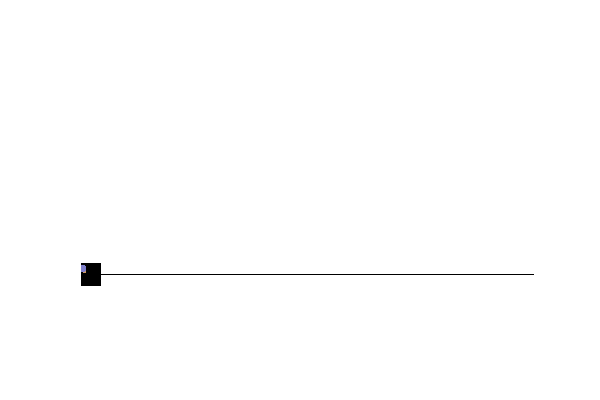
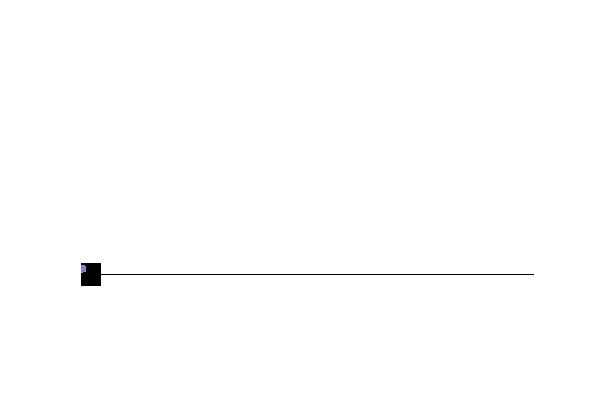
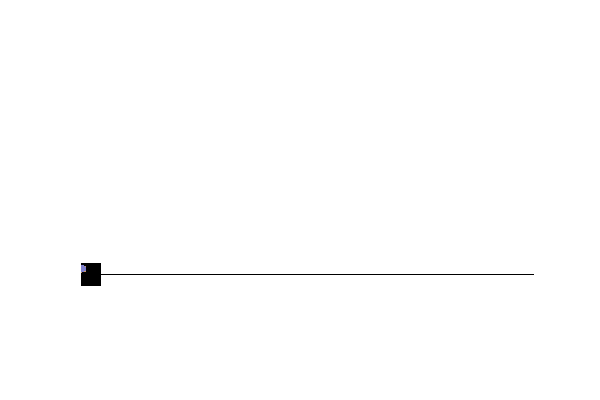
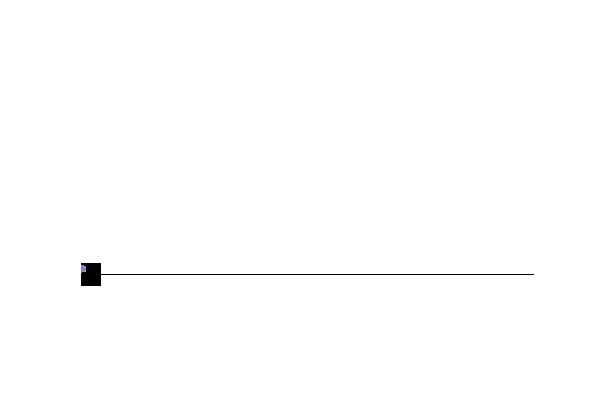
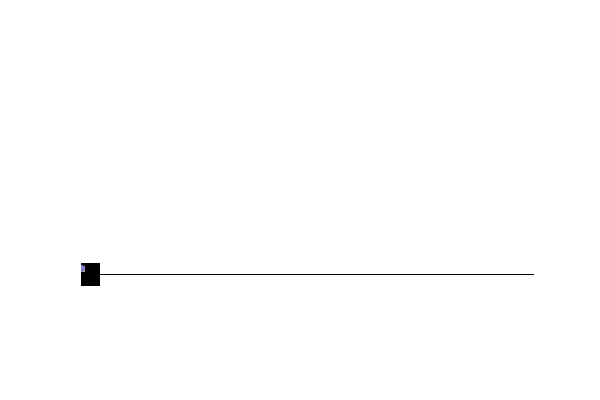

In [6]:
# main
cartpole_env = Environment()
cartpole_env.run()

In [7]:
cartpole_env.env.masscart

0.08

In [8]:
env = gym.make('CartPole-v0').env
observation = env.reset()

In [9]:
observation

array([-0.01370815, -0.01388248,  0.02675794, -0.04801136])

In [10]:
50**2

2500

In [11]:
q_table=cartpole_env.agent.brain.q_table

In [12]:
cartpole_env.agent.brain.digitize_state([-0.5,1.334])

30

In [13]:
q_table_d=np.argmax(q_table, axis=1)

In [14]:
q_table_d[2]

0

In [15]:
/10

TypeError: 'int' object is not callable

In [ ]:
a=-0.50
for i in range(10):
    a += (1.1/10)
    print(a)

In [ ]:
for i in range(-0.5,0.5,100):
    cartpole_env.agent.brain.digitize_state([i,0])

In [16]:
np.savetxt('q_table17.csv',q_table_d,delimiter=',')

In [ ]:
self.total_mass = (self.masspole + self.masscart)

In [ ]:
cartpole_env.env.total_mass

In [ ]:
cartpole_env.env.total_mass = (cartpole_env.env.masspole + cartpole_env.env.masscart)

In [ ]:
cartpole_env.env.total_mass

In [ ]:
cartpole_env.env.polemass_length

In [ ]:
cartpole_env.env.polemass_length = cartpole_env.env.masspole * cartpole_env.env.length

In [ ]:
cartpole_env.env.polemass_length

In [ ]:
cartpole_env.env.force_mag